In [1]:
import pandas as pd
import numpy as np

import csv   
import math
import matplotlib.pyplot as plt
import datetime

import librosa as lr
import librosa.display as lrd
%matplotlib inline
%load_ext rpy2.ipython

In [2]:
SPLIT_TRAIN_TEST = .8
TARGET_FILE = '../data/guitar/guitar.csv'
SAMPLES_FOLDER = '../data/guitar/guitar_samples/'
FOLDER_PREFIX = 'guitar'

D = str(datetime.datetime.now())
RESULTS_FILE = 'RESULTS-' + FOLDER_PREFIX + '-' + D[:16].replace(' ','_') + '.csv'
print RESULTS_FILE

HOP_LENGTH = 512

N_MFCC = 20
N_MEL = 32

SUBSET = False
N_EPOCHS = 30
BATCH_SIZE = 32
VERBOSE = 1
VALIDATION = .1

DEPENDENCIES = {
    "delay_feedback"      : "delay_on_off",
    "delay_intensity"     : "delay_on_off",
    "delay_time"          : "delay_on_off",
    "disto_drive"         : "disto_on_off",
    "disto_tone"          : "disto_on_off",
    "filter_frequency"    : "filter_on_off",
    "filter_mode_LBF_HPF" : "filter_on_off",
    "filter_resonance"    : "filter_on_off",
    "flanger_intensity"   : "flanger_on_off",
    "flanger_mode"        : "flanger_on_off",
    "flanger_rate"        : "flanger_on_off",
    "flanger_width"       : "flanger_on_off",
    "reverb_bright"       : "reverb_on_off",
    "reverb_room_size"    : "reverb_on_off"
}

RESULTS-guitar-2018-01-10_10:48.csv


# Prepares datasets

In [3]:
# Prepares labels
Y = pd.read_csv(TARGET_FILE)
if SUBSET:
    Y = Y.head(100)
print Y.head()

len_train = int(Y.shape[0]*.8)
len_test = int(Y.shape[0]*.2)
print len_train, len_test

Y_train = Y.iloc[:len_train,:]
Y_test = Y.iloc[len_train:,:]
print 
print 'Training data:', Y_train.shape
print 'Test data:', Y_test.shape

Y_train, files_train =  Y_train.drop('file', axis=1), Y_train['file']
Y_test, files_test = Y_test.drop('file', axis=1), Y_test['file']
print
print files_train[:5]
print files_test[:5]

   flanger_intensity  delay_time  disto_drive  reverb_room_size reverb_on_off  \
0           0.629921    0.944882     2.755906          6.377953           off   
1           5.039370    4.645669     0.078740          4.803150           off   
2           2.440945    0.472441     6.692913          7.086614           off   
3           9.606299    2.283465     9.370079          7.086614           off   
4           7.007874    3.228346     9.921260          4.330709            on   

  delay_on_off  flanger_width  flanger_rate  disto_tone filter_on_off  \
0           on       1.496063      1.653543    7.165354           off   
1           on       9.763780      7.322835    4.960630           off   
2          off       5.275591      8.031496    0.314961            on   
3          off       6.929134      3.622047    7.165354            on   
4           on       7.480315      0.472441    5.984252           off   

   delay_feedback  delay_intensity flanger_on_off  reverb_bright  \
0     

In [4]:
# Loads waveforms
sampling_rate = lr.load(SAMPLES_FOLDER + files_train[0])[1]
print 'Sampling rate:', sampling_rate

waveforms_test = []
for i, file_name in enumerate(files_test):
    if i % 100 == 0:
        print 'Loaded testing waveform #' + str(i)
    f = SAMPLES_FOLDER + file_name
    waveforms_test.append(lr.load(f)[0])
X_test = np.stack(waveforms_test)
print X_test.shape


waveforms_train = []
for i, file_name in enumerate(files_train):
    if i % 100 == 0:
        print 'Loaded training waveform #' + str(i)
    f = SAMPLES_FOLDER + file_name
    waveforms_train.append(lr.load(f)[0])
X_train = np.stack(waveforms_train)
print X_train.shape

Sampling rate: 22050
Loaded testing waveform #0
Loaded testing waveform #100
Loaded testing waveform #200
Loaded testing waveform #300
Loaded testing waveform #400
Loaded testing waveform #500
Loaded testing waveform #600
Loaded testing waveform #700
Loaded testing waveform #800
Loaded testing waveform #900
Loaded testing waveform #1000
Loaded testing waveform #1100
Loaded testing waveform #1200
Loaded testing waveform #1300
Loaded testing waveform #1400
Loaded testing waveform #1500
Loaded testing waveform #1600
Loaded testing waveform #1700
Loaded testing waveform #1800
Loaded testing waveform #1900
(2000, 18522)
Loaded training waveform #0
Loaded training waveform #100
Loaded training waveform #200
Loaded training waveform #300
Loaded training waveform #400
Loaded training waveform #500
Loaded training waveform #600
Loaded training waveform #700
Loaded training waveform #800
Loaded training waveform #900
Loaded training waveform #1000
Loaded training waveform #1100
Loaded training w

# Independent models

## Prepares the features

In [5]:
L_test_mfcc = []
for i in range(X_test.shape[0]):
    S = X_test[i,:]
    mfcc = lr.feature.mfcc(y=S, sr=sampling_rate, hop_length=HOP_LENGTH, n_mfcc=N_MFCC)
    L_test_mfcc.append(mfcc)
X_test_mfcc = np.stack(L_test_mfcc)
print X_test_mfcc.shape

L_train_mfcc = []
for i in range(X_train.shape[0]):
    S = X_train[i,:]
    mfcc = lr.feature.mfcc(y=S, sr=sampling_rate, hop_length=HOP_LENGTH, n_mfcc=N_MFCC)
    L_train_mfcc.append(mfcc)
X_train_mfcc = np.stack(L_train_mfcc)
print X_train_mfcc.shape

(2000, 20, 37)
(8000, 20, 37)


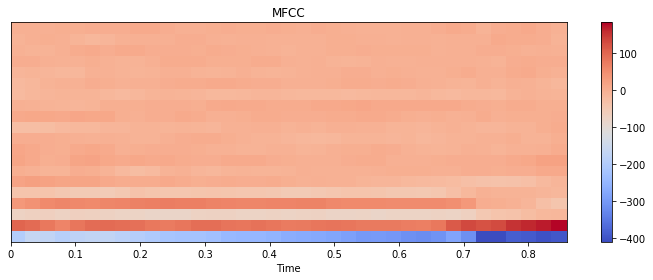

In [6]:
plt.figure(figsize=(10, 4))
lr.display.specshow(X_train_mfcc[10,...], x_axis='time')
plt.colorbar()
plt.title('MFCC')
plt.tight_layout()

In [7]:
X_test_mfcc = np.reshape(X_test_mfcc, (X_test_mfcc.shape[0],-1))
X_train_mfcc = np.reshape(X_train_mfcc, (X_train_mfcc.shape[0],-1))
print X_test_mfcc.shape
print X_train_mfcc.shape

(2000, 740)
(8000, 740)


## Predictions

In [8]:
import sys
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score,mean_absolute_error
from sklearn.model_selection import GridSearchCV

headers=['algo', 'type', 'param1','param2','regularization',
         'target','metric', 'train_score', 'test_score']
with open(RESULTS_FILE, 'w') as f:
    writer = csv.writer(f)
    writer.writerow(headers)

    
def evaluate_algo(algo_label, grid_reg, grid_class):
    results = []
    for t_i, t_name in enumerate(list(Y_train)):

        print 'predicting feature', t_name
        y_train = Y_train[t_name]
        y_test = Y_test[t_name]
        print y_train.dtype
        
        if t_name in DEPENDENCIES:
            switch = DEPENDENCIES[t_name]
            
            to_keep_train = (Y_train[switch] == 'on')
            print 'Keeping', str(sum(to_keep_train)), 'training examples out of',  str(len(to_keep_train))
            y_train = y_train[to_keep_train]
            X_train= X_train_mfcc[to_keep_train,...]
            
            to_keep_test = (Y_test[switch] == 'on')
            print 'Keeping', str(sum(to_keep_test)), 'training examples out of',  str(len(to_keep_test))
            y_test = y_test[to_keep_test]
            X_test = X_test_mfcc[to_keep_test,...]
        
        else:
            X_train= X_train_mfcc
            X_test= X_test_mfcc
        
        print X_train.shape, y_train.shape
        print X_test.shape, y_test.shape
        
        best_params_C = None
        best_params_R = None
        
        try:
            # Case 1: classification
            if y_train.dtype == 'object':

                metric = 'class'

                # Cross-Validation Score
                grid_class.fit(X_train, y_train)
                cross_val_scores = grid_class.best_score_
                best_params_C = grid_class.best_params_
                print cross_val_scores

                # Test Score
                test_pred = grid_class.predict(X_test)
                test_score = accuracy_score(test_pred, y_test)
                print test_score


            # Case 2: regression
            elif y_train.dtype == 'float64':

                metric = 'reg'

                # Cross-Validation Score
                grid_reg.fit(X_train, y_train)
                cross_val_scores = grid_reg.best_score_ * -1
                best_params_R = grid_reg.best_params_
                print cross_val_scores

                # Test Score
                test_pred = grid_reg.predict(X_test)
                test_score = mean_absolute_error(test_pred, y_test)
                print test_score

            else:
                raise ValueError('Wrong Column Type')

            out = (algo_label, 'per_output', best_params_R, best_params_C,None,
                   t_name, metric, cross_val_scores, test_score)
            print out
            with open(RESULTS_FILE, 'a') as f:
                writer = csv.writer(f,quoting=csv.QUOTE_NONNUMERIC)
                writer.writerow(out)

        except:
            print "Unexpected error:", sys.exc_info()[0]

In [9]:
from sklearn import neighbors

algo_C =neighbors.KNeighborsClassifier()
grid_C = GridSearchCV(algo_C, {"n_neighbors":[3,5,8,16]}, scoring='accuracy', verbose=2)

algo_R =neighbors.KNeighborsRegressor()
grid_R = GridSearchCV(algo_R, {"n_neighbors":[3,5,8,16]}, scoring='neg_mean_absolute_error', verbose=2)

evaluate_algo('kNN', grid_R, grid_C)

predicting feature flanger_intensity
float64
Keeping 4028 training examples out of 8000
Keeping 1019 training examples out of 2000
(4028, 740) (4028,)
(1019, 740) (1019,)
Fitting 3 folds for each of 4 candidates, totalling 12 fits
[CV] n_neighbors=3 ...................................................
[CV] .................................... n_neighbors=3, total=   2.1s
[CV] n_neighbors=3 ...................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    5.1s remaining:    0.0s


[CV] .................................... n_neighbors=3, total=   1.7s
[CV] n_neighbors=3 ...................................................
[CV] .................................... n_neighbors=3, total=   1.6s
[CV] n_neighbors=5 ...................................................
[CV] .................................... n_neighbors=5, total=   1.7s
[CV] n_neighbors=5 ...................................................
[CV] .................................... n_neighbors=5, total=   1.8s
[CV] n_neighbors=5 ...................................................
[CV] .................................... n_neighbors=5, total=   1.9s
[CV] n_neighbors=8 ...................................................
[CV] .................................... n_neighbors=8, total=   1.9s
[CV] n_neighbors=8 ...................................................
[CV] .................................... n_neighbors=8, total=   2.3s
[CV] n_neighbors=8 ...................................................
[CV] .

[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed:  1.1min finished


2.17907010888
('kNN', 'per_output', {'n_neighbors': 8}, None, None, 'flanger_intensity', 'reg', 2.298863663020271, 2.1790701088762394)
predicting feature delay_time
float64
Keeping 3986 training examples out of 8000
Keeping 987 training examples out of 2000
(3986, 740) (3986,)
(987, 740) (987,)
Fitting 3 folds for each of 4 candidates, totalling 12 fits
[CV] n_neighbors=3 ...................................................
[CV] .................................... n_neighbors=3, total=   1.7s
[CV] n_neighbors=3 ...................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    5.2s remaining:    0.0s


[CV] .................................... n_neighbors=3, total=   1.8s
[CV] n_neighbors=3 ...................................................
[CV] .................................... n_neighbors=3, total=   1.7s
[CV] n_neighbors=5 ...................................................
[CV] .................................... n_neighbors=5, total=   2.1s
[CV] n_neighbors=5 ...................................................
[CV] .................................... n_neighbors=5, total=   1.9s
[CV] n_neighbors=5 ...................................................
[CV] .................................... n_neighbors=5, total=   2.3s
[CV] n_neighbors=8 ...................................................
[CV] .................................... n_neighbors=8, total=   2.2s
[CV] n_neighbors=8 ...................................................
[CV] .................................... n_neighbors=8, total=   2.0s
[CV] n_neighbors=8 ...................................................
[CV] .

[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed:  1.2min finished


0.559110962194
('kNN', 'per_output', {'n_neighbors': 5}, None, None, 'delay_time', 'reg', 0.57551430005052284, 0.55911096219384693)
predicting feature disto_drive
float64
Keeping 3932 training examples out of 8000
Keeping 1011 training examples out of 2000
(3932, 740) (3932,)
(1011, 740) (1011,)
Fitting 3 folds for each of 4 candidates, totalling 12 fits
[CV] n_neighbors=3 ...................................................
[CV] .................................... n_neighbors=3, total=   1.8s
[CV] n_neighbors=3 ...................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.9s remaining:    0.0s


[CV] .................................... n_neighbors=3, total=   1.7s
[CV] n_neighbors=3 ...................................................
[CV] .................................... n_neighbors=3, total=   2.0s
[CV] n_neighbors=5 ...................................................
[CV] .................................... n_neighbors=5, total=   1.8s
[CV] n_neighbors=5 ...................................................
[CV] .................................... n_neighbors=5, total=   2.1s
[CV] n_neighbors=5 ...................................................
[CV] .................................... n_neighbors=5, total=   1.8s
[CV] n_neighbors=8 ...................................................
[CV] .................................... n_neighbors=8, total=   2.0s
[CV] n_neighbors=8 ...................................................
[CV] .................................... n_neighbors=8, total=   2.1s
[CV] n_neighbors=8 ...................................................
[CV] .

[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed:  1.1min finished


2.25320685063
('kNN', 'per_output', {'n_neighbors': 8}, None, None, 'disto_drive', 'reg', 2.3565325093518448, 2.2532068506273246)
predicting feature reverb_room_size
float64
Keeping 4010 training examples out of 8000
Keeping 1003 training examples out of 2000
(4010, 740) (4010,)
(1003, 740) (1003,)
Fitting 3 folds for each of 4 candidates, totalling 12 fits
[CV] n_neighbors=3 ...................................................
[CV] .................................... n_neighbors=3, total=   1.8s
[CV] n_neighbors=3 ...................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    5.3s remaining:    0.0s


[CV] .................................... n_neighbors=3, total=   1.9s
[CV] n_neighbors=3 ...................................................
[CV] .................................... n_neighbors=3, total=   1.8s
[CV] n_neighbors=5 ...................................................
[CV] .................................... n_neighbors=5, total=   1.9s
[CV] n_neighbors=5 ...................................................
[CV] .................................... n_neighbors=5, total=   1.9s
[CV] n_neighbors=5 ...................................................
[CV] .................................... n_neighbors=5, total=   1.9s
[CV] n_neighbors=8 ...................................................
[CV] .................................... n_neighbors=8, total=   2.0s
[CV] n_neighbors=8 ...................................................
[CV] .................................... n_neighbors=8, total=   6.6s
[CV] n_neighbors=8 ...................................................
[CV] .

[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed:  2.0min finished


1.68141245555
('kNN', 'per_output', {'n_neighbors': 5}, None, None, 'reverb_room_size', 'reg', 1.7757731655112776, 1.6814124555465455)
predicting feature reverb_on_off
object
(8000, 740) (8000,)
(2000, 740) (2000,)
Fitting 3 folds for each of 4 candidates, totalling 12 fits
[CV] n_neighbors=3 ...................................................
[CV] .................................... n_neighbors=3, total=   5.4s
[CV] n_neighbors=3 ...................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   16.1s remaining:    0.0s


[CV] .................................... n_neighbors=3, total=   6.9s
[CV] n_neighbors=3 ...................................................
[CV] .................................... n_neighbors=3, total=   4.8s
[CV] n_neighbors=5 ...................................................
[CV] .................................... n_neighbors=5, total=   5.4s
[CV] n_neighbors=5 ...................................................
[CV] .................................... n_neighbors=5, total=   5.3s
[CV] n_neighbors=5 ...................................................
[CV] .................................... n_neighbors=5, total=   6.2s
[CV] n_neighbors=8 ...................................................
[CV] .................................... n_neighbors=8, total=   6.0s
[CV] n_neighbors=8 ...................................................
[CV] .................................... n_neighbors=8, total=   5.5s
[CV] n_neighbors=8 ...................................................
[CV] .

[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed:  3.3min finished


0.981375
0.9855
('kNN', 'per_output', None, {'n_neighbors': 3}, None, 'reverb_on_off', 'class', 0.981375, 0.98550000000000004)
predicting feature delay_on_off
object
(8000, 740) (8000,)
(2000, 740) (2000,)
Fitting 3 folds for each of 4 candidates, totalling 12 fits
[CV] n_neighbors=3 ...................................................
[CV] .................................... n_neighbors=3, total=   4.6s
[CV] n_neighbors=3 ...................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   12.8s remaining:    0.0s


[CV] .................................... n_neighbors=3, total=   4.9s
[CV] n_neighbors=3 ...................................................
[CV] .................................... n_neighbors=3, total=   4.5s
[CV] n_neighbors=5 ...................................................
[CV] .................................... n_neighbors=5, total=   5.6s
[CV] n_neighbors=5 ...................................................
[CV] .................................... n_neighbors=5, total=   6.9s
[CV] n_neighbors=5 ...................................................
[CV] .................................... n_neighbors=5, total=   4.5s
[CV] n_neighbors=8 ...................................................
[CV] .................................... n_neighbors=8, total=   5.6s
[CV] n_neighbors=8 ...................................................
[CV] .................................... n_neighbors=8, total=   5.1s
[CV] n_neighbors=8 ...................................................
[CV] .

[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed:  3.1min finished


0.957
0.9565
('kNN', 'per_output', None, {'n_neighbors': 3}, None, 'delay_on_off', 'class', 0.95699999999999996, 0.95650000000000002)
predicting feature flanger_width
float64
Keeping 4028 training examples out of 8000
Keeping 1019 training examples out of 2000
(4028, 740) (4028,)
(1019, 740) (1019,)
Fitting 3 folds for each of 4 candidates, totalling 12 fits
[CV] n_neighbors=3 ...................................................
[CV] .................................... n_neighbors=3, total=   1.7s
[CV] n_neighbors=3 ...................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.6s remaining:    0.0s


[CV] .................................... n_neighbors=3, total=   1.6s
[CV] n_neighbors=3 ...................................................
[CV] .................................... n_neighbors=3, total=   1.7s
[CV] n_neighbors=5 ...................................................
[CV] .................................... n_neighbors=5, total=   2.1s
[CV] n_neighbors=5 ...................................................
[CV] .................................... n_neighbors=5, total=   1.8s
[CV] n_neighbors=5 ...................................................
[CV] .................................... n_neighbors=5, total=   1.7s
[CV] n_neighbors=8 ...................................................
[CV] .................................... n_neighbors=8, total=   2.0s
[CV] n_neighbors=8 ...................................................
[CV] .................................... n_neighbors=8, total=   1.9s
[CV] n_neighbors=8 ...................................................
[CV] .

[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed:  1.1min finished


2.1189814779
('kNN', 'per_output', {'n_neighbors': 16}, None, None, 'flanger_width', 'reg', 2.1363509078184557, 2.1189814779040481)
predicting feature flanger_rate
float64
Keeping 4028 training examples out of 8000
Keeping 1019 training examples out of 2000
(4028, 740) (4028,)
(1019, 740) (1019,)
Fitting 3 folds for each of 4 candidates, totalling 12 fits
[CV] n_neighbors=3 ...................................................
[CV] .................................... n_neighbors=3, total=   1.7s
[CV] n_neighbors=3 ...................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    5.0s remaining:    0.0s


[CV] .................................... n_neighbors=3, total=   2.0s
[CV] n_neighbors=3 ...................................................
[CV] .................................... n_neighbors=3, total=   1.9s
[CV] n_neighbors=5 ...................................................
[CV] .................................... n_neighbors=5, total=   2.1s
[CV] n_neighbors=5 ...................................................
[CV] .................................... n_neighbors=5, total=   1.8s
[CV] n_neighbors=5 ...................................................
[CV] .................................... n_neighbors=5, total=   1.7s
[CV] n_neighbors=8 ...................................................
[CV] .................................... n_neighbors=8, total=   1.8s
[CV] n_neighbors=8 ...................................................
[CV] .................................... n_neighbors=8, total=   2.1s
[CV] n_neighbors=8 ...................................................
[CV] .

[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed:  1.1min finished


2.21464420112
('kNN', 'per_output', {'n_neighbors': 16}, None, None, 'flanger_rate', 'reg', 2.3127636563738907, 2.2146442011234302)
predicting feature disto_tone
float64
Keeping 3932 training examples out of 8000
Keeping 1011 training examples out of 2000
(3932, 740) (3932,)
(1011, 740) (1011,)
Fitting 3 folds for each of 4 candidates, totalling 12 fits
[CV] n_neighbors=3 ...................................................
[CV] .................................... n_neighbors=3, total=   1.8s
[CV] n_neighbors=3 ...................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    5.1s remaining:    0.0s


[CV] .................................... n_neighbors=3, total=   1.8s
[CV] n_neighbors=3 ...................................................
[CV] .................................... n_neighbors=3, total=   1.9s
[CV] n_neighbors=5 ...................................................
[CV] .................................... n_neighbors=5, total=   2.0s
[CV] n_neighbors=5 ...................................................
[CV] .................................... n_neighbors=5, total=   1.8s
[CV] n_neighbors=5 ...................................................
[CV] .................................... n_neighbors=5, total=   2.0s
[CV] n_neighbors=8 ...................................................
[CV] .................................... n_neighbors=8, total=   2.1s
[CV] n_neighbors=8 ...................................................
[CV] .................................... n_neighbors=8, total=   1.9s
[CV] n_neighbors=8 ...................................................
[CV] .

[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed:  1.1min finished


0.805844373311
('kNN', 'per_output', {'n_neighbors': 5}, None, None, 'disto_tone', 'reg', 0.91884477054806235, 0.80584437331109859)
predicting feature filter_on_off
object
(8000, 740) (8000,)
(2000, 740) (2000,)
Fitting 3 folds for each of 4 candidates, totalling 12 fits
[CV] n_neighbors=3 ...................................................
[CV] .................................... n_neighbors=3, total=   4.7s
[CV] n_neighbors=3 ...................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   13.5s remaining:    0.0s


[CV] .................................... n_neighbors=3, total=   4.9s
[CV] n_neighbors=3 ...................................................
[CV] .................................... n_neighbors=3, total=   4.9s
[CV] n_neighbors=5 ...................................................
[CV] .................................... n_neighbors=5, total=   5.6s
[CV] n_neighbors=5 ...................................................
[CV] .................................... n_neighbors=5, total=   6.1s
[CV] n_neighbors=5 ...................................................
[CV] .................................... n_neighbors=5, total=   5.4s
[CV] n_neighbors=8 ...................................................
[CV] .................................... n_neighbors=8, total=   5.5s
[CV] n_neighbors=8 ...................................................
[CV] .................................... n_neighbors=8, total=   5.0s
[CV] n_neighbors=8 ...................................................
[CV] .

[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed:  3.2min finished


0.91825
0.9305
('kNN', 'per_output', None, {'n_neighbors': 3}, None, 'filter_on_off', 'class', 0.91825000000000001, 0.93049999999999999)
predicting feature delay_feedback
float64
Keeping 3986 training examples out of 8000
Keeping 987 training examples out of 2000
(3986, 740) (3986,)
(987, 740) (987,)
Fitting 3 folds for each of 4 candidates, totalling 12 fits
[CV] n_neighbors=3 ...................................................
[CV] .................................... n_neighbors=3, total=   2.1s
[CV] n_neighbors=3 ...................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    5.9s remaining:    0.0s


[CV] .................................... n_neighbors=3, total=   2.1s
[CV] n_neighbors=3 ...................................................
[CV] .................................... n_neighbors=3, total=   1.9s
[CV] n_neighbors=5 ...................................................
[CV] .................................... n_neighbors=5, total=   2.0s
[CV] n_neighbors=5 ...................................................
[CV] .................................... n_neighbors=5, total=   1.9s
[CV] n_neighbors=5 ...................................................
[CV] .................................... n_neighbors=5, total=   1.9s
[CV] n_neighbors=8 ...................................................
[CV] .................................... n_neighbors=8, total=   2.8s
[CV] n_neighbors=8 ...................................................
[CV] .................................... n_neighbors=8, total=   1.8s
[CV] n_neighbors=8 ...................................................
[CV] .

[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed:  1.2min finished


1.98996402045
('kNN', 'per_output', {'n_neighbors': 8}, None, None, 'delay_feedback', 'reg', 1.9980833507827114, 1.989964020454819)
predicting feature delay_intensity
float64
Keeping 3986 training examples out of 8000
Keeping 987 training examples out of 2000
(3986, 740) (3986,)
(987, 740) (987,)
Fitting 3 folds for each of 4 candidates, totalling 12 fits
[CV] n_neighbors=3 ...................................................
[CV] .................................... n_neighbors=3, total=   2.0s
[CV] n_neighbors=3 ...................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    5.6s remaining:    0.0s


[CV] .................................... n_neighbors=3, total=   1.8s
[CV] n_neighbors=3 ...................................................
[CV] .................................... n_neighbors=3, total=   2.1s
[CV] n_neighbors=5 ...................................................
[CV] .................................... n_neighbors=5, total=   2.0s
[CV] n_neighbors=5 ...................................................
[CV] .................................... n_neighbors=5, total=   2.1s
[CV] n_neighbors=5 ...................................................
[CV] .................................... n_neighbors=5, total=   1.9s
[CV] n_neighbors=8 ...................................................
[CV] .................................... n_neighbors=8, total=   2.1s
[CV] n_neighbors=8 ...................................................
[CV] .................................... n_neighbors=8, total=   1.9s
[CV] n_neighbors=8 ...................................................
[CV] .

[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed:  1.2min finished


2.19870122618
('kNN', 'per_output', {'n_neighbors': 8}, None, None, 'delay_intensity', 'reg', 2.2406029370513245, 2.1987012261764112)
predicting feature flanger_on_off
object
(8000, 740) (8000,)
(2000, 740) (2000,)
Fitting 3 folds for each of 4 candidates, totalling 12 fits
[CV] n_neighbors=3 ...................................................
[CV] .................................... n_neighbors=3, total=   5.0s
[CV] n_neighbors=3 ...................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   14.1s remaining:    0.0s


[CV] .................................... n_neighbors=3, total=   5.5s
[CV] n_neighbors=3 ...................................................
[CV] .................................... n_neighbors=3, total=   5.3s
[CV] n_neighbors=5 ...................................................
[CV] .................................... n_neighbors=5, total=   4.7s
[CV] n_neighbors=5 ...................................................
[CV] .................................... n_neighbors=5, total=   5.3s
[CV] n_neighbors=5 ...................................................
[CV] .................................... n_neighbors=5, total=   5.7s
[CV] n_neighbors=8 ...................................................
[CV] .................................... n_neighbors=8, total=   6.0s
[CV] n_neighbors=8 ...................................................
[CV] .................................... n_neighbors=8, total=   6.1s
[CV] n_neighbors=8 ...................................................
[CV] .

[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed:  3.2min finished


0.79
0.804
('kNN', 'per_output', None, {'n_neighbors': 3}, None, 'flanger_on_off', 'class', 0.79000000000000004, 0.80400000000000005)
predicting feature reverb_bright
float64
Keeping 4010 training examples out of 8000
Keeping 1003 training examples out of 2000
(4010, 740) (4010,)
(1003, 740) (1003,)
Fitting 3 folds for each of 4 candidates, totalling 12 fits
[CV] n_neighbors=3 ...................................................
[CV] .................................... n_neighbors=3, total=   2.0s
[CV] n_neighbors=3 ...................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    5.7s remaining:    0.0s


[CV] .................................... n_neighbors=3, total=   2.0s
[CV] n_neighbors=3 ...................................................
[CV] .................................... n_neighbors=3, total=   1.9s
[CV] n_neighbors=5 ...................................................
[CV] .................................... n_neighbors=5, total=   2.1s
[CV] n_neighbors=5 ...................................................
[CV] .................................... n_neighbors=5, total=   1.9s
[CV] n_neighbors=5 ...................................................
[CV] .................................... n_neighbors=5, total=   1.9s
[CV] n_neighbors=8 ...................................................
[CV] .................................... n_neighbors=8, total=   1.8s
[CV] n_neighbors=8 ...................................................
[CV] .................................... n_neighbors=8, total=   1.7s
[CV] n_neighbors=8 ...................................................
[CV] .

[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed:  1.1min finished


2.53835933145
('kNN', 'per_output', {'n_neighbors': 16}, None, None, 'reverb_bright', 'reg', 2.6009447346200396, 2.5383593314544615)
predicting feature filter_resonance
float64
Keeping 4060 training examples out of 8000
Keeping 998 training examples out of 2000
(4060, 740) (4060,)
(998, 740) (998,)
Fitting 3 folds for each of 4 candidates, totalling 12 fits
[CV] n_neighbors=3 ...................................................
[CV] .................................... n_neighbors=3, total=   1.9s
[CV] n_neighbors=3 ...................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    5.2s remaining:    0.0s


[CV] .................................... n_neighbors=3, total=   1.7s
[CV] n_neighbors=3 ...................................................
[CV] .................................... n_neighbors=3, total=   1.7s
[CV] n_neighbors=5 ...................................................
[CV] .................................... n_neighbors=5, total=   1.8s
[CV] n_neighbors=5 ...................................................
[CV] .................................... n_neighbors=5, total=   1.8s
[CV] n_neighbors=5 ...................................................
[CV] .................................... n_neighbors=5, total=   1.7s
[CV] n_neighbors=8 ...................................................
[CV] .................................... n_neighbors=8, total=   2.1s
[CV] n_neighbors=8 ...................................................
[CV] .................................... n_neighbors=8, total=   1.8s
[CV] n_neighbors=8 ...................................................
[CV] .

[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed:  1.1min finished


1.78714384149
('kNN', 'per_output', {'n_neighbors': 3}, None, None, 'filter_resonance', 'reg', 1.927595257489398, 1.7871438414887995)
predicting feature flanger_mode
object
Keeping 4028 training examples out of 8000
Keeping 1019 training examples out of 2000
(4028, 740) (4028,)
(1019, 740) (1019,)
Fitting 3 folds for each of 4 candidates, totalling 12 fits
[CV] n_neighbors=3 ...................................................
[CV] .................................... n_neighbors=3, total=   1.6s
[CV] n_neighbors=3 ...................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.3s remaining:    0.0s


[CV] .................................... n_neighbors=3, total=   1.6s
[CV] n_neighbors=3 ...................................................
[CV] .................................... n_neighbors=3, total=   2.5s
[CV] n_neighbors=5 ...................................................
[CV] .................................... n_neighbors=5, total=   1.5s
[CV] n_neighbors=5 ...................................................
[CV] .................................... n_neighbors=5, total=   2.2s
[CV] n_neighbors=5 ...................................................
[CV] .................................... n_neighbors=5, total=   1.5s
[CV] n_neighbors=8 ...................................................
[CV] .................................... n_neighbors=8, total=   1.6s
[CV] n_neighbors=8 ...................................................
[CV] .................................... n_neighbors=8, total=   1.6s
[CV] n_neighbors=8 ...................................................
[CV] .

[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed:  1.0min finished


0.673209028459
('kNN', 'per_output', None, {'n_neighbors': 5}, None, 'flanger_mode', 'class', 0.63207547169811318, 0.67320902845927377)
predicting feature disto_on_off
object
(8000, 740) (8000,)
(2000, 740) (2000,)
Fitting 3 folds for each of 4 candidates, totalling 12 fits
[CV] n_neighbors=3 ...................................................
[CV] .................................... n_neighbors=3, total=   4.3s
[CV] n_neighbors=3 ...................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   11.6s remaining:    0.0s


[CV] .................................... n_neighbors=3, total=   4.0s
[CV] n_neighbors=3 ...................................................
[CV] .................................... n_neighbors=3, total=   4.2s
[CV] n_neighbors=5 ...................................................
[CV] .................................... n_neighbors=5, total=   4.5s
[CV] n_neighbors=5 ...................................................
[CV] .................................... n_neighbors=5, total=   4.2s
[CV] n_neighbors=5 ...................................................
[CV] .................................... n_neighbors=5, total=   4.3s
[CV] n_neighbors=8 ...................................................
[CV] .................................... n_neighbors=8, total=   4.5s
[CV] n_neighbors=8 ...................................................
[CV] .................................... n_neighbors=8, total=   5.6s
[CV] n_neighbors=8 ...................................................
[CV] .

[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed:  2.6min finished


0.965125
0.975
('kNN', 'per_output', None, {'n_neighbors': 3}, None, 'disto_on_off', 'class', 0.96512500000000001, 0.97499999999999998)
predicting feature filter_mode_LBF_HPF
float64
Keeping 4060 training examples out of 8000
Keeping 998 training examples out of 2000
(4060, 740) (4060,)
(998, 740) (998,)
Fitting 3 folds for each of 4 candidates, totalling 12 fits
[CV] n_neighbors=3 ...................................................
[CV] .................................... n_neighbors=3, total=   1.7s
[CV] n_neighbors=3 ...................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.7s remaining:    0.0s


[CV] .................................... n_neighbors=3, total=   1.5s
[CV] n_neighbors=3 ...................................................
[CV] .................................... n_neighbors=3, total=   1.6s
[CV] n_neighbors=5 ...................................................
[CV] .................................... n_neighbors=5, total=   1.7s
[CV] n_neighbors=5 ...................................................
[CV] .................................... n_neighbors=5, total=   1.9s
[CV] n_neighbors=5 ...................................................
[CV] .................................... n_neighbors=5, total=   1.7s
[CV] n_neighbors=8 ...................................................
[CV] .................................... n_neighbors=8, total=   1.8s
[CV] n_neighbors=8 ...................................................
[CV] .................................... n_neighbors=8, total=   1.8s
[CV] n_neighbors=8 ...................................................
[CV] .

[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed:  1.0min finished


1.06079876288
('kNN', 'per_output', {'n_neighbors': 5}, None, None, 'filter_mode_LBF_HPF', 'reg', 1.0513866801133185, 1.0607987628801772)
predicting feature filter_frequency
float64
Keeping 4060 training examples out of 8000
Keeping 998 training examples out of 2000
(4060, 740) (4060,)
(998, 740) (998,)
Fitting 3 folds for each of 4 candidates, totalling 12 fits
[CV] n_neighbors=3 ...................................................
[CV] .................................... n_neighbors=3, total=   1.7s
[CV] n_neighbors=3 ...................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.9s remaining:    0.0s


[CV] .................................... n_neighbors=3, total=   1.6s
[CV] n_neighbors=3 ...................................................
[CV] .................................... n_neighbors=3, total=   1.7s
[CV] n_neighbors=5 ...................................................
[CV] .................................... n_neighbors=5, total=   1.8s
[CV] n_neighbors=5 ...................................................
[CV] .................................... n_neighbors=5, total=   1.9s
[CV] n_neighbors=5 ...................................................
[CV] .................................... n_neighbors=5, total=   1.7s
[CV] n_neighbors=8 ...................................................
[CV] .................................... n_neighbors=8, total=   1.8s
[CV] n_neighbors=8 ...................................................
[CV] .................................... n_neighbors=8, total=   1.8s
[CV] n_neighbors=8 ...................................................
[CV] .

[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed:  1.1min finished


0.386941862729
('kNN', 'per_output', {'n_neighbors': 3}, None, None, 'filter_frequency', 'reg', 0.41996690068944581, 0.3869418627285271)


In [10]:
from sklearn import tree

algo_C = tree.DecisionTreeClassifier()
grid_C = GridSearchCV(algo_C, {"max_depth":[2,4,8,16,32,64,128]}, scoring='accuracy', verbose=2)

algo_R = tree.DecisionTreeRegressor()
grid_R = GridSearchCV(algo_R, {"max_depth":[2,4,8,16,32,64,128]}, scoring='neg_mean_absolute_error', verbose=2)

evaluate_algo('Decision Tree', grid_R, grid_C)

predicting feature flanger_intensity
float64
Keeping 4028 training examples out of 8000
Keeping 1019 training examples out of 2000
(4028, 740) (4028,)
(1019, 740) (1019,)
Fitting 3 folds for each of 7 candidates, totalling 21 fits
[CV] max_depth=2 .....................................................
[CV] ...................................... max_depth=2, total=   0.5s
[CV] max_depth=2 .....................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.5s remaining:    0.0s


[CV] ...................................... max_depth=2, total=   0.5s
[CV] max_depth=2 .....................................................
[CV] ...................................... max_depth=2, total=   0.4s
[CV] max_depth=4 .....................................................
[CV] ...................................... max_depth=4, total=   0.8s
[CV] max_depth=4 .....................................................
[CV] ...................................... max_depth=4, total=   0.8s
[CV] max_depth=4 .....................................................
[CV] ...................................... max_depth=4, total=   0.9s
[CV] max_depth=8 .....................................................
[CV] ...................................... max_depth=8, total=   1.4s
[CV] max_depth=8 .....................................................
[CV] ...................................... max_depth=8, total=   1.5s
[CV] max_depth=8 .....................................................
[CV] .

[Parallel(n_jobs=1)]: Done  21 out of  21 | elapsed:   35.0s finished


2.29944602932
2.18358588561
('Decision Tree', 'per_output', {'max_depth': 8}, None, None, 'flanger_intensity', 'reg', 2.2994460293248031, 2.1835858856113544)
predicting feature delay_time
float64
Keeping 3986 training examples out of 8000
Keeping 987 training examples out of 2000
(3986, 740) (3986,)
(987, 740) (987,)
Fitting 3 folds for each of 7 candidates, totalling 21 fits
[CV] max_depth=2 .....................................................
[CV] ...................................... max_depth=2, total=   0.4s
[CV] max_depth=2 .....................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.4s remaining:    0.0s


[CV] ...................................... max_depth=2, total=   0.4s
[CV] max_depth=2 .....................................................
[CV] ...................................... max_depth=2, total=   0.4s
[CV] max_depth=4 .....................................................
[CV] ...................................... max_depth=4, total=   0.8s
[CV] max_depth=4 .....................................................
[CV] ...................................... max_depth=4, total=   0.8s
[CV] max_depth=4 .....................................................
[CV] ...................................... max_depth=4, total=   0.8s
[CV] max_depth=8 .....................................................
[CV] ...................................... max_depth=8, total=   1.3s
[CV] max_depth=8 .....................................................
[CV] ...................................... max_depth=8, total=   1.4s
[CV] max_depth=8 .....................................................
[CV] .

[Parallel(n_jobs=1)]: Done  21 out of  21 | elapsed:   31.8s finished


0.742855765673
0.68538885502
('Decision Tree', 'per_output', {'max_depth': 8}, None, None, 'delay_time', 'reg', 0.74285576567292411, 0.68538885502036262)
predicting feature disto_drive
float64
Keeping 3932 training examples out of 8000
Keeping 1011 training examples out of 2000
(3932, 740) (3932,)
(1011, 740) (1011,)
Fitting 3 folds for each of 7 candidates, totalling 21 fits
[CV] max_depth=2 .....................................................
[CV] ...................................... max_depth=2, total=   0.4s
[CV] max_depth=2 .....................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.4s remaining:    0.0s


[CV] ...................................... max_depth=2, total=   0.4s
[CV] max_depth=2 .....................................................
[CV] ...................................... max_depth=2, total=   0.4s
[CV] max_depth=4 .....................................................
[CV] ...................................... max_depth=4, total=   0.8s
[CV] max_depth=4 .....................................................
[CV] ...................................... max_depth=4, total=   0.8s
[CV] max_depth=4 .....................................................
[CV] ...................................... max_depth=4, total=   0.8s
[CV] max_depth=8 .....................................................
[CV] ...................................... max_depth=8, total=   1.4s
[CV] max_depth=8 .....................................................
[CV] ...................................... max_depth=8, total=   1.4s
[CV] max_depth=8 .....................................................
[CV] .

[Parallel(n_jobs=1)]: Done  21 out of  21 | elapsed:   33.0s finished


2.10877387185
2.10973958466
('Decision Tree', 'per_output', {'max_depth': 4}, None, None, 'disto_drive', 'reg', 2.1087738718488431, 2.1097395846584317)
predicting feature reverb_room_size
float64
Keeping 4010 training examples out of 8000
Keeping 1003 training examples out of 2000
(4010, 740) (4010,)
(1003, 740) (1003,)
Fitting 3 folds for each of 7 candidates, totalling 21 fits
[CV] max_depth=2 .....................................................
[CV] ...................................... max_depth=2, total=   0.4s
[CV] max_depth=2 .....................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.4s remaining:    0.0s


[CV] ...................................... max_depth=2, total=   0.4s
[CV] max_depth=2 .....................................................
[CV] ...................................... max_depth=2, total=   0.4s
[CV] max_depth=4 .....................................................
[CV] ...................................... max_depth=4, total=   0.8s
[CV] max_depth=4 .....................................................
[CV] ...................................... max_depth=4, total=   0.8s
[CV] max_depth=4 .....................................................
[CV] ...................................... max_depth=4, total=   0.8s
[CV] max_depth=8 .....................................................
[CV] ...................................... max_depth=8, total=   1.3s
[CV] max_depth=8 .....................................................
[CV] ...................................... max_depth=8, total=   1.3s
[CV] max_depth=8 .....................................................
[CV] .

[Parallel(n_jobs=1)]: Done  21 out of  21 | elapsed:   30.7s finished


1.95979758711
1.90057579774
('Decision Tree', 'per_output', {'max_depth': 4}, None, None, 'reverb_room_size', 'reg', 1.9597975871077276, 1.9005757977361104)
predicting feature reverb_on_off
object
(8000, 740) (8000,)
(2000, 740) (2000,)
Fitting 3 folds for each of 7 candidates, totalling 21 fits
[CV] max_depth=2 .....................................................
[CV] ...................................... max_depth=2, total=   1.1s
[CV] max_depth=2 .....................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.1s remaining:    0.0s


[CV] ...................................... max_depth=2, total=   1.0s
[CV] max_depth=2 .....................................................
[CV] ...................................... max_depth=2, total=   1.0s
[CV] max_depth=4 .....................................................
[CV] ...................................... max_depth=4, total=   2.0s
[CV] max_depth=4 .....................................................
[CV] ...................................... max_depth=4, total=   2.0s
[CV] max_depth=4 .....................................................
[CV] ...................................... max_depth=4, total=   2.0s
[CV] max_depth=8 .....................................................
[CV] ...................................... max_depth=8, total=   3.7s
[CV] max_depth=8 .....................................................
[CV] ...................................... max_depth=8, total=   3.7s
[CV] max_depth=8 .....................................................
[CV] .

[Parallel(n_jobs=1)]: Done  21 out of  21 | elapsed:  1.8min finished


0.952
0.961
('Decision Tree', 'per_output', None, {'max_depth': 8}, None, 'reverb_on_off', 'class', 0.95199999999999996, 0.96099999999999997)
predicting feature delay_on_off
object
(8000, 740) (8000,)
(2000, 740) (2000,)
Fitting 3 folds for each of 7 candidates, totalling 21 fits
[CV] max_depth=2 .....................................................
[CV] ...................................... max_depth=2, total=   1.0s
[CV] max_depth=2 .....................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.1s remaining:    0.0s


[CV] ...................................... max_depth=2, total=   1.0s
[CV] max_depth=2 .....................................................
[CV] ...................................... max_depth=2, total=   1.0s
[CV] max_depth=4 .....................................................
[CV] ...................................... max_depth=4, total=   2.0s
[CV] max_depth=4 .....................................................
[CV] ...................................... max_depth=4, total=   2.2s
[CV] max_depth=4 .....................................................
[CV] ...................................... max_depth=4, total=   2.0s
[CV] max_depth=8 .....................................................
[CV] ...................................... max_depth=8, total=   3.7s
[CV] max_depth=8 .....................................................
[CV] ...................................... max_depth=8, total=   3.7s
[CV] max_depth=8 .....................................................
[CV] .

[Parallel(n_jobs=1)]: Done  21 out of  21 | elapsed:  1.9min finished


0.944
0.958
('Decision Tree', 'per_output', None, {'max_depth': 8}, None, 'delay_on_off', 'class', 0.94399999999999995, 0.95799999999999996)
predicting feature flanger_width
float64
Keeping 4028 training examples out of 8000
Keeping 1019 training examples out of 2000
(4028, 740) (4028,)
(1019, 740) (1019,)
Fitting 3 folds for each of 7 candidates, totalling 21 fits
[CV] max_depth=2 .....................................................
[CV] ...................................... max_depth=2, total=   0.5s
[CV] max_depth=2 .....................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.6s remaining:    0.0s


[CV] ...................................... max_depth=2, total=   0.5s
[CV] max_depth=2 .....................................................
[CV] ...................................... max_depth=2, total=   0.5s
[CV] max_depth=4 .....................................................
[CV] ...................................... max_depth=4, total=   0.9s
[CV] max_depth=4 .....................................................
[CV] ...................................... max_depth=4, total=   0.9s
[CV] max_depth=4 .....................................................
[CV] ...................................... max_depth=4, total=   0.9s
[CV] max_depth=8 .....................................................
[CV] ...................................... max_depth=8, total=   1.5s
[CV] max_depth=8 .....................................................
[CV] ...................................... max_depth=8, total=   1.8s
[CV] max_depth=8 .....................................................
[CV] .

[Parallel(n_jobs=1)]: Done  21 out of  21 | elapsed:   42.6s finished


2.11346369785
2.21584706015
('Decision Tree', 'per_output', {'max_depth': 4}, None, None, 'flanger_width', 'reg', 2.1134636978519974, 2.2158470601496307)
predicting feature flanger_rate
float64
Keeping 4028 training examples out of 8000
Keeping 1019 training examples out of 2000
(4028, 740) (4028,)
(1019, 740) (1019,)
Fitting 3 folds for each of 7 candidates, totalling 21 fits
[CV] max_depth=2 .....................................................
[CV] ...................................... max_depth=2, total=   1.3s
[CV] max_depth=2 .....................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.3s remaining:    0.0s


[CV] ...................................... max_depth=2, total=   0.8s
[CV] max_depth=2 .....................................................
[CV] ...................................... max_depth=2, total=   1.1s
[CV] max_depth=4 .....................................................
[CV] ...................................... max_depth=4, total=   1.7s
[CV] max_depth=4 .....................................................
[CV] ...................................... max_depth=4, total=   1.6s
[CV] max_depth=4 .....................................................
[CV] ...................................... max_depth=4, total=   1.1s
[CV] max_depth=8 .....................................................
[CV] ...................................... max_depth=8, total=   1.7s
[CV] max_depth=8 .....................................................
[CV] ...................................... max_depth=8, total=   1.6s
[CV] max_depth=8 .....................................................
[CV] .

[Parallel(n_jobs=1)]: Done  21 out of  21 | elapsed:   45.1s finished


2.32453352875
2.23560321348
('Decision Tree', 'per_output', {'max_depth': 4}, None, None, 'flanger_rate', 'reg', 2.3245335287467976, 2.2356032134845307)
predicting feature disto_tone
float64
Keeping 3932 training examples out of 8000
Keeping 1011 training examples out of 2000
(3932, 740) (3932,)
(1011, 740) (1011,)
Fitting 3 folds for each of 7 candidates, totalling 21 fits
[CV] max_depth=2 .....................................................
[CV] ...................................... max_depth=2, total=   0.6s
[CV] max_depth=2 .....................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.7s remaining:    0.0s


[CV] ...................................... max_depth=2, total=   0.6s
[CV] max_depth=2 .....................................................
[CV] ...................................... max_depth=2, total=   0.6s
[CV] max_depth=4 .....................................................
[CV] ...................................... max_depth=4, total=   1.1s
[CV] max_depth=4 .....................................................
[CV] ...................................... max_depth=4, total=   0.9s
[CV] max_depth=4 .....................................................
[CV] ...................................... max_depth=4, total=   1.1s
[CV] max_depth=8 .....................................................
[CV] ...................................... max_depth=8, total=   2.5s
[CV] max_depth=8 .....................................................
[CV] ...................................... max_depth=8, total=   1.7s
[CV] max_depth=8 .....................................................
[CV] .

[Parallel(n_jobs=1)]: Done  21 out of  21 | elapsed:   35.8s finished


1.33437828312
1.18144443797
('Decision Tree', 'per_output', {'max_depth': 8}, None, None, 'disto_tone', 'reg', 1.3343782831158928, 1.1814444379677349)
predicting feature filter_on_off
object
(8000, 740) (8000,)
(2000, 740) (2000,)
Fitting 3 folds for each of 7 candidates, totalling 21 fits
[CV] max_depth=2 .....................................................
[CV] ...................................... max_depth=2, total=   1.0s
[CV] max_depth=2 .....................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.1s remaining:    0.0s


[CV] ...................................... max_depth=2, total=   1.0s
[CV] max_depth=2 .....................................................
[CV] ...................................... max_depth=2, total=   1.0s
[CV] max_depth=4 .....................................................
[CV] ...................................... max_depth=4, total=   2.0s
[CV] max_depth=4 .....................................................
[CV] ...................................... max_depth=4, total=   2.0s
[CV] max_depth=4 .....................................................
[CV] ...................................... max_depth=4, total=   2.0s
[CV] max_depth=8 .....................................................
[CV] ...................................... max_depth=8, total=   3.4s
[CV] max_depth=8 .....................................................
[CV] ...................................... max_depth=8, total=   3.6s
[CV] max_depth=8 .....................................................
[CV] .

[Parallel(n_jobs=1)]: Done  21 out of  21 | elapsed:  2.0min finished


0.93025
0.934
('Decision Tree', 'per_output', None, {'max_depth': 16}, None, 'filter_on_off', 'class', 0.93025000000000002, 0.93400000000000005)
predicting feature delay_feedback
float64
Keeping 3986 training examples out of 8000
Keeping 987 training examples out of 2000
(3986, 740) (3986,)
(987, 740) (987,)
Fitting 3 folds for each of 7 candidates, totalling 21 fits
[CV] max_depth=2 .....................................................
[CV] ...................................... max_depth=2, total=   0.4s
[CV] max_depth=2 .....................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.5s remaining:    0.0s


[CV] ...................................... max_depth=2, total=   0.4s
[CV] max_depth=2 .....................................................
[CV] ...................................... max_depth=2, total=   0.5s
[CV] max_depth=4 .....................................................
[CV] ...................................... max_depth=4, total=   0.8s
[CV] max_depth=4 .....................................................
[CV] ...................................... max_depth=4, total=   0.8s
[CV] max_depth=4 .....................................................
[CV] ...................................... max_depth=4, total=   0.8s
[CV] max_depth=8 .....................................................
[CV] ...................................... max_depth=8, total=   1.4s
[CV] max_depth=8 .....................................................
[CV] ...................................... max_depth=8, total=   1.4s
[CV] max_depth=8 .....................................................
[CV] .

[Parallel(n_jobs=1)]: Done  21 out of  21 | elapsed:   35.8s finished


2.20617585151
2.20498644911
('Decision Tree', 'per_output', {'max_depth': 4}, None, None, 'delay_feedback', 'reg', 2.2061758515126528, 2.2049864491066673)
predicting feature delay_intensity
float64
Keeping 3986 training examples out of 8000
Keeping 987 training examples out of 2000
(3986, 740) (3986,)
(987, 740) (987,)
Fitting 3 folds for each of 7 candidates, totalling 21 fits
[CV] max_depth=2 .....................................................
[CV] ...................................... max_depth=2, total=   0.4s
[CV] max_depth=2 .....................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.4s remaining:    0.0s


[CV] ...................................... max_depth=2, total=   0.4s
[CV] max_depth=2 .....................................................
[CV] ...................................... max_depth=2, total=   0.4s
[CV] max_depth=4 .....................................................
[CV] ...................................... max_depth=4, total=   1.1s
[CV] max_depth=4 .....................................................
[CV] ...................................... max_depth=4, total=   1.0s
[CV] max_depth=4 .....................................................
[CV] ...................................... max_depth=4, total=   0.9s
[CV] max_depth=8 .....................................................
[CV] ...................................... max_depth=8, total=   1.5s
[CV] max_depth=8 .....................................................
[CV] ...................................... max_depth=8, total=   1.5s
[CV] max_depth=8 .....................................................
[CV] .

[Parallel(n_jobs=1)]: Done  21 out of  21 | elapsed:   38.9s finished


2.32651009999
2.30069313274
('Decision Tree', 'per_output', {'max_depth': 4}, None, None, 'delay_intensity', 'reg', 2.3265100999884569, 2.3006931327383646)
predicting feature flanger_on_off
object
(8000, 740) (8000,)
(2000, 740) (2000,)
Fitting 3 folds for each of 7 candidates, totalling 21 fits
[CV] max_depth=2 .....................................................
[CV] ...................................... max_depth=2, total=   1.1s
[CV] max_depth=2 .....................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.1s remaining:    0.0s


[CV] ...................................... max_depth=2, total=   1.1s
[CV] max_depth=2 .....................................................
[CV] ...................................... max_depth=2, total=   1.1s
[CV] max_depth=4 .....................................................
[CV] ...................................... max_depth=4, total=   2.0s
[CV] max_depth=4 .....................................................
[CV] ...................................... max_depth=4, total=   2.0s
[CV] max_depth=4 .....................................................
[CV] ...................................... max_depth=4, total=   2.1s
[CV] max_depth=8 .....................................................
[CV] ...................................... max_depth=8, total=   5.1s
[CV] max_depth=8 .....................................................
[CV] ...................................... max_depth=8, total=   4.1s
[CV] max_depth=8 .....................................................
[CV] .

[Parallel(n_jobs=1)]: Done  21 out of  21 | elapsed:  2.1min finished


0.863375
0.867
('Decision Tree', 'per_output', None, {'max_depth': 8}, None, 'flanger_on_off', 'class', 0.863375, 0.86699999999999999)
predicting feature reverb_bright
float64
Keeping 4010 training examples out of 8000
Keeping 1003 training examples out of 2000
(4010, 740) (4010,)
(1003, 740) (1003,)
Fitting 3 folds for each of 7 candidates, totalling 21 fits
[CV] max_depth=2 .....................................................
[CV] ...................................... max_depth=2, total=   0.4s
[CV] max_depth=2 .....................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.4s remaining:    0.0s


[CV] ...................................... max_depth=2, total=   0.4s
[CV] max_depth=2 .....................................................
[CV] ...................................... max_depth=2, total=   0.5s
[CV] max_depth=4 .....................................................
[CV] ...................................... max_depth=4, total=   1.0s
[CV] max_depth=4 .....................................................
[CV] ...................................... max_depth=4, total=   0.8s
[CV] max_depth=4 .....................................................
[CV] ...................................... max_depth=4, total=   0.8s
[CV] max_depth=8 .....................................................
[CV] ...................................... max_depth=8, total=   1.7s
[CV] max_depth=8 .....................................................
[CV] ...................................... max_depth=8, total=   1.8s
[CV] max_depth=8 .....................................................
[CV] .

[Parallel(n_jobs=1)]: Done  21 out of  21 | elapsed:   43.9s finished


2.54856479308
2.46789349508
('Decision Tree', 'per_output', {'max_depth': 2}, None, None, 'reverb_bright', 'reg', 2.5485647930786683, 2.4678934950756117)
predicting feature filter_resonance
float64
Keeping 4060 training examples out of 8000
Keeping 998 training examples out of 2000
(4060, 740) (4060,)
(998, 740) (998,)
Fitting 3 folds for each of 7 candidates, totalling 21 fits
[CV] max_depth=2 .....................................................
[CV] ...................................... max_depth=2, total=   0.5s
[CV] max_depth=2 .....................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.5s remaining:    0.0s


[CV] ...................................... max_depth=2, total=   0.6s
[CV] max_depth=2 .....................................................
[CV] ...................................... max_depth=2, total=   0.5s
[CV] max_depth=4 .....................................................
[CV] ...................................... max_depth=4, total=   0.8s
[CV] max_depth=4 .....................................................
[CV] ...................................... max_depth=4, total=   0.9s
[CV] max_depth=4 .....................................................
[CV] ...................................... max_depth=4, total=   1.2s
[CV] max_depth=8 .....................................................
[CV] ...................................... max_depth=8, total=   2.3s
[CV] max_depth=8 .....................................................
[CV] ...................................... max_depth=8, total=   1.5s
[CV] max_depth=8 .....................................................
[CV] .

[Parallel(n_jobs=1)]: Done  21 out of  21 | elapsed:   39.0s finished


1.9677306169
1.90150986319
('Decision Tree', 'per_output', {'max_depth': 8}, None, None, 'filter_resonance', 'reg', 1.9677306169047, 1.9015098631862237)
predicting feature flanger_mode
object
Keeping 4028 training examples out of 8000
Keeping 1019 training examples out of 2000
(4028, 740) (4028,)
(1019, 740) (1019,)
Fitting 3 folds for each of 7 candidates, totalling 21 fits
[CV] max_depth=2 .....................................................
[CV] ...................................... max_depth=2, total=   0.5s
[CV] max_depth=2 .....................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.5s remaining:    0.0s


[CV] ...................................... max_depth=2, total=   0.5s
[CV] max_depth=2 .....................................................
[CV] ...................................... max_depth=2, total=   0.5s
[CV] max_depth=4 .....................................................
[CV] ...................................... max_depth=4, total=   1.0s
[CV] max_depth=4 .....................................................
[CV] ...................................... max_depth=4, total=   1.0s
[CV] max_depth=4 .....................................................
[CV] ...................................... max_depth=4, total=   1.0s
[CV] max_depth=8 .....................................................
[CV] ...................................... max_depth=8, total=   1.7s
[CV] max_depth=8 .....................................................
[CV] ...................................... max_depth=8, total=   1.6s
[CV] max_depth=8 .....................................................
[CV] .

[Parallel(n_jobs=1)]: Done  21 out of  21 | elapsed:   50.1s finished


0.676017874876
0.705593719333
('Decision Tree', 'per_output', None, {'max_depth': 16}, None, 'flanger_mode', 'class', 0.67601787487586895, 0.70559371933267911)
predicting feature disto_on_off
object
(8000, 740) (8000,)
(2000, 740) (2000,)
Fitting 3 folds for each of 7 candidates, totalling 21 fits
[CV] max_depth=2 .....................................................
[CV] ...................................... max_depth=2, total=   1.3s
[CV] max_depth=2 .....................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.3s remaining:    0.0s


[CV] ...................................... max_depth=2, total=   1.5s
[CV] max_depth=2 .....................................................
[CV] ...................................... max_depth=2, total=   1.7s
[CV] max_depth=4 .....................................................
[CV] ...................................... max_depth=4, total=   2.2s
[CV] max_depth=4 .....................................................
[CV] ...................................... max_depth=4, total=   2.8s
[CV] max_depth=4 .....................................................
[CV] ...................................... max_depth=4, total=   2.4s
[CV] max_depth=8 .....................................................
[CV] ...................................... max_depth=8, total=   4.7s
[CV] max_depth=8 .....................................................
[CV] ...................................... max_depth=8, total=   4.4s
[CV] max_depth=8 .....................................................
[CV] .

[Parallel(n_jobs=1)]: Done  21 out of  21 | elapsed:  2.3min finished


0.948625
0.957
('Decision Tree', 'per_output', None, {'max_depth': 8}, None, 'disto_on_off', 'class', 0.94862500000000005, 0.95699999999999996)
predicting feature filter_mode_LBF_HPF
float64
Keeping 4060 training examples out of 8000
Keeping 998 training examples out of 2000
(4060, 740) (4060,)
(998, 740) (998,)
Fitting 3 folds for each of 7 candidates, totalling 21 fits
[CV] max_depth=2 .....................................................
[CV] ...................................... max_depth=2, total=   0.5s
[CV] max_depth=2 .....................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.5s remaining:    0.0s


[CV] ...................................... max_depth=2, total=   0.4s
[CV] max_depth=2 .....................................................
[CV] ...................................... max_depth=2, total=   0.4s
[CV] max_depth=4 .....................................................
[CV] ...................................... max_depth=4, total=   0.8s
[CV] max_depth=4 .....................................................
[CV] ...................................... max_depth=4, total=   0.8s
[CV] max_depth=4 .....................................................
[CV] ...................................... max_depth=4, total=   0.8s
[CV] max_depth=8 .....................................................
[CV] ...................................... max_depth=8, total=   1.6s
[CV] max_depth=8 .....................................................
[CV] ...................................... max_depth=8, total=   1.8s
[CV] max_depth=8 .....................................................
[CV] .

[Parallel(n_jobs=1)]: Done  21 out of  21 | elapsed:   33.1s finished


1.20905728036
1.09686187158
('Decision Tree', 'per_output', {'max_depth': 8}, None, None, 'filter_mode_LBF_HPF', 'reg', 1.2090572803553981, 1.0968618715839134)
predicting feature filter_frequency
float64
Keeping 4060 training examples out of 8000
Keeping 998 training examples out of 2000
(4060, 740) (4060,)
(998, 740) (998,)
Fitting 3 folds for each of 7 candidates, totalling 21 fits
[CV] max_depth=2 .....................................................
[CV] ...................................... max_depth=2, total=   0.4s
[CV] max_depth=2 .....................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.5s remaining:    0.0s


[CV] ...................................... max_depth=2, total=   0.4s
[CV] max_depth=2 .....................................................
[CV] ...................................... max_depth=2, total=   0.5s
[CV] max_depth=4 .....................................................
[CV] ...................................... max_depth=4, total=   0.8s
[CV] max_depth=4 .....................................................
[CV] ...................................... max_depth=4, total=   0.8s
[CV] max_depth=4 .....................................................
[CV] ...................................... max_depth=4, total=   0.8s
[CV] max_depth=8 .....................................................
[CV] ...................................... max_depth=8, total=   1.5s
[CV] max_depth=8 .....................................................
[CV] ...................................... max_depth=8, total=   1.5s
[CV] max_depth=8 .....................................................
[CV] .

[Parallel(n_jobs=1)]: Done  21 out of  21 | elapsed:   34.1s finished


0.384603760396
0.343158744946
('Decision Tree', 'per_output', {'max_depth': 8}, None, None, 'filter_frequency', 'reg', 0.38460376039591954, 0.34315874494588006)


In [11]:
from sklearn import dummy

algo_C = dummy.DummyClassifier()
grid_C = GridSearchCV(algo_C, {"strategy":["most_frequent"]}, scoring='accuracy', verbose=2)

algo_R = dummy.DummyRegressor()
grid_R = GridSearchCV(algo_R, {"strategy":["mean"]}, scoring='neg_mean_absolute_error', verbose=2)

evaluate_algo('Naive', grid_R, grid_C)

predicting feature flanger_intensity
float64
Keeping 4028 training examples out of 8000
Keeping 1019 training examples out of 2000
(4028, 740) (4028,)
(1019, 740) (1019,)
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] strategy=mean ...................................................
[CV] .................................... strategy=mean, total=   0.0s
[CV] strategy=mean ...................................................
[CV] .................................... strategy=mean, total=   0.0s
[CV] strategy=mean ...................................................
[CV] .................................... strategy=mean, total=   0.0s
2.51474158929
2.47019415243
('Naive', 'per_output', {'strategy': 'mean'}, None, None, 'flanger_intensity', 'reg', 2.5147415892886698, 2.4701941524347077)
predicting feature delay_time
float64
Keeping 3986 training examples out of 8000
Keeping 987 training examples out of 2000
(3986, 740) (3986,)
(987, 740) (987,)
Fitting 3 folds for each of 1

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


 disto_drive
float64
Keeping 3932 training examples out of 8000
Keeping 1011 training examples out of 2000
(3932, 740) (3932,)
(1011, 740) (1011,)
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] strategy=mean ...................................................
[CV] .................................... strategy=mean, total=   0.0s
[CV] strategy=mean ...................................................
[CV] .................................... strategy=mean, total=   0.0s
[CV] strategy=mean ...................................................
[CV] .................................... strategy=mean, total=   0.0s
2.52944830368
2.56946158956
('Naive', 'per_output', {'strategy': 'mean'}, None, None, 'disto_drive', 'reg', 2.529448303678385, 2.5694615895631698)
predicting feature reverb_room_size
float64
Keeping 4010 training examples out of 8000
Keeping 1003 training examples out of 2000
(4010, 740) (4010,)
(1003, 740) (1003,)
Fitting 3 folds for each of 1 candidates, totalling

[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


[CV] .................................... strategy=mean, total=   0.0s
[CV] strategy=mean ...................................................
[CV] .................................... strategy=mean, total=   0.0s
2.50689568808
2.47454028826
('Naive', 'per_output', {'strategy': 'mean'}, None, None, 'reverb_room_size', 'reg', 2.5068956880817659, 2.4745402882597012)
predicting feature reverb_on_off
object
(8000, 740) (8000,)
(2000, 740) (2000,)
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] strategy=most_frequent ..........................................
[CV] ........................... strategy=most_frequent, total=   0.0s
[CV] strategy=most_frequent ..........................................
[CV] ........................... strategy=most_frequent, total=   0.0s
[CV] strategy=most_frequent ..........................................
[CV] ........................... strategy=most_frequent, total=   0.0s
0.50125
0.5015
('Naive', 'per_output', None, {'strategy': 'most_frequ

[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s



[CV] .................................... strategy=mean, total=   0.0s
[CV] strategy=mean ...................................................
[CV] .................................... strategy=mean, total=   0.0s
2.51671640701
2.55121057238
('Naive', 'per_output', {'strategy': 'mean'}, None, None, 'flanger_width', 'reg', 2.5167164070077428, 2.5512105723794241)
predicting feature flanger_rate
float64
Keeping 4028 training examples out of 8000
Keeping 1019 training examples out of 2000
(4028, 740) (4028,)
(1019, 740) (1019,)
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] strategy=mean ...................................................
[CV] .................................... strategy=mean, total=   0.0s
[CV] strategy=mean ...................................................
[CV] .................................... strategy=mean, total=   0.0s
[CV] strategy=mean ...................................................
[CV] .................................... strategy=mean,

[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s finished



[CV] strategy=mean ...................................................
[CV] .................................... strategy=mean, total=   0.0s
2.55047686256
2.54845356171
('Naive', 'per_output', {'strategy': 'mean'}, None, None, 'disto_tone', 'reg', 2.5504768625648797, 2.5484535617135977)
predicting feature filter_on_off
object
(8000, 740) (8000,)
(2000, 740) (2000,)
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] strategy=most_frequent ..........................................
[CV] ........................... strategy=most_frequent, total=   0.0s
[CV] strategy=most_frequent ..........................................
[CV] ........................... strategy=most_frequent, total=   0.0s
[CV] strategy=most_frequent ..........................................
[CV] ........................... strategy=most_frequent, total=   0.0s
0.5075
0.499
('Naive', 'per_output', None, {'strategy': 'most_frequent'}, None, 'filter_on_off', 'class', 0.50749999999999995, 0.499)
predicting 

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s finished


[CV] .................................... strategy=mean, total=   0.0s
[CV] strategy=mean ...................................................
[CV] .................................... strategy=mean, total=   0.0s
[CV] strategy=mean ...................................................
[CV] .................................... strategy=mean, total=   0.0s
2.54977034234
2.6054970128
('Naive', 'per_output', {'strategy': 'mean'}, None, None, 'delay_feedback', 'reg', 2.5497703423366418, 2.6054970128015853)
predicting feature delay_intensity
float64
Keeping 3986 training examples out of 8000
Keeping 987 training examples out of 2000
(3986, 740) (3986,)
(987, 740) (987,)
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] strategy=mean ...................................................
[CV] .................................... strategy=mean, total=   0.0s
[CV] strategy=mean ...................................................
[CV] .................................... strategy=mean, 

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s finished



[CV] strategy=most_frequent ..........................................
[CV] ........................... strategy=most_frequent, total=   0.0s
0.5035
0.5095
('Naive', 'per_output', None, {'strategy': 'most_frequent'}, None, 'flanger_on_off', 'class', 0.50349999999999995, 0.50949999999999995)
predicting feature reverb_bright
float64
Keeping 4010 training examples out of 8000
Keeping 1003 training examples out of 2000
(4010, 740) (4010,)
(1003, 740) (1003,)
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] strategy=mean ...................................................
[CV] .................................... strategy=mean, total=   0.0s
[CV] strategy=mean ...................................................
[CV] .................................... strategy=mean, total=   0.0s
[CV] strategy=mean ...................................................
[CV] .................................... strategy=mean, total=   0.0s
2.57093529614
2.53527214614
('Naive', 'per_output', {'s

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


2.55710624563
2.47992544571
('Naive', 'per_output', {'strategy': 'mean'}, None, None, 'filter_resonance', 'reg', 2.5571062456296296, 2.4799254457089619)
predicting feature flanger_mode
object
Keeping 4028 training examples out of 8000
Keeping 1019 training examples out of 2000
(4028, 740) (4028,)
(1019, 740) (1019,)
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] strategy=most_frequent ..........................................
[CV] ........................... strategy=most_frequent, total=   0.0s
[CV] strategy=most_frequent ..........................................
[CV] ........................... strategy=most_frequent, total=   0.0s
[CV] strategy=most_frequent ..........................................
[CV] ........................... strategy=most_frequent, total=   0.0s
0.337636544191
0.32777232581
('Naive', 'per_output', None, {'strategy': 'most_frequent'}, None, 'flanger_mode', 'class', 0.33763654419066536, 0.32777232580961729)
predicting feature disto_on_off
ob

[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


0.5085
0.4945
('Naive', 'per_output', None, {'strategy': 'most_frequent'}, None, 'disto_on_off', 'class', 0.50849999999999995, 0.4945)
predicting feature filter_mode_LBF_HPF
float64
Keeping 4060 training examples out of 8000
Keeping 998 training examples out of 2000
(4060, 740) (4060,)
(998, 740) (998,)
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] strategy=mean ...................................................
[CV] .................................... strategy=mean, total=   0.0s
[CV] strategy=mean ...................................................
[CV] .................................... strategy=mean, total=   0.0s
[CV] strategy=mean ...................................................
[CV] .................................... strategy=mean, total=   0.0s
2.53067720009
2.5451698945
('Naive', 'per_output', {'strategy': 'mean'}, None, None, 'filter_mode_LBF_HPF', 'reg', 2.5306772000902136, 2.5451698944995864)
predicting feature filter_frequency
float64
Keeping 406

[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s finished


In [12]:
# from sklearn import svm

# algo_R = svm.SVR(kernel='linear')
# grid_R = GridSearchCV(algo_R, {'C':[.01, .1, 1.]},
#                       scoring='neg_mean_absolute_error', verbose=2,
#                      n_jobs =4)

# algo_C = svm.SVC(kernel='linear')
# grid_C = GridSearchCV(algo_C, {'C':[.01, .1, 1.]},
#                       scoring='accuracy', verbose=2,
#                       n_jobs =4)


# evaluate_algo('SVM_lin', grid_R, grid_C)

# algo_R = svm.SVR(kernel='RBF')
# grid_R = GridSearchCV(algo_C, {'C':[.01, .1, 1]},
#                       scoring='neg_mean_absolute_error', verbose=2)

# algo_C = svm.SVC(kernel='RBF')
# grid_C = GridSearchCV(algo_C, {'C':[.01, .1, 1]},
#                       scoring='accuracy', verbose=2)


# evaluate_algo('SVM_RBF', grid_R, grid_C)

# Joint modelling

In [13]:
import collections

def target_info(df_y):
    infos = collections.OrderedDict()
    
    for i,name in enumerate(list(df_y)):
        print name
        
        y = df_y[[name]].values.flatten()
        infos[name] = {'type':y.dtype}
        
        if y.dtype=='object':
            u_vals = sorted(np.unique(y))
            infos[name]['int2char'] = {i:v for i,v in enumerate(u_vals)}
            infos[name]['char2int'] = {v:i for i,v in enumerate(u_vals)}
            
        elif y.dtype=='float64':
            infos[name]['mean'] = np.mean(y)
            infos[name]['sd'] = np.std(y)
        
    return infos

# Gets target info
Y_info = target_info(Y_train)
print Y_info

flanger_intensity
delay_time
disto_drive
reverb_room_size
reverb_on_off
delay_on_off
flanger_width
flanger_rate
disto_tone
filter_on_off
delay_feedback
delay_intensity
flanger_on_off
reverb_bright
filter_resonance
flanger_mode
disto_on_off
filter_mode_LBF_HPF
filter_frequency
OrderedDict([('flanger_intensity', {'sd': 2.9184593957810758, 'type': dtype('float64'), 'mean': 5.0211220472442726}), ('delay_time', {'sd': 1.4628781135915525, 'type': dtype('float64'), 'mean': 2.4919685039374326}), ('disto_drive', {'sd': 2.9100526207312742, 'type': dtype('float64'), 'mean': 4.9850590551182776}), ('reverb_room_size', {'sd': 2.8795422398846529, 'type': dtype('float64'), 'mean': 4.9572539370080726}), ('reverb_on_off', {'char2int': {'on': 1, 'off': 0}, 'int2char': {0: 'off', 1: 'on'}, 'type': dtype('O')}), ('delay_on_off', {'char2int': {'on': 1, 'off': 0}, 'int2char': {0: 'off', 1: 'on'}, 'type': dtype('O')}), ('flanger_width', {'sd': 2.9026383540878467, 'type': dtype('float64'), 'mean': 4.9900885826

In [14]:
# Preps input data
X_train_mfcc = X_train_mfcc.reshape([X_train_mfcc.shape[0],N_MFCC,-1]).transpose(0,2,1)
X_test_mfcc = X_test_mfcc.reshape([X_test_mfcc.shape[0],N_MFCC,-1]).transpose(0,2,1)

print ''
print X_train_mfcc.shape
print X_test_mfcc.shape


(8000, 37, 20)
(2000, 37, 20)


In [15]:
from keras.callbacks import EarlyStopping

def format_output(Y):
    out = {}
    for name,infos in Y_info.iteritems():

        # Normalizes/one-hot encodes
        if infos['type'] == 'float64':
            y = (Y[name] - infos['mean']) / infos['sd']
            
        elif infos['type'] == 'object':
            char2int = infos['char2int']
            y = np.zeros((len(Y[name]), len(char2int)))
            for i,yval in enumerate(Y[name]):
                y[i, char2int[yval]] = 1        
        else:
            raise ValueError
        
        # Sets to zero if necessary
        if name in DEPENDENCIES:
            switch = DEPENDENCIES[name]
            is_off = Y[switch] == "off"
            print 'Setting', str(sum(is_off)),'elements to zero'
            y[is_off] = 0
        
        print name, y.shape
        out[name] = y
    
    return out

        
def test_model(label, params1, params2, regul, model, X_train, X_test):
    
    try:
        # Prepares input and output data
        X_mean = np.mean(X_train, axis=(0))
        X_sd = np.std(X_train, axis=(0))

        X_train = (X_train - X_mean) / X_sd
        X_test  = (X_test - X_mean) / X_sd

        Y_dict_train = format_output(Y_train)
        Y_dict_test  = format_output(Y_test)

        # Trains the model
        early_stopping = EarlyStopping(monitor='val_loss', patience=3)
        hist = model.fit(X_train, Y_dict_train, 
                  epochs=N_EPOCHS, batch_size=BATCH_SIZE, verbose=VERBOSE,
                 validation_split = VALIDATION, callbacks=[early_stopping])

        # Makes predictions
        pred = model.predict(X_test, batch_size=BATCH_SIZE, verbose=VERBOSE)

        # Gets validation and test scores (for each metric)
        Y = {}
        for j, Y_pred in enumerate(pred):
            print 'Output:', j
            t_name = Y_info.keys()[j]
            t_infos = Y_info[t_name]
            truth = Y_test[t_name]
            print t_name
            print Y_pred.shape

            if t_name in DEPENDENCIES:
                switch = DEPENDENCIES[t_name]

                to_keep_test = (Y_test[switch] == 'on')
                print 'Keeping', str(sum(to_keep_test)), 'training examples out of',  str(len(to_keep_test))
                truth = truth[to_keep_test]
                Y_pred = Y_pred[to_keep_test,...]
                print Y_pred.shape, truth.shape

            if t_infos['type'] == 'float64':
                test_metric = 'reg'
                Y_pred = Y_pred.flatten()
                y_pred = Y_pred * t_infos['sd'] + t_infos['mean']
                y_pred = y_pred.tolist()
                test_score = mean_absolute_error(y_pred, truth)

            elif t_infos['type'] == 'object':
                test_metric = 'class'
                y_i = np.argmax(Y_pred, axis=1)
                y_pred = [t_infos['int2char'][y] for y in y_i]
                test_score = accuracy_score(y_pred, truth)

            else:
                raise ValueError

            train_scores = -1 * hist.history['val_loss'][-1]
            out = (label, 'joint', params1, params2, regul,
                   t_name, test_metric, train_scores, test_score)
            print out
            with open(RESULTS_FILE, 'a') as f:
                writer = csv.writer(f,quoting=csv.QUOTE_NONNUMERIC)
                writer.writerow(out)

            Y[t_name] = y_pred
            
    except:
        print "Unexpected error:", sys.exc_info()[0]
        return
    
    return Y

Using TensorFlow backend.


In [16]:
def NN_output(h_layer):
    # Output layers and losses
    out_layers = []
    losses = {}
    metrics = {}
    
    # Adds on/off switches
    switches = []
    for name,infos in Y_info.iteritems():
        if not name in DEPENDENCIES and infos['type'] == 'object':
            out_dim = len(infos['char2int'])
            out_layer = Dense(out_dim, activation='softmax', name=name)(h_layer)
            losses[name] = 'categorical_crossentropy'
            metrics[name] = 'accuracy'
            switches.append(name)
            out_layers.append(out_layer)
            
        if not name in DEPENDENCIES and infos['type'] == 'float64':
            out_layer = Dense(1, name=name)(h_layer)
            losses[name] = 'mean_absolute_error'
            metrics[name] = 'mean_absolute_error'
            switches.append(name)
            out_layers.append(out_layer)
            
    # Adds dependent switches and knobs
    dependent = []
    for name,infos in Y_info.iteritems():
        
        if name in DEPENDENCIES and infos['type'] == 'float64':
            pred_layer = Dense(1)(h_layer)
            
            switch = DEPENDENCIES[name]
            li_switch = switches.index(switch)
            i_on = Y_info[switch]['char2int']['on']
            switch = Lambda(lambda T: T[:,i_on])(out_layers[li_switch])
            out_layer = Multiply(name = name)([pred_layer, switch])
            
            losses[name] = 'mean_absolute_error'
            metrics[name] = 'mean_absolute_error'
            out_layers.append(out_layer)
            dependent.append(name)

        
        if name in DEPENDENCIES and infos['type'] == 'object':
            out_dim = len(infos['char2int'])
            pred_layer = Dense(out_dim, activation='softmax')(h_layer)            
            
            switch = DEPENDENCIES[name]
            li_switch = switches.index(switch)
            i_on = Y_info[switch]['char2int']['on']
            switch = Lambda(lambda T: T[:,i_on])(out_layers[li_switch])
            out_layer = Multiply(name = name)([pred_layer, switch])
            
            losses[name] = 'categorical_crossentropy'
            metrics[name] = 'accuracy'
            out_layers.append(out_layer)
            dependent.append(name)
        
    # Reorders everything
    all_out = switches + dependent
    ord_out = []
    for out_name in Y_info:
        o = out_layers[all_out.index(out_name)]
        ord_out.append(o)

    return ord_out, metrics, losses

In [17]:
# Model 1: 1 layer perceptron
from keras.layers import Input, Dense, Flatten, Multiply, Lambda, RepeatVector
from keras import backend as K
from keras.models import Model
from keras import regularizers

def MLP(n_hidden_units, n_layers, regul, in_shape):
    # Input layer
    in_layer = Input(shape=in_shape)
    
    # Hidden layers
    h_layer = Flatten()(in_layer)
    for i in range(n_layers):
        h_layer = Dense(n_hidden_units, activation='relu')(h_layer)

    out_layers, metrics, losses = NN_output(h_layer)
    model = Model(inputs = in_layer, outputs = out_layers)
    model.compile(loss=losses, optimizer='adam')
    
    print model.summary()
    return model

for N_LAYERS in [1,2]:
    for N_UNITS in [64,90,128]:
        for REGUL in [0]:
            in_dim = X_train_mfcc.shape[1:]
            model = MLP(N_UNITS, N_LAYERS, REGUL, in_dim)
            out = test_model('MLP', N_UNITS, N_LAYERS, REGUL, model, X_train_mfcc, X_test_mfcc)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 37, 20)       0                                            
__________________________________________________________________________________________________
flatten_1 (Flatten)             (None, 740)          0           input_1[0][0]                    
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 64)           47424       flatten_1[0][0]                  
__________________________________________________________________________________________________
flanger_on_off (Dense)          (None, 2)            130         dense_1[0][0]                    
__________________________________________________________________________________________________
delay_on_o

Setting 4014 elements to zero
delay_time (8000,)
Setting 4068 elements to zero
disto_drive (8000,)
Setting 3990 elements to zero
reverb_room_size (8000,)
reverb_on_off (8000, 2)
delay_on_off (8000, 2)
Setting 3972 elements to zero
flanger_width (8000,)
Setting 3972 elements to zero
flanger_rate (8000,)
Setting 4068 elements to zero
disto_tone (8000,)
filter_on_off (8000, 2)
Setting 4014 elements to zero
delay_feedback (8000,)
Setting 4014 elements to zero
delay_intensity (8000,)
flanger_on_off (8000, 2)
Setting 3990 elements to zero
reverb_bright (8000,)
Setting 3940 elements to zero
filter_resonance (8000,)
Setting 3972 elements to zero
flanger_mode (8000, 3)
disto_on_off (8000, 2)
Setting 3940 elements to zero
filter_mode_LBF_HPF (8000,)
Setting 3940 elements to zero
filter_frequency (8000,)
Setting 981 elements to zero
flanger_intensity (2000,)
Setting 1013 elements to zero
delay_time (2000,)
Setting 989 elements to zero
disto_drive (2000,)
Setting 997 elements to zero
reverb_room_s

Epoch 6/30
7200/7200 [==============================] - 2s 292us/step - loss: 4.1142 - flanger_intensity_loss: 0.3765 - delay_time_loss: 0.1784 - disto_drive_loss: 0.2831 - reverb_room_size_loss: 0.2244 - reverb_on_off_loss: 0.0223 - delay_on_off_loss: 0.0373 - flanger_width_loss: 0.3300 - flanger_rate_loss: 0.3712 - disto_tone_loss: 0.1568 - filter_on_off_loss: 0.0357 - delay_feedback_loss: 0.3064 - delay_intensity_loss: 0.3039 - flanger_on_off_loss: 0.1968 - reverb_bright_loss: 0.4175 - filter_resonance_loss: 0.2460 - flanger_mode_loss: 0.2540 - disto_on_off_loss: 0.0277 - filter_mode_LBF_HPF_loss: 0.1531 - filter_frequency_loss: 0.1930 - val_loss: 4.7166 - val_flanger_intensity_loss: 0.4142 - val_delay_time_loss: 0.2024 - val_disto_drive_loss: 0.3000 - val_reverb_room_size_loss: 0.2502 - val_reverb_on_off_loss: 0.0270 - val_delay_on_off_loss: 0.0496 - val_flanger_width_loss: 0.3735 - val_flanger_rate_loss: 0.3965 - val_disto_tone_loss: 0.1711 - val_filter_on_off_loss: 0.0614 - val_d

7200/7200 [==============================] - 2s 299us/step - loss: 3.5061 - flanger_intensity_loss: 0.3392 - delay_time_loss: 0.1461 - disto_drive_loss: 0.2393 - reverb_room_size_loss: 0.1966 - reverb_on_off_loss: 0.0113 - delay_on_off_loss: 0.0189 - flanger_width_loss: 0.3040 - flanger_rate_loss: 0.3405 - disto_tone_loss: 0.1376 - filter_on_off_loss: 0.0196 - delay_feedback_loss: 0.2748 - delay_intensity_loss: 0.2746 - flanger_on_off_loss: 0.1312 - reverb_bright_loss: 0.3892 - filter_resonance_loss: 0.2015 - flanger_mode_loss: 0.1834 - disto_on_off_loss: 0.0172 - filter_mode_LBF_HPF_loss: 0.1212 - filter_frequency_loss: 0.1599 - val_loss: 4.5285 - val_flanger_intensity_loss: 0.4006 - val_delay_time_loss: 0.1664 - val_disto_drive_loss: 0.2988 - val_reverb_room_size_loss: 0.2454 - val_reverb_on_off_loss: 0.0189 - val_delay_on_off_loss: 0.0601 - val_flanger_width_loss: 0.3644 - val_flanger_rate_loss: 0.3965 - val_disto_tone_loss: 0.1625 - val_filter_on_off_loss: 0.0639 - val_delay_feedba

Setting 3972 elements to zero
flanger_intensity (8000,)
Setting 4014 elements to zero
delay_time (8000,)
Setting 4068 elements to zero
disto_drive (8000,)
Setting 3990 elements to zero
reverb_room_size (8000,)
reverb_on_off (8000, 2)
delay_on_off (8000, 2)
Setting 3972 elements to zero
flanger_width (8000,)
Setting 3972 elements to zero
flanger_rate (8000,)
Setting 4068 elements to zero
disto_tone (8000,)
filter_on_off (8000, 2)
Setting 4014 elements to zero
delay_feedback (8000,)
Setting 4014 elements to zero
delay_intensity (8000,)
flanger_on_off (8000, 2)
Setting 3990 elements to zero
reverb_bright (8000,)
Setting 3940 elements to zero
filter_resonance (8000,)
Setting 3972 elements to zero
flanger_mode (8000, 3)
disto_on_off (8000, 2)
Setting 3940 elements to zero
filter_mode_LBF_HPF (8000,)
Setting 3940 elements to zero
filter_frequency (8000,)
Setting 981 elements to zero
flanger_intensity (2000,)
Setting 1013 elements to zero
delay_time (2000,)
Setting 989 elements to zero
disto_

Epoch 6/30
7200/7200 [==============================] - 3s 372us/step - loss: 3.9011 - flanger_intensity_loss: 0.3576 - delay_time_loss: 0.1673 - disto_drive_loss: 0.2760 - reverb_room_size_loss: 0.2202 - reverb_on_off_loss: 0.0236 - delay_on_off_loss: 0.0320 - flanger_width_loss: 0.3208 - flanger_rate_loss: 0.3576 - disto_tone_loss: 0.1520 - filter_on_off_loss: 0.0283 - delay_feedback_loss: 0.2925 - delay_intensity_loss: 0.2952 - flanger_on_off_loss: 0.1725 - reverb_bright_loss: 0.4143 - filter_resonance_loss: 0.2286 - flanger_mode_loss: 0.2153 - disto_on_off_loss: 0.0260 - filter_mode_LBF_HPF_loss: 0.1408 - filter_frequency_loss: 0.1803 - val_loss: 4.5864 - val_flanger_intensity_loss: 0.4113 - val_delay_time_loss: 0.1748 - val_disto_drive_loss: 0.3022 - val_reverb_room_size_loss: 0.2566 - val_reverb_on_off_loss: 0.0282 - val_delay_on_off_loss: 0.0546 - val_flanger_width_loss: 0.3808 - val_flanger_rate_loss: 0.4025 - val_disto_tone_loss: 0.1650 - val_filter_on_off_loss: 0.0451 - val_d

7200/7200 [==============================] - 2s 322us/step - loss: 3.2698 - flanger_intensity_loss: 0.3153 - delay_time_loss: 0.1343 - disto_drive_loss: 0.2378 - reverb_room_size_loss: 0.1851 - reverb_on_off_loss: 0.0116 - delay_on_off_loss: 0.0187 - flanger_width_loss: 0.2903 - flanger_rate_loss: 0.3193 - disto_tone_loss: 0.1308 - filter_on_off_loss: 0.0149 - delay_feedback_loss: 0.2572 - delay_intensity_loss: 0.2575 - flanger_on_off_loss: 0.1154 - reverb_bright_loss: 0.3805 - filter_resonance_loss: 0.1791 - flanger_mode_loss: 0.1431 - disto_on_off_loss: 0.0131 - filter_mode_LBF_HPF_loss: 0.1165 - filter_frequency_loss: 0.1493 - val_loss: 4.4183 - val_flanger_intensity_loss: 0.4100 - val_delay_time_loss: 0.1631 - val_disto_drive_loss: 0.2924 - val_reverb_room_size_loss: 0.2295 - val_reverb_on_off_loss: 0.0175 - val_delay_on_off_loss: 0.0554 - val_flanger_width_loss: 0.3630 - val_flanger_rate_loss: 0.4194 - val_disto_tone_loss: 0.1460 - val_filter_on_off_loss: 0.0401 - val_delay_feedba

Setting 3990 elements to zero
reverb_room_size (8000,)
reverb_on_off (8000, 2)
delay_on_off (8000, 2)
Setting 3972 elements to zero
flanger_width (8000,)
Setting 3972 elements to zero
flanger_rate (8000,)
Setting 4068 elements to zero
disto_tone (8000,)
filter_on_off (8000, 2)
Setting 4014 elements to zero
delay_feedback (8000,)
Setting 4014 elements to zero
delay_intensity (8000,)
flanger_on_off (8000, 2)
Setting 3990 elements to zero
reverb_bright (8000,)
Setting 3940 elements to zero
filter_resonance (8000,)
Setting 3972 elements to zero
flanger_mode (8000, 3)
disto_on_off (8000, 2)
Setting 3940 elements to zero
filter_mode_LBF_HPF (8000,)
Setting 3940 elements to zero
filter_frequency (8000,)
Setting 981 elements to zero
flanger_intensity (2000,)
Setting 1013 elements to zero
delay_time (2000,)
Setting 989 elements to zero
disto_drive (2000,)
Setting 997 elements to zero
reverb_room_size (2000,)
reverb_on_off (2000, 2)
delay_on_off (2000, 2)
Setting 981 elements to zero
flanger_wid

7200/7200 [==============================] - 2s 320us/step - loss: 3.7740 - flanger_intensity_loss: 0.3450 - delay_time_loss: 0.1642 - disto_drive_loss: 0.2668 - reverb_room_size_loss: 0.2076 - reverb_on_off_loss: 0.0184 - delay_on_off_loss: 0.0314 - flanger_width_loss: 0.3204 - flanger_rate_loss: 0.3477 - disto_tone_loss: 0.1551 - filter_on_off_loss: 0.0270 - delay_feedback_loss: 0.2885 - delay_intensity_loss: 0.2928 - flanger_on_off_loss: 0.1602 - reverb_bright_loss: 0.4038 - filter_resonance_loss: 0.2334 - flanger_mode_loss: 0.1828 - disto_on_off_loss: 0.0190 - filter_mode_LBF_HPF_loss: 0.1349 - filter_frequency_loss: 0.1747 - val_loss: 4.5896 - val_flanger_intensity_loss: 0.4138 - val_delay_time_loss: 0.1806 - val_disto_drive_loss: 0.3010 - val_reverb_room_size_loss: 0.2319 - val_reverb_on_off_loss: 0.0386 - val_delay_on_off_loss: 0.0474 - val_flanger_width_loss: 0.3733 - val_flanger_rate_loss: 0.4264 - val_disto_tone_loss: 0.1755 - val_filter_on_off_loss: 0.0540 - val_delay_feedba

7200/7200 [==============================] - 2s 324us/step - loss: 3.1338 - flanger_intensity_loss: 0.3053 - delay_time_loss: 0.1302 - disto_drive_loss: 0.2177 - reverb_room_size_loss: 0.1750 - reverb_on_off_loss: 0.0105 - delay_on_off_loss: 0.0207 - flanger_width_loss: 0.2892 - flanger_rate_loss: 0.3133 - disto_tone_loss: 0.1306 - filter_on_off_loss: 0.0130 - delay_feedback_loss: 0.2484 - delay_intensity_loss: 0.2500 - flanger_on_off_loss: 0.1000 - reverb_bright_loss: 0.3749 - filter_resonance_loss: 0.1810 - flanger_mode_loss: 0.1124 - disto_on_off_loss: 0.0084 - filter_mode_LBF_HPF_loss: 0.1122 - filter_frequency_loss: 0.1411 - val_loss: 4.4668 - val_flanger_intensity_loss: 0.3940 - val_delay_time_loss: 0.1750 - val_disto_drive_loss: 0.2911 - val_reverb_room_size_loss: 0.2258 - val_reverb_on_off_loss: 0.0256 - val_delay_on_off_loss: 0.0624 - val_flanger_width_loss: 0.3646 - val_flanger_rate_loss: 0.3987 - val_disto_tone_loss: 0.1546 - val_filter_on_off_loss: 0.0544 - val_delay_feedba

(987, 1) (987,)
('MLP', 'joint', 128, 1, 0, 'delay_feedback', 'reg', -4.4459891414642332, 1.8784074851227195)
Output: 11
delay_intensity
(2000, 1)
Keeping 987 training examples out of 2000
(987, 1) (987,)
('MLP', 'joint', 128, 1, 0, 'delay_intensity', 'reg', -4.4459891414642332, 1.9016074651690487)
Output: 12
flanger_on_off
(2000, 2)
('MLP', 'joint', 128, 1, 0, 'flanger_on_off', 'class', -4.4459891414642332, 0.93400000000000005)
Output: 13
reverb_bright
(2000, 1)
Keeping 1003 training examples out of 2000
(1003, 1) (1003,)
('MLP', 'joint', 128, 1, 0, 'reverb_bright', 'reg', -4.4459891414642332, 2.6672044304813562)
Output: 14
filter_resonance
(2000, 1)
Keeping 998 training examples out of 2000
(998, 1) (998,)
('MLP', 'joint', 128, 1, 0, 'filter_resonance', 'reg', -4.4459891414642332, 1.2636696987049145)
Output: 15
flanger_mode
(2000, 3)
Keeping 1019 training examples out of 2000
(1019, 3) (1019,)
('MLP', 'joint', 128, 1, 0, 'flanger_mode', 'class', -4.4459891414642332, 0.839057899901864

Setting 4068 elements to zero
disto_drive (8000,)
Setting 3990 elements to zero
reverb_room_size (8000,)
reverb_on_off (8000, 2)
delay_on_off (8000, 2)
Setting 3972 elements to zero
flanger_width (8000,)
Setting 3972 elements to zero
flanger_rate (8000,)
Setting 4068 elements to zero
disto_tone (8000,)
filter_on_off (8000, 2)
Setting 4014 elements to zero
delay_feedback (8000,)
Setting 4014 elements to zero
delay_intensity (8000,)
flanger_on_off (8000, 2)
Setting 3990 elements to zero
reverb_bright (8000,)
Setting 3940 elements to zero
filter_resonance (8000,)
Setting 3972 elements to zero
flanger_mode (8000, 3)
disto_on_off (8000, 2)
Setting 3940 elements to zero
filter_mode_LBF_HPF (8000,)
Setting 3940 elements to zero
filter_frequency (8000,)
Setting 981 elements to zero
flanger_intensity (2000,)
Setting 1013 elements to zero
delay_time (2000,)
Setting 989 elements to zero
disto_drive (2000,)
Setting 997 elements to zero
reverb_room_size (2000,)
reverb_on_off (2000, 2)
delay_on_off 

7200/7200 [==============================] - 2s 312us/step - loss: 4.0420 - flanger_intensity_loss: 0.3663 - delay_time_loss: 0.1755 - disto_drive_loss: 0.2920 - reverb_room_size_loss: 0.2136 - reverb_on_off_loss: 0.0193 - delay_on_off_loss: 0.0336 - flanger_width_loss: 0.3288 - flanger_rate_loss: 0.3707 - disto_tone_loss: 0.1650 - filter_on_off_loss: 0.0258 - delay_feedback_loss: 0.3106 - delay_intensity_loss: 0.3046 - flanger_on_off_loss: 0.1723 - reverb_bright_loss: 0.4270 - filter_resonance_loss: 0.2527 - flanger_mode_loss: 0.2322 - disto_on_off_loss: 0.0215 - filter_mode_LBF_HPF_loss: 0.1515 - filter_frequency_loss: 0.1791 - val_loss: 4.7399 - val_flanger_intensity_loss: 0.4055 - val_delay_time_loss: 0.1983 - val_disto_drive_loss: 0.3467 - val_reverb_room_size_loss: 0.2609 - val_reverb_on_off_loss: 0.0557 - val_delay_on_off_loss: 0.0656 - val_flanger_width_loss: 0.3667 - val_flanger_rate_loss: 0.4035 - val_disto_tone_loss: 0.1859 - val_filter_on_off_loss: 0.0514 - val_delay_feedba

7200/7200 [==============================] - 2s 307us/step - loss: 3.4650 - flanger_intensity_loss: 0.3233 - delay_time_loss: 0.1480 - disto_drive_loss: 0.2427 - reverb_room_size_loss: 0.1892 - reverb_on_off_loss: 0.0118 - delay_on_off_loss: 0.0191 - flanger_width_loss: 0.3092 - flanger_rate_loss: 0.3390 - disto_tone_loss: 0.1418 - filter_on_off_loss: 0.0142 - delay_feedback_loss: 0.2790 - delay_intensity_loss: 0.2702 - flanger_on_off_loss: 0.1163 - reverb_bright_loss: 0.4019 - filter_resonance_loss: 0.2040 - flanger_mode_loss: 0.1654 - disto_on_off_loss: 0.0121 - filter_mode_LBF_HPF_loss: 0.1275 - filter_frequency_loss: 0.1503 - val_loss: 4.5107 - val_flanger_intensity_loss: 0.4030 - val_delay_time_loss: 0.1777 - val_disto_drive_loss: 0.3090 - val_reverb_room_size_loss: 0.2269 - val_reverb_on_off_loss: 0.0196 - val_delay_on_off_loss: 0.0668 - val_flanger_width_loss: 0.3748 - val_flanger_rate_loss: 0.4119 - val_disto_tone_loss: 0.1620 - val_filter_on_off_loss: 0.0416 - val_delay_feedba

7200/7200 [==============================] - 2s 320us/step - loss: 3.1529 - flanger_intensity_loss: 0.2954 - delay_time_loss: 0.1330 - disto_drive_loss: 0.2167 - reverb_room_size_loss: 0.1751 - reverb_on_off_loss: 0.0068 - delay_on_off_loss: 0.0155 - flanger_width_loss: 0.2937 - flanger_rate_loss: 0.3223 - disto_tone_loss: 0.1290 - filter_on_off_loss: 0.0124 - delay_feedback_loss: 0.2560 - delay_intensity_loss: 0.2492 - flanger_on_off_loss: 0.0906 - reverb_bright_loss: 0.3837 - filter_resonance_loss: 0.1893 - flanger_mode_loss: 0.1177 - disto_on_off_loss: 0.0081 - filter_mode_LBF_HPF_loss: 0.1178 - filter_frequency_loss: 0.1406 - val_loss: 4.5927 - val_flanger_intensity_loss: 0.3916 - val_delay_time_loss: 0.1773 - val_disto_drive_loss: 0.3101 - val_reverb_room_size_loss: 0.2210 - val_reverb_on_off_loss: 0.0138 - val_delay_on_off_loss: 0.0684 - val_flanger_width_loss: 0.3637 - val_flanger_rate_loss: 0.4019 - val_disto_tone_loss: 0.1537 - val_filter_on_off_loss: 0.0525 - val_delay_feedba

Setting 4068 elements to zero
disto_drive (8000,)
Setting 3990 elements to zero
reverb_room_size (8000,)
reverb_on_off (8000, 2)
delay_on_off (8000, 2)
Setting 3972 elements to zero
flanger_width (8000,)
Setting 3972 elements to zero
flanger_rate (8000,)
Setting 4068 elements to zero
disto_tone (8000,)
filter_on_off (8000, 2)
Setting 4014 elements to zero
delay_feedback (8000,)
Setting 4014 elements to zero
delay_intensity (8000,)
flanger_on_off (8000, 2)
Setting 3990 elements to zero
reverb_bright (8000,)
Setting 3940 elements to zero
filter_resonance (8000,)
Setting 3972 elements to zero
flanger_mode (8000, 3)
disto_on_off (8000, 2)
Setting 3940 elements to zero
filter_mode_LBF_HPF (8000,)
Setting 3940 elements to zero
filter_frequency (8000,)
Setting 981 elements to zero
flanger_intensity (2000,)
Setting 1013 elements to zero
delay_time (2000,)
Setting 989 elements to zero
disto_drive (2000,)
Setting 997 elements to zero
reverb_room_size (2000,)
reverb_on_off (2000, 2)
delay_on_off 

7200/7200 [==============================] - 3s 370us/step - loss: 3.8949 - flanger_intensity_loss: 0.3628 - delay_time_loss: 0.1668 - disto_drive_loss: 0.2785 - reverb_room_size_loss: 0.2140 - reverb_on_off_loss: 0.0175 - delay_on_off_loss: 0.0294 - flanger_width_loss: 0.3221 - flanger_rate_loss: 0.3670 - disto_tone_loss: 0.1562 - filter_on_off_loss: 0.0256 - delay_feedback_loss: 0.2942 - delay_intensity_loss: 0.2954 - flanger_on_off_loss: 0.1596 - reverb_bright_loss: 0.4239 - filter_resonance_loss: 0.2256 - flanger_mode_loss: 0.2124 - disto_on_off_loss: 0.0255 - filter_mode_LBF_HPF_loss: 0.1380 - filter_frequency_loss: 0.1803 - val_loss: 4.6516 - val_flanger_intensity_loss: 0.4003 - val_delay_time_loss: 0.1863 - val_disto_drive_loss: 0.3055 - val_reverb_room_size_loss: 0.2441 - val_reverb_on_off_loss: 0.0206 - val_delay_on_off_loss: 0.0549 - val_flanger_width_loss: 0.3968 - val_flanger_rate_loss: 0.4039 - val_disto_tone_loss: 0.1771 - val_filter_on_off_loss: 0.0526 - val_delay_feedba

7200/7200 [==============================] - 2s 333us/step - loss: 3.2935 - flanger_intensity_loss: 0.3223 - delay_time_loss: 0.1390 - disto_drive_loss: 0.2349 - reverb_room_size_loss: 0.1881 - reverb_on_off_loss: 0.0089 - delay_on_off_loss: 0.0153 - flanger_width_loss: 0.2949 - flanger_rate_loss: 0.3334 - disto_tone_loss: 0.1290 - filter_on_off_loss: 0.0132 - delay_feedback_loss: 0.2569 - delay_intensity_loss: 0.2579 - flanger_on_off_loss: 0.1026 - reverb_bright_loss: 0.3890 - filter_resonance_loss: 0.1880 - flanger_mode_loss: 0.1410 - disto_on_off_loss: 0.0131 - filter_mode_LBF_HPF_loss: 0.1181 - filter_frequency_loss: 0.1478 - val_loss: 4.5348 - val_flanger_intensity_loss: 0.4009 - val_delay_time_loss: 0.1724 - val_disto_drive_loss: 0.3015 - val_reverb_room_size_loss: 0.2383 - val_reverb_on_off_loss: 0.0223 - val_delay_on_off_loss: 0.0655 - val_flanger_width_loss: 0.3623 - val_flanger_rate_loss: 0.4237 - val_disto_tone_loss: 0.1515 - val_filter_on_off_loss: 0.0554 - val_delay_feedba

Setting 4068 elements to zero
disto_drive (8000,)
Setting 3990 elements to zero
reverb_room_size (8000,)
reverb_on_off (8000, 2)
delay_on_off (8000, 2)
Setting 3972 elements to zero
flanger_width (8000,)
Setting 3972 elements to zero
flanger_rate (8000,)
Setting 4068 elements to zero
disto_tone (8000,)
filter_on_off (8000, 2)
Setting 4014 elements to zero
delay_feedback (8000,)
Setting 4014 elements to zero
delay_intensity (8000,)
flanger_on_off (8000, 2)
Setting 3990 elements to zero
reverb_bright (8000,)
Setting 3940 elements to zero
filter_resonance (8000,)
Setting 3972 elements to zero
flanger_mode (8000, 3)
disto_on_off (8000, 2)
Setting 3940 elements to zero
filter_mode_LBF_HPF (8000,)
Setting 3940 elements to zero
filter_frequency (8000,)
Setting 981 elements to zero
flanger_intensity (2000,)
Setting 1013 elements to zero
delay_time (2000,)
Setting 989 elements to zero
disto_drive (2000,)
Setting 997 elements to zero
reverb_room_size (2000,)
reverb_on_off (2000, 2)
delay_on_off 

7200/7200 [==============================] - 3s 348us/step - loss: 3.7327 - flanger_intensity_loss: 0.3396 - delay_time_loss: 0.1717 - disto_drive_loss: 0.2697 - reverb_room_size_loss: 0.2078 - reverb_on_off_loss: 0.0158 - delay_on_off_loss: 0.0270 - flanger_width_loss: 0.3145 - flanger_rate_loss: 0.3540 - disto_tone_loss: 0.1518 - filter_on_off_loss: 0.0212 - delay_feedback_loss: 0.2905 - delay_intensity_loss: 0.2880 - flanger_on_off_loss: 0.1465 - reverb_bright_loss: 0.4102 - filter_resonance_loss: 0.2161 - flanger_mode_loss: 0.1866 - disto_on_off_loss: 0.0193 - filter_mode_LBF_HPF_loss: 0.1338 - filter_frequency_loss: 0.1685 - val_loss: 4.5923 - val_flanger_intensity_loss: 0.3895 - val_delay_time_loss: 0.1943 - val_disto_drive_loss: 0.2964 - val_reverb_room_size_loss: 0.2651 - val_reverb_on_off_loss: 0.0219 - val_delay_on_off_loss: 0.0502 - val_flanger_width_loss: 0.3607 - val_flanger_rate_loss: 0.3913 - val_disto_tone_loss: 0.1553 - val_filter_on_off_loss: 0.0472 - val_delay_feedba

7200/7200 [==============================] - 3s 361us/step - loss: 3.0796 - flanger_intensity_loss: 0.2919 - delay_time_loss: 0.1402 - disto_drive_loss: 0.2207 - reverb_room_size_loss: 0.1831 - reverb_on_off_loss: 0.0091 - delay_on_off_loss: 0.0146 - flanger_width_loss: 0.2807 - flanger_rate_loss: 0.3108 - disto_tone_loss: 0.1240 - filter_on_off_loss: 0.0124 - delay_feedback_loss: 0.2491 - delay_intensity_loss: 0.2419 - flanger_on_off_loss: 0.0894 - reverb_bright_loss: 0.3690 - filter_resonance_loss: 0.1766 - flanger_mode_loss: 0.1071 - disto_on_off_loss: 0.0081 - filter_mode_LBF_HPF_loss: 0.1084 - filter_frequency_loss: 0.1426 - val_loss: 4.6417 - val_flanger_intensity_loss: 0.3865 - val_delay_time_loss: 0.1741 - val_disto_drive_loss: 0.3068 - val_reverb_room_size_loss: 0.2385 - val_reverb_on_off_loss: 0.0290 - val_delay_on_off_loss: 0.0792 - val_flanger_width_loss: 0.3855 - val_flanger_rate_loss: 0.4007 - val_disto_tone_loss: 0.1622 - val_filter_on_off_loss: 0.0626 - val_delay_feedba

In [18]:
from keras.layers import LSTM

def modLSTM(n_hidden_units, n_layers, regul, in_shape):
    # Input layer
    in_layer = Input(shape=in_shape)
    
    # Hidden layers
    h_layer = in_layer
    for i in range(n_layers):
        seq = i < n_layers - 1
        h_layer = LSTM(n_hidden_units, return_sequences=seq, dropout=regul)(h_layer)
        
    # Output layers and losses
    out_layers, metrics, losses = NN_output(h_layer)
    model = Model(inputs = in_layer, outputs = out_layers)
    model.compile(loss=losses, optimizer='adam')
    
    print model.summary()
    return model

for N_LAYERS in [1,2]:
    for N_UNITS in [32,64,80,128]:
        for REGUL in [0,0.2]:
            in_dim = X_train_mfcc.shape[1:]
            model = modLSTM(N_UNITS, N_LAYERS, REGUL, in_dim)
            out = test_model('LSTM', N_UNITS, N_LAYERS, REGUL, model, X_train_mfcc, X_test_mfcc)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            (None, 37, 20)       0                                            
__________________________________________________________________________________________________
lstm_1 (LSTM)                   (None, 32)           6784        input_7[0][0]                    
__________________________________________________________________________________________________
flanger_on_off (Dense)          (None, 2)            66          lstm_1[0][0]                     
__________________________________________________________________________________________________
delay_on_off (Dense)            (None, 2)            66          lstm_1[0][0]                     
__________________________________________________________________________________________________
disto_on_o

disto_drive (8000,)
Setting 3990 elements to zero
reverb_room_size (8000,)
reverb_on_off (8000, 2)
delay_on_off (8000, 2)
Setting 3972 elements to zero
flanger_width (8000,)
Setting 3972 elements to zero
flanger_rate (8000,)
Setting 4068 elements to zero
disto_tone (8000,)
filter_on_off (8000, 2)
Setting 4014 elements to zero
delay_feedback (8000,)
Setting 4014 elements to zero
delay_intensity (8000,)
flanger_on_off (8000, 2)
Setting 3990 elements to zero
reverb_bright (8000,)
Setting 3940 elements to zero
filter_resonance (8000,)
Setting 3972 elements to zero
flanger_mode (8000, 3)
disto_on_off (8000, 2)
Setting 3940 elements to zero
filter_mode_LBF_HPF (8000,)
Setting 3940 elements to zero
filter_frequency (8000,)
Setting 981 elements to zero
flanger_intensity (2000,)
Setting 1013 elements to zero
delay_time (2000,)
Setting 989 elements to zero
disto_drive (2000,)
Setting 997 elements to zero
reverb_room_size (2000,)
reverb_on_off (2000, 2)
delay_on_off (2000, 2)
Setting 981 elements

7200/7200 [==============================] - 8s 1ms/step - loss: 5.7973 - flanger_intensity_loss: 0.4235 - delay_time_loss: 0.2609 - disto_drive_loss: 0.4258 - reverb_room_size_loss: 0.3156 - reverb_on_off_loss: 0.0819 - delay_on_off_loss: 0.1183 - flanger_width_loss: 0.3705 - flanger_rate_loss: 0.4184 - disto_tone_loss: 0.2119 - filter_on_off_loss: 0.1638 - delay_feedback_loss: 0.3522 - delay_intensity_loss: 0.4147 - flanger_on_off_loss: 0.3256 - reverb_bright_loss: 0.4424 - filter_resonance_loss: 0.3853 - flanger_mode_loss: 0.4092 - disto_on_off_loss: 0.0825 - filter_mode_LBF_HPF_loss: 0.2990 - filter_frequency_loss: 0.2958 - val_loss: 5.8618 - val_flanger_intensity_loss: 0.4232 - val_delay_time_loss: 0.2626 - val_disto_drive_loss: 0.4127 - val_reverb_room_size_loss: 0.3334 - val_reverb_on_off_loss: 0.0708 - val_delay_on_off_loss: 0.1437 - val_flanger_width_loss: 0.3770 - val_flanger_rate_loss: 0.4297 - val_disto_tone_loss: 0.2120 - val_filter_on_off_loss: 0.1494 - val_delay_feedback

Epoch 12/30
7200/7200 [==============================] - 8s 1ms/step - loss: 5.1784 - flanger_intensity_loss: 0.4188 - delay_time_loss: 0.2244 - disto_drive_loss: 0.4222 - reverb_room_size_loss: 0.2910 - reverb_on_off_loss: 0.0532 - delay_on_off_loss: 0.0745 - flanger_width_loss: 0.3486 - flanger_rate_loss: 0.4072 - disto_tone_loss: 0.1822 - filter_on_off_loss: 0.1030 - delay_feedback_loss: 0.3357 - delay_intensity_loss: 0.3895 - flanger_on_off_loss: 0.2553 - reverb_bright_loss: 0.4391 - filter_resonance_loss: 0.3334 - flanger_mode_loss: 0.3646 - disto_on_off_loss: 0.0570 - filter_mode_LBF_HPF_loss: 0.2393 - filter_frequency_loss: 0.2393 - val_loss: 5.3975 - val_flanger_intensity_loss: 0.4157 - val_delay_time_loss: 0.2356 - val_disto_drive_loss: 0.4061 - val_reverb_room_size_loss: 0.3086 - val_reverb_on_off_loss: 0.0464 - val_delay_on_off_loss: 0.1181 - val_flanger_width_loss: 0.3679 - val_flanger_rate_loss: 0.4196 - val_disto_tone_loss: 0.2012 - val_filter_on_off_loss: 0.1005 - val_de

7200/7200 [==============================] - 8s 1ms/step - loss: 4.8568 - flanger_intensity_loss: 0.4136 - delay_time_loss: 0.2081 - disto_drive_loss: 0.4165 - reverb_room_size_loss: 0.2789 - reverb_on_off_loss: 0.0425 - delay_on_off_loss: 0.0581 - flanger_width_loss: 0.3362 - flanger_rate_loss: 0.4015 - disto_tone_loss: 0.1705 - filter_on_off_loss: 0.0729 - delay_feedback_loss: 0.3238 - delay_intensity_loss: 0.3702 - flanger_on_off_loss: 0.2195 - reverb_bright_loss: 0.4367 - filter_resonance_loss: 0.3020 - flanger_mode_loss: 0.3353 - disto_on_off_loss: 0.0500 - filter_mode_LBF_HPF_loss: 0.2071 - filter_frequency_loss: 0.2134 - val_loss: 5.2228 - val_flanger_intensity_loss: 0.4165 - val_delay_time_loss: 0.2265 - val_disto_drive_loss: 0.4003 - val_reverb_room_size_loss: 0.2966 - val_reverb_on_off_loss: 0.0381 - val_delay_on_off_loss: 0.1140 - val_flanger_width_loss: 0.3606 - val_flanger_rate_loss: 0.4181 - val_disto_tone_loss: 0.1941 - val_filter_on_off_loss: 0.0916 - val_delay_feedback

Epoch 24/30
7200/7200 [==============================] - 7s 1ms/step - loss: 4.6497 - flanger_intensity_loss: 0.4084 - delay_time_loss: 0.1981 - disto_drive_loss: 0.4103 - reverb_room_size_loss: 0.2679 - reverb_on_off_loss: 0.0378 - delay_on_off_loss: 0.0524 - flanger_width_loss: 0.3276 - flanger_rate_loss: 0.3972 - disto_tone_loss: 0.1620 - filter_on_off_loss: 0.0575 - delay_feedback_loss: 0.3181 - delay_intensity_loss: 0.3601 - flanger_on_off_loss: 0.1934 - reverb_bright_loss: 0.4356 - filter_resonance_loss: 0.2842 - flanger_mode_loss: 0.3106 - disto_on_off_loss: 0.0414 - filter_mode_LBF_HPF_loss: 0.1894 - filter_frequency_loss: 0.1978 - val_loss: 5.1186 - val_flanger_intensity_loss: 0.4157 - val_delay_time_loss: 0.2207 - val_disto_drive_loss: 0.3976 - val_reverb_room_size_loss: 0.2864 - val_reverb_on_off_loss: 0.0332 - val_delay_on_off_loss: 0.1215 - val_flanger_width_loss: 0.3559 - val_flanger_rate_loss: 0.4145 - val_disto_tone_loss: 0.1838 - val_filter_on_off_loss: 0.1000 - val_de

2000/2000 [==============================] - 1s 592us/step
Output: 0
flanger_intensity
(2000, 1)
Keeping 1019 training examples out of 2000
(1019, 1) (1019,)
('LSTM', 'joint', 32, 1, 0, 'flanger_intensity', 'reg', -5.089903411865234, 2.3390784928978947)
Output: 1
delay_time
(2000, 1)
Keeping 987 training examples out of 2000
(987, 1) (987,)
('LSTM', 'joint', 32, 1, 0, 'delay_time', 'reg', -5.089903411865234, 0.59635681682226183)
Output: 2
disto_drive
(2000, 1)
Keeping 1011 training examples out of 2000
(1011, 1) (1011,)
('LSTM', 'joint', 32, 1, 0, 'disto_drive', 'reg', -5.089903411865234, 2.4259630248020536)
Output: 3
reverb_room_size
(2000, 1)
Keeping 1003 training examples out of 2000
(1003, 1) (1003,)
('LSTM', 'joint', 32, 1, 0, 'reverb_room_size', 'reg', -5.089903411865234, 1.5311023964164838)
Output: 4
reverb_on_off
(2000, 2)
('LSTM', 'joint', 32, 1, 0, 'reverb_on_off', 'class', -5.089903411865234, 0.97950000000000004)
Output: 5
delay_on_off
(2000, 2)
('LSTM', 'joint', 32, 1, 0, '

Setting 3990 elements to zero
reverb_room_size (8000,)
reverb_on_off (8000, 2)
delay_on_off (8000, 2)
Setting 3972 elements to zero
flanger_width (8000,)
Setting 3972 elements to zero
flanger_rate (8000,)
Setting 4068 elements to zero
disto_tone (8000,)
filter_on_off (8000, 2)
Setting 4014 elements to zero
delay_feedback (8000,)
Setting 4014 elements to zero
delay_intensity (8000,)
flanger_on_off (8000, 2)
Setting 3990 elements to zero
reverb_bright (8000,)
Setting 3940 elements to zero
filter_resonance (8000,)
Setting 3972 elements to zero
flanger_mode (8000, 3)
disto_on_off (8000, 2)
Setting 3940 elements to zero
filter_mode_LBF_HPF (8000,)
Setting 3940 elements to zero
filter_frequency (8000,)
Setting 981 elements to zero
flanger_intensity (2000,)
Setting 1013 elements to zero
delay_time (2000,)
Setting 989 elements to zero
disto_drive (2000,)
Setting 997 elements to zero
reverb_room_size (2000,)
reverb_on_off (2000, 2)
delay_on_off (2000, 2)
Setting 981 elements to zero
flanger_wid

Epoch 5/30
7200/7200 [==============================] - 8s 1ms/step - loss: 6.8763 - flanger_intensity_loss: 0.4368 - delay_time_loss: 0.3080 - disto_drive_loss: 0.4341 - reverb_room_size_loss: 0.3600 - reverb_on_off_loss: 0.1447 - delay_on_off_loss: 0.2066 - flanger_width_loss: 0.3935 - flanger_rate_loss: 0.4287 - disto_tone_loss: 0.3109 - filter_on_off_loss: 0.3022 - delay_feedback_loss: 0.3999 - delay_intensity_loss: 0.4311 - flanger_on_off_loss: 0.4636 - reverb_bright_loss: 0.4465 - filter_resonance_loss: 0.4409 - flanger_mode_loss: 0.4490 - disto_on_off_loss: 0.1960 - filter_mode_LBF_HPF_loss: 0.3501 - filter_frequency_loss: 0.3736 - val_loss: 6.4026 - val_flanger_intensity_loss: 0.4299 - val_delay_time_loss: 0.2883 - val_disto_drive_loss: 0.4141 - val_reverb_room_size_loss: 0.3380 - val_reverb_on_off_loss: 0.1098 - val_delay_on_off_loss: 0.1831 - val_flanger_width_loss: 0.3893 - val_flanger_rate_loss: 0.4349 - val_disto_tone_loss: 0.2659 - val_filter_on_off_loss: 0.2293 - val_del

7200/7200 [==============================] - 8s 1ms/step - loss: 6.2773 - flanger_intensity_loss: 0.4303 - delay_time_loss: 0.2845 - disto_drive_loss: 0.4314 - reverb_room_size_loss: 0.3327 - reverb_on_off_loss: 0.1144 - delay_on_off_loss: 0.1599 - flanger_width_loss: 0.3789 - flanger_rate_loss: 0.4175 - disto_tone_loss: 0.2626 - filter_on_off_loss: 0.2175 - delay_feedback_loss: 0.3802 - delay_intensity_loss: 0.4237 - flanger_on_off_loss: 0.3767 - reverb_bright_loss: 0.4435 - filter_resonance_loss: 0.4269 - flanger_mode_loss: 0.4106 - disto_on_off_loss: 0.1475 - filter_mode_LBF_HPF_loss: 0.3101 - filter_frequency_loss: 0.3284 - val_loss: 5.8728 - val_flanger_intensity_loss: 0.4240 - val_delay_time_loss: 0.2634 - val_disto_drive_loss: 0.4135 - val_reverb_room_size_loss: 0.3180 - val_reverb_on_off_loss: 0.0788 - val_delay_on_off_loss: 0.1244 - val_flanger_width_loss: 0.3788 - val_flanger_rate_loss: 0.4257 - val_disto_tone_loss: 0.2156 - val_filter_on_off_loss: 0.1748 - val_delay_feedback

7200/7200 [==============================] - 8s 1ms/step - loss: 5.9323 - flanger_intensity_loss: 0.4268 - delay_time_loss: 0.2676 - disto_drive_loss: 0.4276 - reverb_room_size_loss: 0.3209 - reverb_on_off_loss: 0.0830 - delay_on_off_loss: 0.1358 - flanger_width_loss: 0.3708 - flanger_rate_loss: 0.4175 - disto_tone_loss: 0.2401 - filter_on_off_loss: 0.1692 - delay_feedback_loss: 0.3616 - delay_intensity_loss: 0.4192 - flanger_on_off_loss: 0.3308 - reverb_bright_loss: 0.4416 - filter_resonance_loss: 0.4150 - flanger_mode_loss: 0.3859 - disto_on_off_loss: 0.1171 - filter_mode_LBF_HPF_loss: 0.2920 - filter_frequency_loss: 0.3096 - val_loss: 5.6760 - val_flanger_intensity_loss: 0.4239 - val_delay_time_loss: 0.2516 - val_disto_drive_loss: 0.4148 - val_reverb_room_size_loss: 0.2970 - val_reverb_on_off_loss: 0.0613 - val_delay_on_off_loss: 0.1180 - val_flanger_width_loss: 0.3763 - val_flanger_rate_loss: 0.4218 - val_disto_tone_loss: 0.1918 - val_filter_on_off_loss: 0.1572 - val_delay_feedback

7200/7200 [==============================] - 9s 1ms/step - loss: 5.7017 - flanger_intensity_loss: 0.4238 - delay_time_loss: 0.2529 - disto_drive_loss: 0.4252 - reverb_room_size_loss: 0.3104 - reverb_on_off_loss: 0.0700 - delay_on_off_loss: 0.1162 - flanger_width_loss: 0.3653 - flanger_rate_loss: 0.4126 - disto_tone_loss: 0.2243 - filter_on_off_loss: 0.1484 - delay_feedback_loss: 0.3498 - delay_intensity_loss: 0.4088 - flanger_on_off_loss: 0.3080 - reverb_bright_loss: 0.4409 - filter_resonance_loss: 0.4028 - flanger_mode_loss: 0.3703 - disto_on_off_loss: 0.0987 - filter_mode_LBF_HPF_loss: 0.2795 - filter_frequency_loss: 0.2938 - val_loss: 5.4110 - val_flanger_intensity_loss: 0.4225 - val_delay_time_loss: 0.2336 - val_disto_drive_loss: 0.4112 - val_reverb_room_size_loss: 0.2868 - val_reverb_on_off_loss: 0.0429 - val_delay_on_off_loss: 0.1133 - val_flanger_width_loss: 0.3739 - val_flanger_rate_loss: 0.4231 - val_disto_tone_loss: 0.1868 - val_filter_on_off_loss: 0.1166 - val_delay_feedback

7200/7200 [==============================] - 8s 1ms/step - loss: 5.5616 - flanger_intensity_loss: 0.4237 - delay_time_loss: 0.2519 - disto_drive_loss: 0.4228 - reverb_room_size_loss: 0.2981 - reverb_on_off_loss: 0.0705 - delay_on_off_loss: 0.1068 - flanger_width_loss: 0.3614 - flanger_rate_loss: 0.4112 - disto_tone_loss: 0.2193 - filter_on_off_loss: 0.1329 - delay_feedback_loss: 0.3415 - delay_intensity_loss: 0.4002 - flanger_on_off_loss: 0.2908 - reverb_bright_loss: 0.4403 - filter_resonance_loss: 0.3879 - flanger_mode_loss: 0.3595 - disto_on_off_loss: 0.0980 - filter_mode_LBF_HPF_loss: 0.2717 - filter_frequency_loss: 0.2734 - val_loss: 5.3049 - val_flanger_intensity_loss: 0.4170 - val_delay_time_loss: 0.2286 - val_disto_drive_loss: 0.4118 - val_reverb_room_size_loss: 0.2855 - val_reverb_on_off_loss: 0.0397 - val_delay_on_off_loss: 0.1015 - val_flanger_width_loss: 0.3695 - val_flanger_rate_loss: 0.4179 - val_disto_tone_loss: 0.1880 - val_filter_on_off_loss: 0.1188 - val_delay_feedback

(998, 1) (998,)
('LSTM', 'joint', 32, 1, 0.2, 'filter_frequency', 'reg', -5.2524793243408201, 0.43242052224719596)
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            (None, 37, 20)       0                                            
__________________________________________________________________________________________________
lstm_3 (LSTM)                   (None, 64)           21760       input_9[0][0]                    
__________________________________________________________________________________________________
flanger_on_off (Dense)          (None, 2)            130         lstm_3[0][0]                     
__________________________________________________________________________________________________
delay_on_off (Dense)            (None, 2)            130         lstm_3[0][0]                

Setting 3972 elements to zero
flanger_intensity (8000,)
Setting 4014 elements to zero
delay_time (8000,)
Setting 4068 elements to zero
disto_drive (8000,)
Setting 3990 elements to zero
reverb_room_size (8000,)
reverb_on_off (8000, 2)
delay_on_off (8000, 2)
Setting 3972 elements to zero
flanger_width (8000,)
Setting 3972 elements to zero
flanger_rate (8000,)
Setting 4068 elements to zero
disto_tone (8000,)
filter_on_off (8000, 2)
Setting 4014 elements to zero
delay_feedback (8000,)
Setting 4014 elements to zero
delay_intensity (8000,)
flanger_on_off (8000, 2)
Setting 3990 elements to zero
reverb_bright (8000,)
Setting 3940 elements to zero
filter_resonance (8000,)
Setting 3972 elements to zero
flanger_mode (8000, 3)
disto_on_off (8000, 2)
Setting 3940 elements to zero
filter_mode_LBF_HPF (8000,)
Setting 3940 elements to zero
filter_frequency (8000,)
Setting 981 elements to zero
flanger_intensity (2000,)
Setting 1013 elements to zero
delay_time (2000,)
Setting 989 elements to zero
disto_

Epoch 6/30
7200/7200 [==============================] - 8s 1ms/step - loss: 5.0140 - flanger_intensity_loss: 0.4059 - delay_time_loss: 0.2282 - disto_drive_loss: 0.4207 - reverb_room_size_loss: 0.2712 - reverb_on_off_loss: 0.0458 - delay_on_off_loss: 0.0817 - flanger_width_loss: 0.3360 - flanger_rate_loss: 0.3989 - disto_tone_loss: 0.1805 - filter_on_off_loss: 0.0938 - delay_feedback_loss: 0.3327 - delay_intensity_loss: 0.3597 - flanger_on_off_loss: 0.2317 - reverb_bright_loss: 0.4385 - filter_resonance_loss: 0.3152 - flanger_mode_loss: 0.3483 - disto_on_off_loss: 0.0646 - filter_mode_LBF_HPF_loss: 0.2284 - filter_frequency_loss: 0.2321 - val_loss: 5.2530 - val_flanger_intensity_loss: 0.4163 - val_delay_time_loss: 0.2348 - val_disto_drive_loss: 0.4182 - val_reverb_room_size_loss: 0.2930 - val_reverb_on_off_loss: 0.0455 - val_delay_on_off_loss: 0.1072 - val_flanger_width_loss: 0.3557 - val_flanger_rate_loss: 0.4189 - val_disto_tone_loss: 0.1892 - val_filter_on_off_loss: 0.0937 - val_del

Epoch 12/30
7200/7200 [==============================] - 8s 1ms/step - loss: 4.3921 - flanger_intensity_loss: 0.3830 - delay_time_loss: 0.1929 - disto_drive_loss: 0.4013 - reverb_room_size_loss: 0.2434 - reverb_on_off_loss: 0.0282 - delay_on_off_loss: 0.0516 - flanger_width_loss: 0.3133 - flanger_rate_loss: 0.3858 - disto_tone_loss: 0.1479 - filter_on_off_loss: 0.0503 - delay_feedback_loss: 0.3028 - delay_intensity_loss: 0.3233 - flanger_on_off_loss: 0.1778 - reverb_bright_loss: 0.4293 - filter_resonance_loss: 0.2645 - flanger_mode_loss: 0.2912 - disto_on_off_loss: 0.0420 - filter_mode_LBF_HPF_loss: 0.1808 - filter_frequency_loss: 0.1827 - val_loss: 4.9575 - val_flanger_intensity_loss: 0.3937 - val_delay_time_loss: 0.2077 - val_disto_drive_loss: 0.4020 - val_reverb_room_size_loss: 0.2676 - val_reverb_on_off_loss: 0.0394 - val_delay_on_off_loss: 0.0929 - val_flanger_width_loss: 0.3617 - val_flanger_rate_loss: 0.4143 - val_disto_tone_loss: 0.1750 - val_filter_on_off_loss: 0.0778 - val_de

7200/7200 [==============================] - 8s 1ms/step - loss: 4.0503 - flanger_intensity_loss: 0.3615 - delay_time_loss: 0.1767 - disto_drive_loss: 0.3735 - reverb_room_size_loss: 0.2263 - reverb_on_off_loss: 0.0201 - delay_on_off_loss: 0.0385 - flanger_width_loss: 0.3033 - flanger_rate_loss: 0.3766 - disto_tone_loss: 0.1358 - filter_on_off_loss: 0.0368 - delay_feedback_loss: 0.2893 - delay_intensity_loss: 0.3053 - flanger_on_off_loss: 0.1473 - reverb_bright_loss: 0.4238 - filter_resonance_loss: 0.2403 - flanger_mode_loss: 0.2384 - disto_on_off_loss: 0.0319 - filter_mode_LBF_HPF_loss: 0.1621 - filter_frequency_loss: 0.1630 - val_loss: 4.8156 - val_flanger_intensity_loss: 0.3863 - val_delay_time_loss: 0.1983 - val_disto_drive_loss: 0.3907 - val_reverb_room_size_loss: 0.2602 - val_reverb_on_off_loss: 0.0423 - val_delay_on_off_loss: 0.1054 - val_flanger_width_loss: 0.3497 - val_flanger_rate_loss: 0.4127 - val_disto_tone_loss: 0.1668 - val_filter_on_off_loss: 0.0840 - val_delay_feedback

Setting 4068 elements to zero
disto_drive (8000,)
Setting 3990 elements to zero
reverb_room_size (8000,)
reverb_on_off (8000, 2)
delay_on_off (8000, 2)
Setting 3972 elements to zero
flanger_width (8000,)
Setting 3972 elements to zero
flanger_rate (8000,)
Setting 4068 elements to zero
disto_tone (8000,)
filter_on_off (8000, 2)
Setting 4014 elements to zero
delay_feedback (8000,)
Setting 4014 elements to zero
delay_intensity (8000,)
flanger_on_off (8000, 2)
Setting 3990 elements to zero
reverb_bright (8000,)
Setting 3940 elements to zero
filter_resonance (8000,)
Setting 3972 elements to zero
flanger_mode (8000, 3)
disto_on_off (8000, 2)
Setting 3940 elements to zero
filter_mode_LBF_HPF (8000,)
Setting 3940 elements to zero
filter_frequency (8000,)
Setting 981 elements to zero
flanger_intensity (2000,)
Setting 1013 elements to zero
delay_time (2000,)
Setting 989 elements to zero
disto_drive (2000,)
Setting 997 elements to zero
reverb_room_size (2000,)
reverb_on_off (2000, 2)
delay_on_off 

7200/7200 [==============================] - 11s 1ms/step - loss: 6.0099 - flanger_intensity_loss: 0.4243 - delay_time_loss: 0.2764 - disto_drive_loss: 0.4271 - reverb_room_size_loss: 0.3245 - reverb_on_off_loss: 0.1096 - delay_on_off_loss: 0.1391 - flanger_width_loss: 0.3649 - flanger_rate_loss: 0.4146 - disto_tone_loss: 0.2513 - filter_on_off_loss: 0.2044 - delay_feedback_loss: 0.3732 - delay_intensity_loss: 0.4175 - flanger_on_off_loss: 0.3364 - reverb_bright_loss: 0.4436 - filter_resonance_loss: 0.3951 - flanger_mode_loss: 0.3732 - disto_on_off_loss: 0.1252 - filter_mode_LBF_HPF_loss: 0.2874 - filter_frequency_loss: 0.3222 - val_loss: 5.6378 - val_flanger_intensity_loss: 0.4190 - val_delay_time_loss: 0.2491 - val_disto_drive_loss: 0.4125 - val_reverb_room_size_loss: 0.3083 - val_reverb_on_off_loss: 0.0773 - val_delay_on_off_loss: 0.1250 - val_flanger_width_loss: 0.3731 - val_flanger_rate_loss: 0.4167 - val_disto_tone_loss: 0.2191 - val_filter_on_off_loss: 0.1556 - val_delay_feedbac

7200/7200 [==============================] - 9s 1ms/step - loss: 5.4703 - flanger_intensity_loss: 0.4126 - delay_time_loss: 0.2469 - disto_drive_loss: 0.4196 - reverb_room_size_loss: 0.3046 - reverb_on_off_loss: 0.0829 - delay_on_off_loss: 0.1031 - flanger_width_loss: 0.3551 - flanger_rate_loss: 0.4076 - disto_tone_loss: 0.2219 - filter_on_off_loss: 0.1376 - delay_feedback_loss: 0.3544 - delay_intensity_loss: 0.4001 - flanger_on_off_loss: 0.2900 - reverb_bright_loss: 0.4405 - filter_resonance_loss: 0.3606 - flanger_mode_loss: 0.3243 - disto_on_off_loss: 0.0924 - filter_mode_LBF_HPF_loss: 0.2456 - filter_frequency_loss: 0.2707 - val_loss: 5.2183 - val_flanger_intensity_loss: 0.4060 - val_delay_time_loss: 0.2321 - val_disto_drive_loss: 0.4207 - val_reverb_room_size_loss: 0.2901 - val_reverb_on_off_loss: 0.0558 - val_delay_on_off_loss: 0.0979 - val_flanger_width_loss: 0.3685 - val_flanger_rate_loss: 0.4143 - val_disto_tone_loss: 0.1971 - val_filter_on_off_loss: 0.1009 - val_delay_feedback

7200/7200 [==============================] - 8s 1ms/step - loss: 5.1325 - flanger_intensity_loss: 0.4006 - delay_time_loss: 0.2242 - disto_drive_loss: 0.4129 - reverb_room_size_loss: 0.2947 - reverb_on_off_loss: 0.0671 - delay_on_off_loss: 0.0814 - flanger_width_loss: 0.3428 - flanger_rate_loss: 0.3990 - disto_tone_loss: 0.2033 - filter_on_off_loss: 0.1058 - delay_feedback_loss: 0.3405 - delay_intensity_loss: 0.3848 - flanger_on_off_loss: 0.2596 - reverb_bright_loss: 0.4381 - filter_resonance_loss: 0.3366 - flanger_mode_loss: 0.3045 - disto_on_off_loss: 0.0767 - filter_mode_LBF_HPF_loss: 0.2170 - filter_frequency_loss: 0.2429 - val_loss: 5.0265 - val_flanger_intensity_loss: 0.3916 - val_delay_time_loss: 0.2261 - val_disto_drive_loss: 0.4181 - val_reverb_room_size_loss: 0.2782 - val_reverb_on_off_loss: 0.0561 - val_delay_on_off_loss: 0.0909 - val_flanger_width_loss: 0.3553 - val_flanger_rate_loss: 0.4177 - val_disto_tone_loss: 0.1842 - val_filter_on_off_loss: 0.0856 - val_delay_feedback

7200/7200 [==============================] - 8s 1ms/step - loss: 4.8780 - flanger_intensity_loss: 0.3881 - delay_time_loss: 0.2185 - disto_drive_loss: 0.4021 - reverb_room_size_loss: 0.2826 - reverb_on_off_loss: 0.0598 - delay_on_off_loss: 0.0679 - flanger_width_loss: 0.3367 - flanger_rate_loss: 0.3966 - disto_tone_loss: 0.1933 - filter_on_off_loss: 0.0850 - delay_feedback_loss: 0.3318 - delay_intensity_loss: 0.3690 - flanger_on_off_loss: 0.2449 - reverb_bright_loss: 0.4344 - filter_resonance_loss: 0.3193 - flanger_mode_loss: 0.2727 - disto_on_off_loss: 0.0628 - filter_mode_LBF_HPF_loss: 0.1943 - filter_frequency_loss: 0.2181 - val_loss: 4.8568 - val_flanger_intensity_loss: 0.3810 - val_delay_time_loss: 0.2134 - val_disto_drive_loss: 0.4130 - val_reverb_room_size_loss: 0.2732 - val_reverb_on_off_loss: 0.0424 - val_delay_on_off_loss: 0.0890 - val_flanger_width_loss: 0.3438 - val_flanger_rate_loss: 0.4096 - val_disto_tone_loss: 0.1729 - val_filter_on_off_loss: 0.0879 - val_delay_feedback

Epoch 30/30
2000/2000 [==============================] - 2s 961us/step
Output: 0
flanger_intensity
(2000, 1)
Keeping 1019 training examples out of 2000
(1019, 1) (1019,)
('LSTM', 'joint', 64, 1, 0.2, 'flanger_intensity', 'reg', -4.6448581027984623, 2.0924009130196874)
Output: 1
delay_time
(2000, 1)
Keeping 987 training examples out of 2000
(987, 1) (987,)
('LSTM', 'joint', 64, 1, 0.2, 'delay_time', 'reg', -4.6448581027984623, 0.58516851408374237)
Output: 2
disto_drive
(2000, 1)
Keeping 1011 training examples out of 2000
(1011, 1) (1011,)
('LSTM', 'joint', 64, 1, 0.2, 'disto_drive', 'reg', -4.6448581027984623, 2.3666346879857039)
Output: 3
reverb_room_size
(2000, 1)
Keeping 1003 training examples out of 2000
(1003, 1) (1003,)
('LSTM', 'joint', 64, 1, 0.2, 'reverb_room_size', 'reg', -4.6448581027984623, 1.4360910938648805)
Output: 4
reverb_on_off
(2000, 2)
('LSTM', 'joint', 64, 1, 0.2, 'reverb_on_off', 'class', -4.6448581027984623, 0.98499999999999999)
Output: 5
delay_on_off
(2000, 2)
('

Setting 3972 elements to zero
flanger_intensity (8000,)
Setting 4014 elements to zero
delay_time (8000,)
Setting 4068 elements to zero
disto_drive (8000,)
Setting 3990 elements to zero
reverb_room_size (8000,)
reverb_on_off (8000, 2)
delay_on_off (8000, 2)
Setting 3972 elements to zero
flanger_width (8000,)
Setting 3972 elements to zero
flanger_rate (8000,)
Setting 4068 elements to zero
disto_tone (8000,)
filter_on_off (8000, 2)
Setting 4014 elements to zero
delay_feedback (8000,)
Setting 4014 elements to zero
delay_intensity (8000,)
flanger_on_off (8000, 2)
Setting 3990 elements to zero
reverb_bright (8000,)
Setting 3940 elements to zero
filter_resonance (8000,)
Setting 3972 elements to zero
flanger_mode (8000, 3)
disto_on_off (8000, 2)
Setting 3940 elements to zero
filter_mode_LBF_HPF (8000,)
Setting 3940 elements to zero
filter_frequency (8000,)
Setting 981 elements to zero
flanger_intensity (2000,)
Setting 1013 elements to zero
delay_time (2000,)
Setting 989 elements to zero
disto_

Epoch 6/30
7200/7200 [==============================] - 10s 1ms/step - loss: 4.8692 - flanger_intensity_loss: 0.3964 - delay_time_loss: 0.2221 - disto_drive_loss: 0.4069 - reverb_room_size_loss: 0.2754 - reverb_on_off_loss: 0.0460 - delay_on_off_loss: 0.0770 - flanger_width_loss: 0.3351 - flanger_rate_loss: 0.3920 - disto_tone_loss: 0.1717 - filter_on_off_loss: 0.0901 - delay_feedback_loss: 0.3290 - delay_intensity_loss: 0.3685 - flanger_on_off_loss: 0.2322 - reverb_bright_loss: 0.4337 - filter_resonance_loss: 0.3040 - flanger_mode_loss: 0.3111 - disto_on_off_loss: 0.0578 - filter_mode_LBF_HPF_loss: 0.2047 - filter_frequency_loss: 0.2156 - val_loss: 5.1569 - val_flanger_intensity_loss: 0.4009 - val_delay_time_loss: 0.2246 - val_disto_drive_loss: 0.3985 - val_reverb_room_size_loss: 0.2861 - val_reverb_on_off_loss: 0.0380 - val_delay_on_off_loss: 0.1005 - val_flanger_width_loss: 0.3631 - val_flanger_rate_loss: 0.4136 - val_disto_tone_loss: 0.1845 - val_filter_on_off_loss: 0.1038 - val_de

7200/7200 [==============================] - 9s 1ms/step - loss: 4.1923 - flanger_intensity_loss: 0.3623 - delay_time_loss: 0.1921 - disto_drive_loss: 0.3682 - reverb_room_size_loss: 0.2425 - reverb_on_off_loss: 0.0271 - delay_on_off_loss: 0.0454 - flanger_width_loss: 0.3093 - flanger_rate_loss: 0.3767 - disto_tone_loss: 0.1409 - filter_on_off_loss: 0.0508 - delay_feedback_loss: 0.2980 - delay_intensity_loss: 0.3301 - flanger_on_off_loss: 0.1800 - reverb_bright_loss: 0.4220 - filter_resonance_loss: 0.2465 - flanger_mode_loss: 0.2334 - disto_on_off_loss: 0.0287 - filter_mode_LBF_HPF_loss: 0.1675 - filter_frequency_loss: 0.1709 - val_loss: 4.8200 - val_flanger_intensity_loss: 0.3839 - val_delay_time_loss: 0.2099 - val_disto_drive_loss: 0.3847 - val_reverb_room_size_loss: 0.2737 - val_reverb_on_off_loss: 0.0417 - val_delay_on_off_loss: 0.0912 - val_flanger_width_loss: 0.3493 - val_flanger_rate_loss: 0.4126 - val_disto_tone_loss: 0.1639 - val_filter_on_off_loss: 0.0857 - val_delay_feedback

2000/2000 [==============================] - 4s 2ms/step
Output: 0
flanger_intensity
(2000, 1)
Keeping 1019 training examples out of 2000
(1019, 1) (1019,)
('LSTM', 'joint', 80, 1, 0, 'flanger_intensity', 'reg', -4.7186104297637943, 2.1296815190869873)
Output: 1
delay_time
(2000, 1)
Keeping 987 training examples out of 2000
(987, 1) (987,)
('LSTM', 'joint', 80, 1, 0, 'delay_time', 'reg', -4.7186104297637943, 0.57632272237180371)
Output: 2
disto_drive
(2000, 1)
Keeping 1011 training examples out of 2000
(1011, 1) (1011,)
('LSTM', 'joint', 80, 1, 0, 'disto_drive', 'reg', -4.7186104297637943, 2.1616602056366787)
Output: 3
reverb_room_size
(2000, 1)
Keeping 1003 training examples out of 2000
(1003, 1) (1003,)
('LSTM', 'joint', 80, 1, 0, 'reverb_room_size', 'reg', -4.7186104297637943, 1.3788487662849638)
Output: 4
reverb_on_off
(2000, 2)
('LSTM', 'joint', 80, 1, 0, 'reverb_on_off', 'class', -4.7186104297637943, 0.98450000000000004)
Output: 5
delay_on_off
(2000, 2)
('LSTM', 'joint', 80, 1, 0

Setting 3972 elements to zero
flanger_intensity (8000,)
Setting 4014 elements to zero
delay_time (8000,)
Setting 4068 elements to zero
disto_drive (8000,)
Setting 3990 elements to zero
reverb_room_size (8000,)
reverb_on_off (8000, 2)
delay_on_off (8000, 2)
Setting 3972 elements to zero
flanger_width (8000,)
Setting 3972 elements to zero
flanger_rate (8000,)
Setting 4068 elements to zero
disto_tone (8000,)
filter_on_off (8000, 2)
Setting 4014 elements to zero
delay_feedback (8000,)
Setting 4014 elements to zero
delay_intensity (8000,)
flanger_on_off (8000, 2)
Setting 3990 elements to zero
reverb_bright (8000,)
Setting 3940 elements to zero
filter_resonance (8000,)
Setting 3972 elements to zero
flanger_mode (8000, 3)
disto_on_off (8000, 2)
Setting 3940 elements to zero
filter_mode_LBF_HPF (8000,)
Setting 3940 elements to zero
filter_frequency (8000,)
Setting 981 elements to zero
flanger_intensity (2000,)
Setting 1013 elements to zero
delay_time (2000,)
Setting 989 elements to zero
disto_

7200/7200 [==============================] - 18s 3ms/step - loss: 6.0160 - flanger_intensity_loss: 0.4233 - delay_time_loss: 0.2782 - disto_drive_loss: 0.4261 - reverb_room_size_loss: 0.3261 - reverb_on_off_loss: 0.1039 - delay_on_off_loss: 0.1487 - flanger_width_loss: 0.3620 - flanger_rate_loss: 0.4174 - disto_tone_loss: 0.2572 - filter_on_off_loss: 0.2048 - delay_feedback_loss: 0.3738 - delay_intensity_loss: 0.4146 - flanger_on_off_loss: 0.3287 - reverb_bright_loss: 0.4423 - filter_resonance_loss: 0.4000 - flanger_mode_loss: 0.3800 - disto_on_off_loss: 0.1284 - filter_mode_LBF_HPF_loss: 0.2966 - filter_frequency_loss: 0.3036 - val_loss: 5.6261 - val_flanger_intensity_loss: 0.4125 - val_delay_time_loss: 0.2452 - val_disto_drive_loss: 0.4165 - val_reverb_room_size_loss: 0.2951 - val_reverb_on_off_loss: 0.0628 - val_delay_on_off_loss: 0.1113 - val_flanger_width_loss: 0.3542 - val_flanger_rate_loss: 0.4285 - val_disto_tone_loss: 0.2200 - val_filter_on_off_loss: 0.1857 - val_delay_feedbac

7200/7200 [==============================] - 15s 2ms/step - loss: 5.3994 - flanger_intensity_loss: 0.4077 - delay_time_loss: 0.2457 - disto_drive_loss: 0.4167 - reverb_room_size_loss: 0.2944 - reverb_on_off_loss: 0.0747 - delay_on_off_loss: 0.1028 - flanger_width_loss: 0.3464 - flanger_rate_loss: 0.4079 - disto_tone_loss: 0.2225 - filter_on_off_loss: 0.1363 - delay_feedback_loss: 0.3497 - delay_intensity_loss: 0.3839 - flanger_on_off_loss: 0.2755 - reverb_bright_loss: 0.4372 - filter_resonance_loss: 0.3565 - flanger_mode_loss: 0.3355 - disto_on_off_loss: 0.0980 - filter_mode_LBF_HPF_loss: 0.2466 - filter_frequency_loss: 0.2610 - val_loss: 5.1555 - val_flanger_intensity_loss: 0.3980 - val_delay_time_loss: 0.2220 - val_disto_drive_loss: 0.4094 - val_reverb_room_size_loss: 0.2759 - val_reverb_on_off_loss: 0.0416 - val_delay_on_off_loss: 0.0916 - val_flanger_width_loss: 0.3480 - val_flanger_rate_loss: 0.4144 - val_disto_tone_loss: 0.1853 - val_filter_on_off_loss: 0.1008 - val_delay_feedbac

7200/7200 [==============================] - 16s 2ms/step - loss: 5.0409 - flanger_intensity_loss: 0.3953 - delay_time_loss: 0.2277 - disto_drive_loss: 0.4089 - reverb_room_size_loss: 0.2866 - reverb_on_off_loss: 0.0625 - delay_on_off_loss: 0.0887 - flanger_width_loss: 0.3292 - flanger_rate_loss: 0.4044 - disto_tone_loss: 0.1983 - filter_on_off_loss: 0.1028 - delay_feedback_loss: 0.3387 - delay_intensity_loss: 0.3690 - flanger_on_off_loss: 0.2417 - reverb_bright_loss: 0.4333 - filter_resonance_loss: 0.3261 - flanger_mode_loss: 0.2985 - disto_on_off_loss: 0.0786 - filter_mode_LBF_HPF_loss: 0.2189 - filter_frequency_loss: 0.2314 - val_loss: 4.8764 - val_flanger_intensity_loss: 0.3826 - val_delay_time_loss: 0.2059 - val_disto_drive_loss: 0.3926 - val_reverb_room_size_loss: 0.2751 - val_reverb_on_off_loss: 0.0312 - val_delay_on_off_loss: 0.1040 - val_flanger_width_loss: 0.3291 - val_flanger_rate_loss: 0.4110 - val_disto_tone_loss: 0.1670 - val_filter_on_off_loss: 0.0794 - val_delay_feedbac

7200/7200 [==============================] - 16s 2ms/step - loss: 4.8599 - flanger_intensity_loss: 0.3835 - delay_time_loss: 0.2199 - disto_drive_loss: 0.3976 - reverb_room_size_loss: 0.2758 - reverb_on_off_loss: 0.0573 - delay_on_off_loss: 0.0783 - flanger_width_loss: 0.3243 - flanger_rate_loss: 0.4005 - disto_tone_loss: 0.1929 - filter_on_off_loss: 0.0923 - delay_feedback_loss: 0.3338 - delay_intensity_loss: 0.3610 - flanger_on_off_loss: 0.2302 - reverb_bright_loss: 0.4330 - filter_resonance_loss: 0.3088 - flanger_mode_loss: 0.2815 - disto_on_off_loss: 0.0654 - filter_mode_LBF_HPF_loss: 0.2074 - filter_frequency_loss: 0.2164 - val_loss: 4.8225 - val_flanger_intensity_loss: 0.3686 - val_delay_time_loss: 0.2035 - val_disto_drive_loss: 0.3948 - val_reverb_room_size_loss: 0.2820 - val_reverb_on_off_loss: 0.0301 - val_delay_on_off_loss: 0.0962 - val_flanger_width_loss: 0.3313 - val_flanger_rate_loss: 0.4104 - val_disto_tone_loss: 0.1774 - val_filter_on_off_loss: 0.0635 - val_delay_feedbac

7200/7200 [==============================] - 15s 2ms/step - loss: 4.7824 - flanger_intensity_loss: 0.3756 - delay_time_loss: 0.2144 - disto_drive_loss: 0.3927 - reverb_room_size_loss: 0.2744 - reverb_on_off_loss: 0.0580 - delay_on_off_loss: 0.0695 - flanger_width_loss: 0.3194 - flanger_rate_loss: 0.3989 - disto_tone_loss: 0.1912 - filter_on_off_loss: 0.0844 - delay_feedback_loss: 0.3268 - delay_intensity_loss: 0.3612 - flanger_on_off_loss: 0.2268 - reverb_bright_loss: 0.4326 - filter_resonance_loss: 0.3073 - flanger_mode_loss: 0.2740 - disto_on_off_loss: 0.0632 - filter_mode_LBF_HPF_loss: 0.1991 - filter_frequency_loss: 0.2129 - val_loss: 4.6520 - val_flanger_intensity_loss: 0.3650 - val_delay_time_loss: 0.2023 - val_disto_drive_loss: 0.3930 - val_reverb_room_size_loss: 0.2650 - val_reverb_on_off_loss: 0.0325 - val_delay_on_off_loss: 0.0833 - val_flanger_width_loss: 0.3366 - val_flanger_rate_loss: 0.4141 - val_disto_tone_loss: 0.1594 - val_filter_on_off_loss: 0.0590 - val_delay_feedbac

7200/7200 [==============================] - 17s 2ms/step - loss: 4.6085 - flanger_intensity_loss: 0.3653 - delay_time_loss: 0.2080 - disto_drive_loss: 0.3892 - reverb_room_size_loss: 0.2713 - reverb_on_off_loss: 0.0480 - delay_on_off_loss: 0.0657 - flanger_width_loss: 0.3139 - flanger_rate_loss: 0.3937 - disto_tone_loss: 0.1818 - filter_on_off_loss: 0.0694 - delay_feedback_loss: 0.3221 - delay_intensity_loss: 0.3516 - flanger_on_off_loss: 0.2096 - reverb_bright_loss: 0.4317 - filter_resonance_loss: 0.2939 - flanger_mode_loss: 0.2534 - disto_on_off_loss: 0.0561 - filter_mode_LBF_HPF_loss: 0.1838 - filter_frequency_loss: 0.1998 - val_loss: 4.5670 - val_flanger_intensity_loss: 0.3627 - val_delay_time_loss: 0.1960 - val_disto_drive_loss: 0.3898 - val_reverb_room_size_loss: 0.2655 - val_reverb_on_off_loss: 0.0199 - val_delay_on_off_loss: 0.0943 - val_flanger_width_loss: 0.3274 - val_flanger_rate_loss: 0.4038 - val_disto_tone_loss: 0.1588 - val_filter_on_off_loss: 0.0613 - val_delay_feedbac

('LSTM', 'joint', 80, 1, 0.2, 'reverb_on_off', 'class', -4.5565149307250978, 0.98850000000000005)
Output: 5
delay_on_off
(2000, 2)
('LSTM', 'joint', 80, 1, 0.2, 'delay_on_off', 'class', -4.5565149307250978, 0.97899999999999998)
Output: 6
flanger_width
(2000, 1)
Keeping 1019 training examples out of 2000
(1019, 1) (1019,)
('LSTM', 'joint', 80, 1, 0.2, 'flanger_width', 'reg', -4.5565149307250978, 1.8030067005927164)
Output: 7
flanger_rate
(2000, 1)
Keeping 1019 training examples out of 2000
(1019, 1) (1019,)
('LSTM', 'joint', 80, 1, 0.2, 'flanger_rate', 'reg', -4.5565149307250978, 2.2247168354743581)
Output: 8
disto_tone
(2000, 1)
Keeping 1011 training examples out of 2000
(1011, 1) (1011,)
('LSTM', 'joint', 80, 1, 0.2, 'disto_tone', 'reg', -4.5565149307250978, 0.88691190083887284)
Output: 9
filter_on_off
(2000, 2)
('LSTM', 'joint', 80, 1, 0.2, 'filter_on_off', 'class', -4.5565149307250978, 0.97750000000000004)
Output: 10
delay_feedback
(2000, 1)
Keeping 987 training examples out of 2000

Setting 3972 elements to zero
flanger_intensity (8000,)
Setting 4014 elements to zero
delay_time (8000,)
Setting 4068 elements to zero
disto_drive (8000,)
Setting 3990 elements to zero
reverb_room_size (8000,)
reverb_on_off (8000, 2)
delay_on_off (8000, 2)
Setting 3972 elements to zero
flanger_width (8000,)
Setting 3972 elements to zero
flanger_rate (8000,)
Setting 4068 elements to zero
disto_tone (8000,)
filter_on_off (8000, 2)
Setting 4014 elements to zero
delay_feedback (8000,)
Setting 4014 elements to zero
delay_intensity (8000,)
flanger_on_off (8000, 2)
Setting 3990 elements to zero
reverb_bright (8000,)
Setting 3940 elements to zero
filter_resonance (8000,)
Setting 3972 elements to zero
flanger_mode (8000, 3)
disto_on_off (8000, 2)
Setting 3940 elements to zero
filter_mode_LBF_HPF (8000,)
Setting 3940 elements to zero
filter_frequency (8000,)
Setting 981 elements to zero
flanger_intensity (2000,)
Setting 1013 elements to zero
delay_time (2000,)
Setting 989 elements to zero
disto_

Epoch 6/30
7200/7200 [==============================] - 11s 1ms/step - loss: 4.5096 - flanger_intensity_loss: 0.3742 - delay_time_loss: 0.2005 - disto_drive_loss: 0.3926 - reverb_room_size_loss: 0.2645 - reverb_on_off_loss: 0.0357 - delay_on_off_loss: 0.0595 - flanger_width_loss: 0.3222 - flanger_rate_loss: 0.3854 - disto_tone_loss: 0.1633 - filter_on_off_loss: 0.0689 - delay_feedback_loss: 0.3128 - delay_intensity_loss: 0.3409 - flanger_on_off_loss: 0.2122 - reverb_bright_loss: 0.4316 - filter_resonance_loss: 0.2611 - flanger_mode_loss: 0.2675 - disto_on_off_loss: 0.0473 - filter_mode_LBF_HPF_loss: 0.1830 - filter_frequency_loss: 0.1866 - val_loss: 4.9156 - val_flanger_intensity_loss: 0.3901 - val_delay_time_loss: 0.2117 - val_disto_drive_loss: 0.4010 - val_reverb_room_size_loss: 0.2822 - val_reverb_on_off_loss: 0.0367 - val_delay_on_off_loss: 0.0983 - val_flanger_width_loss: 0.3639 - val_flanger_rate_loss: 0.4173 - val_disto_tone_loss: 0.1648 - val_filter_on_off_loss: 0.1062 - val_de

7200/7200 [==============================] - 10s 1ms/step - loss: 3.7445 - flanger_intensity_loss: 0.3275 - delay_time_loss: 0.1642 - disto_drive_loss: 0.3307 - reverb_room_size_loss: 0.2260 - reverb_on_off_loss: 0.0168 - delay_on_off_loss: 0.0327 - flanger_width_loss: 0.2923 - flanger_rate_loss: 0.3608 - disto_tone_loss: 0.1296 - filter_on_off_loss: 0.0305 - delay_feedback_loss: 0.2738 - delay_intensity_loss: 0.2980 - flanger_on_off_loss: 0.1404 - reverb_bright_loss: 0.4187 - filter_resonance_loss: 0.2084 - flanger_mode_loss: 0.1852 - disto_on_off_loss: 0.0253 - filter_mode_LBF_HPF_loss: 0.1377 - filter_frequency_loss: 0.1457 - val_loss: 4.5796 - val_flanger_intensity_loss: 0.3656 - val_delay_time_loss: 0.1981 - val_disto_drive_loss: 0.3854 - val_reverb_room_size_loss: 0.2584 - val_reverb_on_off_loss: 0.0150 - val_delay_on_off_loss: 0.0992 - val_flanger_width_loss: 0.3570 - val_flanger_rate_loss: 0.3987 - val_disto_tone_loss: 0.1430 - val_filter_on_off_loss: 0.0726 - val_delay_feedbac

7200/7200 [==============================] - 11s 2ms/step - loss: 3.3115 - flanger_intensity_loss: 0.2909 - delay_time_loss: 0.1454 - disto_drive_loss: 0.2880 - reverb_room_size_loss: 0.2010 - reverb_on_off_loss: 0.0108 - delay_on_off_loss: 0.0210 - flanger_width_loss: 0.2740 - flanger_rate_loss: 0.3388 - disto_tone_loss: 0.1164 - filter_on_off_loss: 0.0213 - delay_feedback_loss: 0.2486 - delay_intensity_loss: 0.2706 - flanger_on_off_loss: 0.1069 - reverb_bright_loss: 0.3964 - filter_resonance_loss: 0.1856 - flanger_mode_loss: 0.1285 - disto_on_off_loss: 0.0192 - filter_mode_LBF_HPF_loss: 0.1208 - filter_frequency_loss: 0.1274 - val_loss: 4.4361 - val_flanger_intensity_loss: 0.3722 - val_delay_time_loss: 0.1838 - val_disto_drive_loss: 0.3563 - val_reverb_room_size_loss: 0.2590 - val_reverb_on_off_loss: 0.0219 - val_delay_on_off_loss: 0.0814 - val_flanger_width_loss: 0.3512 - val_flanger_rate_loss: 0.3906 - val_disto_tone_loss: 0.1484 - val_filter_on_off_loss: 0.0597 - val_delay_feedbac

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_14 (InputLayer)           (None, 37, 20)       0                                            
__________________________________________________________________________________________________
lstm_8 (LSTM)                   (None, 128)          76288       input_14[0][0]                   
__________________________________________________________________________________________________
flanger_on_off (Dense)          (None, 2)            258         lstm_8[0][0]                     
__________________________________________________________________________________________________
delay_on_off (Dense)            (None, 2)            258         lstm_8[0][0]                     
__________________________________________________________________________________________________
disto_on_o

Setting 3972 elements to zero
flanger_intensity (8000,)
Setting 4014 elements to zero
delay_time (8000,)
Setting 4068 elements to zero
disto_drive (8000,)
Setting 3990 elements to zero
reverb_room_size (8000,)
reverb_on_off (8000, 2)
delay_on_off (8000, 2)
Setting 3972 elements to zero
flanger_width (8000,)
Setting 3972 elements to zero
flanger_rate (8000,)
Setting 4068 elements to zero
disto_tone (8000,)
filter_on_off (8000, 2)
Setting 4014 elements to zero
delay_feedback (8000,)
Setting 4014 elements to zero
delay_intensity (8000,)
flanger_on_off (8000, 2)
Setting 3990 elements to zero
reverb_bright (8000,)
Setting 3940 elements to zero
filter_resonance (8000,)
Setting 3972 elements to zero
flanger_mode (8000, 3)
disto_on_off (8000, 2)
Setting 3940 elements to zero
filter_mode_LBF_HPF (8000,)
Setting 3940 elements to zero
filter_frequency (8000,)
Setting 981 elements to zero
flanger_intensity (2000,)
Setting 1013 elements to zero
delay_time (2000,)
Setting 989 elements to zero
disto_

Epoch 6/30
7200/7200 [==============================] - 11s 2ms/step - loss: 5.4362 - flanger_intensity_loss: 0.4080 - delay_time_loss: 0.2480 - disto_drive_loss: 0.4204 - reverb_room_size_loss: 0.3019 - reverb_on_off_loss: 0.0833 - delay_on_off_loss: 0.1085 - flanger_width_loss: 0.3448 - flanger_rate_loss: 0.4061 - disto_tone_loss: 0.2187 - filter_on_off_loss: 0.1440 - delay_feedback_loss: 0.3512 - delay_intensity_loss: 0.3870 - flanger_on_off_loss: 0.2941 - reverb_bright_loss: 0.4395 - filter_resonance_loss: 0.3515 - flanger_mode_loss: 0.3259 - disto_on_off_loss: 0.0936 - filter_mode_LBF_HPF_loss: 0.2419 - filter_frequency_loss: 0.2679 - val_loss: 5.1723 - val_flanger_intensity_loss: 0.3984 - val_delay_time_loss: 0.2169 - val_disto_drive_loss: 0.4133 - val_reverb_room_size_loss: 0.3025 - val_reverb_on_off_loss: 0.0512 - val_delay_on_off_loss: 0.0862 - val_flanger_width_loss: 0.3628 - val_flanger_rate_loss: 0.4088 - val_disto_tone_loss: 0.1863 - val_filter_on_off_loss: 0.1336 - val_de

7200/7200 [==============================] - 11s 1ms/step - loss: 4.8081 - flanger_intensity_loss: 0.3844 - delay_time_loss: 0.2127 - disto_drive_loss: 0.3965 - reverb_room_size_loss: 0.2748 - reverb_on_off_loss: 0.0518 - delay_on_off_loss: 0.0771 - flanger_width_loss: 0.3269 - flanger_rate_loss: 0.3933 - disto_tone_loss: 0.1895 - filter_on_off_loss: 0.0802 - delay_feedback_loss: 0.3271 - delay_intensity_loss: 0.3584 - flanger_on_off_loss: 0.2392 - reverb_bright_loss: 0.4340 - filter_resonance_loss: 0.3059 - flanger_mode_loss: 0.2742 - disto_on_off_loss: 0.0634 - filter_mode_LBF_HPF_loss: 0.2005 - filter_frequency_loss: 0.2183 - val_loss: 4.7023 - val_flanger_intensity_loss: 0.3819 - val_delay_time_loss: 0.1940 - val_disto_drive_loss: 0.3904 - val_reverb_room_size_loss: 0.2612 - val_reverb_on_off_loss: 0.0440 - val_delay_on_off_loss: 0.0642 - val_flanger_width_loss: 0.3440 - val_flanger_rate_loss: 0.4031 - val_disto_tone_loss: 0.1735 - val_filter_on_off_loss: 0.0680 - val_delay_feedbac

7200/7200 [==============================] - 11s 1ms/step - loss: 4.4562 - flanger_intensity_loss: 0.3633 - delay_time_loss: 0.1969 - disto_drive_loss: 0.3739 - reverb_room_size_loss: 0.2562 - reverb_on_off_loss: 0.0439 - delay_on_off_loss: 0.0568 - flanger_width_loss: 0.3174 - flanger_rate_loss: 0.3878 - disto_tone_loss: 0.1788 - filter_on_off_loss: 0.0590 - delay_feedback_loss: 0.3094 - delay_intensity_loss: 0.3423 - flanger_on_off_loss: 0.2113 - reverb_bright_loss: 0.4305 - filter_resonance_loss: 0.2742 - flanger_mode_loss: 0.2342 - disto_on_off_loss: 0.0520 - filter_mode_LBF_HPF_loss: 0.1797 - filter_frequency_loss: 0.1887 - val_loss: 4.5039 - val_flanger_intensity_loss: 0.3757 - val_delay_time_loss: 0.1894 - val_disto_drive_loss: 0.3713 - val_reverb_room_size_loss: 0.2521 - val_reverb_on_off_loss: 0.0313 - val_delay_on_off_loss: 0.0829 - val_flanger_width_loss: 0.3488 - val_flanger_rate_loss: 0.4017 - val_disto_tone_loss: 0.1661 - val_filter_on_off_loss: 0.0701 - val_delay_feedbac

7200/7200 [==============================] - 11s 1ms/step - loss: 4.2197 - flanger_intensity_loss: 0.3475 - delay_time_loss: 0.1898 - disto_drive_loss: 0.3435 - reverb_room_size_loss: 0.2498 - reverb_on_off_loss: 0.0402 - delay_on_off_loss: 0.0509 - flanger_width_loss: 0.3067 - flanger_rate_loss: 0.3792 - disto_tone_loss: 0.1696 - filter_on_off_loss: 0.0491 - delay_feedback_loss: 0.2971 - delay_intensity_loss: 0.3204 - flanger_on_off_loss: 0.1941 - reverb_bright_loss: 0.4290 - filter_resonance_loss: 0.2602 - flanger_mode_loss: 0.2099 - disto_on_off_loss: 0.0397 - filter_mode_LBF_HPF_loss: 0.1694 - filter_frequency_loss: 0.1736 - val_loss: 4.4484 - val_flanger_intensity_loss: 0.3571 - val_delay_time_loss: 0.1817 - val_disto_drive_loss: 0.3519 - val_reverb_room_size_loss: 0.2546 - val_reverb_on_off_loss: 0.0241 - val_delay_on_off_loss: 0.0710 - val_flanger_width_loss: 0.3374 - val_flanger_rate_loss: 0.4025 - val_disto_tone_loss: 0.1522 - val_filter_on_off_loss: 0.0951 - val_delay_feedbac

2000/2000 [==============================] - 3s 2ms/step
Output: 0
flanger_intensity
(2000, 1)
Keeping 1019 training examples out of 2000
(1019, 1) (1019,)
('LSTM', 'joint', 128, 1, 0.2, 'flanger_intensity', 'reg', -4.3099777793884275, 1.975782860054325)
Output: 1
delay_time
(2000, 1)
Keeping 987 training examples out of 2000
(987, 1) (987,)
('LSTM', 'joint', 128, 1, 0.2, 'delay_time', 'reg', -4.3099777793884275, 0.51444986945248716)
Output: 2
disto_drive
(2000, 1)
Keeping 1011 training examples out of 2000
(1011, 1) (1011,)
('LSTM', 'joint', 128, 1, 0.2, 'disto_drive', 'reg', -4.3099777793884275, 1.9006942191341478)
Output: 3
reverb_room_size
(2000, 1)
Keeping 1003 training examples out of 2000
(1003, 1) (1003,)
('LSTM', 'joint', 128, 1, 0.2, 'reverb_room_size', 'reg', -4.3099777793884275, 1.3859689021731278)
Output: 4
reverb_on_off
(2000, 2)
('LSTM', 'joint', 128, 1, 0.2, 'reverb_on_off', 'class', -4.3099777793884275, 0.98850000000000005)
Output: 5
delay_on_off
(2000, 2)
('LSTM', 'jo

Setting 3972 elements to zero
flanger_intensity (8000,)
Setting 4014 elements to zero
delay_time (8000,)
Setting 4068 elements to zero
disto_drive (8000,)
Setting 3990 elements to zero
reverb_room_size (8000,)
reverb_on_off (8000, 2)
delay_on_off (8000, 2)
Setting 3972 elements to zero
flanger_width (8000,)
Setting 3972 elements to zero
flanger_rate (8000,)
Setting 4068 elements to zero
disto_tone (8000,)
filter_on_off (8000, 2)
Setting 4014 elements to zero
delay_feedback (8000,)
Setting 4014 elements to zero
delay_intensity (8000,)
flanger_on_off (8000, 2)
Setting 3990 elements to zero
reverb_bright (8000,)
Setting 3940 elements to zero
filter_resonance (8000,)
Setting 3972 elements to zero
flanger_mode (8000, 3)
disto_on_off (8000, 2)
Setting 3940 elements to zero
filter_mode_LBF_HPF (8000,)
Setting 3940 elements to zero
filter_frequency (8000,)
Setting 981 elements to zero
flanger_intensity (2000,)
Setting 1013 elements to zero
delay_time (2000,)
Setting 989 elements to zero
disto_

Epoch 6/30
7200/7200 [==============================] - 15s 2ms/step - loss: 5.3796 - flanger_intensity_loss: 0.4210 - delay_time_loss: 0.2531 - disto_drive_loss: 0.4220 - reverb_room_size_loss: 0.3094 - reverb_on_off_loss: 0.0677 - delay_on_off_loss: 0.0847 - flanger_width_loss: 0.3531 - flanger_rate_loss: 0.4045 - disto_tone_loss: 0.1905 - filter_on_off_loss: 0.1097 - delay_feedback_loss: 0.3498 - delay_intensity_loss: 0.3950 - flanger_on_off_loss: 0.2740 - reverb_bright_loss: 0.4440 - filter_resonance_loss: 0.3561 - flanger_mode_loss: 0.3670 - disto_on_off_loss: 0.0631 - filter_mode_LBF_HPF_loss: 0.2481 - filter_frequency_loss: 0.2666 - val_loss: 5.5606 - val_flanger_intensity_loss: 0.4265 - val_delay_time_loss: 0.2559 - val_disto_drive_loss: 0.4254 - val_reverb_room_size_loss: 0.3092 - val_reverb_on_off_loss: 0.0607 - val_delay_on_off_loss: 0.1149 - val_flanger_width_loss: 0.3717 - val_flanger_rate_loss: 0.4158 - val_disto_tone_loss: 0.1937 - val_filter_on_off_loss: 0.1416 - val_de

7200/7200 [==============================] - 14s 2ms/step - loss: 4.7665 - flanger_intensity_loss: 0.4037 - delay_time_loss: 0.2151 - disto_drive_loss: 0.4146 - reverb_room_size_loss: 0.2736 - reverb_on_off_loss: 0.0449 - delay_on_off_loss: 0.0596 - flanger_width_loss: 0.3315 - flanger_rate_loss: 0.3941 - disto_tone_loss: 0.1681 - filter_on_off_loss: 0.0629 - delay_feedback_loss: 0.3242 - delay_intensity_loss: 0.3553 - flanger_on_off_loss: 0.2159 - reverb_bright_loss: 0.4388 - filter_resonance_loss: 0.2832 - flanger_mode_loss: 0.3149 - disto_on_off_loss: 0.0504 - filter_mode_LBF_HPF_loss: 0.1995 - filter_frequency_loss: 0.2161 - val_loss: 5.0929 - val_flanger_intensity_loss: 0.4087 - val_delay_time_loss: 0.2338 - val_disto_drive_loss: 0.4147 - val_reverb_room_size_loss: 0.2729 - val_reverb_on_off_loss: 0.0389 - val_delay_on_off_loss: 0.0982 - val_flanger_width_loss: 0.3634 - val_flanger_rate_loss: 0.4071 - val_disto_tone_loss: 0.1734 - val_filter_on_off_loss: 0.0941 - val_delay_feedbac

7200/7200 [==============================] - 13s 2ms/step - loss: 4.4385 - flanger_intensity_loss: 0.3891 - delay_time_loss: 0.1984 - disto_drive_loss: 0.4072 - reverb_room_size_loss: 0.2531 - reverb_on_off_loss: 0.0342 - delay_on_off_loss: 0.0457 - flanger_width_loss: 0.3190 - flanger_rate_loss: 0.3866 - disto_tone_loss: 0.1579 - filter_on_off_loss: 0.0478 - delay_feedback_loss: 0.3094 - delay_intensity_loss: 0.3380 - flanger_on_off_loss: 0.1843 - reverb_bright_loss: 0.4369 - filter_resonance_loss: 0.2496 - flanger_mode_loss: 0.2725 - disto_on_off_loss: 0.0417 - filter_mode_LBF_HPF_loss: 0.1730 - filter_frequency_loss: 0.1939 - val_loss: 5.0550 - val_flanger_intensity_loss: 0.4089 - val_delay_time_loss: 0.2369 - val_disto_drive_loss: 0.4061 - val_reverb_room_size_loss: 0.2722 - val_reverb_on_off_loss: 0.0419 - val_delay_on_off_loss: 0.1043 - val_flanger_width_loss: 0.3600 - val_flanger_rate_loss: 0.4097 - val_disto_tone_loss: 0.1694 - val_filter_on_off_loss: 0.0991 - val_delay_feedbac

7200/7200 [==============================] - 13s 2ms/step - loss: 4.1872 - flanger_intensity_loss: 0.3745 - delay_time_loss: 0.1878 - disto_drive_loss: 0.3874 - reverb_room_size_loss: 0.2400 - reverb_on_off_loss: 0.0267 - delay_on_off_loss: 0.0381 - flanger_width_loss: 0.3114 - flanger_rate_loss: 0.3802 - disto_tone_loss: 0.1503 - filter_on_off_loss: 0.0382 - delay_feedback_loss: 0.2961 - delay_intensity_loss: 0.3237 - flanger_on_off_loss: 0.1565 - reverb_bright_loss: 0.4349 - filter_resonance_loss: 0.2327 - flanger_mode_loss: 0.2388 - disto_on_off_loss: 0.0337 - filter_mode_LBF_HPF_loss: 0.1570 - filter_frequency_loss: 0.1790 - val_loss: 4.8254 - val_flanger_intensity_loss: 0.3943 - val_delay_time_loss: 0.2262 - val_disto_drive_loss: 0.3929 - val_reverb_room_size_loss: 0.2645 - val_reverb_on_off_loss: 0.0419 - val_delay_on_off_loss: 0.0919 - val_flanger_width_loss: 0.3556 - val_flanger_rate_loss: 0.4015 - val_disto_tone_loss: 0.1756 - val_filter_on_off_loss: 0.1023 - val_delay_feedbac

Output: 13
reverb_bright
(2000, 1)
Keeping 1003 training examples out of 2000
(1003, 1) (1003,)
('LSTM', 'joint', 32, 2, 0, 'reverb_bright', 'reg', -4.8179504299163822, 2.5378002814286842)
Output: 14
filter_resonance
(2000, 1)
Keeping 998 training examples out of 2000
(998, 1) (998,)
('LSTM', 'joint', 32, 2, 0, 'filter_resonance', 'reg', -4.8179504299163822, 1.4126271328344648)
Output: 15
flanger_mode
(2000, 3)
Keeping 1019 training examples out of 2000
(1019, 3) (1019,)
('LSTM', 'joint', 32, 2, 0, 'flanger_mode', 'class', -4.8179504299163822, 0.76840039254170756)
Output: 16
disto_on_off
(2000, 2)
('LSTM', 'joint', 32, 2, 0, 'disto_on_off', 'class', -4.8179504299163822, 0.98199999999999998)
Output: 17
filter_mode_LBF_HPF
(2000, 1)
Keeping 998 training examples out of 2000
(998, 1) (998,)
('LSTM', 'joint', 32, 2, 0, 'filter_mode_LBF_HPF', 'reg', -4.8179504299163822, 0.99303417748282741)
Output: 18
filter_frequency
(2000, 1)
Keeping 998 training examples out of 2000
(998, 1) (998,)
('LST

Setting 3972 elements to zero
flanger_intensity (8000,)
Setting 4014 elements to zero
delay_time (8000,)
Setting 4068 elements to zero
disto_drive (8000,)
Setting 3990 elements to zero
reverb_room_size (8000,)
reverb_on_off (8000, 2)
delay_on_off (8000, 2)
Setting 3972 elements to zero
flanger_width (8000,)
Setting 3972 elements to zero
flanger_rate (8000,)
Setting 4068 elements to zero
disto_tone (8000,)
filter_on_off (8000, 2)
Setting 4014 elements to zero
delay_feedback (8000,)
Setting 4014 elements to zero
delay_intensity (8000,)
flanger_on_off (8000, 2)
Setting 3990 elements to zero
reverb_bright (8000,)
Setting 3940 elements to zero
filter_resonance (8000,)
Setting 3972 elements to zero
flanger_mode (8000, 3)
disto_on_off (8000, 2)
Setting 3940 elements to zero
filter_mode_LBF_HPF (8000,)
Setting 3940 elements to zero
filter_frequency (8000,)
Setting 981 elements to zero
flanger_intensity (2000,)
Setting 1013 elements to zero
delay_time (2000,)
Setting 989 elements to zero
disto_

Epoch 6/30
7200/7200 [==============================] - 14s 2ms/step - loss: 6.6541 - flanger_intensity_loss: 0.4323 - delay_time_loss: 0.3118 - disto_drive_loss: 0.4329 - reverb_room_size_loss: 0.3780 - reverb_on_off_loss: 0.1385 - delay_on_off_loss: 0.1899 - flanger_width_loss: 0.3869 - flanger_rate_loss: 0.4245 - disto_tone_loss: 0.3042 - filter_on_off_loss: 0.2647 - delay_feedback_loss: 0.3994 - delay_intensity_loss: 0.4356 - flanger_on_off_loss: 0.3731 - reverb_bright_loss: 0.4455 - filter_resonance_loss: 0.4384 - flanger_mode_loss: 0.4186 - disto_on_off_loss: 0.1877 - filter_mode_LBF_HPF_loss: 0.3269 - filter_frequency_loss: 0.3653 - val_loss: 6.0818 - val_flanger_intensity_loss: 0.4225 - val_delay_time_loss: 0.2758 - val_disto_drive_loss: 0.4180 - val_reverb_room_size_loss: 0.3521 - val_reverb_on_off_loss: 0.0876 - val_delay_on_off_loss: 0.1509 - val_flanger_width_loss: 0.3630 - val_flanger_rate_loss: 0.4274 - val_disto_tone_loss: 0.2476 - val_filter_on_off_loss: 0.1944 - val_de

7200/7200 [==============================] - 15s 2ms/step - loss: 6.1267 - flanger_intensity_loss: 0.4264 - delay_time_loss: 0.2794 - disto_drive_loss: 0.4259 - reverb_room_size_loss: 0.3592 - reverb_on_off_loss: 0.1079 - delay_on_off_loss: 0.1454 - flanger_width_loss: 0.3739 - flanger_rate_loss: 0.4162 - disto_tone_loss: 0.2694 - filter_on_off_loss: 0.1949 - delay_feedback_loss: 0.3800 - delay_intensity_loss: 0.4309 - flanger_on_off_loss: 0.3297 - reverb_bright_loss: 0.4422 - filter_resonance_loss: 0.4307 - flanger_mode_loss: 0.3805 - disto_on_off_loss: 0.1238 - filter_mode_LBF_HPF_loss: 0.2883 - filter_frequency_loss: 0.3221 - val_loss: 5.6507 - val_flanger_intensity_loss: 0.4142 - val_delay_time_loss: 0.2369 - val_disto_drive_loss: 0.4143 - val_reverb_room_size_loss: 0.3315 - val_reverb_on_off_loss: 0.0588 - val_delay_on_off_loss: 0.1175 - val_flanger_width_loss: 0.3608 - val_flanger_rate_loss: 0.4157 - val_disto_tone_loss: 0.2101 - val_filter_on_off_loss: 0.1547 - val_delay_feedbac

7200/7200 [==============================] - 15s 2ms/step - loss: 5.8346 - flanger_intensity_loss: 0.4207 - delay_time_loss: 0.2572 - disto_drive_loss: 0.4245 - reverb_room_size_loss: 0.3451 - reverb_on_off_loss: 0.0951 - delay_on_off_loss: 0.1122 - flanger_width_loss: 0.3687 - flanger_rate_loss: 0.4123 - disto_tone_loss: 0.2464 - filter_on_off_loss: 0.1669 - delay_feedback_loss: 0.3709 - delay_intensity_loss: 0.4189 - flanger_on_off_loss: 0.3027 - reverb_bright_loss: 0.4415 - filter_resonance_loss: 0.4211 - flanger_mode_loss: 0.3629 - disto_on_off_loss: 0.1081 - filter_mode_LBF_HPF_loss: 0.2632 - filter_frequency_loss: 0.2963 - val_loss: 5.4199 - val_flanger_intensity_loss: 0.4108 - val_delay_time_loss: 0.2230 - val_disto_drive_loss: 0.4119 - val_reverb_room_size_loss: 0.3130 - val_reverb_on_off_loss: 0.0538 - val_delay_on_off_loss: 0.0963 - val_flanger_width_loss: 0.3631 - val_flanger_rate_loss: 0.4168 - val_disto_tone_loss: 0.1867 - val_filter_on_off_loss: 0.1286 - val_delay_feedbac

7200/7200 [==============================] - 16s 2ms/step - loss: 5.6198 - flanger_intensity_loss: 0.4184 - delay_time_loss: 0.2448 - disto_drive_loss: 0.4217 - reverb_room_size_loss: 0.3285 - reverb_on_off_loss: 0.0867 - delay_on_off_loss: 0.1047 - flanger_width_loss: 0.3675 - flanger_rate_loss: 0.4101 - disto_tone_loss: 0.2318 - filter_on_off_loss: 0.1278 - delay_feedback_loss: 0.3612 - delay_intensity_loss: 0.4082 - flanger_on_off_loss: 0.2887 - reverb_bright_loss: 0.4418 - filter_resonance_loss: 0.4124 - flanger_mode_loss: 0.3489 - disto_on_off_loss: 0.0907 - filter_mode_LBF_HPF_loss: 0.2464 - filter_frequency_loss: 0.2796 - val_loss: 5.2245 - val_flanger_intensity_loss: 0.4068 - val_delay_time_loss: 0.2096 - val_disto_drive_loss: 0.4099 - val_reverb_room_size_loss: 0.2973 - val_reverb_on_off_loss: 0.0479 - val_delay_on_off_loss: 0.0858 - val_flanger_width_loss: 0.3676 - val_flanger_rate_loss: 0.4160 - val_disto_tone_loss: 0.1735 - val_filter_on_off_loss: 0.0971 - val_delay_feedbac

2000/2000 [==============================] - 3s 2ms/step
Output: 0
flanger_intensity
(2000, 1)
Keeping 1019 training examples out of 2000
(1019, 1) (1019,)
('LSTM', 'joint', 32, 2, 0.2, 'flanger_intensity', 'reg', -5.0711066436767576, 2.2974405423552824)
Output: 1
delay_time
(2000, 1)
Keeping 987 training examples out of 2000
(987, 1) (987,)
('LSTM', 'joint', 32, 2, 0.2, 'delay_time', 'reg', -5.0711066436767576, 0.60954309524200634)
Output: 2
disto_drive
(2000, 1)
Keeping 1011 training examples out of 2000
(1011, 1) (1011,)
('LSTM', 'joint', 32, 2, 0.2, 'disto_drive', 'reg', -5.0711066436767576, 2.4683252133070495)
Output: 3
reverb_room_size
(2000, 1)
Keeping 1003 training examples out of 2000
(1003, 1) (1003,)
('LSTM', 'joint', 32, 2, 0.2, 'reverb_room_size', 'reg', -5.0711066436767576, 1.5759511238455199)
Output: 4
reverb_on_off
(2000, 2)
('LSTM', 'joint', 32, 2, 0.2, 'reverb_on_off', 'class', -5.0711066436767576, 0.98450000000000004)
Output: 5
delay_on_off
(2000, 2)
('LSTM', 'joint'

Setting 3972 elements to zero
flanger_intensity (8000,)
Setting 4014 elements to zero
delay_time (8000,)
Setting 4068 elements to zero
disto_drive (8000,)
Setting 3990 elements to zero
reverb_room_size (8000,)
reverb_on_off (8000, 2)
delay_on_off (8000, 2)
Setting 3972 elements to zero
flanger_width (8000,)
Setting 3972 elements to zero
flanger_rate (8000,)
Setting 4068 elements to zero
disto_tone (8000,)
filter_on_off (8000, 2)
Setting 4014 elements to zero
delay_feedback (8000,)
Setting 4014 elements to zero
delay_intensity (8000,)
flanger_on_off (8000, 2)
Setting 3990 elements to zero
reverb_bright (8000,)
Setting 3940 elements to zero
filter_resonance (8000,)
Setting 3972 elements to zero
flanger_mode (8000, 3)
disto_on_off (8000, 2)
Setting 3940 elements to zero
filter_mode_LBF_HPF (8000,)
Setting 3940 elements to zero
filter_frequency (8000,)
Setting 981 elements to zero
flanger_intensity (2000,)
Setting 1013 elements to zero
delay_time (2000,)
Setting 989 elements to zero
disto_

7200/7200 [==============================] - 16s 2ms/step - loss: 4.9318 - flanger_intensity_loss: 0.4052 - delay_time_loss: 0.2261 - disto_drive_loss: 0.4141 - reverb_room_size_loss: 0.2880 - reverb_on_off_loss: 0.0481 - delay_on_off_loss: 0.0804 - flanger_width_loss: 0.3385 - flanger_rate_loss: 0.3975 - disto_tone_loss: 0.1778 - filter_on_off_loss: 0.0903 - delay_feedback_loss: 0.3360 - delay_intensity_loss: 0.3562 - flanger_on_off_loss: 0.2420 - reverb_bright_loss: 0.4403 - filter_resonance_loss: 0.3040 - flanger_mode_loss: 0.3052 - disto_on_off_loss: 0.0614 - filter_mode_LBF_HPF_loss: 0.2079 - filter_frequency_loss: 0.2126 - val_loss: 5.1169 - val_flanger_intensity_loss: 0.3986 - val_delay_time_loss: 0.2340 - val_disto_drive_loss: 0.4193 - val_reverb_room_size_loss: 0.2933 - val_reverb_on_off_loss: 0.0405 - val_delay_on_off_loss: 0.1130 - val_flanger_width_loss: 0.3637 - val_flanger_rate_loss: 0.4083 - val_disto_tone_loss: 0.1674 - val_filter_on_off_loss: 0.1267 - val_delay_feedbac

7200/7200 [==============================] - 15s 2ms/step - loss: 4.0843 - flanger_intensity_loss: 0.3497 - delay_time_loss: 0.1853 - disto_drive_loss: 0.3775 - reverb_room_size_loss: 0.2426 - reverb_on_off_loss: 0.0252 - delay_on_off_loss: 0.0426 - flanger_width_loss: 0.3067 - flanger_rate_loss: 0.3764 - disto_tone_loss: 0.1439 - filter_on_off_loss: 0.0411 - delay_feedback_loss: 0.2929 - delay_intensity_loss: 0.3143 - flanger_on_off_loss: 0.1594 - reverb_bright_loss: 0.4290 - filter_resonance_loss: 0.2266 - flanger_mode_loss: 0.2099 - disto_on_off_loss: 0.0363 - filter_mode_LBF_HPF_loss: 0.1589 - filter_frequency_loss: 0.1660 - val_loss: 4.6811 - val_flanger_intensity_loss: 0.3749 - val_delay_time_loss: 0.2031 - val_disto_drive_loss: 0.3999 - val_reverb_room_size_loss: 0.2621 - val_reverb_on_off_loss: 0.0341 - val_delay_on_off_loss: 0.1062 - val_flanger_width_loss: 0.3413 - val_flanger_rate_loss: 0.3985 - val_disto_tone_loss: 0.1604 - val_filter_on_off_loss: 0.0758 - val_delay_feedbac

2000/2000 [==============================] - 3s 2ms/step
Output: 0
flanger_intensity
(2000, 1)
Keeping 1019 training examples out of 2000
(1019, 1) (1019,)
('LSTM', 'joint', 64, 2, 0, 'flanger_intensity', 'reg', -4.6974696445465085, 2.0345548880594833)
Output: 1
delay_time
(2000, 1)
Keeping 987 training examples out of 2000
(987, 1) (987,)
('LSTM', 'joint', 64, 2, 0, 'delay_time', 'reg', -4.6974696445465085, 0.57426158512589875)
Output: 2
disto_drive
(2000, 1)
Keeping 1011 training examples out of 2000
(1011, 1) (1011,)
('LSTM', 'joint', 64, 2, 0, 'disto_drive', 'reg', -4.6974696445465085, 2.1562232881188277)
Output: 3
reverb_room_size
(2000, 1)
Keeping 1003 training examples out of 2000
(1003, 1) (1003,)
('LSTM', 'joint', 64, 2, 0, 'reverb_room_size', 'reg', -4.6974696445465085, 1.4015676743924292)
Output: 4
reverb_on_off
(2000, 2)
('LSTM', 'joint', 64, 2, 0, 'reverb_on_off', 'class', -4.6974696445465085, 0.98299999999999998)
Output: 5
delay_on_off
(2000, 2)
('LSTM', 'joint', 64, 2, 0

Setting 3972 elements to zero
flanger_intensity (8000,)
Setting 4014 elements to zero
delay_time (8000,)
Setting 4068 elements to zero
disto_drive (8000,)
Setting 3990 elements to zero
reverb_room_size (8000,)
reverb_on_off (8000, 2)
delay_on_off (8000, 2)
Setting 3972 elements to zero
flanger_width (8000,)
Setting 3972 elements to zero
flanger_rate (8000,)
Setting 4068 elements to zero
disto_tone (8000,)
filter_on_off (8000, 2)
Setting 4014 elements to zero
delay_feedback (8000,)
Setting 4014 elements to zero
delay_intensity (8000,)
flanger_on_off (8000, 2)
Setting 3990 elements to zero
reverb_bright (8000,)
Setting 3940 elements to zero
filter_resonance (8000,)
Setting 3972 elements to zero
flanger_mode (8000, 3)
disto_on_off (8000, 2)
Setting 3940 elements to zero
filter_mode_LBF_HPF (8000,)
Setting 3940 elements to zero
filter_frequency (8000,)
Setting 981 elements to zero
flanger_intensity (2000,)
Setting 1013 elements to zero
delay_time (2000,)
Setting 989 elements to zero
disto_

Epoch 6/30
7200/7200 [==============================] - 15s 2ms/step - loss: 5.9763 - flanger_intensity_loss: 0.4222 - delay_time_loss: 0.2831 - disto_drive_loss: 0.4264 - reverb_room_size_loss: 0.3456 - reverb_on_off_loss: 0.1048 - delay_on_off_loss: 0.1525 - flanger_width_loss: 0.3622 - flanger_rate_loss: 0.4140 - disto_tone_loss: 0.2568 - filter_on_off_loss: 0.1817 - delay_feedback_loss: 0.3724 - delay_intensity_loss: 0.4092 - flanger_on_off_loss: 0.3446 - reverb_bright_loss: 0.4434 - filter_resonance_loss: 0.3962 - flanger_mode_loss: 0.3529 - disto_on_off_loss: 0.1264 - filter_mode_LBF_HPF_loss: 0.2830 - filter_frequency_loss: 0.2989 - val_loss: 5.5268 - val_flanger_intensity_loss: 0.4149 - val_delay_time_loss: 0.2414 - val_disto_drive_loss: 0.4154 - val_reverb_room_size_loss: 0.3249 - val_reverb_on_off_loss: 0.0622 - val_delay_on_off_loss: 0.1083 - val_flanger_width_loss: 0.3595 - val_flanger_rate_loss: 0.4157 - val_disto_tone_loss: 0.2072 - val_filter_on_off_loss: 0.1534 - val_de

7200/7200 [==============================] - 16s 2ms/step - loss: 5.3888 - flanger_intensity_loss: 0.4038 - delay_time_loss: 0.2430 - disto_drive_loss: 0.4186 - reverb_room_size_loss: 0.3149 - reverb_on_off_loss: 0.0749 - delay_on_off_loss: 0.1052 - flanger_width_loss: 0.3511 - flanger_rate_loss: 0.4063 - disto_tone_loss: 0.2237 - filter_on_off_loss: 0.1333 - delay_feedback_loss: 0.3510 - delay_intensity_loss: 0.3890 - flanger_on_off_loss: 0.2826 - reverb_bright_loss: 0.4393 - filter_resonance_loss: 0.3635 - flanger_mode_loss: 0.3100 - disto_on_off_loss: 0.0882 - filter_mode_LBF_HPF_loss: 0.2369 - filter_frequency_loss: 0.2534 - val_loss: 5.0859 - val_flanger_intensity_loss: 0.3981 - val_delay_time_loss: 0.2122 - val_disto_drive_loss: 0.4188 - val_reverb_room_size_loss: 0.2971 - val_reverb_on_off_loss: 0.0392 - val_delay_on_off_loss: 0.0962 - val_flanger_width_loss: 0.3537 - val_flanger_rate_loss: 0.4075 - val_disto_tone_loss: 0.1932 - val_filter_on_off_loss: 0.1008 - val_delay_feedbac

7200/7200 [==============================] - 17s 2ms/step - loss: 5.0658 - flanger_intensity_loss: 0.3802 - delay_time_loss: 0.2283 - disto_drive_loss: 0.4098 - reverb_room_size_loss: 0.3080 - reverb_on_off_loss: 0.0676 - delay_on_off_loss: 0.0823 - flanger_width_loss: 0.3371 - flanger_rate_loss: 0.3999 - disto_tone_loss: 0.2100 - filter_on_off_loss: 0.1017 - delay_feedback_loss: 0.3427 - delay_intensity_loss: 0.3766 - flanger_on_off_loss: 0.2594 - reverb_bright_loss: 0.4375 - filter_resonance_loss: 0.3263 - flanger_mode_loss: 0.2871 - disto_on_off_loss: 0.0738 - filter_mode_LBF_HPF_loss: 0.2095 - filter_frequency_loss: 0.2280 - val_loss: 4.7364 - val_flanger_intensity_loss: 0.3817 - val_delay_time_loss: 0.1961 - val_disto_drive_loss: 0.4026 - val_reverb_room_size_loss: 0.2749 - val_reverb_on_off_loss: 0.0379 - val_delay_on_off_loss: 0.0774 - val_flanger_width_loss: 0.3403 - val_flanger_rate_loss: 0.4035 - val_disto_tone_loss: 0.1759 - val_filter_on_off_loss: 0.0802 - val_delay_feedbac

7200/7200 [==============================] - 21s 3ms/step - loss: 4.8221 - flanger_intensity_loss: 0.3691 - delay_time_loss: 0.2118 - disto_drive_loss: 0.3992 - reverb_room_size_loss: 0.2904 - reverb_on_off_loss: 0.0563 - delay_on_off_loss: 0.0713 - flanger_width_loss: 0.3310 - flanger_rate_loss: 0.3942 - disto_tone_loss: 0.1967 - filter_on_off_loss: 0.0852 - delay_feedback_loss: 0.3301 - delay_intensity_loss: 0.3624 - flanger_on_off_loss: 0.2469 - reverb_bright_loss: 0.4379 - filter_resonance_loss: 0.3108 - flanger_mode_loss: 0.2625 - disto_on_off_loss: 0.0681 - filter_mode_LBF_HPF_loss: 0.1900 - filter_frequency_loss: 0.2082 - val_loss: 4.5554 - val_flanger_intensity_loss: 0.3462 - val_delay_time_loss: 0.1943 - val_disto_drive_loss: 0.3900 - val_reverb_room_size_loss: 0.2645 - val_reverb_on_off_loss: 0.0300 - val_delay_on_off_loss: 0.0879 - val_flanger_width_loss: 0.3333 - val_flanger_rate_loss: 0.3997 - val_disto_tone_loss: 0.1691 - val_filter_on_off_loss: 0.0577 - val_delay_feedbac

2000/2000 [==============================] - 5s 2ms/step
Output: 0
flanger_intensity
(2000, 1)
Keeping 1019 training examples out of 2000
(1019, 1) (1019,)
('LSTM', 'joint', 64, 2, 0.2, 'flanger_intensity', 'reg', -4.4202437973022457, 1.9640764380687286)
Output: 1
delay_time
(2000, 1)
Keeping 987 training examples out of 2000
(987, 1) (987,)
('LSTM', 'joint', 64, 2, 0.2, 'delay_time', 'reg', -4.4202437973022457, 0.52579620640605829)
Output: 2
disto_drive
(2000, 1)
Keeping 1011 training examples out of 2000
(1011, 1) (1011,)
('LSTM', 'joint', 64, 2, 0.2, 'disto_drive', 'reg', -4.4202437973022457, 2.2146184078230973)
Output: 3
reverb_room_size
(2000, 1)
Keeping 1003 training examples out of 2000
(1003, 1) (1003,)
('LSTM', 'joint', 64, 2, 0.2, 'reverb_room_size', 'reg', -4.4202437973022457, 1.4415001822557489)
Output: 4
reverb_on_off
(2000, 2)
('LSTM', 'joint', 64, 2, 0.2, 'reverb_on_off', 'class', -4.4202437973022457, 0.98350000000000004)
Output: 5
delay_on_off
(2000, 2)
('LSTM', 'joint'

Setting 3972 elements to zero
flanger_intensity (8000,)
Setting 4014 elements to zero
delay_time (8000,)
Setting 4068 elements to zero
disto_drive (8000,)
Setting 3990 elements to zero
reverb_room_size (8000,)
reverb_on_off (8000, 2)
delay_on_off (8000, 2)
Setting 3972 elements to zero
flanger_width (8000,)
Setting 3972 elements to zero
flanger_rate (8000,)
Setting 4068 elements to zero
disto_tone (8000,)
filter_on_off (8000, 2)
Setting 4014 elements to zero
delay_feedback (8000,)
Setting 4014 elements to zero
delay_intensity (8000,)
flanger_on_off (8000, 2)
Setting 3990 elements to zero
reverb_bright (8000,)
Setting 3940 elements to zero
filter_resonance (8000,)
Setting 3972 elements to zero
flanger_mode (8000, 3)
disto_on_off (8000, 2)
Setting 3940 elements to zero
filter_mode_LBF_HPF (8000,)
Setting 3940 elements to zero
filter_frequency (8000,)
Setting 981 elements to zero
flanger_intensity (2000,)
Setting 1013 elements to zero
delay_time (2000,)
Setting 989 elements to zero
disto_

7200/7200 [==============================] - 16s 2ms/step - loss: 4.6982 - flanger_intensity_loss: 0.3883 - delay_time_loss: 0.2155 - disto_drive_loss: 0.4011 - reverb_room_size_loss: 0.2736 - reverb_on_off_loss: 0.0413 - delay_on_off_loss: 0.0711 - flanger_width_loss: 0.3205 - flanger_rate_loss: 0.3889 - disto_tone_loss: 0.1654 - filter_on_off_loss: 0.0859 - delay_feedback_loss: 0.3228 - delay_intensity_loss: 0.3456 - flanger_on_off_loss: 0.2285 - reverb_bright_loss: 0.4385 - filter_resonance_loss: 0.2669 - flanger_mode_loss: 0.2933 - disto_on_off_loss: 0.0524 - filter_mode_LBF_HPF_loss: 0.1953 - filter_frequency_loss: 0.2034 - val_loss: 5.0676 - val_flanger_intensity_loss: 0.3976 - val_delay_time_loss: 0.2324 - val_disto_drive_loss: 0.3997 - val_reverb_room_size_loss: 0.2905 - val_reverb_on_off_loss: 0.0387 - val_delay_on_off_loss: 0.1011 - val_flanger_width_loss: 0.3636 - val_flanger_rate_loss: 0.4078 - val_disto_tone_loss: 0.1716 - val_filter_on_off_loss: 0.1446 - val_delay_feedbac

7200/7200 [==============================] - 17s 2ms/step - loss: 3.8771 - flanger_intensity_loss: 0.3400 - delay_time_loss: 0.1706 - disto_drive_loss: 0.3485 - reverb_room_size_loss: 0.2285 - reverb_on_off_loss: 0.0218 - delay_on_off_loss: 0.0332 - flanger_width_loss: 0.2944 - flanger_rate_loss: 0.3657 - disto_tone_loss: 0.1349 - filter_on_off_loss: 0.0396 - delay_feedback_loss: 0.2795 - delay_intensity_loss: 0.3037 - flanger_on_off_loss: 0.1521 - reverb_bright_loss: 0.4276 - filter_resonance_loss: 0.2078 - flanger_mode_loss: 0.1908 - disto_on_off_loss: 0.0321 - filter_mode_LBF_HPF_loss: 0.1501 - filter_frequency_loss: 0.1560 - val_loss: 4.6505 - val_flanger_intensity_loss: 0.3710 - val_delay_time_loss: 0.2021 - val_disto_drive_loss: 0.3785 - val_reverb_room_size_loss: 0.2693 - val_reverb_on_off_loss: 0.0265 - val_delay_on_off_loss: 0.0859 - val_flanger_width_loss: 0.3494 - val_flanger_rate_loss: 0.3964 - val_disto_tone_loss: 0.1513 - val_filter_on_off_loss: 0.1188 - val_delay_feedbac

Epoch 16/30
2000/2000 [==============================] - 4s 2ms/step
Output: 0
flanger_intensity
(2000, 1)
Keeping 1019 training examples out of 2000
(1019, 1) (1019,)
('LSTM', 'joint', 80, 2, 0, 'flanger_intensity', 'reg', -4.5835118484497066, 2.037326322139374)
Output: 1
delay_time
(2000, 1)
Keeping 987 training examples out of 2000
(987, 1) (987,)
('LSTM', 'joint', 80, 2, 0, 'delay_time', 'reg', -4.5835118484497066, 0.55530507755409475)
Output: 2
disto_drive
(2000, 1)
Keeping 1011 training examples out of 2000
(1011, 1) (1011,)
('LSTM', 'joint', 80, 2, 0, 'disto_drive', 'reg', -4.5835118484497066, 2.0499446007090047)
Output: 3
reverb_room_size
(2000, 1)
Keeping 1003 training examples out of 2000
(1003, 1) (1003,)
('LSTM', 'joint', 80, 2, 0, 'reverb_room_size', 'reg', -4.5835118484497066, 1.3623497713710704)
Output: 4
reverb_on_off
(2000, 2)
('LSTM', 'joint', 80, 2, 0, 'reverb_on_off', 'class', -4.5835118484497066, 0.98199999999999998)
Output: 5
delay_on_off
(2000, 2)
('LSTM', 'joint

Setting 4068 elements to zero
disto_drive (8000,)
Setting 3990 elements to zero
reverb_room_size (8000,)
reverb_on_off (8000, 2)
delay_on_off (8000, 2)
Setting 3972 elements to zero
flanger_width (8000,)
Setting 3972 elements to zero
flanger_rate (8000,)
Setting 4068 elements to zero
disto_tone (8000,)
filter_on_off (8000, 2)
Setting 4014 elements to zero
delay_feedback (8000,)
Setting 4014 elements to zero
delay_intensity (8000,)
flanger_on_off (8000, 2)
Setting 3990 elements to zero
reverb_bright (8000,)
Setting 3940 elements to zero
filter_resonance (8000,)
Setting 3972 elements to zero
flanger_mode (8000, 3)
disto_on_off (8000, 2)
Setting 3940 elements to zero
filter_mode_LBF_HPF (8000,)
Setting 3940 elements to zero
filter_frequency (8000,)
Setting 981 elements to zero
flanger_intensity (2000,)
Setting 1013 elements to zero
delay_time (2000,)
Setting 989 elements to zero
disto_drive (2000,)
Setting 997 elements to zero
reverb_room_size (2000,)
reverb_on_off (2000, 2)
delay_on_off 

7200/7200 [==============================] - 18s 2ms/step - loss: 5.7930 - flanger_intensity_loss: 0.4170 - delay_time_loss: 0.2649 - disto_drive_loss: 0.4268 - reverb_room_size_loss: 0.3348 - reverb_on_off_loss: 0.0977 - delay_on_off_loss: 0.1354 - flanger_width_loss: 0.3663 - flanger_rate_loss: 0.4122 - disto_tone_loss: 0.2477 - filter_on_off_loss: 0.1645 - delay_feedback_loss: 0.3691 - delay_intensity_loss: 0.4140 - flanger_on_off_loss: 0.3169 - reverb_bright_loss: 0.4431 - filter_resonance_loss: 0.3756 - flanger_mode_loss: 0.3489 - disto_on_off_loss: 0.1191 - filter_mode_LBF_HPF_loss: 0.2590 - filter_frequency_loss: 0.2800 - val_loss: 5.3423 - val_flanger_intensity_loss: 0.3980 - val_delay_time_loss: 0.2311 - val_disto_drive_loss: 0.4210 - val_reverb_room_size_loss: 0.3048 - val_reverb_on_off_loss: 0.0491 - val_delay_on_off_loss: 0.1116 - val_flanger_width_loss: 0.3614 - val_flanger_rate_loss: 0.4148 - val_disto_tone_loss: 0.2132 - val_filter_on_off_loss: 0.1205 - val_delay_feedbac

7200/7200 [==============================] - 16s 2ms/step - loss: 5.1180 - flanger_intensity_loss: 0.3941 - delay_time_loss: 0.2306 - disto_drive_loss: 0.4108 - reverb_room_size_loss: 0.3098 - reverb_on_off_loss: 0.0725 - delay_on_off_loss: 0.0872 - flanger_width_loss: 0.3376 - flanger_rate_loss: 0.3991 - disto_tone_loss: 0.2145 - filter_on_off_loss: 0.1038 - delay_feedback_loss: 0.3421 - delay_intensity_loss: 0.3820 - flanger_on_off_loss: 0.2513 - reverb_bright_loss: 0.4401 - filter_resonance_loss: 0.3272 - flanger_mode_loss: 0.2911 - disto_on_off_loss: 0.0757 - filter_mode_LBF_HPF_loss: 0.2122 - filter_frequency_loss: 0.2365 - val_loss: 4.8056 - val_flanger_intensity_loss: 0.3641 - val_delay_time_loss: 0.2046 - val_disto_drive_loss: 0.3992 - val_reverb_room_size_loss: 0.2834 - val_reverb_on_off_loss: 0.0426 - val_delay_on_off_loss: 0.0800 - val_flanger_width_loss: 0.3482 - val_flanger_rate_loss: 0.4095 - val_disto_tone_loss: 0.1668 - val_filter_on_off_loss: 0.0822 - val_delay_feedbac

7200/7200 [==============================] - 16s 2ms/step - loss: 4.7829 - flanger_intensity_loss: 0.3723 - delay_time_loss: 0.2096 - disto_drive_loss: 0.3911 - reverb_room_size_loss: 0.2902 - reverb_on_off_loss: 0.0574 - delay_on_off_loss: 0.0730 - flanger_width_loss: 0.3290 - flanger_rate_loss: 0.3892 - disto_tone_loss: 0.1987 - filter_on_off_loss: 0.0817 - delay_feedback_loss: 0.3365 - delay_intensity_loss: 0.3649 - flanger_on_off_loss: 0.2251 - reverb_bright_loss: 0.4384 - filter_resonance_loss: 0.3019 - flanger_mode_loss: 0.2602 - disto_on_off_loss: 0.0651 - filter_mode_LBF_HPF_loss: 0.1875 - filter_frequency_loss: 0.2112 - val_loss: 4.6090 - val_flanger_intensity_loss: 0.3593 - val_delay_time_loss: 0.1851 - val_disto_drive_loss: 0.3760 - val_reverb_room_size_loss: 0.2739 - val_reverb_on_off_loss: 0.0297 - val_delay_on_off_loss: 0.0728 - val_flanger_width_loss: 0.3459 - val_flanger_rate_loss: 0.4052 - val_disto_tone_loss: 0.1715 - val_filter_on_off_loss: 0.0679 - val_delay_feedbac

7200/7200 [==============================] - 16s 2ms/step - loss: 4.5061 - flanger_intensity_loss: 0.3515 - delay_time_loss: 0.2004 - disto_drive_loss: 0.3718 - reverb_room_size_loss: 0.2766 - reverb_on_off_loss: 0.0433 - delay_on_off_loss: 0.0605 - flanger_width_loss: 0.3211 - flanger_rate_loss: 0.3839 - disto_tone_loss: 0.1879 - filter_on_off_loss: 0.0664 - delay_feedback_loss: 0.3221 - delay_intensity_loss: 0.3523 - flanger_on_off_loss: 0.2075 - reverb_bright_loss: 0.4345 - filter_resonance_loss: 0.2791 - flanger_mode_loss: 0.2367 - disto_on_off_loss: 0.0473 - filter_mode_LBF_HPF_loss: 0.1713 - filter_frequency_loss: 0.1920 - val_loss: 4.4499 - val_flanger_intensity_loss: 0.3359 - val_delay_time_loss: 0.1788 - val_disto_drive_loss: 0.3711 - val_reverb_room_size_loss: 0.2596 - val_reverb_on_off_loss: 0.0219 - val_delay_on_off_loss: 0.0599 - val_flanger_width_loss: 0.3419 - val_flanger_rate_loss: 0.3977 - val_disto_tone_loss: 0.1663 - val_filter_on_off_loss: 0.0678 - val_delay_feedbac

2000/2000 [==============================] - 6s 3ms/step
Output: 0
flanger_intensity
(2000, 1)
Keeping 1019 training examples out of 2000
(1019, 1) (1019,)
('LSTM', 'joint', 80, 2, 0.2, 'flanger_intensity', 'reg', -4.2491072177886959, 1.9378371864596138)
Output: 1
delay_time
(2000, 1)
Keeping 987 training examples out of 2000
(987, 1) (987,)
('LSTM', 'joint', 80, 2, 0.2, 'delay_time', 'reg', -4.2491072177886959, 0.5048246794187331)
Output: 2
disto_drive
(2000, 1)
Keeping 1011 training examples out of 2000
(1011, 1) (1011,)
('LSTM', 'joint', 80, 2, 0.2, 'disto_drive', 'reg', -4.2491072177886959, 1.9477134767003104)
Output: 3
reverb_room_size
(2000, 1)
Keeping 1003 training examples out of 2000
(1003, 1) (1003,)
('LSTM', 'joint', 80, 2, 0.2, 'reverb_room_size', 'reg', -4.2491072177886959, 1.4190226289678116)
Output: 4
reverb_on_off
(2000, 2)
('LSTM', 'joint', 80, 2, 0.2, 'reverb_on_off', 'class', -4.2491072177886959, 0.98599999999999999)
Output: 5
delay_on_off
(2000, 2)
('LSTM', 'joint',

Setting 3972 elements to zero
flanger_intensity (8000,)
Setting 4014 elements to zero
delay_time (8000,)
Setting 4068 elements to zero
disto_drive (8000,)
Setting 3990 elements to zero
reverb_room_size (8000,)
reverb_on_off (8000, 2)
delay_on_off (8000, 2)
Setting 3972 elements to zero
flanger_width (8000,)
Setting 3972 elements to zero
flanger_rate (8000,)
Setting 4068 elements to zero
disto_tone (8000,)
filter_on_off (8000, 2)
Setting 4014 elements to zero
delay_feedback (8000,)
Setting 4014 elements to zero
delay_intensity (8000,)
flanger_on_off (8000, 2)
Setting 3990 elements to zero
reverb_bright (8000,)
Setting 3940 elements to zero
filter_resonance (8000,)
Setting 3972 elements to zero
flanger_mode (8000, 3)
disto_on_off (8000, 2)
Setting 3940 elements to zero
filter_mode_LBF_HPF (8000,)
Setting 3940 elements to zero
filter_frequency (8000,)
Setting 981 elements to zero
flanger_intensity (2000,)
Setting 1013 elements to zero
delay_time (2000,)
Setting 989 elements to zero
disto_

Epoch 6/30
7200/7200 [==============================] - 22s 3ms/step - loss: 4.2054 - flanger_intensity_loss: 0.3408 - delay_time_loss: 0.1887 - disto_drive_loss: 0.3670 - reverb_room_size_loss: 0.2533 - reverb_on_off_loss: 0.0322 - delay_on_off_loss: 0.0524 - flanger_width_loss: 0.3048 - flanger_rate_loss: 0.3791 - disto_tone_loss: 0.1533 - filter_on_off_loss: 0.0501 - delay_feedback_loss: 0.3029 - delay_intensity_loss: 0.3212 - flanger_on_off_loss: 0.1931 - reverb_bright_loss: 0.4342 - filter_resonance_loss: 0.2347 - flanger_mode_loss: 0.2180 - disto_on_off_loss: 0.0428 - filter_mode_LBF_HPF_loss: 0.1675 - filter_frequency_loss: 0.1692 - val_loss: 4.6153 - val_flanger_intensity_loss: 0.3647 - val_delay_time_loss: 0.2069 - val_disto_drive_loss: 0.3859 - val_reverb_room_size_loss: 0.2673 - val_reverb_on_off_loss: 0.0318 - val_delay_on_off_loss: 0.0847 - val_flanger_width_loss: 0.3480 - val_flanger_rate_loss: 0.4060 - val_disto_tone_loss: 0.1511 - val_filter_on_off_loss: 0.0855 - val_de

7200/7200 [==============================] - 22s 3ms/step - loss: 3.4169 - flanger_intensity_loss: 0.2853 - delay_time_loss: 0.1494 - disto_drive_loss: 0.3038 - reverb_room_size_loss: 0.2101 - reverb_on_off_loss: 0.0138 - delay_on_off_loss: 0.0240 - flanger_width_loss: 0.2775 - flanger_rate_loss: 0.3453 - disto_tone_loss: 0.1212 - filter_on_off_loss: 0.0252 - delay_feedback_loss: 0.2544 - delay_intensity_loss: 0.2725 - flanger_on_off_loss: 0.1249 - reverb_bright_loss: 0.4104 - filter_resonance_loss: 0.1858 - flanger_mode_loss: 0.1354 - disto_on_off_loss: 0.0222 - filter_mode_LBF_HPF_loss: 0.1263 - filter_frequency_loss: 0.1293 - val_loss: 4.4141 - val_flanger_intensity_loss: 0.3422 - val_delay_time_loss: 0.1946 - val_disto_drive_loss: 0.3626 - val_reverb_room_size_loss: 0.2494 - val_reverb_on_off_loss: 0.0280 - val_delay_on_off_loss: 0.0914 - val_flanger_width_loss: 0.3468 - val_flanger_rate_loss: 0.3995 - val_disto_tone_loss: 0.1402 - val_filter_on_off_loss: 0.0830 - val_delay_feedbac

Setting 3972 elements to zero
flanger_intensity (8000,)
Setting 4014 elements to zero
delay_time (8000,)
Setting 4068 elements to zero
disto_drive (8000,)
Setting 3990 elements to zero
reverb_room_size (8000,)
reverb_on_off (8000, 2)
delay_on_off (8000, 2)
Setting 3972 elements to zero
flanger_width (8000,)
Setting 3972 elements to zero
flanger_rate (8000,)
Setting 4068 elements to zero
disto_tone (8000,)
filter_on_off (8000, 2)
Setting 4014 elements to zero
delay_feedback (8000,)
Setting 4014 elements to zero
delay_intensity (8000,)
flanger_on_off (8000, 2)
Setting 3990 elements to zero
reverb_bright (8000,)
Setting 3940 elements to zero
filter_resonance (8000,)
Setting 3972 elements to zero
flanger_mode (8000, 3)
disto_on_off (8000, 2)
Setting 3940 elements to zero
filter_mode_LBF_HPF (8000,)
Setting 3940 elements to zero
filter_frequency (8000,)
Setting 981 elements to zero
flanger_intensity (2000,)
Setting 1013 elements to zero
delay_time (2000,)
Setting 989 elements to zero
disto_

Epoch 6/30
7200/7200 [==============================] - 22s 3ms/step - loss: 5.4439 - flanger_intensity_loss: 0.3974 - delay_time_loss: 0.2463 - disto_drive_loss: 0.4218 - reverb_room_size_loss: 0.3196 - reverb_on_off_loss: 0.0866 - delay_on_off_loss: 0.1110 - flanger_width_loss: 0.3432 - flanger_rate_loss: 0.4023 - disto_tone_loss: 0.2328 - filter_on_off_loss: 0.1378 - delay_feedback_loss: 0.3582 - delay_intensity_loss: 0.3922 - flanger_on_off_loss: 0.2916 - reverb_bright_loss: 0.4428 - filter_resonance_loss: 0.3539 - flanger_mode_loss: 0.3128 - disto_on_off_loss: 0.0894 - filter_mode_LBF_HPF_loss: 0.2380 - filter_frequency_loss: 0.2665 - val_loss: 5.0901 - val_flanger_intensity_loss: 0.3887 - val_delay_time_loss: 0.2224 - val_disto_drive_loss: 0.4165 - val_reverb_room_size_loss: 0.2938 - val_reverb_on_off_loss: 0.0521 - val_delay_on_off_loss: 0.1037 - val_flanger_width_loss: 0.3530 - val_flanger_rate_loss: 0.4071 - val_disto_tone_loss: 0.1859 - val_filter_on_off_loss: 0.1103 - val_de

7200/7200 [==============================] - 22s 3ms/step - loss: 4.7376 - flanger_intensity_loss: 0.3619 - delay_time_loss: 0.2082 - disto_drive_loss: 0.3997 - reverb_room_size_loss: 0.2819 - reverb_on_off_loss: 0.0580 - delay_on_off_loss: 0.0721 - flanger_width_loss: 0.3216 - flanger_rate_loss: 0.3909 - disto_tone_loss: 0.1941 - filter_on_off_loss: 0.0827 - delay_feedback_loss: 0.3309 - delay_intensity_loss: 0.3606 - flanger_on_off_loss: 0.2281 - reverb_bright_loss: 0.4362 - filter_resonance_loss: 0.2947 - flanger_mode_loss: 0.2508 - disto_on_off_loss: 0.0574 - filter_mode_LBF_HPF_loss: 0.1943 - filter_frequency_loss: 0.2133 - val_loss: 4.5657 - val_flanger_intensity_loss: 0.3505 - val_delay_time_loss: 0.2010 - val_disto_drive_loss: 0.3876 - val_reverb_room_size_loss: 0.2772 - val_reverb_on_off_loss: 0.0267 - val_delay_on_off_loss: 0.0896 - val_flanger_width_loss: 0.3315 - val_flanger_rate_loss: 0.3989 - val_disto_tone_loss: 0.1648 - val_filter_on_off_loss: 0.0665 - val_delay_feedbac

7200/7200 [==============================] - 22s 3ms/step - loss: 4.3668 - flanger_intensity_loss: 0.3399 - delay_time_loss: 0.1849 - disto_drive_loss: 0.3704 - reverb_room_size_loss: 0.2677 - reverb_on_off_loss: 0.0491 - delay_on_off_loss: 0.0491 - flanger_width_loss: 0.3070 - flanger_rate_loss: 0.3817 - disto_tone_loss: 0.1830 - filter_on_off_loss: 0.0610 - delay_feedback_loss: 0.3075 - delay_intensity_loss: 0.3365 - flanger_on_off_loss: 0.2042 - reverb_bright_loss: 0.4303 - filter_resonance_loss: 0.2683 - flanger_mode_loss: 0.2201 - disto_on_off_loss: 0.0457 - filter_mode_LBF_HPF_loss: 0.1727 - filter_frequency_loss: 0.1878 - val_loss: 4.3954 - val_flanger_intensity_loss: 0.3568 - val_delay_time_loss: 0.1790 - val_disto_drive_loss: 0.3481 - val_reverb_room_size_loss: 0.2669 - val_reverb_on_off_loss: 0.0193 - val_delay_on_off_loss: 0.0651 - val_flanger_width_loss: 0.3274 - val_flanger_rate_loss: 0.3909 - val_disto_tone_loss: 0.1622 - val_filter_on_off_loss: 0.0592 - val_delay_feedbac

7200/7200 [==============================] - 22s 3ms/step - loss: 4.0916 - flanger_intensity_loss: 0.3257 - delay_time_loss: 0.1762 - disto_drive_loss: 0.3341 - reverb_room_size_loss: 0.2571 - reverb_on_off_loss: 0.0305 - delay_on_off_loss: 0.0405 - flanger_width_loss: 0.3002 - flanger_rate_loss: 0.3740 - disto_tone_loss: 0.1634 - filter_on_off_loss: 0.0483 - delay_feedback_loss: 0.2932 - delay_intensity_loss: 0.3225 - flanger_on_off_loss: 0.1907 - reverb_bright_loss: 0.4253 - filter_resonance_loss: 0.2483 - flanger_mode_loss: 0.1961 - disto_on_off_loss: 0.0401 - filter_mode_LBF_HPF_loss: 0.1536 - filter_frequency_loss: 0.1717 - val_loss: 4.1870 - val_flanger_intensity_loss: 0.3251 - val_delay_time_loss: 0.1759 - val_disto_drive_loss: 0.3336 - val_reverb_room_size_loss: 0.2491 - val_reverb_on_off_loss: 0.0152 - val_delay_on_off_loss: 0.0553 - val_flanger_width_loss: 0.3254 - val_flanger_rate_loss: 0.3900 - val_disto_tone_loss: 0.1511 - val_filter_on_off_loss: 0.0516 - val_delay_feedbac

2000/2000 [==============================] - 7s 3ms/step
Output: 0
flanger_intensity
(2000, 1)
Keeping 1019 training examples out of 2000
(1019, 1) (1019,)
('LSTM', 'joint', 128, 2, 0.2, 'flanger_intensity', 'reg', -4.0673221397399901, 1.8893910896080819)
Output: 1
delay_time
(2000, 1)
Keeping 987 training examples out of 2000
(987, 1) (987,)
('LSTM', 'joint', 128, 2, 0.2, 'delay_time', 'reg', -4.0673221397399901, 0.45015424716605607)
Output: 2
disto_drive
(2000, 1)
Keeping 1011 training examples out of 2000
(1011, 1) (1011,)
('LSTM', 'joint', 128, 2, 0.2, 'disto_drive', 'reg', -4.0673221397399901, 1.8279588157642335)
Output: 3
reverb_room_size
(2000, 1)
Keeping 1003 training examples out of 2000
(1003, 1) (1003,)
('LSTM', 'joint', 128, 2, 0.2, 'reverb_room_size', 'reg', -4.0673221397399901, 1.3119708097033118)
Output: 4
reverb_on_off
(2000, 2)
('LSTM', 'joint', 128, 2, 0.2, 'reverb_on_off', 'class', -4.0673221397399901, 0.99150000000000005)
Output: 5
delay_on_off
(2000, 2)
('LSTM', 'j

In [19]:
from keras.layers import Conv1D,MaxPooling1D,GlobalMaxPooling1D

W = 4

def modConvo(n_filters, n_layers, regul, in_shape):
    # Input layer
    print in_shape
    in_layer = Input(shape=in_shape)
    
    # Hidden layers
    h_layer = in_layer
    for i in range(n_layers):
        print i
        conv_layer = Conv1D(n_filters*(i+1), W, 
                          kernel_regularizer=regularizers.l2(regul))(h_layer)
        h_layer = MaxPooling1D(W, strides=2)(conv_layer)
    
    h_layer_pool = GlobalMaxPooling1D()(h_layer)
    h_layer_full = Dense(n_filters, 
                          kernel_regularizer=regularizers.l2(regul))(h_layer_pool)
    
    # Output layers and losses
    out_layers, metrics, losses = NN_output(h_layer_full)
    model = Model(inputs = in_layer, outputs = out_layers)
    model.compile(loss=losses, optimizer='adam')
    
    print model.summary()
    return model

for N_FILTERS in [16,32,48,64]:
    for N_LAYERS in [1,2]:
        for REGUL in [0]:
            in_dim = X_train_mfcc.shape[1:]
            model = modConvo(N_FILTERS, N_LAYERS, REGUL, in_dim)
            out = test_model('Conv', N_FILTERS, N_LAYERS, REGUL, model, X_train_mfcc, X_test_mfcc)

(37, 20)
0
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_23 (InputLayer)           (None, 37, 20)       0                                            
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 34, 16)       1296        input_23[0][0]                   
__________________________________________________________________________________________________
max_pooling1d_1 (MaxPooling1D)  (None, 16, 16)       0           conv1d_1[0][0]                   
__________________________________________________________________________________________________
global_max_pooling1d_1 (GlobalM (None, 16)           0           max_pooling1d_1[0][0]            
__________________________________________________________________________________________________

Setting 3972 elements to zero
flanger_intensity (8000,)
Setting 4014 elements to zero
delay_time (8000,)
Setting 4068 elements to zero
disto_drive (8000,)
Setting 3990 elements to zero
reverb_room_size (8000,)
reverb_on_off (8000, 2)
delay_on_off (8000, 2)
Setting 3972 elements to zero
flanger_width (8000,)
Setting 3972 elements to zero
flanger_rate (8000,)
Setting 4068 elements to zero
disto_tone (8000,)
filter_on_off (8000, 2)
Setting 4014 elements to zero
delay_feedback (8000,)
Setting 4014 elements to zero
delay_intensity (8000,)
flanger_on_off (8000, 2)
Setting 3990 elements to zero
reverb_bright (8000,)
Setting 3940 elements to zero
filter_resonance (8000,)
Setting 3972 elements to zero
flanger_mode (8000, 3)
disto_on_off (8000, 2)
Setting 3940 elements to zero
filter_mode_LBF_HPF (8000,)
Setting 3940 elements to zero
filter_frequency (8000,)
Setting 981 elements to zero
flanger_intensity (2000,)
Setting 1013 elements to zero
delay_time (2000,)
Setting 989 elements to zero
disto_

Epoch 6/30
7200/7200 [==============================] - 3s 390us/step - loss: 6.5668 - flanger_intensity_loss: 0.4342 - delay_time_loss: 0.3488 - disto_drive_loss: 0.4353 - reverb_room_size_loss: 0.3544 - reverb_on_off_loss: 0.1508 - delay_on_off_loss: 0.1957 - flanger_width_loss: 0.4182 - flanger_rate_loss: 0.4299 - disto_tone_loss: 0.2726 - filter_on_off_loss: 0.2261 - delay_feedback_loss: 0.4046 - delay_intensity_loss: 0.4502 - flanger_on_off_loss: 0.3927 - reverb_bright_loss: 0.4484 - filter_resonance_loss: 0.4186 - flanger_mode_loss: 0.4228 - disto_on_off_loss: 0.1216 - filter_mode_LBF_HPF_loss: 0.3034 - filter_frequency_loss: 0.3386 - val_loss: 6.5381 - val_flanger_intensity_loss: 0.4322 - val_delay_time_loss: 0.3494 - val_disto_drive_loss: 0.4346 - val_reverb_room_size_loss: 0.3340 - val_reverb_on_off_loss: 0.1170 - val_delay_on_off_loss: 0.2300 - val_flanger_width_loss: 0.4165 - val_flanger_rate_loss: 0.4413 - val_disto_tone_loss: 0.2714 - val_filter_on_off_loss: 0.2125 - val_d

7200/7200 [==============================] - 3s 395us/step - loss: 6.0556 - flanger_intensity_loss: 0.4274 - delay_time_loss: 0.2907 - disto_drive_loss: 0.4284 - reverb_room_size_loss: 0.3292 - reverb_on_off_loss: 0.1181 - delay_on_off_loss: 0.1331 - flanger_width_loss: 0.3950 - flanger_rate_loss: 0.4160 - disto_tone_loss: 0.2375 - filter_on_off_loss: 0.1930 - delay_feedback_loss: 0.3851 - delay_intensity_loss: 0.4296 - flanger_on_off_loss: 0.3394 - reverb_bright_loss: 0.4441 - filter_resonance_loss: 0.4028 - flanger_mode_loss: 0.3758 - disto_on_off_loss: 0.1069 - filter_mode_LBF_HPF_loss: 0.2866 - filter_frequency_loss: 0.3169 - val_loss: 6.1145 - val_flanger_intensity_loss: 0.4247 - val_delay_time_loss: 0.2934 - val_disto_drive_loss: 0.4280 - val_reverb_room_size_loss: 0.3314 - val_reverb_on_off_loss: 0.0885 - val_delay_on_off_loss: 0.1641 - val_flanger_width_loss: 0.4027 - val_flanger_rate_loss: 0.4281 - val_disto_tone_loss: 0.2435 - val_filter_on_off_loss: 0.1862 - val_delay_feedba

7200/7200 [==============================] - 4s 545us/step - loss: 5.8534 - flanger_intensity_loss: 0.4274 - delay_time_loss: 0.2663 - disto_drive_loss: 0.4240 - reverb_room_size_loss: 0.3209 - reverb_on_off_loss: 0.1025 - delay_on_off_loss: 0.1134 - flanger_width_loss: 0.3894 - flanger_rate_loss: 0.4126 - disto_tone_loss: 0.2234 - filter_on_off_loss: 0.1713 - delay_feedback_loss: 0.3765 - delay_intensity_loss: 0.4217 - flanger_on_off_loss: 0.3187 - reverb_bright_loss: 0.4431 - filter_resonance_loss: 0.3939 - flanger_mode_loss: 0.3608 - disto_on_off_loss: 0.1020 - filter_mode_LBF_HPF_loss: 0.2806 - filter_frequency_loss: 0.3049 - val_loss: 5.9076 - val_flanger_intensity_loss: 0.4192 - val_delay_time_loss: 0.2762 - val_disto_drive_loss: 0.4201 - val_reverb_room_size_loss: 0.3190 - val_reverb_on_off_loss: 0.0866 - val_delay_on_off_loss: 0.1402 - val_flanger_width_loss: 0.3988 - val_flanger_rate_loss: 0.4256 - val_disto_tone_loss: 0.2227 - val_filter_on_off_loss: 0.1654 - val_delay_feedba

7200/7200 [==============================] - 3s 461us/step - loss: 5.7346 - flanger_intensity_loss: 0.4269 - delay_time_loss: 0.2540 - disto_drive_loss: 0.4232 - reverb_room_size_loss: 0.3158 - reverb_on_off_loss: 0.0907 - delay_on_off_loss: 0.1037 - flanger_width_loss: 0.3862 - flanger_rate_loss: 0.4109 - disto_tone_loss: 0.2184 - filter_on_off_loss: 0.1503 - delay_feedback_loss: 0.3688 - delay_intensity_loss: 0.4193 - flanger_on_off_loss: 0.3056 - reverb_bright_loss: 0.4432 - filter_resonance_loss: 0.3877 - flanger_mode_loss: 0.3549 - disto_on_off_loss: 0.0994 - filter_mode_LBF_HPF_loss: 0.2771 - filter_frequency_loss: 0.2984 - val_loss: 5.8586 - val_flanger_intensity_loss: 0.4211 - val_delay_time_loss: 0.2692 - val_disto_drive_loss: 0.4177 - val_reverb_room_size_loss: 0.3293 - val_reverb_on_off_loss: 0.0799 - val_delay_on_off_loss: 0.1389 - val_flanger_width_loss: 0.3954 - val_flanger_rate_loss: 0.4259 - val_disto_tone_loss: 0.2222 - val_filter_on_off_loss: 0.1503 - val_delay_feedba

Keeping 1019 training examples out of 2000
(1019, 3) (1019,)
('Conv', 'joint', 16, 1, 0, 'flanger_mode', 'class', -5.8229437065124507, 0.71933267909715404)
Output: 16
disto_on_off
(2000, 2)
('Conv', 'joint', 16, 1, 0, 'disto_on_off', 'class', -5.8229437065124507, 0.96650000000000003)
Output: 17
filter_mode_LBF_HPF
(2000, 1)
Keeping 998 training examples out of 2000
(998, 1) (998,)
('Conv', 'joint', 16, 1, 0, 'filter_mode_LBF_HPF', 'reg', -5.8229437065124507, 1.6125990599322131)
Output: 18
filter_frequency
(2000, 1)
Keeping 998 training examples out of 2000
(998, 1) (998,)
('Conv', 'joint', 16, 1, 0, 'filter_frequency', 'reg', -5.8229437065124507, 0.56170613471925213)
(37, 20)
0
1
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_24 (InputLayer)           (None, 37, 20)       0                                            
______________

Setting 3972 elements to zero
flanger_intensity (8000,)
Setting 4014 elements to zero
delay_time (8000,)
Setting 4068 elements to zero
disto_drive (8000,)
Setting 3990 elements to zero
reverb_room_size (8000,)
reverb_on_off (8000, 2)
delay_on_off (8000, 2)
Setting 3972 elements to zero
flanger_width (8000,)
Setting 3972 elements to zero
flanger_rate (8000,)
Setting 4068 elements to zero
disto_tone (8000,)
filter_on_off (8000, 2)
Setting 4014 elements to zero
delay_feedback (8000,)
Setting 4014 elements to zero
delay_intensity (8000,)
flanger_on_off (8000, 2)
Setting 3990 elements to zero
reverb_bright (8000,)
Setting 3940 elements to zero
filter_resonance (8000,)
Setting 3972 elements to zero
flanger_mode (8000, 3)
disto_on_off (8000, 2)
Setting 3940 elements to zero
filter_mode_LBF_HPF (8000,)
Setting 3940 elements to zero
filter_frequency (8000,)
Setting 981 elements to zero
flanger_intensity (2000,)
Setting 1013 elements to zero
delay_time (2000,)
Setting 989 elements to zero
disto_

Epoch 6/30
7200/7200 [==============================] - 3s 454us/step - loss: 6.2138 - flanger_intensity_loss: 0.4305 - delay_time_loss: 0.3057 - disto_drive_loss: 0.4238 - reverb_room_size_loss: 0.3974 - reverb_on_off_loss: 0.1355 - delay_on_off_loss: 0.1513 - flanger_width_loss: 0.3789 - flanger_rate_loss: 0.4017 - disto_tone_loss: 0.2257 - filter_on_off_loss: 0.1991 - delay_feedback_loss: 0.4003 - delay_intensity_loss: 0.4096 - flanger_on_off_loss: 0.3699 - reverb_bright_loss: 0.4474 - filter_resonance_loss: 0.4057 - flanger_mode_loss: 0.4133 - disto_on_off_loss: 0.1068 - filter_mode_LBF_HPF_loss: 0.2891 - filter_frequency_loss: 0.3221 - val_loss: 6.2647 - val_flanger_intensity_loss: 0.4358 - val_delay_time_loss: 0.3092 - val_disto_drive_loss: 0.4129 - val_reverb_room_size_loss: 0.3941 - val_reverb_on_off_loss: 0.1221 - val_delay_on_off_loss: 0.1488 - val_flanger_width_loss: 0.3863 - val_flanger_rate_loss: 0.4171 - val_disto_tone_loss: 0.2222 - val_filter_on_off_loss: 0.2034 - val_d

7200/7200 [==============================] - 3s 457us/step - loss: 5.5993 - flanger_intensity_loss: 0.4225 - delay_time_loss: 0.2482 - disto_drive_loss: 0.4036 - reverb_room_size_loss: 0.3394 - reverb_on_off_loss: 0.1004 - delay_on_off_loss: 0.0873 - flanger_width_loss: 0.3664 - flanger_rate_loss: 0.3933 - disto_tone_loss: 0.2018 - filter_on_off_loss: 0.1406 - delay_feedback_loss: 0.3697 - delay_intensity_loss: 0.3799 - flanger_on_off_loss: 0.3103 - reverb_bright_loss: 0.4430 - filter_resonance_loss: 0.3708 - flanger_mode_loss: 0.3795 - disto_on_off_loss: 0.0803 - filter_mode_LBF_HPF_loss: 0.2569 - filter_frequency_loss: 0.3055 - val_loss: 5.8159 - val_flanger_intensity_loss: 0.4302 - val_delay_time_loss: 0.2535 - val_disto_drive_loss: 0.4098 - val_reverb_room_size_loss: 0.3417 - val_reverb_on_off_loss: 0.1013 - val_delay_on_off_loss: 0.1256 - val_flanger_width_loss: 0.3799 - val_flanger_rate_loss: 0.4058 - val_disto_tone_loss: 0.2160 - val_filter_on_off_loss: 0.1643 - val_delay_feedba

7200/7200 [==============================] - 3s 455us/step - loss: 5.3199 - flanger_intensity_loss: 0.4207 - delay_time_loss: 0.2321 - disto_drive_loss: 0.3810 - reverb_room_size_loss: 0.3252 - reverb_on_off_loss: 0.0830 - delay_on_off_loss: 0.0659 - flanger_width_loss: 0.3623 - flanger_rate_loss: 0.3868 - disto_tone_loss: 0.1913 - filter_on_off_loss: 0.1107 - delay_feedback_loss: 0.3596 - delay_intensity_loss: 0.3655 - flanger_on_off_loss: 0.2715 - reverb_bright_loss: 0.4420 - filter_resonance_loss: 0.3622 - flanger_mode_loss: 0.3543 - disto_on_off_loss: 0.0731 - filter_mode_LBF_HPF_loss: 0.2428 - filter_frequency_loss: 0.2898 - val_loss: 5.6733 - val_flanger_intensity_loss: 0.4232 - val_delay_time_loss: 0.2412 - val_disto_drive_loss: 0.3792 - val_reverb_room_size_loss: 0.3304 - val_reverb_on_off_loss: 0.0892 - val_delay_on_off_loss: 0.1354 - val_flanger_width_loss: 0.3783 - val_flanger_rate_loss: 0.3985 - val_disto_tone_loss: 0.2038 - val_filter_on_off_loss: 0.1498 - val_delay_feedba

7200/7200 [==============================] - 4s 558us/step - loss: 5.1496 - flanger_intensity_loss: 0.4179 - delay_time_loss: 0.2220 - disto_drive_loss: 0.3630 - reverb_room_size_loss: 0.3148 - reverb_on_off_loss: 0.0765 - delay_on_off_loss: 0.0596 - flanger_width_loss: 0.3590 - flanger_rate_loss: 0.3847 - disto_tone_loss: 0.1869 - filter_on_off_loss: 0.0922 - delay_feedback_loss: 0.3557 - delay_intensity_loss: 0.3582 - flanger_on_off_loss: 0.2509 - reverb_bright_loss: 0.4418 - filter_resonance_loss: 0.3552 - flanger_mode_loss: 0.3362 - disto_on_off_loss: 0.0637 - filter_mode_LBF_HPF_loss: 0.2299 - filter_frequency_loss: 0.2813 - val_loss: 5.5956 - val_flanger_intensity_loss: 0.4222 - val_delay_time_loss: 0.2305 - val_disto_drive_loss: 0.3666 - val_reverb_room_size_loss: 0.3349 - val_reverb_on_off_loss: 0.0829 - val_delay_on_off_loss: 0.1184 - val_flanger_width_loss: 0.3847 - val_flanger_rate_loss: 0.4038 - val_disto_tone_loss: 0.2010 - val_filter_on_off_loss: 0.1246 - val_delay_feedba

2000/2000 [==============================] - 5s 2ms/step
Output: 0
flanger_intensity
(2000, 1)
Keeping 1019 training examples out of 2000
(1019, 1) (1019,)
('Conv', 'joint', 16, 2, 0, 'flanger_intensity', 'reg', -5.5019096755981449, 2.3296832512867165)
Output: 1
delay_time
(2000, 1)
Keeping 987 training examples out of 2000
(987, 1) (987,)
('Conv', 'joint', 16, 2, 0, 'delay_time', 'reg', -5.5019096755981449, 0.65718218352719859)
Output: 2
disto_drive
(2000, 1)
Keeping 1011 training examples out of 2000
(1011, 1) (1011,)
('Conv', 'joint', 16, 2, 0, 'disto_drive', 'reg', -5.5019096755981449, 2.0931574646634856)
Output: 3
reverb_room_size
(2000, 1)
Keeping 1003 training examples out of 2000
(1003, 1) (1003,)
('Conv', 'joint', 16, 2, 0, 'reverb_room_size', 'reg', -5.5019096755981449, 1.798355677119837)
Output: 4
reverb_on_off
(2000, 2)
('Conv', 'joint', 16, 2, 0, 'reverb_on_off', 'class', -5.5019096755981449, 0.97350000000000003)
Output: 5
delay_on_off
(2000, 2)
('Conv', 'joint', 16, 2, 0,

Setting 3972 elements to zero
flanger_intensity (8000,)
Setting 4014 elements to zero
delay_time (8000,)
Setting 4068 elements to zero
disto_drive (8000,)
Setting 3990 elements to zero
reverb_room_size (8000,)
reverb_on_off (8000, 2)
delay_on_off (8000, 2)
Setting 3972 elements to zero
flanger_width (8000,)
Setting 3972 elements to zero
flanger_rate (8000,)
Setting 4068 elements to zero
disto_tone (8000,)
filter_on_off (8000, 2)
Setting 4014 elements to zero
delay_feedback (8000,)
Setting 4014 elements to zero
delay_intensity (8000,)
flanger_on_off (8000, 2)
Setting 3990 elements to zero
reverb_bright (8000,)
Setting 3940 elements to zero
filter_resonance (8000,)
Setting 3972 elements to zero
flanger_mode (8000, 3)
disto_on_off (8000, 2)
Setting 3940 elements to zero
filter_mode_LBF_HPF (8000,)
Setting 3940 elements to zero
filter_frequency (8000,)
Setting 981 elements to zero
flanger_intensity (2000,)
Setting 1013 elements to zero
delay_time (2000,)
Setting 989 elements to zero
disto_

7200/7200 [==============================] - 3s 480us/step - loss: 6.0027 - flanger_intensity_loss: 0.4272 - delay_time_loss: 0.2646 - disto_drive_loss: 0.4236 - reverb_room_size_loss: 0.3253 - reverb_on_off_loss: 0.1065 - delay_on_off_loss: 0.1457 - flanger_width_loss: 0.3873 - flanger_rate_loss: 0.4160 - disto_tone_loss: 0.2298 - filter_on_off_loss: 0.2105 - delay_feedback_loss: 0.3858 - delay_intensity_loss: 0.4025 - flanger_on_off_loss: 0.3457 - reverb_bright_loss: 0.4476 - filter_resonance_loss: 0.4079 - flanger_mode_loss: 0.3791 - disto_on_off_loss: 0.1023 - filter_mode_LBF_HPF_loss: 0.2756 - filter_frequency_loss: 0.3199 - val_loss: 5.9335 - val_flanger_intensity_loss: 0.4276 - val_delay_time_loss: 0.2612 - val_disto_drive_loss: 0.4222 - val_reverb_room_size_loss: 0.3154 - val_reverb_on_off_loss: 0.0823 - val_delay_on_off_loss: 0.1678 - val_flanger_width_loss: 0.3941 - val_flanger_rate_loss: 0.4256 - val_disto_tone_loss: 0.2170 - val_filter_on_off_loss: 0.1984 - val_delay_feedba

7200/7200 [==============================] - 3s 437us/step - loss: 5.4179 - flanger_intensity_loss: 0.4184 - delay_time_loss: 0.2264 - disto_drive_loss: 0.3975 - reverb_room_size_loss: 0.2852 - reverb_on_off_loss: 0.0708 - delay_on_off_loss: 0.0937 - flanger_width_loss: 0.3699 - flanger_rate_loss: 0.4078 - disto_tone_loss: 0.2042 - filter_on_off_loss: 0.1434 - delay_feedback_loss: 0.3433 - delay_intensity_loss: 0.3793 - flanger_on_off_loss: 0.2899 - reverb_bright_loss: 0.4422 - filter_resonance_loss: 0.3765 - flanger_mode_loss: 0.3462 - disto_on_off_loss: 0.0862 - filter_mode_LBF_HPF_loss: 0.2446 - filter_frequency_loss: 0.2923 - val_loss: 5.5653 - val_flanger_intensity_loss: 0.4165 - val_delay_time_loss: 0.2432 - val_disto_drive_loss: 0.3938 - val_reverb_room_size_loss: 0.2813 - val_reverb_on_off_loss: 0.0633 - val_delay_on_off_loss: 0.1283 - val_flanger_width_loss: 0.3771 - val_flanger_rate_loss: 0.4342 - val_disto_tone_loss: 0.1991 - val_filter_on_off_loss: 0.1474 - val_delay_feedba

7200/7200 [==============================] - 3s 464us/step - loss: 5.1771 - flanger_intensity_loss: 0.4132 - delay_time_loss: 0.2132 - disto_drive_loss: 0.3704 - reverb_room_size_loss: 0.2715 - reverb_on_off_loss: 0.0617 - delay_on_off_loss: 0.0796 - flanger_width_loss: 0.3637 - flanger_rate_loss: 0.4018 - disto_tone_loss: 0.1966 - filter_on_off_loss: 0.1124 - delay_feedback_loss: 0.3273 - delay_intensity_loss: 0.3682 - flanger_on_off_loss: 0.2747 - reverb_bright_loss: 0.4393 - filter_resonance_loss: 0.3628 - flanger_mode_loss: 0.3358 - disto_on_off_loss: 0.0761 - filter_mode_LBF_HPF_loss: 0.2328 - filter_frequency_loss: 0.2761 - val_loss: 5.5038 - val_flanger_intensity_loss: 0.4286 - val_delay_time_loss: 0.2385 - val_disto_drive_loss: 0.3800 - val_reverb_room_size_loss: 0.2774 - val_reverb_on_off_loss: 0.0501 - val_delay_on_off_loss: 0.1198 - val_flanger_width_loss: 0.3879 - val_flanger_rate_loss: 0.4264 - val_disto_tone_loss: 0.2004 - val_filter_on_off_loss: 0.1448 - val_delay_feedba

7200/7200 [==============================] - 3s 419us/step - loss: 5.0456 - flanger_intensity_loss: 0.4115 - delay_time_loss: 0.2066 - disto_drive_loss: 0.3605 - reverb_room_size_loss: 0.2656 - reverb_on_off_loss: 0.0526 - delay_on_off_loss: 0.0656 - flanger_width_loss: 0.3610 - flanger_rate_loss: 0.3999 - disto_tone_loss: 0.1903 - filter_on_off_loss: 0.1010 - delay_feedback_loss: 0.3209 - delay_intensity_loss: 0.3652 - flanger_on_off_loss: 0.2630 - reverb_bright_loss: 0.4376 - filter_resonance_loss: 0.3549 - flanger_mode_loss: 0.3304 - disto_on_off_loss: 0.0697 - filter_mode_LBF_HPF_loss: 0.2221 - filter_frequency_loss: 0.2672 - val_loss: 5.3745 - val_flanger_intensity_loss: 0.4180 - val_delay_time_loss: 0.2215 - val_disto_drive_loss: 0.3668 - val_reverb_room_size_loss: 0.2717 - val_reverb_on_off_loss: 0.0488 - val_delay_on_off_loss: 0.1086 - val_flanger_width_loss: 0.3896 - val_flanger_rate_loss: 0.4180 - val_disto_tone_loss: 0.1971 - val_filter_on_off_loss: 0.1194 - val_delay_feedba

(2000, 1)
Keeping 998 training examples out of 2000
(998, 1) (998,)
('Conv', 'joint', 32, 1, 0, 'filter_mode_LBF_HPF', 'reg', -5.3314710807800294, 1.2474325431626376)
Output: 18
filter_frequency
(2000, 1)
Keeping 998 training examples out of 2000
(998, 1) (998,)
('Conv', 'joint', 32, 1, 0, 'filter_frequency', 'reg', -5.3314710807800294, 0.51349722148751509)
(37, 20)
0
1
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_26 (InputLayer)           (None, 37, 20)       0                                            
__________________________________________________________________________________________________
conv1d_5 (Conv1D)               (None, 34, 32)       2592        input_26[0][0]                   
__________________________________________________________________________________________________
max_pooling1d_5 (MaxPooling1D)  (

Setting 3972 elements to zero
flanger_intensity (8000,)
Setting 4014 elements to zero
delay_time (8000,)
Setting 4068 elements to zero
disto_drive (8000,)
Setting 3990 elements to zero
reverb_room_size (8000,)
reverb_on_off (8000, 2)
delay_on_off (8000, 2)
Setting 3972 elements to zero
flanger_width (8000,)
Setting 3972 elements to zero
flanger_rate (8000,)
Setting 4068 elements to zero
disto_tone (8000,)
filter_on_off (8000, 2)
Setting 4014 elements to zero
delay_feedback (8000,)
Setting 4014 elements to zero
delay_intensity (8000,)
flanger_on_off (8000, 2)
Setting 3990 elements to zero
reverb_bright (8000,)
Setting 3940 elements to zero
filter_resonance (8000,)
Setting 3972 elements to zero
flanger_mode (8000, 3)
disto_on_off (8000, 2)
Setting 3940 elements to zero
filter_mode_LBF_HPF (8000,)
Setting 3940 elements to zero
filter_frequency (8000,)
Setting 981 elements to zero
flanger_intensity (2000,)
Setting 1013 elements to zero
delay_time (2000,)
Setting 989 elements to zero
disto_

Epoch 6/30
7200/7200 [==============================] - 3s 479us/step - loss: 5.4342 - flanger_intensity_loss: 0.4173 - delay_time_loss: 0.2504 - disto_drive_loss: 0.4090 - reverb_room_size_loss: 0.3131 - reverb_on_off_loss: 0.0969 - delay_on_off_loss: 0.0817 - flanger_width_loss: 0.3621 - flanger_rate_loss: 0.3903 - disto_tone_loss: 0.2099 - filter_on_off_loss: 0.1356 - delay_feedback_loss: 0.3744 - delay_intensity_loss: 0.3628 - flanger_on_off_loss: 0.2889 - reverb_bright_loss: 0.4454 - filter_resonance_loss: 0.3655 - flanger_mode_loss: 0.3429 - disto_on_off_loss: 0.0784 - filter_mode_LBF_HPF_loss: 0.2406 - filter_frequency_loss: 0.2688 - val_loss: 5.6531 - val_flanger_intensity_loss: 0.4395 - val_delay_time_loss: 0.2610 - val_disto_drive_loss: 0.3900 - val_reverb_room_size_loss: 0.3203 - val_reverb_on_off_loss: 0.0895 - val_delay_on_off_loss: 0.1352 - val_flanger_width_loss: 0.3902 - val_flanger_rate_loss: 0.4147 - val_disto_tone_loss: 0.2136 - val_filter_on_off_loss: 0.1337 - val_d

7200/7200 [==============================] - 3s 460us/step - loss: 4.8425 - flanger_intensity_loss: 0.4056 - delay_time_loss: 0.2073 - disto_drive_loss: 0.3476 - reverb_room_size_loss: 0.2803 - reverb_on_off_loss: 0.0638 - delay_on_off_loss: 0.0523 - flanger_width_loss: 0.3499 - flanger_rate_loss: 0.3756 - disto_tone_loss: 0.1832 - filter_on_off_loss: 0.0833 - delay_feedback_loss: 0.3475 - delay_intensity_loss: 0.3327 - flanger_on_off_loss: 0.2311 - reverb_bright_loss: 0.4402 - filter_resonance_loss: 0.3368 - flanger_mode_loss: 0.3054 - disto_on_off_loss: 0.0558 - filter_mode_LBF_HPF_loss: 0.2082 - filter_frequency_loss: 0.2359 - val_loss: 5.3092 - val_flanger_intensity_loss: 0.4346 - val_delay_time_loss: 0.2240 - val_disto_drive_loss: 0.3444 - val_reverb_room_size_loss: 0.3020 - val_reverb_on_off_loss: 0.0717 - val_delay_on_off_loss: 0.1260 - val_flanger_width_loss: 0.3703 - val_flanger_rate_loss: 0.3917 - val_disto_tone_loss: 0.2072 - val_filter_on_off_loss: 0.1300 - val_delay_feedba

7200/7200 [==============================] - 3s 466us/step - loss: 4.5245 - flanger_intensity_loss: 0.3971 - delay_time_loss: 0.1878 - disto_drive_loss: 0.3154 - reverb_room_size_loss: 0.2622 - reverb_on_off_loss: 0.0450 - delay_on_off_loss: 0.0367 - flanger_width_loss: 0.3470 - flanger_rate_loss: 0.3698 - disto_tone_loss: 0.1702 - filter_on_off_loss: 0.0580 - delay_feedback_loss: 0.3301 - delay_intensity_loss: 0.3202 - flanger_on_off_loss: 0.2016 - reverb_bright_loss: 0.4346 - filter_resonance_loss: 0.3152 - flanger_mode_loss: 0.2815 - disto_on_off_loss: 0.0451 - filter_mode_LBF_HPF_loss: 0.1869 - filter_frequency_loss: 0.2201 - val_loss: 5.1616 - val_flanger_intensity_loss: 0.4282 - val_delay_time_loss: 0.2165 - val_disto_drive_loss: 0.3261 - val_reverb_room_size_loss: 0.2752 - val_reverb_on_off_loss: 0.0624 - val_delay_on_off_loss: 0.1120 - val_flanger_width_loss: 0.3677 - val_flanger_rate_loss: 0.3897 - val_disto_tone_loss: 0.1855 - val_filter_on_off_loss: 0.1153 - val_delay_feedba

2000/2000 [==============================] - 4s 2ms/step
Output: 0
flanger_intensity
(2000, 1)
Keeping 1019 training examples out of 2000
(1019, 1) (1019,)
('Conv', 'joint', 32, 2, 0, 'flanger_intensity', 'reg', -5.1549687767028809, 2.3395950751589241)
Output: 1
delay_time
(2000, 1)
Keeping 987 training examples out of 2000
(987, 1) (987,)
('Conv', 'joint', 32, 2, 0, 'delay_time', 'reg', -5.1549687767028809, 0.60909427018697937)
Output: 2
disto_drive
(2000, 1)
Keeping 1011 training examples out of 2000
(1011, 1) (1011,)
('Conv', 'joint', 32, 2, 0, 'disto_drive', 'reg', -5.1549687767028809, 1.9776901870512078)
Output: 3
reverb_room_size
(2000, 1)
Keeping 1003 training examples out of 2000
(1003, 1) (1003,)
('Conv', 'joint', 32, 2, 0, 'reverb_room_size', 'reg', -5.1549687767028809, 1.5928487752121261)
Output: 4
reverb_on_off
(2000, 2)
('Conv', 'joint', 32, 2, 0, 'reverb_on_off', 'class', -5.1549687767028809, 0.98250000000000004)
Output: 5
delay_on_off
(2000, 2)
('Conv', 'joint', 32, 2, 0

Setting 4014 elements to zero
delay_time (8000,)
Setting 4068 elements to zero
disto_drive (8000,)
Setting 3990 elements to zero
reverb_room_size (8000,)
reverb_on_off (8000, 2)
delay_on_off (8000, 2)
Setting 3972 elements to zero
flanger_width (8000,)
Setting 3972 elements to zero
flanger_rate (8000,)
Setting 4068 elements to zero
disto_tone (8000,)
filter_on_off (8000, 2)
Setting 4014 elements to zero
delay_feedback (8000,)
Setting 4014 elements to zero
delay_intensity (8000,)
flanger_on_off (8000, 2)
Setting 3990 elements to zero
reverb_bright (8000,)
Setting 3940 elements to zero
filter_resonance (8000,)
Setting 3972 elements to zero
flanger_mode (8000, 3)
disto_on_off (8000, 2)
Setting 3940 elements to zero
filter_mode_LBF_HPF (8000,)
Setting 3940 elements to zero
filter_frequency (8000,)
Setting 981 elements to zero
flanger_intensity (2000,)
Setting 1013 elements to zero
delay_time (2000,)
Setting 989 elements to zero
disto_drive (2000,)
Setting 997 elements to zero
reverb_room_s

Epoch 6/30
7200/7200 [==============================] - 3s 446us/step - loss: 5.5401 - flanger_intensity_loss: 0.4196 - delay_time_loss: 0.2534 - disto_drive_loss: 0.3894 - reverb_room_size_loss: 0.3043 - reverb_on_off_loss: 0.0957 - delay_on_off_loss: 0.1013 - flanger_width_loss: 0.3777 - flanger_rate_loss: 0.4047 - disto_tone_loss: 0.2141 - filter_on_off_loss: 0.1397 - delay_feedback_loss: 0.3674 - delay_intensity_loss: 0.3923 - flanger_on_off_loss: 0.2999 - reverb_bright_loss: 0.4463 - filter_resonance_loss: 0.3778 - flanger_mode_loss: 0.3375 - disto_on_off_loss: 0.0904 - filter_mode_LBF_HPF_loss: 0.2394 - filter_frequency_loss: 0.2893 - val_loss: 5.6012 - val_flanger_intensity_loss: 0.4253 - val_delay_time_loss: 0.2479 - val_disto_drive_loss: 0.3811 - val_reverb_room_size_loss: 0.3075 - val_reverb_on_off_loss: 0.0641 - val_delay_on_off_loss: 0.1401 - val_flanger_width_loss: 0.3942 - val_flanger_rate_loss: 0.4091 - val_disto_tone_loss: 0.2122 - val_filter_on_off_loss: 0.1352 - val_d

7200/7200 [==============================] - 3s 448us/step - loss: 5.0569 - flanger_intensity_loss: 0.4107 - delay_time_loss: 0.2234 - disto_drive_loss: 0.3709 - reverb_room_size_loss: 0.2695 - reverb_on_off_loss: 0.0619 - delay_on_off_loss: 0.0700 - flanger_width_loss: 0.3643 - flanger_rate_loss: 0.3928 - disto_tone_loss: 0.1957 - filter_on_off_loss: 0.0961 - delay_feedback_loss: 0.3422 - delay_intensity_loss: 0.3664 - flanger_on_off_loss: 0.2445 - reverb_bright_loss: 0.4412 - filter_resonance_loss: 0.3478 - flanger_mode_loss: 0.3076 - disto_on_off_loss: 0.0692 - filter_mode_LBF_HPF_loss: 0.2142 - filter_frequency_loss: 0.2684 - val_loss: 5.2580 - val_flanger_intensity_loss: 0.4136 - val_delay_time_loss: 0.2314 - val_disto_drive_loss: 0.3656 - val_reverb_room_size_loss: 0.2815 - val_reverb_on_off_loss: 0.0480 - val_delay_on_off_loss: 0.1144 - val_flanger_width_loss: 0.3801 - val_flanger_rate_loss: 0.4096 - val_disto_tone_loss: 0.1972 - val_filter_on_off_loss: 0.1047 - val_delay_feedba

7200/7200 [==============================] - 3s 441us/step - loss: 4.8225 - flanger_intensity_loss: 0.4047 - delay_time_loss: 0.2113 - disto_drive_loss: 0.3625 - reverb_room_size_loss: 0.2529 - reverb_on_off_loss: 0.0453 - delay_on_off_loss: 0.0539 - flanger_width_loss: 0.3552 - flanger_rate_loss: 0.3872 - disto_tone_loss: 0.1833 - filter_on_off_loss: 0.0751 - delay_feedback_loss: 0.3272 - delay_intensity_loss: 0.3566 - flanger_on_off_loss: 0.2258 - reverb_bright_loss: 0.4368 - filter_resonance_loss: 0.3376 - flanger_mode_loss: 0.2904 - disto_on_off_loss: 0.0595 - filter_mode_LBF_HPF_loss: 0.2033 - filter_frequency_loss: 0.2537 - val_loss: 5.1577 - val_flanger_intensity_loss: 0.4115 - val_delay_time_loss: 0.2293 - val_disto_drive_loss: 0.3600 - val_reverb_room_size_loss: 0.2693 - val_reverb_on_off_loss: 0.0418 - val_delay_on_off_loss: 0.1086 - val_flanger_width_loss: 0.3805 - val_flanger_rate_loss: 0.4112 - val_disto_tone_loss: 0.1953 - val_filter_on_off_loss: 0.0989 - val_delay_feedba

2000/2000 [==============================] - 4s 2ms/step
Output: 0
flanger_intensity
(2000, 1)
Keeping 1019 training examples out of 2000
(1019, 1) (1019,)
('Conv', 'joint', 48, 1, 0, 'flanger_intensity', 'reg', -5.1634065437316892, 2.2948324631285599)
Output: 1
delay_time
(2000, 1)
Keeping 987 training examples out of 2000
(987, 1) (987,)
('Conv', 'joint', 48, 1, 0, 'delay_time', 'reg', -5.1634065437316892, 0.58246922893478192)
Output: 2
disto_drive
(2000, 1)
Keeping 1011 training examples out of 2000
(1011, 1) (1011,)
('Conv', 'joint', 48, 1, 0, 'disto_drive', 'reg', -5.1634065437316892, 2.2503430102027537)
Output: 3
reverb_room_size
(2000, 1)
Keeping 1003 training examples out of 2000
(1003, 1) (1003,)
('Conv', 'joint', 48, 1, 0, 'reverb_room_size', 'reg', -5.1634065437316892, 1.4965020867923102)
Output: 4
reverb_on_off
(2000, 2)
('Conv', 'joint', 48, 1, 0, 'reverb_on_off', 'class', -5.1634065437316892, 0.97999999999999998)
Output: 5
delay_on_off
(2000, 2)
('Conv', 'joint', 48, 1, 0

Setting 3972 elements to zero
flanger_intensity (8000,)
Setting 4014 elements to zero
delay_time (8000,)
Setting 4068 elements to zero
disto_drive (8000,)
Setting 3990 elements to zero
reverb_room_size (8000,)
reverb_on_off (8000, 2)
delay_on_off (8000, 2)
Setting 3972 elements to zero
flanger_width (8000,)
Setting 3972 elements to zero
flanger_rate (8000,)
Setting 4068 elements to zero
disto_tone (8000,)
filter_on_off (8000, 2)
Setting 4014 elements to zero
delay_feedback (8000,)
Setting 4014 elements to zero
delay_intensity (8000,)
flanger_on_off (8000, 2)
Setting 3990 elements to zero
reverb_bright (8000,)
Setting 3940 elements to zero
filter_resonance (8000,)
Setting 3972 elements to zero
flanger_mode (8000, 3)
disto_on_off (8000, 2)
Setting 3940 elements to zero
filter_mode_LBF_HPF (8000,)
Setting 3940 elements to zero
filter_frequency (8000,)
Setting 981 elements to zero
flanger_intensity (2000,)
Setting 1013 elements to zero
delay_time (2000,)
Setting 989 elements to zero
disto_

7200/7200 [==============================] - 5s 709us/step - loss: 5.2446 - flanger_intensity_loss: 0.4122 - delay_time_loss: 0.2422 - disto_drive_loss: 0.3979 - reverb_room_size_loss: 0.3000 - reverb_on_off_loss: 0.0848 - delay_on_off_loss: 0.0807 - flanger_width_loss: 0.3573 - flanger_rate_loss: 0.3885 - disto_tone_loss: 0.2011 - filter_on_off_loss: 0.1086 - delay_feedback_loss: 0.3641 - delay_intensity_loss: 0.3678 - flanger_on_off_loss: 0.2575 - reverb_bright_loss: 0.4428 - filter_resonance_loss: 0.3569 - flanger_mode_loss: 0.3253 - disto_on_off_loss: 0.0737 - filter_mode_LBF_HPF_loss: 0.2203 - filter_frequency_loss: 0.2631 - val_loss: 5.4503 - val_flanger_intensity_loss: 0.4213 - val_delay_time_loss: 0.2480 - val_disto_drive_loss: 0.3894 - val_reverb_room_size_loss: 0.3009 - val_reverb_on_off_loss: 0.0721 - val_delay_on_off_loss: 0.1197 - val_flanger_width_loss: 0.3796 - val_flanger_rate_loss: 0.3937 - val_disto_tone_loss: 0.1948 - val_filter_on_off_loss: 0.1186 - val_delay_feedba

7200/7200 [==============================] - 5s 646us/step - loss: 4.5341 - flanger_intensity_loss: 0.3946 - delay_time_loss: 0.1978 - disto_drive_loss: 0.3316 - reverb_room_size_loss: 0.2552 - reverb_on_off_loss: 0.0433 - delay_on_off_loss: 0.0409 - flanger_width_loss: 0.3403 - flanger_rate_loss: 0.3701 - disto_tone_loss: 0.1748 - filter_on_off_loss: 0.0544 - delay_feedback_loss: 0.3290 - delay_intensity_loss: 0.3289 - flanger_on_off_loss: 0.1962 - reverb_bright_loss: 0.4323 - filter_resonance_loss: 0.3155 - flanger_mode_loss: 0.2745 - disto_on_off_loss: 0.0442 - filter_mode_LBF_HPF_loss: 0.1845 - filter_frequency_loss: 0.2262 - val_loss: 5.0658 - val_flanger_intensity_loss: 0.4166 - val_delay_time_loss: 0.2250 - val_disto_drive_loss: 0.3565 - val_reverb_room_size_loss: 0.3074 - val_reverb_on_off_loss: 0.0613 - val_delay_on_off_loss: 0.0896 - val_flanger_width_loss: 0.3660 - val_flanger_rate_loss: 0.3765 - val_disto_tone_loss: 0.1804 - val_filter_on_off_loss: 0.1125 - val_delay_feedba

Keeping 1003 training examples out of 2000
(1003, 1) (1003,)
('Conv', 'joint', 48, 2, 0, 'reverb_bright', 'reg', -5.116749458312988, 2.6183664229833838)
Output: 14
filter_resonance
(2000, 1)
Keeping 998 training examples out of 2000
(998, 1) (998,)
('Conv', 'joint', 48, 2, 0, 'filter_resonance', 'reg', -5.116749458312988, 1.9100028961004032)
Output: 15
flanger_mode
(2000, 3)
Keeping 1019 training examples out of 2000
(1019, 3) (1019,)
('Conv', 'joint', 48, 2, 0, 'flanger_mode', 'class', -5.116749458312988, 0.75073601570166826)
Output: 16
disto_on_off
(2000, 2)
('Conv', 'joint', 48, 2, 0, 'disto_on_off', 'class', -5.116749458312988, 0.98499999999999999)
Output: 17
filter_mode_LBF_HPF
(2000, 1)
Keeping 998 training examples out of 2000
(998, 1) (998,)
('Conv', 'joint', 48, 2, 0, 'filter_mode_LBF_HPF', 'reg', -5.116749458312988, 1.0813908412748705)
Output: 18
filter_frequency
(2000, 1)
Keeping 998 training examples out of 2000
(998, 1) (998,)
('Conv', 'joint', 48, 2, 0, 'filter_frequency'

Setting 3972 elements to zero
flanger_intensity (8000,)
Setting 4014 elements to zero
delay_time (8000,)
Setting 4068 elements to zero
disto_drive (8000,)
Setting 3990 elements to zero
reverb_room_size (8000,)
reverb_on_off (8000, 2)
delay_on_off (8000, 2)
Setting 3972 elements to zero
flanger_width (8000,)
Setting 3972 elements to zero
flanger_rate (8000,)
Setting 4068 elements to zero
disto_tone (8000,)
filter_on_off (8000, 2)
Setting 4014 elements to zero
delay_feedback (8000,)
Setting 4014 elements to zero
delay_intensity (8000,)
flanger_on_off (8000, 2)
Setting 3990 elements to zero
reverb_bright (8000,)
Setting 3940 elements to zero
filter_resonance (8000,)
Setting 3972 elements to zero
flanger_mode (8000, 3)
disto_on_off (8000, 2)
Setting 3940 elements to zero
filter_mode_LBF_HPF (8000,)
Setting 3940 elements to zero
filter_frequency (8000,)
Setting 981 elements to zero
flanger_intensity (2000,)
Setting 1013 elements to zero
delay_time (2000,)
Setting 989 elements to zero
disto_

7200/7200 [==============================] - 4s 509us/step - loss: 5.4362 - flanger_intensity_loss: 0.4139 - delay_time_loss: 0.2460 - disto_drive_loss: 0.3937 - reverb_room_size_loss: 0.3065 - reverb_on_off_loss: 0.0819 - delay_on_off_loss: 0.1016 - flanger_width_loss: 0.3673 - flanger_rate_loss: 0.4040 - disto_tone_loss: 0.2163 - filter_on_off_loss: 0.1328 - delay_feedback_loss: 0.3515 - delay_intensity_loss: 0.3923 - flanger_on_off_loss: 0.2824 - reverb_bright_loss: 0.4439 - filter_resonance_loss: 0.3643 - flanger_mode_loss: 0.3241 - disto_on_off_loss: 0.0908 - filter_mode_LBF_HPF_loss: 0.2404 - filter_frequency_loss: 0.2824 - val_loss: 5.5348 - val_flanger_intensity_loss: 0.4262 - val_delay_time_loss: 0.2562 - val_disto_drive_loss: 0.3890 - val_reverb_room_size_loss: 0.3113 - val_reverb_on_off_loss: 0.0753 - val_delay_on_off_loss: 0.1273 - val_flanger_width_loss: 0.3888 - val_flanger_rate_loss: 0.4104 - val_disto_tone_loss: 0.2048 - val_filter_on_off_loss: 0.1289 - val_delay_feedba

7200/7200 [==============================] - 4s 566us/step - loss: 4.9106 - flanger_intensity_loss: 0.4010 - delay_time_loss: 0.2151 - disto_drive_loss: 0.3577 - reverb_room_size_loss: 0.2742 - reverb_on_off_loss: 0.0529 - delay_on_off_loss: 0.0670 - flanger_width_loss: 0.3528 - flanger_rate_loss: 0.3899 - disto_tone_loss: 0.1949 - filter_on_off_loss: 0.0883 - delay_feedback_loss: 0.3184 - delay_intensity_loss: 0.3641 - flanger_on_off_loss: 0.2371 - reverb_bright_loss: 0.4355 - filter_resonance_loss: 0.3380 - flanger_mode_loss: 0.2867 - disto_on_off_loss: 0.0707 - filter_mode_LBF_HPF_loss: 0.2121 - filter_frequency_loss: 0.2542 - val_loss: 5.3077 - val_flanger_intensity_loss: 0.4391 - val_delay_time_loss: 0.2339 - val_disto_drive_loss: 0.3642 - val_reverb_room_size_loss: 0.2956 - val_reverb_on_off_loss: 0.0631 - val_delay_on_off_loss: 0.1004 - val_flanger_width_loss: 0.4026 - val_flanger_rate_loss: 0.4138 - val_disto_tone_loss: 0.2169 - val_filter_on_off_loss: 0.1191 - val_delay_feedba

7200/7200 [==============================] - 4s 521us/step - loss: 4.6546 - flanger_intensity_loss: 0.3932 - delay_time_loss: 0.2022 - disto_drive_loss: 0.3396 - reverb_room_size_loss: 0.2595 - reverb_on_off_loss: 0.0418 - delay_on_off_loss: 0.0484 - flanger_width_loss: 0.3480 - flanger_rate_loss: 0.3816 - disto_tone_loss: 0.1802 - filter_on_off_loss: 0.0719 - delay_feedback_loss: 0.3115 - delay_intensity_loss: 0.3522 - flanger_on_off_loss: 0.2103 - reverb_bright_loss: 0.4323 - filter_resonance_loss: 0.3272 - flanger_mode_loss: 0.2640 - disto_on_off_loss: 0.0569 - filter_mode_LBF_HPF_loss: 0.1970 - filter_frequency_loss: 0.2367 - val_loss: 5.2595 - val_flanger_intensity_loss: 0.4088 - val_delay_time_loss: 0.2213 - val_disto_drive_loss: 0.3545 - val_reverb_room_size_loss: 0.2770 - val_reverb_on_off_loss: 0.0563 - val_delay_on_off_loss: 0.1035 - val_flanger_width_loss: 0.3767 - val_flanger_rate_loss: 0.4181 - val_disto_tone_loss: 0.1952 - val_filter_on_off_loss: 0.1386 - val_delay_feedba

7200/7200 [==============================] - 5s 666us/step - loss: 4.5209 - flanger_intensity_loss: 0.3918 - delay_time_loss: 0.1928 - disto_drive_loss: 0.3302 - reverb_room_size_loss: 0.2522 - reverb_on_off_loss: 0.0344 - delay_on_off_loss: 0.0389 - flanger_width_loss: 0.3442 - flanger_rate_loss: 0.3800 - disto_tone_loss: 0.1755 - filter_on_off_loss: 0.0655 - delay_feedback_loss: 0.3087 - delay_intensity_loss: 0.3438 - flanger_on_off_loss: 0.1982 - reverb_bright_loss: 0.4294 - filter_resonance_loss: 0.3180 - flanger_mode_loss: 0.2534 - disto_on_off_loss: 0.0494 - filter_mode_LBF_HPF_loss: 0.1884 - filter_frequency_loss: 0.2261 - val_loss: 5.1794 - val_flanger_intensity_loss: 0.4052 - val_delay_time_loss: 0.2218 - val_disto_drive_loss: 0.3431 - val_reverb_room_size_loss: 0.2741 - val_reverb_on_off_loss: 0.0644 - val_delay_on_off_loss: 0.0904 - val_flanger_width_loss: 0.3751 - val_flanger_rate_loss: 0.4024 - val_disto_tone_loss: 0.1855 - val_filter_on_off_loss: 0.1260 - val_delay_feedba

1
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_30 (InputLayer)           (None, 37, 20)       0                                            
__________________________________________________________________________________________________
conv1d_11 (Conv1D)              (None, 34, 64)       5184        input_30[0][0]                   
__________________________________________________________________________________________________
max_pooling1d_11 (MaxPooling1D) (None, 16, 64)       0           conv1d_11[0][0]                  
__________________________________________________________________________________________________
conv1d_12 (Conv1D)              (None, 13, 128)      32896       max_pooling1d_11[0][0]           
__________________________________________________________________________________________________
max_pool

Setting 3972 elements to zero
flanger_intensity (8000,)
Setting 4014 elements to zero
delay_time (8000,)
Setting 4068 elements to zero
disto_drive (8000,)
Setting 3990 elements to zero
reverb_room_size (8000,)
reverb_on_off (8000, 2)
delay_on_off (8000, 2)
Setting 3972 elements to zero
flanger_width (8000,)
Setting 3972 elements to zero
flanger_rate (8000,)
Setting 4068 elements to zero
disto_tone (8000,)
filter_on_off (8000, 2)
Setting 4014 elements to zero
delay_feedback (8000,)
Setting 4014 elements to zero
delay_intensity (8000,)
flanger_on_off (8000, 2)
Setting 3990 elements to zero
reverb_bright (8000,)
Setting 3940 elements to zero
filter_resonance (8000,)
Setting 3972 elements to zero
flanger_mode (8000, 3)
disto_on_off (8000, 2)
Setting 3940 elements to zero
filter_mode_LBF_HPF (8000,)
Setting 3940 elements to zero
filter_frequency (8000,)
Setting 981 elements to zero
flanger_intensity (2000,)
Setting 1013 elements to zero
delay_time (2000,)
Setting 989 elements to zero
disto_

Epoch 6/30
7200/7200 [==============================] - 5s 685us/step - loss: 4.8697 - flanger_intensity_loss: 0.4042 - delay_time_loss: 0.2172 - disto_drive_loss: 0.3577 - reverb_room_size_loss: 0.2889 - reverb_on_off_loss: 0.0631 - delay_on_off_loss: 0.0564 - flanger_width_loss: 0.3448 - flanger_rate_loss: 0.3745 - disto_tone_loss: 0.1866 - filter_on_off_loss: 0.0823 - delay_feedback_loss: 0.3453 - delay_intensity_loss: 0.3521 - flanger_on_off_loss: 0.2313 - reverb_bright_loss: 0.4410 - filter_resonance_loss: 0.3259 - flanger_mode_loss: 0.3013 - disto_on_off_loss: 0.0588 - filter_mode_LBF_HPF_loss: 0.1955 - filter_frequency_loss: 0.2430 - val_loss: 5.2357 - val_flanger_intensity_loss: 0.4170 - val_delay_time_loss: 0.2432 - val_disto_drive_loss: 0.3708 - val_reverb_room_size_loss: 0.2868 - val_reverb_on_off_loss: 0.0503 - val_delay_on_off_loss: 0.0963 - val_flanger_width_loss: 0.3780 - val_flanger_rate_loss: 0.3914 - val_disto_tone_loss: 0.1891 - val_filter_on_off_loss: 0.1190 - val_d

7200/7200 [==============================] - 5s 685us/step - loss: 4.1956 - flanger_intensity_loss: 0.3801 - delay_time_loss: 0.1760 - disto_drive_loss: 0.3003 - reverb_room_size_loss: 0.2425 - reverb_on_off_loss: 0.0310 - delay_on_off_loss: 0.0245 - flanger_width_loss: 0.3274 - flanger_rate_loss: 0.3545 - disto_tone_loss: 0.1605 - filter_on_off_loss: 0.0454 - delay_feedback_loss: 0.3096 - delay_intensity_loss: 0.3157 - flanger_on_off_loss: 0.1661 - reverb_bright_loss: 0.4244 - filter_resonance_loss: 0.2864 - flanger_mode_loss: 0.2454 - disto_on_off_loss: 0.0342 - filter_mode_LBF_HPF_loss: 0.1662 - filter_frequency_loss: 0.2056 - val_loss: 5.1673 - val_flanger_intensity_loss: 0.4144 - val_delay_time_loss: 0.2220 - val_disto_drive_loss: 0.3476 - val_reverb_room_size_loss: 0.3079 - val_reverb_on_off_loss: 0.0474 - val_delay_on_off_loss: 0.1299 - val_flanger_width_loss: 0.3634 - val_flanger_rate_loss: 0.3721 - val_disto_tone_loss: 0.1684 - val_filter_on_off_loss: 0.1008 - val_delay_feedba

Output: 7
flanger_rate
(2000, 1)
Keeping 1019 training examples out of 2000
(1019, 1) (1019,)
('Conv', 'joint', 64, 2, 0, 'flanger_rate', 'reg', -5.1428661346435547, 2.2089963725742643)
Output: 8
disto_tone
(2000, 1)
Keeping 1011 training examples out of 2000
(1011, 1) (1011,)
('Conv', 'joint', 64, 2, 0, 'disto_tone', 'reg', -5.1428661346435547, 1.010166959149577)
Output: 9
filter_on_off
(2000, 2)
('Conv', 'joint', 64, 2, 0, 'filter_on_off', 'class', -5.1428661346435547, 0.96550000000000002)
Output: 10
delay_feedback
(2000, 1)
Keeping 987 training examples out of 2000
(987, 1) (987,)
('Conv', 'joint', 64, 2, 0, 'delay_feedback', 'reg', -5.1428661346435547, 2.0494290956911958)
Output: 11
delay_intensity
(2000, 1)
Keeping 987 training examples out of 2000
(987, 1) (987,)
('Conv', 'joint', 64, 2, 0, 'delay_intensity', 'reg', -5.1428661346435547, 2.0038292990487911)
Output: 12
flanger_on_off
(2000, 2)
('Conv', 'joint', 64, 2, 0, 'flanger_on_off', 'class', -5.1428661346435547, 0.89500000000

# Mid level features

In [20]:
import collections

def target_info(df_y):
    infos = collections.OrderedDict()
    
    for i,name in enumerate(list(df_y)):
        print name
        
        y = df_y[[name]].values.flatten()
        infos[name] = {'type':y.dtype}
        
        if y.dtype=='object':
            u_vals = sorted(np.unique(y))
            infos[name]['int2char'] = {i:v for i,v in enumerate(u_vals)}
            infos[name]['char2int'] = {v:i for i,v in enumerate(u_vals)}
            
        elif y.dtype=='float64':
            infos[name]['mean'] = np.mean(y)
            infos[name]['sd'] = np.std(y)
        
    return infos

# Gets target info
Y_info = target_info(Y_train)
print Y_info

flanger_intensity
delay_time
disto_drive
reverb_room_size
reverb_on_off
delay_on_off
flanger_width
flanger_rate
disto_tone
filter_on_off
delay_feedback
delay_intensity
flanger_on_off
reverb_bright
filter_resonance
flanger_mode
disto_on_off
filter_mode_LBF_HPF
filter_frequency
OrderedDict([('flanger_intensity', {'sd': 2.9184593957810758, 'type': dtype('float64'), 'mean': 5.0211220472442726}), ('delay_time', {'sd': 1.4628781135915525, 'type': dtype('float64'), 'mean': 2.4919685039374326}), ('disto_drive', {'sd': 2.9100526207312742, 'type': dtype('float64'), 'mean': 4.9850590551182776}), ('reverb_room_size', {'sd': 2.8795422398846529, 'type': dtype('float64'), 'mean': 4.9572539370080726}), ('reverb_on_off', {'char2int': {'on': 1, 'off': 0}, 'int2char': {0: 'off', 1: 'on'}, 'type': dtype('O')}), ('delay_on_off', {'char2int': {'on': 1, 'off': 0}, 'int2char': {0: 'off', 1: 'on'}, 'type': dtype('O')}), ('flanger_width', {'sd': 2.9026383540878467, 'type': dtype('float64'), 'mean': 4.9900885826

In [21]:
L_test_mel = []
for i in range(X_test.shape[0]):
    S = X_test[i,:]
    mel = lr.feature.melspectrogram(y=S, sr=sampling_rate, hop_length=HOP_LENGTH, n_mels=N_MEL)
    L_test_mel.append(mel)
X_test_mel = np.stack(L_test_mel)
print X_test_mel.shape

L_train_mel = []
for i in range(X_train.shape[0]):
    S = X_train[i,:]
    mel = lr.feature.melspectrogram(y=S, sr=sampling_rate, hop_length=HOP_LENGTH, n_mels=N_MEL)
    L_train_mel.append(mel)
X_train_mel = np.stack(L_train_mel)
print X_train_mel.shape

(2000, 32, 37)
(8000, 32, 37)


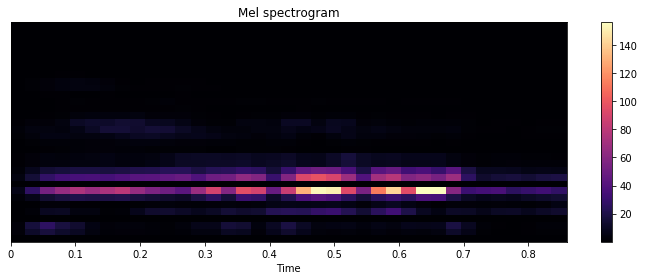

In [22]:
plt.figure(figsize=(10, 4))
lr.display.specshow(X_train_mel[1,...], x_axis='time')
plt.colorbar()
plt.title('Mel spectrogram')
plt.tight_layout()

In [23]:
X_train_mel = np.transpose(X_train_mel, (0,2,1))
X_test_mel = np.transpose(X_test_mel, (0,2,1))
print X_train_mel.shape, X_test_mel.shape

(8000, 37, 32) (2000, 37, 32)


In [24]:
for N_LAYERS in [1,2]:
    for N_UNITS in [64,90,128]:
        for REGUL in [0]:
            in_dim = X_train_mel.shape[1:]
            model = MLP(N_UNITS, N_LAYERS, REGUL, in_dim)
            out = test_model('MLP_mid', N_UNITS, N_LAYERS, REGUL, model, X_train_mel, X_test_mel)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_31 (InputLayer)           (None, 37, 32)       0                                            
__________________________________________________________________________________________________
flatten_7 (Flatten)             (None, 1184)         0           input_31[0][0]                   
__________________________________________________________________________________________________
dense_438 (Dense)               (None, 64)           75840       flatten_7[0][0]                  
__________________________________________________________________________________________________
flanger_on_off (Dense)          (None, 2)            130         dense_438[0][0]                  
__________________________________________________________________________________________________
delay_on_o

Setting 3972 elements to zero
flanger_intensity (8000,)
Setting 4014 elements to zero
delay_time (8000,)
Setting 4068 elements to zero
disto_drive (8000,)
Setting 3990 elements to zero
reverb_room_size (8000,)
reverb_on_off (8000, 2)
delay_on_off (8000, 2)
Setting 3972 elements to zero
flanger_width (8000,)
Setting 3972 elements to zero
flanger_rate (8000,)
Setting 4068 elements to zero
disto_tone (8000,)
filter_on_off (8000, 2)
Setting 4014 elements to zero
delay_feedback (8000,)
Setting 4014 elements to zero
delay_intensity (8000,)
flanger_on_off (8000, 2)
Setting 3990 elements to zero
reverb_bright (8000,)
Setting 3940 elements to zero
filter_resonance (8000,)
Setting 3972 elements to zero
flanger_mode (8000, 3)
disto_on_off (8000, 2)
Setting 3940 elements to zero
filter_mode_LBF_HPF (8000,)
Setting 3940 elements to zero
filter_frequency (8000,)
Setting 981 elements to zero
flanger_intensity (2000,)
Setting 1013 elements to zero
delay_time (2000,)
Setting 989 elements to zero
disto_

7200/7200 [==============================] - 4s 523us/step - loss: 7.0373 - flanger_intensity_loss: 0.4463 - delay_time_loss: 0.3157 - disto_drive_loss: 0.4441 - reverb_room_size_loss: 0.3188 - reverb_on_off_loss: 0.1306 - delay_on_off_loss: 0.2529 - flanger_width_loss: 0.4340 - flanger_rate_loss: 0.4676 - disto_tone_loss: 0.3305 - filter_on_off_loss: 0.3364 - delay_feedback_loss: 0.4139 - delay_intensity_loss: 0.4297 - flanger_on_off_loss: 0.5098 - reverb_bright_loss: 0.4536 - filter_resonance_loss: 0.4088 - flanger_mode_loss: 0.4463 - disto_on_off_loss: 0.1743 - filter_mode_LBF_HPF_loss: 0.3673 - filter_frequency_loss: 0.3569 - val_loss: 7.2743 - val_flanger_intensity_loss: 0.4490 - val_delay_time_loss: 0.3225 - val_disto_drive_loss: 0.4354 - val_reverb_room_size_loss: 0.3215 - val_reverb_on_off_loss: 0.1339 - val_delay_on_off_loss: 0.2154 - val_flanger_width_loss: 0.4565 - val_flanger_rate_loss: 0.4676 - val_disto_tone_loss: 0.3300 - val_filter_on_off_loss: 0.3210 - val_delay_feedba

7200/7200 [==============================] - 5s 656us/step - loss: 6.3980 - flanger_intensity_loss: 0.4216 - delay_time_loss: 0.2909 - disto_drive_loss: 0.4146 - reverb_room_size_loss: 0.2919 - reverb_on_off_loss: 0.1043 - delay_on_off_loss: 0.2127 - flanger_width_loss: 0.3980 - flanger_rate_loss: 0.4369 - disto_tone_loss: 0.3042 - filter_on_off_loss: 0.2478 - delay_feedback_loss: 0.3925 - delay_intensity_loss: 0.4058 - flanger_on_off_loss: 0.4495 - reverb_bright_loss: 0.4460 - filter_resonance_loss: 0.3855 - flanger_mode_loss: 0.3999 - disto_on_off_loss: 0.1376 - filter_mode_LBF_HPF_loss: 0.3312 - filter_frequency_loss: 0.3268 - val_loss: 6.9492 - val_flanger_intensity_loss: 0.4634 - val_delay_time_loss: 0.3163 - val_disto_drive_loss: 0.3960 - val_reverb_room_size_loss: 0.3192 - val_reverb_on_off_loss: 0.1543 - val_delay_on_off_loss: 0.2194 - val_flanger_width_loss: 0.4437 - val_flanger_rate_loss: 0.4805 - val_disto_tone_loss: 0.3110 - val_filter_on_off_loss: 0.3380 - val_delay_feedba

Keeping 987 training examples out of 2000
(987, 1) (987,)
('MLP_mid', 'joint', 64, 1, 0, 'delay_intensity', 'reg', -6.8718798637390135, 2.4252912732560223)
Output: 12
flanger_on_off
(2000, 2)
('MLP_mid', 'joint', 64, 1, 0, 'flanger_on_off', 'class', -6.8718798637390135, 0.71999999999999997)
Output: 13
reverb_bright
(2000, 1)
Keeping 1003 training examples out of 2000
(1003, 1) (1003,)
('MLP_mid', 'joint', 64, 1, 0, 'reverb_bright', 'reg', -6.8718798637390135, 2.5850552972625231)
Output: 14
filter_resonance
(2000, 1)
Keeping 998 training examples out of 2000
(998, 1) (998,)
('MLP_mid', 'joint', 64, 1, 0, 'filter_resonance', 'reg', -6.8718798637390135, 2.1197977050294168)
Output: 15
flanger_mode
(2000, 3)
Keeping 1019 training examples out of 2000
(1019, 3) (1019,)
('MLP_mid', 'joint', 64, 1, 0, 'flanger_mode', 'class', -6.8718798637390135, 0.63788027477919529)
Output: 16
disto_on_off
(2000, 2)
('MLP_mid', 'joint', 64, 1, 0, 'disto_on_off', 'class', -6.8718798637390135, 0.963999999999999

Setting 3972 elements to zero
flanger_intensity (8000,)
Setting 4014 elements to zero
delay_time (8000,)
Setting 4068 elements to zero
disto_drive (8000,)
Setting 3990 elements to zero
reverb_room_size (8000,)
reverb_on_off (8000, 2)
delay_on_off (8000, 2)
Setting 3972 elements to zero
flanger_width (8000,)
Setting 3972 elements to zero
flanger_rate (8000,)
Setting 4068 elements to zero
disto_tone (8000,)
filter_on_off (8000, 2)
Setting 4014 elements to zero
delay_feedback (8000,)
Setting 4014 elements to zero
delay_intensity (8000,)
flanger_on_off (8000, 2)
Setting 3990 elements to zero
reverb_bright (8000,)
Setting 3940 elements to zero
filter_resonance (8000,)
Setting 3972 elements to zero
flanger_mode (8000, 3)
disto_on_off (8000, 2)
Setting 3940 elements to zero
filter_mode_LBF_HPF (8000,)
Setting 3940 elements to zero
filter_frequency (8000,)
Setting 981 elements to zero
flanger_intensity (2000,)
Setting 1013 elements to zero
delay_time (2000,)
Setting 989 elements to zero
disto_

Setting 3972 elements to zero
flanger_intensity (8000,)
Setting 4014 elements to zero
delay_time (8000,)
Setting 4068 elements to zero
disto_drive (8000,)
Setting 3990 elements to zero
reverb_room_size (8000,)
reverb_on_off (8000, 2)
delay_on_off (8000, 2)
Setting 3972 elements to zero
flanger_width (8000,)
Setting 3972 elements to zero
flanger_rate (8000,)
Setting 4068 elements to zero
disto_tone (8000,)
filter_on_off (8000, 2)
Setting 4014 elements to zero
delay_feedback (8000,)
Setting 4014 elements to zero
delay_intensity (8000,)
flanger_on_off (8000, 2)
Setting 3990 elements to zero
reverb_bright (8000,)
Setting 3940 elements to zero
filter_resonance (8000,)
Setting 3972 elements to zero
flanger_mode (8000, 3)
disto_on_off (8000, 2)
Setting 3940 elements to zero
filter_mode_LBF_HPF (8000,)
Setting 3940 elements to zero
filter_frequency (8000,)
Setting 981 elements to zero
flanger_intensity (2000,)
Setting 1013 elements to zero
delay_time (2000,)
Setting 989 elements to zero
disto_

2000/2000 [==============================] - 5s 3ms/step
Output: 0
flanger_intensity
(2000, 1)
Keeping 1019 training examples out of 2000
(1019, 1) (1019,)
Unexpected error: <type 'exceptions.ValueError'>
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_34 (InputLayer)           (None, 37, 32)       0                                            
__________________________________________________________________________________________________
flatten_10 (Flatten)            (None, 1184)         0           input_34[0][0]                   
__________________________________________________________________________________________________
dense_483 (Dense)               (None, 64)           75840       flatten_10[0][0]                 
__________________________________________________________________________________________________
den

Setting 3972 elements to zero
flanger_intensity (8000,)
Setting 4014 elements to zero
delay_time (8000,)
Setting 4068 elements to zero
disto_drive (8000,)
Setting 3990 elements to zero
reverb_room_size (8000,)
reverb_on_off (8000, 2)
delay_on_off (8000, 2)
Setting 3972 elements to zero
flanger_width (8000,)
Setting 3972 elements to zero
flanger_rate (8000,)
Setting 4068 elements to zero
disto_tone (8000,)
filter_on_off (8000, 2)
Setting 4014 elements to zero
delay_feedback (8000,)
Setting 4014 elements to zero
delay_intensity (8000,)
flanger_on_off (8000, 2)
Setting 3990 elements to zero
reverb_bright (8000,)
Setting 3940 elements to zero
filter_resonance (8000,)
Setting 3972 elements to zero
flanger_mode (8000, 3)
disto_on_off (8000, 2)
Setting 3940 elements to zero
filter_mode_LBF_HPF (8000,)
Setting 3940 elements to zero
filter_frequency (8000,)
Setting 981 elements to zero
flanger_intensity (2000,)
Setting 1013 elements to zero
delay_time (2000,)
Setting 989 elements to zero
disto_

Epoch 6/30
7200/7200 [==============================] - 3s 429us/step - loss: 6.5788 - flanger_intensity_loss: 0.4311 - delay_time_loss: 0.3000 - disto_drive_loss: 0.4301 - reverb_room_size_loss: 0.2924 - reverb_on_off_loss: 0.1078 - delay_on_off_loss: 0.2227 - flanger_width_loss: 0.4182 - flanger_rate_loss: 0.4460 - disto_tone_loss: 0.3027 - filter_on_off_loss: 0.2491 - delay_feedback_loss: 0.4110 - delay_intensity_loss: 0.4255 - flanger_on_off_loss: 0.4718 - reverb_bright_loss: 0.4446 - filter_resonance_loss: 0.3830 - flanger_mode_loss: 0.4443 - disto_on_off_loss: 0.1451 - filter_mode_LBF_HPF_loss: 0.3292 - filter_frequency_loss: 0.3241 - val_loss: 6.8412 - val_flanger_intensity_loss: 0.4470 - val_delay_time_loss: 0.3189 - val_disto_drive_loss: 0.4126 - val_reverb_room_size_loss: 0.3047 - val_reverb_on_off_loss: 0.0996 - val_delay_on_off_loss: 0.2225 - val_flanger_width_loss: 0.4513 - val_flanger_rate_loss: 0.4681 - val_disto_tone_loss: 0.2986 - val_filter_on_off_loss: 0.2567 - val_d

7200/7200 [==============================] - 3s 417us/step - loss: 5.9210 - flanger_intensity_loss: 0.4076 - delay_time_loss: 0.2643 - disto_drive_loss: 0.4164 - reverb_room_size_loss: 0.2820 - reverb_on_off_loss: 0.0850 - delay_on_off_loss: 0.1658 - flanger_width_loss: 0.3915 - flanger_rate_loss: 0.4190 - disto_tone_loss: 0.2733 - filter_on_off_loss: 0.1742 - delay_feedback_loss: 0.3813 - delay_intensity_loss: 0.3951 - flanger_on_off_loss: 0.4060 - reverb_bright_loss: 0.4350 - filter_resonance_loss: 0.3506 - flanger_mode_loss: 0.3878 - disto_on_off_loss: 0.0981 - filter_mode_LBF_HPF_loss: 0.2968 - filter_frequency_loss: 0.2911 - val_loss: 6.3726 - val_flanger_intensity_loss: 0.4499 - val_delay_time_loss: 0.2832 - val_disto_drive_loss: 0.4092 - val_reverb_room_size_loss: 0.2919 - val_reverb_on_off_loss: 0.0911 - val_delay_on_off_loss: 0.1870 - val_flanger_width_loss: 0.4242 - val_flanger_rate_loss: 0.4624 - val_disto_tone_loss: 0.2605 - val_filter_on_off_loss: 0.2022 - val_delay_feedba

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_35 (InputLayer)           (None, 37, 32)       0                                            
__________________________________________________________________________________________________
flatten_11 (Flatten)            (None, 1184)         0           input_35[0][0]                   
__________________________________________________________________________________________________
dense_499 (Dense)               (None, 90)           106650      flatten_11[0][0]                 
__________________________________________________________________________________________________
dense_500 (Dense)               (None, 90)           8190        dense_499[0][0]                  
__________________________________________________________________________________________________
flanger_on

Setting 3972 elements to zero
flanger_intensity (8000,)
Setting 4014 elements to zero
delay_time (8000,)
Setting 4068 elements to zero
disto_drive (8000,)
Setting 3990 elements to zero
reverb_room_size (8000,)
reverb_on_off (8000, 2)
delay_on_off (8000, 2)
Setting 3972 elements to zero
flanger_width (8000,)
Setting 3972 elements to zero
flanger_rate (8000,)
Setting 4068 elements to zero
disto_tone (8000,)
filter_on_off (8000, 2)
Setting 4014 elements to zero
delay_feedback (8000,)
Setting 4014 elements to zero
delay_intensity (8000,)
flanger_on_off (8000, 2)
Setting 3990 elements to zero
reverb_bright (8000,)
Setting 3940 elements to zero
filter_resonance (8000,)
Setting 3972 elements to zero
flanger_mode (8000, 3)
disto_on_off (8000, 2)
Setting 3940 elements to zero
filter_mode_LBF_HPF (8000,)
Setting 3940 elements to zero
filter_frequency (8000,)
Setting 981 elements to zero
flanger_intensity (2000,)
Setting 1013 elements to zero
delay_time (2000,)
Setting 989 elements to zero
disto_

Epoch 6/30
7200/7200 [==============================] - 3s 481us/step - loss: 6.5416 - flanger_intensity_loss: 0.4277 - delay_time_loss: 0.3042 - disto_drive_loss: 0.4268 - reverb_room_size_loss: 0.2963 - reverb_on_off_loss: 0.1067 - delay_on_off_loss: 0.2087 - flanger_width_loss: 0.4216 - flanger_rate_loss: 0.4426 - disto_tone_loss: 0.2947 - filter_on_off_loss: 0.2468 - delay_feedback_loss: 0.4087 - delay_intensity_loss: 0.4202 - flanger_on_off_loss: 0.4712 - reverb_bright_loss: 0.4502 - filter_resonance_loss: 0.3892 - flanger_mode_loss: 0.4282 - disto_on_off_loss: 0.1442 - filter_mode_LBF_HPF_loss: 0.3269 - filter_frequency_loss: 0.3266 - val_loss: 6.8742 - val_flanger_intensity_loss: 0.4420 - val_delay_time_loss: 0.3126 - val_disto_drive_loss: 0.3983 - val_reverb_room_size_loss: 0.3002 - val_reverb_on_off_loss: 0.0929 - val_delay_on_off_loss: 0.2539 - val_flanger_width_loss: 0.4301 - val_flanger_rate_loss: 0.4646 - val_disto_tone_loss: 0.2878 - val_filter_on_off_loss: 0.2900 - val_d

7200/7200 [==============================] - 4s 547us/step - loss: 5.8083 - flanger_intensity_loss: 0.4027 - delay_time_loss: 0.2647 - disto_drive_loss: 0.4002 - reverb_room_size_loss: 0.2650 - reverb_on_off_loss: 0.0823 - delay_on_off_loss: 0.1691 - flanger_width_loss: 0.3834 - flanger_rate_loss: 0.4176 - disto_tone_loss: 0.2657 - filter_on_off_loss: 0.1668 - delay_feedback_loss: 0.3699 - delay_intensity_loss: 0.3939 - flanger_on_off_loss: 0.3971 - reverb_bright_loss: 0.4367 - filter_resonance_loss: 0.3442 - flanger_mode_loss: 0.3717 - disto_on_off_loss: 0.1010 - filter_mode_LBF_HPF_loss: 0.2884 - filter_frequency_loss: 0.2878 - val_loss: 6.2626 - val_flanger_intensity_loss: 0.4185 - val_delay_time_loss: 0.2707 - val_disto_drive_loss: 0.3870 - val_reverb_room_size_loss: 0.2753 - val_reverb_on_off_loss: 0.0788 - val_delay_on_off_loss: 0.1571 - val_flanger_width_loss: 0.4142 - val_flanger_rate_loss: 0.4438 - val_disto_tone_loss: 0.3030 - val_filter_on_off_loss: 0.2187 - val_delay_feedba

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_36 (InputLayer)           (None, 37, 32)       0                                            
__________________________________________________________________________________________________
flatten_12 (Flatten)            (None, 1184)         0           input_36[0][0]                   
__________________________________________________________________________________________________
dense_515 (Dense)               (None, 128)          151680      flatten_12[0][0]                 
__________________________________________________________________________________________________
dense_516 (Dense)               (None, 128)          16512       dense_515[0][0]                  
__________________________________________________________________________________________________
flanger_on

Setting 3972 elements to zero
flanger_intensity (8000,)
Setting 4014 elements to zero
delay_time (8000,)
Setting 4068 elements to zero
disto_drive (8000,)
Setting 3990 elements to zero
reverb_room_size (8000,)
reverb_on_off (8000, 2)
delay_on_off (8000, 2)
Setting 3972 elements to zero
flanger_width (8000,)
Setting 3972 elements to zero
flanger_rate (8000,)
Setting 4068 elements to zero
disto_tone (8000,)
filter_on_off (8000, 2)
Setting 4014 elements to zero
delay_feedback (8000,)
Setting 4014 elements to zero
delay_intensity (8000,)
flanger_on_off (8000, 2)
Setting 3990 elements to zero
reverb_bright (8000,)
Setting 3940 elements to zero
filter_resonance (8000,)
Setting 3972 elements to zero
flanger_mode (8000, 3)
disto_on_off (8000, 2)
Setting 3940 elements to zero
filter_mode_LBF_HPF (8000,)
Setting 3940 elements to zero
filter_frequency (8000,)
Setting 981 elements to zero
flanger_intensity (2000,)
Setting 1013 elements to zero
delay_time (2000,)
Setting 989 elements to zero
disto_

Epoch 6/30
7200/7200 [==============================] - 4s 521us/step - loss: 6.4267 - flanger_intensity_loss: 0.4345 - delay_time_loss: 0.2915 - disto_drive_loss: 0.4224 - reverb_room_size_loss: 0.2983 - reverb_on_off_loss: 0.1050 - delay_on_off_loss: 0.2232 - flanger_width_loss: 0.4132 - flanger_rate_loss: 0.4412 - disto_tone_loss: 0.2980 - filter_on_off_loss: 0.2272 - delay_feedback_loss: 0.3979 - delay_intensity_loss: 0.4141 - flanger_on_off_loss: 0.4522 - reverb_bright_loss: 0.4493 - filter_resonance_loss: 0.3796 - flanger_mode_loss: 0.4177 - disto_on_off_loss: 0.1257 - filter_mode_LBF_HPF_loss: 0.3223 - filter_frequency_loss: 0.3134 - val_loss: 6.6785 - val_flanger_intensity_loss: 0.4519 - val_delay_time_loss: 0.2956 - val_disto_drive_loss: 0.4065 - val_reverb_room_size_loss: 0.2912 - val_reverb_on_off_loss: 0.1093 - val_delay_on_off_loss: 0.2076 - val_flanger_width_loss: 0.4203 - val_flanger_rate_loss: 0.4738 - val_disto_tone_loss: 0.2797 - val_filter_on_off_loss: 0.3700 - val_d

7200/7200 [==============================] - 4s 514us/step - loss: 5.7684 - flanger_intensity_loss: 0.4045 - delay_time_loss: 0.2595 - disto_drive_loss: 0.4027 - reverb_room_size_loss: 0.2658 - reverb_on_off_loss: 0.0787 - delay_on_off_loss: 0.1691 - flanger_width_loss: 0.3862 - flanger_rate_loss: 0.4187 - disto_tone_loss: 0.2751 - filter_on_off_loss: 0.1700 - delay_feedback_loss: 0.3735 - delay_intensity_loss: 0.3877 - flanger_on_off_loss: 0.3818 - reverb_bright_loss: 0.4333 - filter_resonance_loss: 0.3417 - flanger_mode_loss: 0.3663 - disto_on_off_loss: 0.0877 - filter_mode_LBF_HPF_loss: 0.2852 - filter_frequency_loss: 0.2808 - val_loss: 6.2824 - val_flanger_intensity_loss: 0.4194 - val_delay_time_loss: 0.2951 - val_disto_drive_loss: 0.3927 - val_reverb_room_size_loss: 0.3113 - val_reverb_on_off_loss: 0.1185 - val_delay_on_off_loss: 0.1803 - val_flanger_width_loss: 0.4212 - val_flanger_rate_loss: 0.4603 - val_disto_tone_loss: 0.2705 - val_filter_on_off_loss: 0.1941 - val_delay_feedba

Output: 7
flanger_rate
(2000, 1)
Keeping 1019 training examples out of 2000
(1019, 1) (1019,)
('MLP_mid', 'joint', 128, 2, 0, 'flanger_rate', 'reg', -6.1672796440124511, 2.3829657425250135)
Output: 8
disto_tone
(2000, 1)
Keeping 1011 training examples out of 2000
(1011, 1) (1011,)
('MLP_mid', 'joint', 128, 2, 0, 'disto_tone', 'reg', -6.1672796440124511, 1.3738772405221724)
Output: 9
filter_on_off
(2000, 2)
('MLP_mid', 'joint', 128, 2, 0, 'filter_on_off', 'class', -6.1672796440124511, 0.93799999999999994)
Output: 10
delay_feedback
(2000, 1)
Keeping 987 training examples out of 2000
(987, 1) (987,)
('MLP_mid', 'joint', 128, 2, 0, 'delay_feedback', 'reg', -6.1672796440124511, 2.3528172353004115)
Output: 11
delay_intensity
(2000, 1)
Keeping 987 training examples out of 2000
(987, 1) (987,)
('MLP_mid', 'joint', 128, 2, 0, 'delay_intensity', 'reg', -6.1672796440124511, 2.2882405795613701)
Output: 12
flanger_on_off
(2000, 2)
('MLP_mid', 'joint', 128, 2, 0, 'flanger_on_off', 'class', -6.167279

In [25]:
for N_LAYERS in [1,2]:
    for N_UNITS in [32,64,80,128]:
        for REGUL in [0,0.2]:
            in_dim = X_train_mel.shape[1:]
            model = modLSTM(N_UNITS, N_LAYERS, REGUL, in_dim)
            out = test_model('LSTM_mid', N_UNITS, N_LAYERS, REGUL, model, X_train_mel, X_test_mel)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_37 (InputLayer)           (None, 37, 32)       0                                            
__________________________________________________________________________________________________
lstm_25 (LSTM)                  (None, 32)           8320        input_37[0][0]                   
__________________________________________________________________________________________________
flanger_on_off (Dense)          (None, 2)            66          lstm_25[0][0]                    
__________________________________________________________________________________________________
delay_on_off (Dense)            (None, 2)            66          lstm_25[0][0]                    
__________________________________________________________________________________________________
disto_on_o

Setting 3972 elements to zero
flanger_intensity (8000,)
Setting 4014 elements to zero
delay_time (8000,)
Setting 4068 elements to zero
disto_drive (8000,)
Setting 3990 elements to zero
reverb_room_size (8000,)
reverb_on_off (8000, 2)
delay_on_off (8000, 2)
Setting 3972 elements to zero
flanger_width (8000,)
Setting 3972 elements to zero
flanger_rate (8000,)
Setting 4068 elements to zero
disto_tone (8000,)
filter_on_off (8000, 2)
Setting 4014 elements to zero
delay_feedback (8000,)
Setting 4014 elements to zero
delay_intensity (8000,)
flanger_on_off (8000, 2)
Setting 3990 elements to zero
reverb_bright (8000,)
Setting 3940 elements to zero
filter_resonance (8000,)
Setting 3972 elements to zero
flanger_mode (8000, 3)
disto_on_off (8000, 2)
Setting 3940 elements to zero
filter_mode_LBF_HPF (8000,)
Setting 3940 elements to zero
filter_frequency (8000,)
Setting 981 elements to zero
flanger_intensity (2000,)
Setting 1013 elements to zero
delay_time (2000,)
Setting 989 elements to zero
disto_

Epoch 6/30
7200/7200 [==============================] - 10s 1ms/step - loss: 7.3604 - flanger_intensity_loss: 0.4343 - delay_time_loss: 0.3552 - disto_drive_loss: 0.4333 - reverb_room_size_loss: 0.3400 - reverb_on_off_loss: 0.1596 - delay_on_off_loss: 0.3586 - flanger_width_loss: 0.4329 - flanger_rate_loss: 0.4415 - disto_tone_loss: 0.3280 - filter_on_off_loss: 0.3788 - delay_feedback_loss: 0.4109 - delay_intensity_loss: 0.4374 - flanger_on_off_loss: 0.5403 - reverb_bright_loss: 0.4454 - filter_resonance_loss: 0.4301 - flanger_mode_loss: 0.4931 - disto_on_off_loss: 0.2015 - filter_mode_LBF_HPF_loss: 0.3805 - filter_frequency_loss: 0.3589 - val_loss: 7.3301 - val_flanger_intensity_loss: 0.4294 - val_delay_time_loss: 0.3603 - val_disto_drive_loss: 0.4199 - val_reverb_room_size_loss: 0.3387 - val_reverb_on_off_loss: 0.1326 - val_delay_on_off_loss: 0.3808 - val_flanger_width_loss: 0.4414 - val_flanger_rate_loss: 0.4563 - val_disto_tone_loss: 0.3203 - val_filter_on_off_loss: 0.3491 - val_de

7200/7200 [==============================] - 13s 2ms/step - loss: 6.7722 - flanger_intensity_loss: 0.4270 - delay_time_loss: 0.3373 - disto_drive_loss: 0.4317 - reverb_room_size_loss: 0.3156 - reverb_on_off_loss: 0.1164 - delay_on_off_loss: 0.2823 - flanger_width_loss: 0.4230 - flanger_rate_loss: 0.4364 - disto_tone_loss: 0.2870 - filter_on_off_loss: 0.2670 - delay_feedback_loss: 0.3985 - delay_intensity_loss: 0.4265 - flanger_on_off_loss: 0.4805 - reverb_bright_loss: 0.4427 - filter_resonance_loss: 0.4106 - flanger_mode_loss: 0.4665 - disto_on_off_loss: 0.1667 - filter_mode_LBF_HPF_loss: 0.3425 - filter_frequency_loss: 0.3139 - val_loss: 7.0814 - val_flanger_intensity_loss: 0.4247 - val_delay_time_loss: 0.3542 - val_disto_drive_loss: 0.4225 - val_reverb_room_size_loss: 0.3335 - val_reverb_on_off_loss: 0.2232 - val_delay_on_off_loss: 0.3266 - val_flanger_width_loss: 0.4327 - val_flanger_rate_loss: 0.4500 - val_disto_tone_loss: 0.3040 - val_filter_on_off_loss: 0.2726 - val_delay_feedbac

Epoch 18/30
7200/7200 [==============================] - 12s 2ms/step - loss: 6.4903 - flanger_intensity_loss: 0.4230 - delay_time_loss: 0.3277 - disto_drive_loss: 0.4306 - reverb_room_size_loss: 0.3041 - reverb_on_off_loss: 0.0953 - delay_on_off_loss: 0.2463 - flanger_width_loss: 0.4166 - flanger_rate_loss: 0.4328 - disto_tone_loss: 0.2742 - filter_on_off_loss: 0.2223 - delay_feedback_loss: 0.3914 - delay_intensity_loss: 0.4193 - flanger_on_off_loss: 0.4543 - reverb_bright_loss: 0.4412 - filter_resonance_loss: 0.3934 - flanger_mode_loss: 0.4503 - disto_on_off_loss: 0.1500 - filter_mode_LBF_HPF_loss: 0.3250 - filter_frequency_loss: 0.2925 - val_loss: 6.7570 - val_flanger_intensity_loss: 0.4198 - val_delay_time_loss: 0.3456 - val_disto_drive_loss: 0.4192 - val_reverb_room_size_loss: 0.3180 - val_reverb_on_off_loss: 0.1087 - val_delay_on_off_loss: 0.2950 - val_flanger_width_loss: 0.4290 - val_flanger_rate_loss: 0.4470 - val_disto_tone_loss: 0.2843 - val_filter_on_off_loss: 0.2453 - val_d

Epoch 24/30
7200/7200 [==============================] - 9s 1ms/step - loss: 6.2547 - flanger_intensity_loss: 0.4193 - delay_time_loss: 0.3201 - disto_drive_loss: 0.4289 - reverb_room_size_loss: 0.2950 - reverb_on_off_loss: 0.0849 - delay_on_off_loss: 0.2239 - flanger_width_loss: 0.4113 - flanger_rate_loss: 0.4314 - disto_tone_loss: 0.2628 - filter_on_off_loss: 0.1977 - delay_feedback_loss: 0.3861 - delay_intensity_loss: 0.4130 - flanger_on_off_loss: 0.4183 - reverb_bright_loss: 0.4404 - filter_resonance_loss: 0.3776 - flanger_mode_loss: 0.4275 - disto_on_off_loss: 0.1346 - filter_mode_LBF_HPF_loss: 0.3079 - filter_frequency_loss: 0.2741 - val_loss: 6.4628 - val_flanger_intensity_loss: 0.4218 - val_delay_time_loss: 0.3343 - val_disto_drive_loss: 0.4164 - val_reverb_room_size_loss: 0.3112 - val_reverb_on_off_loss: 0.0970 - val_delay_on_off_loss: 0.2628 - val_flanger_width_loss: 0.4252 - val_flanger_rate_loss: 0.4429 - val_disto_tone_loss: 0.2617 - val_filter_on_off_loss: 0.1943 - val_de

2000/2000 [==============================] - 13s 6ms/step
Output: 0
flanger_intensity
(2000, 1)
Keeping 1019 training examples out of 2000
(1019, 1) (1019,)
('LSTM_mid', 'joint', 32, 1, 0, 'flanger_intensity', 'reg', -6.4156535148620604, 2.348841850825663)
Output: 1
delay_time
(2000, 1)
Keeping 987 training examples out of 2000
(987, 1) (987,)
('LSTM_mid', 'joint', 32, 1, 0, 'delay_time', 'reg', -6.4156535148620604, 0.88467704929086199)
Output: 2
disto_drive
(2000, 1)
Keeping 1011 training examples out of 2000
(1011, 1) (1011,)
('LSTM_mid', 'joint', 32, 1, 0, 'disto_drive', 'reg', -6.4156535148620604, 2.5592832092060838)
Output: 3
reverb_room_size
(2000, 1)
Keeping 1003 training examples out of 2000
(1003, 1) (1003,)
('LSTM_mid', 'joint', 32, 1, 0, 'reverb_room_size', 'reg', -6.4156535148620604, 1.586351094292592)
Output: 4
reverb_on_off
(2000, 2)
('LSTM_mid', 'joint', 32, 1, 0, 'reverb_on_off', 'class', -6.4156535148620604, 0.97499999999999998)
Output: 5
delay_on_off
(2000, 2)
('LSTM_

Setting 3972 elements to zero
flanger_intensity (8000,)
Setting 4014 elements to zero
delay_time (8000,)
Setting 4068 elements to zero
disto_drive (8000,)
Setting 3990 elements to zero
reverb_room_size (8000,)
reverb_on_off (8000, 2)
delay_on_off (8000, 2)
Setting 3972 elements to zero
flanger_width (8000,)
Setting 3972 elements to zero
flanger_rate (8000,)
Setting 4068 elements to zero
disto_tone (8000,)
filter_on_off (8000, 2)
Setting 4014 elements to zero
delay_feedback (8000,)
Setting 4014 elements to zero
delay_intensity (8000,)
flanger_on_off (8000, 2)
Setting 3990 elements to zero
reverb_bright (8000,)
Setting 3940 elements to zero
filter_resonance (8000,)
Setting 3972 elements to zero
flanger_mode (8000, 3)
disto_on_off (8000, 2)
Setting 3940 elements to zero
filter_mode_LBF_HPF (8000,)
Setting 3940 elements to zero
filter_frequency (8000,)
Setting 981 elements to zero
flanger_intensity (2000,)
Setting 1013 elements to zero
delay_time (2000,)
Setting 989 elements to zero
disto_

Epoch 6/30
7200/7200 [==============================] - 9s 1ms/step - loss: 7.9054 - flanger_intensity_loss: 0.4428 - delay_time_loss: 0.3603 - disto_drive_loss: 0.4350 - reverb_room_size_loss: 0.3586 - reverb_on_off_loss: 0.2509 - delay_on_off_loss: 0.3924 - flanger_width_loss: 0.4422 - flanger_rate_loss: 0.4436 - disto_tone_loss: 0.3818 - filter_on_off_loss: 0.4666 - delay_feedback_loss: 0.4205 - delay_intensity_loss: 0.4369 - flanger_on_off_loss: 0.6142 - reverb_bright_loss: 0.4446 - filter_resonance_loss: 0.4343 - flanger_mode_loss: 0.5235 - disto_on_off_loss: 0.2600 - filter_mode_LBF_HPF_loss: 0.4068 - filter_frequency_loss: 0.3903 - val_loss: 7.6936 - val_flanger_intensity_loss: 0.4379 - val_delay_time_loss: 0.3568 - val_disto_drive_loss: 0.4231 - val_reverb_room_size_loss: 0.3405 - val_reverb_on_off_loss: 0.2102 - val_delay_on_off_loss: 0.3696 - val_flanger_width_loss: 0.4429 - val_flanger_rate_loss: 0.4528 - val_disto_tone_loss: 0.3701 - val_filter_on_off_loss: 0.4374 - val_del

7200/7200 [==============================] - 9s 1ms/step - loss: 7.4240 - flanger_intensity_loss: 0.4359 - delay_time_loss: 0.3353 - disto_drive_loss: 0.4320 - reverb_room_size_loss: 0.3356 - reverb_on_off_loss: 0.1870 - delay_on_off_loss: 0.3192 - flanger_width_loss: 0.4379 - flanger_rate_loss: 0.4390 - disto_tone_loss: 0.3487 - filter_on_off_loss: 0.3877 - delay_feedback_loss: 0.4104 - delay_intensity_loss: 0.4333 - flanger_on_off_loss: 0.5802 - reverb_bright_loss: 0.4439 - filter_resonance_loss: 0.4216 - flanger_mode_loss: 0.5033 - disto_on_off_loss: 0.2275 - filter_mode_LBF_HPF_loss: 0.3834 - filter_frequency_loss: 0.3622 - val_loss: 7.2286 - val_flanger_intensity_loss: 0.4300 - val_delay_time_loss: 0.3269 - val_disto_drive_loss: 0.4213 - val_reverb_room_size_loss: 0.3175 - val_reverb_on_off_loss: 0.1602 - val_delay_on_off_loss: 0.2847 - val_flanger_width_loss: 0.4404 - val_flanger_rate_loss: 0.4498 - val_disto_tone_loss: 0.3474 - val_filter_on_off_loss: 0.3540 - val_delay_feedback

7200/7200 [==============================] - 9s 1ms/step - loss: 7.1317 - flanger_intensity_loss: 0.4342 - delay_time_loss: 0.3205 - disto_drive_loss: 0.4310 - reverb_room_size_loss: 0.3154 - reverb_on_off_loss: 0.1581 - delay_on_off_loss: 0.2802 - flanger_width_loss: 0.4376 - flanger_rate_loss: 0.4374 - disto_tone_loss: 0.3311 - filter_on_off_loss: 0.3311 - delay_feedback_loss: 0.4012 - delay_intensity_loss: 0.4307 - flanger_on_off_loss: 0.5577 - reverb_bright_loss: 0.4423 - filter_resonance_loss: 0.4138 - flanger_mode_loss: 0.4940 - disto_on_off_loss: 0.2045 - filter_mode_LBF_HPF_loss: 0.3636 - filter_frequency_loss: 0.3472 - val_loss: 6.9618 - val_flanger_intensity_loss: 0.4289 - val_delay_time_loss: 0.3113 - val_disto_drive_loss: 0.4177 - val_reverb_room_size_loss: 0.3047 - val_reverb_on_off_loss: 0.1326 - val_delay_on_off_loss: 0.2491 - val_flanger_width_loss: 0.4414 - val_flanger_rate_loss: 0.4494 - val_disto_tone_loss: 0.3107 - val_filter_on_off_loss: 0.3052 - val_delay_feedback

7200/7200 [==============================] - 9s 1ms/step - loss: 6.9445 - flanger_intensity_loss: 0.4319 - delay_time_loss: 0.3123 - disto_drive_loss: 0.4300 - reverb_room_size_loss: 0.3019 - reverb_on_off_loss: 0.1387 - delay_on_off_loss: 0.2569 - flanger_width_loss: 0.4365 - flanger_rate_loss: 0.4366 - disto_tone_loss: 0.3234 - filter_on_off_loss: 0.2996 - delay_feedback_loss: 0.3962 - delay_intensity_loss: 0.4245 - flanger_on_off_loss: 0.5389 - reverb_bright_loss: 0.4410 - filter_resonance_loss: 0.4076 - flanger_mode_loss: 0.4860 - disto_on_off_loss: 0.1900 - filter_mode_LBF_HPF_loss: 0.3524 - filter_frequency_loss: 0.3400 - val_loss: 6.8704 - val_flanger_intensity_loss: 0.4257 - val_delay_time_loss: 0.3027 - val_disto_drive_loss: 0.4156 - val_reverb_room_size_loss: 0.2995 - val_reverb_on_off_loss: 0.1236 - val_delay_on_off_loss: 0.2426 - val_flanger_width_loss: 0.4413 - val_flanger_rate_loss: 0.4483 - val_disto_tone_loss: 0.3131 - val_filter_on_off_loss: 0.2837 - val_delay_feedback

2000/2000 [==============================] - 9s 4ms/step
Output: 0
flanger_intensity
(2000, 1)
Keeping 1019 training examples out of 2000
(1019, 1) (1019,)
('LSTM_mid', 'joint', 32, 1, 0.2, 'flanger_intensity', 'reg', -6.7449763870239261, 2.4012174716160195)
Output: 1
delay_time
(2000, 1)
Keeping 987 training examples out of 2000
(987, 1) (987,)
('LSTM_mid', 'joint', 32, 1, 0.2, 'delay_time', 'reg', -6.7449763870239261, 0.82140928057337215)
Output: 2
disto_drive
(2000, 1)
Keeping 1011 training examples out of 2000
(1011, 1) (1011,)
('LSTM_mid', 'joint', 32, 1, 0.2, 'disto_drive', 'reg', -6.7449763870239261, 2.5484335361218839)
Output: 3
reverb_room_size
(2000, 1)
Keeping 1003 training examples out of 2000
(1003, 1) (1003,)
('LSTM_mid', 'joint', 32, 1, 0.2, 'reverb_room_size', 'reg', -6.7449763870239261, 1.5576589792532987)
Output: 4
reverb_on_off
(2000, 2)
('LSTM_mid', 'joint', 32, 1, 0.2, 'reverb_on_off', 'class', -6.7449763870239261, 0.96299999999999997)
Output: 5
delay_on_off
(2000,

Setting 3972 elements to zero
flanger_intensity (8000,)
Setting 4014 elements to zero
delay_time (8000,)
Setting 4068 elements to zero
disto_drive (8000,)
Setting 3990 elements to zero
reverb_room_size (8000,)
reverb_on_off (8000, 2)
delay_on_off (8000, 2)
Setting 3972 elements to zero
flanger_width (8000,)
Setting 3972 elements to zero
flanger_rate (8000,)
Setting 4068 elements to zero
disto_tone (8000,)
filter_on_off (8000, 2)
Setting 4014 elements to zero
delay_feedback (8000,)
Setting 4014 elements to zero
delay_intensity (8000,)
flanger_on_off (8000, 2)
Setting 3990 elements to zero
reverb_bright (8000,)
Setting 3940 elements to zero
filter_resonance (8000,)
Setting 3972 elements to zero
flanger_mode (8000, 3)
disto_on_off (8000, 2)
Setting 3940 elements to zero
filter_mode_LBF_HPF (8000,)
Setting 3940 elements to zero
filter_frequency (8000,)
Setting 981 elements to zero
flanger_intensity (2000,)
Setting 1013 elements to zero
delay_time (2000,)
Setting 989 elements to zero
disto_

Epoch 6/30
7200/7200 [==============================] - 10s 1ms/step - loss: 6.8220 - flanger_intensity_loss: 0.4231 - delay_time_loss: 0.3252 - disto_drive_loss: 0.4331 - reverb_room_size_loss: 0.3281 - reverb_on_off_loss: 0.1361 - delay_on_off_loss: 0.3098 - flanger_width_loss: 0.4044 - flanger_rate_loss: 0.4309 - disto_tone_loss: 0.2983 - filter_on_off_loss: 0.2993 - delay_feedback_loss: 0.4011 - delay_intensity_loss: 0.4209 - flanger_on_off_loss: 0.4927 - reverb_bright_loss: 0.4413 - filter_resonance_loss: 0.3946 - flanger_mode_loss: 0.4592 - disto_on_off_loss: 0.1726 - filter_mode_LBF_HPF_loss: 0.3322 - filter_frequency_loss: 0.3192 - val_loss: 6.8440 - val_flanger_intensity_loss: 0.4285 - val_delay_time_loss: 0.3321 - val_disto_drive_loss: 0.4148 - val_reverb_room_size_loss: 0.3264 - val_reverb_on_off_loss: 0.1482 - val_delay_on_off_loss: 0.3143 - val_flanger_width_loss: 0.4223 - val_flanger_rate_loss: 0.4469 - val_disto_tone_loss: 0.2867 - val_filter_on_off_loss: 0.2727 - val_de

7200/7200 [==============================] - 10s 1ms/step - loss: 6.2159 - flanger_intensity_loss: 0.4140 - delay_time_loss: 0.3014 - disto_drive_loss: 0.4291 - reverb_room_size_loss: 0.2938 - reverb_on_off_loss: 0.1037 - delay_on_off_loss: 0.2416 - flanger_width_loss: 0.3854 - flanger_rate_loss: 0.4253 - disto_tone_loss: 0.2630 - filter_on_off_loss: 0.2151 - delay_feedback_loss: 0.3830 - delay_intensity_loss: 0.4060 - flanger_on_off_loss: 0.4293 - reverb_bright_loss: 0.4375 - filter_resonance_loss: 0.3644 - flanger_mode_loss: 0.4151 - disto_on_off_loss: 0.1343 - filter_mode_LBF_HPF_loss: 0.2972 - filter_frequency_loss: 0.2766 - val_loss: 6.4294 - val_flanger_intensity_loss: 0.4206 - val_delay_time_loss: 0.3113 - val_disto_drive_loss: 0.4137 - val_reverb_room_size_loss: 0.3017 - val_reverb_on_off_loss: 0.1177 - val_delay_on_off_loss: 0.2811 - val_flanger_width_loss: 0.4198 - val_flanger_rate_loss: 0.4437 - val_disto_tone_loss: 0.2597 - val_filter_on_off_loss: 0.1987 - val_delay_feedbac

7200/7200 [==============================] - 9s 1ms/step - loss: 5.7742 - flanger_intensity_loss: 0.4066 - delay_time_loss: 0.2789 - disto_drive_loss: 0.4222 - reverb_room_size_loss: 0.2727 - reverb_on_off_loss: 0.0666 - delay_on_off_loss: 0.1978 - flanger_width_loss: 0.3749 - flanger_rate_loss: 0.4192 - disto_tone_loss: 0.2405 - filter_on_off_loss: 0.1671 - delay_feedback_loss: 0.3697 - delay_intensity_loss: 0.3964 - flanger_on_off_loss: 0.3708 - reverb_bright_loss: 0.4350 - filter_resonance_loss: 0.3384 - flanger_mode_loss: 0.3831 - disto_on_off_loss: 0.1099 - filter_mode_LBF_HPF_loss: 0.2795 - filter_frequency_loss: 0.2450 - val_loss: 6.1662 - val_flanger_intensity_loss: 0.4126 - val_delay_time_loss: 0.3014 - val_disto_drive_loss: 0.4148 - val_reverb_room_size_loss: 0.2871 - val_reverb_on_off_loss: 0.1032 - val_delay_on_off_loss: 0.2577 - val_flanger_width_loss: 0.4006 - val_flanger_rate_loss: 0.4382 - val_disto_tone_loss: 0.2504 - val_filter_on_off_loss: 0.1903 - val_delay_feedback

('LSTM_mid', 'joint', 64, 1, 0, 'filter_on_off', 'class', -6.3494087982177732, 0.89249999999999996)
Output: 10
delay_feedback
(2000, 1)
Keeping 987 training examples out of 2000
(987, 1) (987,)
('LSTM_mid', 'joint', 64, 1, 0, 'delay_feedback', 'reg', -6.3494087982177732, 2.391033713124588)
Output: 11
delay_intensity
(2000, 1)
Keeping 987 training examples out of 2000
(987, 1) (987,)
('LSTM_mid', 'joint', 64, 1, 0, 'delay_intensity', 'reg', -6.3494087982177732, 2.3347845139843511)
Output: 12
flanger_on_off
(2000, 2)
('LSTM_mid', 'joint', 64, 1, 0, 'flanger_on_off', 'class', -6.3494087982177732, 0.83899999999999997)
Output: 13
reverb_bright
(2000, 1)
Keeping 1003 training examples out of 2000
(1003, 1) (1003,)
('LSTM_mid', 'joint', 64, 1, 0, 'reverb_bright', 'reg', -6.3494087982177732, 2.5786385082811378)
Output: 14
filter_resonance
(2000, 1)
Keeping 998 training examples out of 2000
(998, 1) (998,)
('LSTM_mid', 'joint', 64, 1, 0, 'filter_resonance', 'reg', -6.3494087982177732, 1.8817068

Setting 3972 elements to zero
flanger_intensity (8000,)
Setting 4014 elements to zero
delay_time (8000,)
Setting 4068 elements to zero
disto_drive (8000,)
Setting 3990 elements to zero
reverb_room_size (8000,)
reverb_on_off (8000, 2)
delay_on_off (8000, 2)
Setting 3972 elements to zero
flanger_width (8000,)
Setting 3972 elements to zero
flanger_rate (8000,)
Setting 4068 elements to zero
disto_tone (8000,)
filter_on_off (8000, 2)
Setting 4014 elements to zero
delay_feedback (8000,)
Setting 4014 elements to zero
delay_intensity (8000,)
flanger_on_off (8000, 2)
Setting 3990 elements to zero
reverb_bright (8000,)
Setting 3940 elements to zero
filter_resonance (8000,)
Setting 3972 elements to zero
flanger_mode (8000, 3)
disto_on_off (8000, 2)
Setting 3940 elements to zero
filter_mode_LBF_HPF (8000,)
Setting 3940 elements to zero
filter_frequency (8000,)
Setting 981 elements to zero
flanger_intensity (2000,)
Setting 1013 elements to zero
delay_time (2000,)
Setting 989 elements to zero
disto_

Epoch 6/30
7200/7200 [==============================] - 14s 2ms/step - loss: 7.4064 - flanger_intensity_loss: 0.4292 - delay_time_loss: 0.3351 - disto_drive_loss: 0.4342 - reverb_room_size_loss: 0.3451 - reverb_on_off_loss: 0.2088 - delay_on_off_loss: 0.3237 - flanger_width_loss: 0.4258 - flanger_rate_loss: 0.4354 - disto_tone_loss: 0.3538 - filter_on_off_loss: 0.4029 - delay_feedback_loss: 0.4094 - delay_intensity_loss: 0.4289 - flanger_on_off_loss: 0.5534 - reverb_bright_loss: 0.4444 - filter_resonance_loss: 0.4147 - flanger_mode_loss: 0.4834 - disto_on_off_loss: 0.2330 - filter_mode_LBF_HPF_loss: 0.3751 - filter_frequency_loss: 0.3702 - val_loss: 7.2129 - val_flanger_intensity_loss: 0.4225 - val_delay_time_loss: 0.3197 - val_disto_drive_loss: 0.4212 - val_reverb_room_size_loss: 0.3346 - val_reverb_on_off_loss: 0.1697 - val_delay_on_off_loss: 0.2880 - val_flanger_width_loss: 0.4289 - val_flanger_rate_loss: 0.4441 - val_disto_tone_loss: 0.3346 - val_filter_on_off_loss: 0.4006 - val_de

Epoch 12/30
7200/7200 [==============================] - 9s 1ms/step - loss: 6.8958 - flanger_intensity_loss: 0.4213 - delay_time_loss: 0.3053 - disto_drive_loss: 0.4317 - reverb_room_size_loss: 0.3151 - reverb_on_off_loss: 0.1500 - delay_on_off_loss: 0.2570 - flanger_width_loss: 0.4145 - flanger_rate_loss: 0.4323 - disto_tone_loss: 0.3238 - filter_on_off_loss: 0.3371 - delay_feedback_loss: 0.3954 - delay_intensity_loss: 0.4202 - flanger_on_off_loss: 0.5121 - reverb_bright_loss: 0.4395 - filter_resonance_loss: 0.3950 - flanger_mode_loss: 0.4574 - disto_on_off_loss: 0.2022 - filter_mode_LBF_HPF_loss: 0.3451 - filter_frequency_loss: 0.3407 - val_loss: 6.7301 - val_flanger_intensity_loss: 0.4167 - val_delay_time_loss: 0.2928 - val_disto_drive_loss: 0.4187 - val_reverb_room_size_loss: 0.2996 - val_reverb_on_off_loss: 0.1336 - val_delay_on_off_loss: 0.2256 - val_flanger_width_loss: 0.4189 - val_flanger_rate_loss: 0.4389 - val_disto_tone_loss: 0.3014 - val_filter_on_off_loss: 0.2837 - val_de

7200/7200 [==============================] - 9s 1ms/step - loss: 6.6300 - flanger_intensity_loss: 0.4169 - delay_time_loss: 0.2928 - disto_drive_loss: 0.4305 - reverb_room_size_loss: 0.3001 - reverb_on_off_loss: 0.1327 - delay_on_off_loss: 0.2372 - flanger_width_loss: 0.4075 - flanger_rate_loss: 0.4269 - disto_tone_loss: 0.3063 - filter_on_off_loss: 0.2858 - delay_feedback_loss: 0.3883 - delay_intensity_loss: 0.4157 - flanger_on_off_loss: 0.4878 - reverb_bright_loss: 0.4391 - filter_resonance_loss: 0.3838 - flanger_mode_loss: 0.4404 - disto_on_off_loss: 0.1849 - filter_mode_LBF_HPF_loss: 0.3324 - filter_frequency_loss: 0.3209 - val_loss: 6.5428 - val_flanger_intensity_loss: 0.4188 - val_delay_time_loss: 0.2806 - val_disto_drive_loss: 0.4199 - val_reverb_room_size_loss: 0.2869 - val_reverb_on_off_loss: 0.1103 - val_delay_on_off_loss: 0.2140 - val_flanger_width_loss: 0.4161 - val_flanger_rate_loss: 0.4379 - val_disto_tone_loss: 0.2793 - val_filter_on_off_loss: 0.2639 - val_delay_feedback

7200/7200 [==============================] - 9s 1ms/step - loss: 6.4330 - flanger_intensity_loss: 0.4139 - delay_time_loss: 0.2813 - disto_drive_loss: 0.4299 - reverb_room_size_loss: 0.2902 - reverb_on_off_loss: 0.1168 - delay_on_off_loss: 0.2135 - flanger_width_loss: 0.4026 - flanger_rate_loss: 0.4256 - disto_tone_loss: 0.2977 - filter_on_off_loss: 0.2481 - delay_feedback_loss: 0.3825 - delay_intensity_loss: 0.4082 - flanger_on_off_loss: 0.4796 - reverb_bright_loss: 0.4385 - filter_resonance_loss: 0.3721 - flanger_mode_loss: 0.4351 - disto_on_off_loss: 0.1690 - filter_mode_LBF_HPF_loss: 0.3187 - filter_frequency_loss: 0.3095 - val_loss: 6.4231 - val_flanger_intensity_loss: 0.4161 - val_delay_time_loss: 0.2753 - val_disto_drive_loss: 0.4180 - val_reverb_room_size_loss: 0.2844 - val_reverb_on_off_loss: 0.0991 - val_delay_on_off_loss: 0.2151 - val_flanger_width_loss: 0.4115 - val_flanger_rate_loss: 0.4324 - val_disto_tone_loss: 0.2744 - val_filter_on_off_loss: 0.2474 - val_delay_feedback

2000/2000 [==============================] - 12s 6ms/step
Output: 0
flanger_intensity
(2000, 1)
Keeping 1019 training examples out of 2000
(1019, 1) (1019,)
('LSTM_mid', 'joint', 64, 1, 0.2, 'flanger_intensity', 'reg', -6.3212919235229492, 2.2812984063443205)
Output: 1
delay_time
(2000, 1)
Keeping 987 training examples out of 2000
(987, 1) (987,)
('LSTM_mid', 'joint', 64, 1, 0.2, 'delay_time', 'reg', -6.3212919235229492, 0.75845570899094727)
Output: 2
disto_drive
(2000, 1)
Keeping 1011 training examples out of 2000
(1011, 1) (1011,)
('LSTM_mid', 'joint', 64, 1, 0.2, 'disto_drive', 'reg', -6.3212919235229492, 2.5143713333769742)
Output: 3
reverb_room_size
(2000, 1)
Keeping 1003 training examples out of 2000
(1003, 1) (1003,)
('LSTM_mid', 'joint', 64, 1, 0.2, 'reverb_room_size', 'reg', -6.3212919235229492, 1.4783301088775644)
Output: 4
reverb_on_off
(2000, 2)
('LSTM_mid', 'joint', 64, 1, 0.2, 'reverb_on_off', 'class', -6.3212919235229492, 0.96350000000000002)
Output: 5
delay_on_off
(2000

Setting 3972 elements to zero
flanger_intensity (8000,)
Setting 4014 elements to zero
delay_time (8000,)
Setting 4068 elements to zero
disto_drive (8000,)
Setting 3990 elements to zero
reverb_room_size (8000,)
reverb_on_off (8000, 2)
delay_on_off (8000, 2)
Setting 3972 elements to zero
flanger_width (8000,)
Setting 3972 elements to zero
flanger_rate (8000,)
Setting 4068 elements to zero
disto_tone (8000,)
filter_on_off (8000, 2)
Setting 4014 elements to zero
delay_feedback (8000,)
Setting 4014 elements to zero
delay_intensity (8000,)
flanger_on_off (8000, 2)
Setting 3990 elements to zero
reverb_bright (8000,)
Setting 3940 elements to zero
filter_resonance (8000,)
Setting 3972 elements to zero
flanger_mode (8000, 3)
disto_on_off (8000, 2)
Setting 3940 elements to zero
filter_mode_LBF_HPF (8000,)
Setting 3940 elements to zero
filter_frequency (8000,)
Setting 981 elements to zero
flanger_intensity (2000,)
Setting 1013 elements to zero
delay_time (2000,)
Setting 989 elements to zero
disto_

Epoch 6/30
7200/7200 [==============================] - 9s 1ms/step - loss: 6.6600 - flanger_intensity_loss: 0.4155 - delay_time_loss: 0.3199 - disto_drive_loss: 0.4318 - reverb_room_size_loss: 0.3252 - reverb_on_off_loss: 0.1343 - delay_on_off_loss: 0.2837 - flanger_width_loss: 0.4065 - flanger_rate_loss: 0.4285 - disto_tone_loss: 0.3064 - filter_on_off_loss: 0.2724 - delay_feedback_loss: 0.3958 - delay_intensity_loss: 0.4171 - flanger_on_off_loss: 0.4733 - reverb_bright_loss: 0.4415 - filter_resonance_loss: 0.3760 - flanger_mode_loss: 0.4349 - disto_on_off_loss: 0.1743 - filter_mode_LBF_HPF_loss: 0.3219 - filter_frequency_loss: 0.3010 - val_loss: 6.6927 - val_flanger_intensity_loss: 0.4221 - val_delay_time_loss: 0.3205 - val_disto_drive_loss: 0.4151 - val_reverb_room_size_loss: 0.3230 - val_reverb_on_off_loss: 0.1372 - val_delay_on_off_loss: 0.3055 - val_flanger_width_loss: 0.4178 - val_flanger_rate_loss: 0.4416 - val_disto_tone_loss: 0.2988 - val_filter_on_off_loss: 0.2513 - val_del

7200/7200 [==============================] - 10s 1ms/step - loss: 5.9695 - flanger_intensity_loss: 0.4029 - delay_time_loss: 0.2845 - disto_drive_loss: 0.4273 - reverb_room_size_loss: 0.2916 - reverb_on_off_loss: 0.0840 - delay_on_off_loss: 0.2118 - flanger_width_loss: 0.3814 - flanger_rate_loss: 0.4189 - disto_tone_loss: 0.2612 - filter_on_off_loss: 0.1961 - delay_feedback_loss: 0.3772 - delay_intensity_loss: 0.3954 - flanger_on_off_loss: 0.3985 - reverb_bright_loss: 0.4357 - filter_resonance_loss: 0.3407 - flanger_mode_loss: 0.3875 - disto_on_off_loss: 0.1288 - filter_mode_LBF_HPF_loss: 0.2870 - filter_frequency_loss: 0.2590 - val_loss: 6.5245 - val_flanger_intensity_loss: 0.4166 - val_delay_time_loss: 0.2977 - val_disto_drive_loss: 0.4153 - val_reverb_room_size_loss: 0.3089 - val_reverb_on_off_loss: 0.1649 - val_delay_on_off_loss: 0.3020 - val_flanger_width_loss: 0.4168 - val_flanger_rate_loss: 0.4356 - val_disto_tone_loss: 0.2782 - val_filter_on_off_loss: 0.2993 - val_delay_feedbac

7200/7200 [==============================] - 9s 1ms/step - loss: 5.5193 - flanger_intensity_loss: 0.3907 - delay_time_loss: 0.2612 - disto_drive_loss: 0.4195 - reverb_room_size_loss: 0.2683 - reverb_on_off_loss: 0.0631 - delay_on_off_loss: 0.1748 - flanger_width_loss: 0.3688 - flanger_rate_loss: 0.4125 - disto_tone_loss: 0.2390 - filter_on_off_loss: 0.1563 - delay_feedback_loss: 0.3574 - delay_intensity_loss: 0.3789 - flanger_on_off_loss: 0.3425 - reverb_bright_loss: 0.4310 - filter_resonance_loss: 0.3171 - flanger_mode_loss: 0.3401 - disto_on_off_loss: 0.0950 - filter_mode_LBF_HPF_loss: 0.2666 - filter_frequency_loss: 0.2365 - val_loss: 6.0991 - val_flanger_intensity_loss: 0.4131 - val_delay_time_loss: 0.2841 - val_disto_drive_loss: 0.4065 - val_reverb_room_size_loss: 0.2853 - val_reverb_on_off_loss: 0.0969 - val_delay_on_off_loss: 0.2461 - val_flanger_width_loss: 0.4167 - val_flanger_rate_loss: 0.4358 - val_disto_tone_loss: 0.2542 - val_filter_on_off_loss: 0.2326 - val_delay_feedback

7200/7200 [==============================] - 9s 1ms/step - loss: 5.2677 - flanger_intensity_loss: 0.3821 - delay_time_loss: 0.2475 - disto_drive_loss: 0.4091 - reverb_room_size_loss: 0.2571 - reverb_on_off_loss: 0.0562 - delay_on_off_loss: 0.1515 - flanger_width_loss: 0.3582 - flanger_rate_loss: 0.4052 - disto_tone_loss: 0.2230 - filter_on_off_loss: 0.1360 - delay_feedback_loss: 0.3438 - delay_intensity_loss: 0.3688 - flanger_on_off_loss: 0.3132 - reverb_bright_loss: 0.4265 - filter_resonance_loss: 0.3013 - flanger_mode_loss: 0.3251 - disto_on_off_loss: 0.0882 - filter_mode_LBF_HPF_loss: 0.2516 - filter_frequency_loss: 0.2234 - val_loss: 5.9113 - val_flanger_intensity_loss: 0.4137 - val_delay_time_loss: 0.2769 - val_disto_drive_loss: 0.4199 - val_reverb_room_size_loss: 0.2812 - val_reverb_on_off_loss: 0.0999 - val_delay_on_off_loss: 0.2505 - val_flanger_width_loss: 0.3980 - val_flanger_rate_loss: 0.4299 - val_disto_tone_loss: 0.2356 - val_filter_on_off_loss: 0.1884 - val_delay_feedback

Setting 3972 elements to zero
flanger_intensity (8000,)
Setting 4014 elements to zero
delay_time (8000,)
Setting 4068 elements to zero
disto_drive (8000,)
Setting 3990 elements to zero
reverb_room_size (8000,)
reverb_on_off (8000, 2)
delay_on_off (8000, 2)
Setting 3972 elements to zero
flanger_width (8000,)
Setting 3972 elements to zero
flanger_rate (8000,)
Setting 4068 elements to zero
disto_tone (8000,)
filter_on_off (8000, 2)
Setting 4014 elements to zero
delay_feedback (8000,)
Setting 4014 elements to zero
delay_intensity (8000,)
flanger_on_off (8000, 2)
Setting 3990 elements to zero
reverb_bright (8000,)
Setting 3940 elements to zero
filter_resonance (8000,)
Setting 3972 elements to zero
flanger_mode (8000, 3)
disto_on_off (8000, 2)
Setting 3940 elements to zero
filter_mode_LBF_HPF (8000,)
Setting 3940 elements to zero
filter_frequency (8000,)
Setting 981 elements to zero
flanger_intensity (2000,)
Setting 1013 elements to zero
delay_time (2000,)
Setting 989 elements to zero
disto_

Epoch 6/30
7200/7200 [==============================] - 9s 1ms/step - loss: 7.3079 - flanger_intensity_loss: 0.4304 - delay_time_loss: 0.3290 - disto_drive_loss: 0.4326 - reverb_room_size_loss: 0.3373 - reverb_on_off_loss: 0.1941 - delay_on_off_loss: 0.3083 - flanger_width_loss: 0.4207 - flanger_rate_loss: 0.4376 - disto_tone_loss: 0.3442 - filter_on_off_loss: 0.3977 - delay_feedback_loss: 0.4090 - delay_intensity_loss: 0.4236 - flanger_on_off_loss: 0.5459 - reverb_bright_loss: 0.4438 - filter_resonance_loss: 0.4104 - flanger_mode_loss: 0.4792 - disto_on_off_loss: 0.2345 - filter_mode_LBF_HPF_loss: 0.3663 - filter_frequency_loss: 0.3635 - val_loss: 7.1352 - val_flanger_intensity_loss: 0.4197 - val_delay_time_loss: 0.3208 - val_disto_drive_loss: 0.4160 - val_reverb_room_size_loss: 0.3271 - val_reverb_on_off_loss: 0.1641 - val_delay_on_off_loss: 0.2739 - val_flanger_width_loss: 0.4301 - val_flanger_rate_loss: 0.4457 - val_disto_tone_loss: 0.3180 - val_filter_on_off_loss: 0.3770 - val_del

7200/7200 [==============================] - 9s 1ms/step - loss: 6.7458 - flanger_intensity_loss: 0.4209 - delay_time_loss: 0.2958 - disto_drive_loss: 0.4304 - reverb_room_size_loss: 0.3056 - reverb_on_off_loss: 0.1326 - delay_on_off_loss: 0.2410 - flanger_width_loss: 0.4105 - flanger_rate_loss: 0.4303 - disto_tone_loss: 0.3134 - filter_on_off_loss: 0.3014 - delay_feedback_loss: 0.3931 - delay_intensity_loss: 0.4118 - flanger_on_off_loss: 0.4992 - reverb_bright_loss: 0.4408 - filter_resonance_loss: 0.3949 - flanger_mode_loss: 0.4539 - disto_on_off_loss: 0.1914 - filter_mode_LBF_HPF_loss: 0.3426 - filter_frequency_loss: 0.3364 - val_loss: 6.6255 - val_flanger_intensity_loss: 0.4186 - val_delay_time_loss: 0.2856 - val_disto_drive_loss: 0.4155 - val_reverb_room_size_loss: 0.2952 - val_reverb_on_off_loss: 0.1160 - val_delay_on_off_loss: 0.2135 - val_flanger_width_loss: 0.4152 - val_flanger_rate_loss: 0.4387 - val_disto_tone_loss: 0.2908 - val_filter_on_off_loss: 0.2868 - val_delay_feedback

7200/7200 [==============================] - 11s 1ms/step - loss: 6.4161 - flanger_intensity_loss: 0.4157 - delay_time_loss: 0.2789 - disto_drive_loss: 0.4289 - reverb_room_size_loss: 0.2878 - reverb_on_off_loss: 0.1085 - delay_on_off_loss: 0.2082 - flanger_width_loss: 0.3978 - flanger_rate_loss: 0.4280 - disto_tone_loss: 0.2948 - filter_on_off_loss: 0.2489 - delay_feedback_loss: 0.3863 - delay_intensity_loss: 0.4072 - flanger_on_off_loss: 0.4713 - reverb_bright_loss: 0.4373 - filter_resonance_loss: 0.3788 - flanger_mode_loss: 0.4436 - disto_on_off_loss: 0.1571 - filter_mode_LBF_HPF_loss: 0.3188 - filter_frequency_loss: 0.3180 - val_loss: 6.5580 - val_flanger_intensity_loss: 0.4190 - val_delay_time_loss: 0.2741 - val_disto_drive_loss: 0.4126 - val_reverb_room_size_loss: 0.2822 - val_reverb_on_off_loss: 0.1131 - val_delay_on_off_loss: 0.2051 - val_flanger_width_loss: 0.4166 - val_flanger_rate_loss: 0.4378 - val_disto_tone_loss: 0.2843 - val_filter_on_off_loss: 0.3696 - val_delay_feedbac

Epoch 24/30
7200/7200 [==============================] - 9s 1ms/step - loss: 6.2375 - flanger_intensity_loss: 0.4103 - delay_time_loss: 0.2704 - disto_drive_loss: 0.4271 - reverb_room_size_loss: 0.2769 - reverb_on_off_loss: 0.1023 - delay_on_off_loss: 0.1987 - flanger_width_loss: 0.3923 - flanger_rate_loss: 0.4245 - disto_tone_loss: 0.2812 - filter_on_off_loss: 0.2344 - delay_feedback_loss: 0.3773 - delay_intensity_loss: 0.4018 - flanger_on_off_loss: 0.4528 - reverb_bright_loss: 0.4362 - filter_resonance_loss: 0.3699 - flanger_mode_loss: 0.4214 - disto_on_off_loss: 0.1441 - filter_mode_LBF_HPF_loss: 0.3097 - filter_frequency_loss: 0.3061 - val_loss: 6.2942 - val_flanger_intensity_loss: 0.4127 - val_delay_time_loss: 0.2645 - val_disto_drive_loss: 0.4136 - val_reverb_room_size_loss: 0.2741 - val_reverb_on_off_loss: 0.1000 - val_delay_on_off_loss: 0.2001 - val_flanger_width_loss: 0.4088 - val_flanger_rate_loss: 0.4376 - val_disto_tone_loss: 0.2676 - val_filter_on_off_loss: 0.2448 - val_de

2000/2000 [==============================] - 6s 3ms/step
Output: 0
flanger_intensity
(2000, 1)
Keeping 1019 training examples out of 2000
(1019, 1) (1019,)
('LSTM_mid', 'joint', 80, 1, 0.2, 'flanger_intensity', 'reg', -6.1469189262390138, 2.2896758068230416)
Output: 1
delay_time
(2000, 1)
Keeping 987 training examples out of 2000
(987, 1) (987,)
('LSTM_mid', 'joint', 80, 1, 0.2, 'delay_time', 'reg', -6.1469189262390138, 0.71949397978859753)
Output: 2
disto_drive
(2000, 1)
Keeping 1011 training examples out of 2000
(1011, 1) (1011,)
('LSTM_mid', 'joint', 80, 1, 0.2, 'disto_drive', 'reg', -6.1469189262390138, 2.4472580927558432)
Output: 3
reverb_room_size
(2000, 1)
Keeping 1003 training examples out of 2000
(1003, 1) (1003,)
('LSTM_mid', 'joint', 80, 1, 0.2, 'reverb_room_size', 'reg', -6.1469189262390138, 1.4040393146866965)
Output: 4
reverb_on_off
(2000, 2)
('LSTM_mid', 'joint', 80, 1, 0.2, 'reverb_on_off', 'class', -6.1469189262390138, 0.96699999999999997)
Output: 5
delay_on_off
(2000,

Setting 3972 elements to zero
flanger_intensity (8000,)
Setting 4014 elements to zero
delay_time (8000,)
Setting 4068 elements to zero
disto_drive (8000,)
Setting 3990 elements to zero
reverb_room_size (8000,)
reverb_on_off (8000, 2)
delay_on_off (8000, 2)
Setting 3972 elements to zero
flanger_width (8000,)
Setting 3972 elements to zero
flanger_rate (8000,)
Setting 4068 elements to zero
disto_tone (8000,)
filter_on_off (8000, 2)
Setting 4014 elements to zero
delay_feedback (8000,)
Setting 4014 elements to zero
delay_intensity (8000,)
flanger_on_off (8000, 2)
Setting 3990 elements to zero
reverb_bright (8000,)
Setting 3940 elements to zero
filter_resonance (8000,)
Setting 3972 elements to zero
flanger_mode (8000, 3)
disto_on_off (8000, 2)
Setting 3940 elements to zero
filter_mode_LBF_HPF (8000,)
Setting 3940 elements to zero
filter_frequency (8000,)
Setting 981 elements to zero
flanger_intensity (2000,)
Setting 1013 elements to zero
delay_time (2000,)
Setting 989 elements to zero
disto_

Epoch 6/30
7200/7200 [==============================] - 11s 2ms/step - loss: 6.3770 - flanger_intensity_loss: 0.4063 - delay_time_loss: 0.3076 - disto_drive_loss: 0.4307 - reverb_room_size_loss: 0.3089 - reverb_on_off_loss: 0.1122 - delay_on_off_loss: 0.2546 - flanger_width_loss: 0.3854 - flanger_rate_loss: 0.4215 - disto_tone_loss: 0.2898 - filter_on_off_loss: 0.2483 - delay_feedback_loss: 0.3910 - delay_intensity_loss: 0.4064 - flanger_on_off_loss: 0.4451 - reverb_bright_loss: 0.4392 - filter_resonance_loss: 0.3631 - flanger_mode_loss: 0.4154 - disto_on_off_loss: 0.1557 - filter_mode_LBF_HPF_loss: 0.3080 - filter_frequency_loss: 0.2876 - val_loss: 6.5603 - val_flanger_intensity_loss: 0.4200 - val_delay_time_loss: 0.3135 - val_disto_drive_loss: 0.4139 - val_reverb_room_size_loss: 0.2965 - val_reverb_on_off_loss: 0.1505 - val_delay_on_off_loss: 0.2864 - val_flanger_width_loss: 0.4135 - val_flanger_rate_loss: 0.4374 - val_disto_tone_loss: 0.2826 - val_filter_on_off_loss: 0.2469 - val_de

7200/7200 [==============================] - 12s 2ms/step - loss: 5.5992 - flanger_intensity_loss: 0.3824 - delay_time_loss: 0.2651 - disto_drive_loss: 0.4222 - reverb_room_size_loss: 0.2677 - reverb_on_off_loss: 0.0709 - delay_on_off_loss: 0.1736 - flanger_width_loss: 0.3634 - flanger_rate_loss: 0.4101 - disto_tone_loss: 0.2441 - filter_on_off_loss: 0.1772 - delay_feedback_loss: 0.3648 - delay_intensity_loss: 0.3819 - flanger_on_off_loss: 0.3566 - reverb_bright_loss: 0.4301 - filter_resonance_loss: 0.3247 - flanger_mode_loss: 0.3447 - disto_on_off_loss: 0.1096 - filter_mode_LBF_HPF_loss: 0.2654 - filter_frequency_loss: 0.2446 - val_loss: 6.0083 - val_flanger_intensity_loss: 0.4090 - val_delay_time_loss: 0.2849 - val_disto_drive_loss: 0.4041 - val_reverb_room_size_loss: 0.2719 - val_reverb_on_off_loss: 0.0873 - val_delay_on_off_loss: 0.2322 - val_flanger_width_loss: 0.4116 - val_flanger_rate_loss: 0.4344 - val_disto_tone_loss: 0.2360 - val_filter_on_off_loss: 0.2283 - val_delay_feedbac

7200/7200 [==============================] - 11s 2ms/step - loss: 5.1232 - flanger_intensity_loss: 0.3670 - delay_time_loss: 0.2371 - disto_drive_loss: 0.4082 - reverb_room_size_loss: 0.2483 - reverb_on_off_loss: 0.0512 - delay_on_off_loss: 0.1404 - flanger_width_loss: 0.3447 - flanger_rate_loss: 0.4011 - disto_tone_loss: 0.2193 - filter_on_off_loss: 0.1364 - delay_feedback_loss: 0.3452 - delay_intensity_loss: 0.3642 - flanger_on_off_loss: 0.3093 - reverb_bright_loss: 0.4234 - filter_resonance_loss: 0.2932 - flanger_mode_loss: 0.3028 - disto_on_off_loss: 0.0759 - filter_mode_LBF_HPF_loss: 0.2362 - filter_frequency_loss: 0.2193 - val_loss: 5.9244 - val_flanger_intensity_loss: 0.4082 - val_delay_time_loss: 0.2757 - val_disto_drive_loss: 0.4083 - val_reverb_room_size_loss: 0.2688 - val_reverb_on_off_loss: 0.0714 - val_delay_on_off_loss: 0.1979 - val_flanger_width_loss: 0.4047 - val_flanger_rate_loss: 0.4260 - val_disto_tone_loss: 0.2321 - val_filter_on_off_loss: 0.2625 - val_delay_feedbac

Setting 3972 elements to zero
flanger_intensity (8000,)
Setting 4014 elements to zero
delay_time (8000,)
Setting 4068 elements to zero
disto_drive (8000,)
Setting 3990 elements to zero
reverb_room_size (8000,)
reverb_on_off (8000, 2)
delay_on_off (8000, 2)
Setting 3972 elements to zero
flanger_width (8000,)
Setting 3972 elements to zero
flanger_rate (8000,)
Setting 4068 elements to zero
disto_tone (8000,)
filter_on_off (8000, 2)
Setting 4014 elements to zero
delay_feedback (8000,)
Setting 4014 elements to zero
delay_intensity (8000,)
flanger_on_off (8000, 2)
Setting 3990 elements to zero
reverb_bright (8000,)
Setting 3940 elements to zero
filter_resonance (8000,)
Setting 3972 elements to zero
flanger_mode (8000, 3)
disto_on_off (8000, 2)
Setting 3940 elements to zero
filter_mode_LBF_HPF (8000,)
Setting 3940 elements to zero
filter_frequency (8000,)
Setting 981 elements to zero
flanger_intensity (2000,)
Setting 1013 elements to zero
delay_time (2000,)
Setting 989 elements to zero
disto_

7200/7200 [==============================] - 11s 2ms/step - loss: 7.2503 - flanger_intensity_loss: 0.4252 - delay_time_loss: 0.3239 - disto_drive_loss: 0.4331 - reverb_room_size_loss: 0.3365 - reverb_on_off_loss: 0.1973 - delay_on_off_loss: 0.3023 - flanger_width_loss: 0.4121 - flanger_rate_loss: 0.4326 - disto_tone_loss: 0.3417 - filter_on_off_loss: 0.4141 - delay_feedback_loss: 0.4023 - delay_intensity_loss: 0.4246 - flanger_on_off_loss: 0.5403 - reverb_bright_loss: 0.4416 - filter_resonance_loss: 0.4061 - flanger_mode_loss: 0.4714 - disto_on_off_loss: 0.2210 - filter_mode_LBF_HPF_loss: 0.3674 - filter_frequency_loss: 0.3569 - val_loss: 7.0163 - val_flanger_intensity_loss: 0.4208 - val_delay_time_loss: 0.3097 - val_disto_drive_loss: 0.4157 - val_reverb_room_size_loss: 0.3196 - val_reverb_on_off_loss: 0.1697 - val_delay_on_off_loss: 0.2685 - val_flanger_width_loss: 0.4126 - val_flanger_rate_loss: 0.4412 - val_disto_tone_loss: 0.3294 - val_filter_on_off_loss: 0.3715 - val_delay_feedbac

7200/7200 [==============================] - 12s 2ms/step - loss: 6.5750 - flanger_intensity_loss: 0.4101 - delay_time_loss: 0.2944 - disto_drive_loss: 0.4293 - reverb_room_size_loss: 0.2959 - reverb_on_off_loss: 0.1293 - delay_on_off_loss: 0.2346 - flanger_width_loss: 0.3992 - flanger_rate_loss: 0.4279 - disto_tone_loss: 0.3017 - filter_on_off_loss: 0.2899 - delay_feedback_loss: 0.3856 - delay_intensity_loss: 0.4112 - flanger_on_off_loss: 0.4856 - reverb_bright_loss: 0.4386 - filter_resonance_loss: 0.3794 - flanger_mode_loss: 0.4356 - disto_on_off_loss: 0.1719 - filter_mode_LBF_HPF_loss: 0.3341 - filter_frequency_loss: 0.3207 - val_loss: 6.4762 - val_flanger_intensity_loss: 0.4112 - val_delay_time_loss: 0.2780 - val_disto_drive_loss: 0.4167 - val_reverb_room_size_loss: 0.2905 - val_reverb_on_off_loss: 0.0936 - val_delay_on_off_loss: 0.1982 - val_flanger_width_loss: 0.4097 - val_flanger_rate_loss: 0.4384 - val_disto_tone_loss: 0.2884 - val_filter_on_off_loss: 0.2843 - val_delay_feedbac

7200/7200 [==============================] - 12s 2ms/step - loss: 6.1800 - flanger_intensity_loss: 0.4004 - delay_time_loss: 0.2740 - disto_drive_loss: 0.4238 - reverb_room_size_loss: 0.2779 - reverb_on_off_loss: 0.0996 - delay_on_off_loss: 0.1980 - flanger_width_loss: 0.3887 - flanger_rate_loss: 0.4214 - disto_tone_loss: 0.2817 - filter_on_off_loss: 0.2408 - delay_feedback_loss: 0.3733 - delay_intensity_loss: 0.4007 - flanger_on_off_loss: 0.4508 - reverb_bright_loss: 0.4332 - filter_resonance_loss: 0.3603 - flanger_mode_loss: 0.4085 - disto_on_off_loss: 0.1411 - filter_mode_LBF_HPF_loss: 0.3081 - filter_frequency_loss: 0.2977 - val_loss: 6.2317 - val_flanger_intensity_loss: 0.4074 - val_delay_time_loss: 0.2701 - val_disto_drive_loss: 0.4112 - val_reverb_room_size_loss: 0.2968 - val_reverb_on_off_loss: 0.0856 - val_delay_on_off_loss: 0.2036 - val_flanger_width_loss: 0.3998 - val_flanger_rate_loss: 0.4372 - val_disto_tone_loss: 0.2627 - val_filter_on_off_loss: 0.2019 - val_delay_feedbac

Epoch 23/30
7200/7200 [==============================] - 12s 2ms/step - loss: 5.9531 - flanger_intensity_loss: 0.3931 - delay_time_loss: 0.2592 - disto_drive_loss: 0.4179 - reverb_room_size_loss: 0.2721 - reverb_on_off_loss: 0.0866 - delay_on_off_loss: 0.1735 - flanger_width_loss: 0.3832 - flanger_rate_loss: 0.4191 - disto_tone_loss: 0.2704 - filter_on_off_loss: 0.2122 - delay_feedback_loss: 0.3645 - delay_intensity_loss: 0.3901 - flanger_on_off_loss: 0.4270 - reverb_bright_loss: 0.4321 - filter_resonance_loss: 0.3505 - flanger_mode_loss: 0.3925 - disto_on_off_loss: 0.1273 - filter_mode_LBF_HPF_loss: 0.2952 - filter_frequency_loss: 0.2866 - val_loss: 6.0837 - val_flanger_intensity_loss: 0.4029 - val_delay_time_loss: 0.2665 - val_disto_drive_loss: 0.4148 - val_reverb_room_size_loss: 0.2769 - val_reverb_on_off_loss: 0.0842 - val_delay_on_off_loss: 0.1968 - val_flanger_width_loss: 0.3982 - val_flanger_rate_loss: 0.4368 - val_disto_tone_loss: 0.2516 - val_filter_on_off_loss: 0.1966 - val_d

2000/2000 [==============================] - 8s 4ms/step
Output: 0
flanger_intensity
(2000, 1)
Keeping 1019 training examples out of 2000
(1019, 1) (1019,)
('LSTM_mid', 'joint', 128, 1, 0.2, 'flanger_intensity', 'reg', -6.0280395507812496, 2.2014630213161155)
Output: 1
delay_time
(2000, 1)
Keeping 987 training examples out of 2000
(987, 1) (987,)
('LSTM_mid', 'joint', 128, 1, 0.2, 'delay_time', 'reg', -6.0280395507812496, 0.70733245123008093)
Output: 2
disto_drive
(2000, 1)
Keeping 1011 training examples out of 2000
(1011, 1) (1011,)
('LSTM_mid', 'joint', 128, 1, 0.2, 'disto_drive', 'reg', -6.0280395507812496, 2.4258360485022221)
Output: 3
reverb_room_size
(2000, 1)
Keeping 1003 training examples out of 2000
(1003, 1) (1003,)
('LSTM_mid', 'joint', 128, 1, 0.2, 'reverb_room_size', 'reg', -6.0280395507812496, 1.3845883138412785)
Output: 4
reverb_on_off
(2000, 2)
('LSTM_mid', 'joint', 128, 1, 0.2, 'reverb_on_off', 'class', -6.0280395507812496, 0.96899999999999997)
Output: 5
delay_on_off
(

Setting 3972 elements to zero
flanger_intensity (8000,)
Setting 4014 elements to zero
delay_time (8000,)
Setting 4068 elements to zero
disto_drive (8000,)
Setting 3990 elements to zero
reverb_room_size (8000,)
reverb_on_off (8000, 2)
delay_on_off (8000, 2)
Setting 3972 elements to zero
flanger_width (8000,)
Setting 3972 elements to zero
flanger_rate (8000,)
Setting 4068 elements to zero
disto_tone (8000,)
filter_on_off (8000, 2)
Setting 4014 elements to zero
delay_feedback (8000,)
Setting 4014 elements to zero
delay_intensity (8000,)
flanger_on_off (8000, 2)
Setting 3990 elements to zero
reverb_bright (8000,)
Setting 3940 elements to zero
filter_resonance (8000,)
Setting 3972 elements to zero
flanger_mode (8000, 3)
disto_on_off (8000, 2)
Setting 3940 elements to zero
filter_mode_LBF_HPF (8000,)
Setting 3940 elements to zero
filter_frequency (8000,)
Setting 981 elements to zero
flanger_intensity (2000,)
Setting 1013 elements to zero
delay_time (2000,)
Setting 989 elements to zero
disto_

Epoch 6/30
7200/7200 [==============================] - 14s 2ms/step - loss: 6.9974 - flanger_intensity_loss: 0.4301 - delay_time_loss: 0.3400 - disto_drive_loss: 0.4317 - reverb_room_size_loss: 0.3564 - reverb_on_off_loss: 0.1567 - delay_on_off_loss: 0.3029 - flanger_width_loss: 0.4210 - flanger_rate_loss: 0.4366 - disto_tone_loss: 0.3126 - filter_on_off_loss: 0.3108 - delay_feedback_loss: 0.4186 - delay_intensity_loss: 0.4364 - flanger_on_off_loss: 0.4896 - reverb_bright_loss: 0.4418 - filter_resonance_loss: 0.3976 - flanger_mode_loss: 0.4700 - disto_on_off_loss: 0.1807 - filter_mode_LBF_HPF_loss: 0.3497 - filter_frequency_loss: 0.3143 - val_loss: 7.0868 - val_flanger_intensity_loss: 0.4232 - val_delay_time_loss: 0.3495 - val_disto_drive_loss: 0.4154 - val_reverb_room_size_loss: 0.3459 - val_reverb_on_off_loss: 0.1608 - val_delay_on_off_loss: 0.3192 - val_flanger_width_loss: 0.4236 - val_flanger_rate_loss: 0.4460 - val_disto_tone_loss: 0.3061 - val_filter_on_off_loss: 0.3055 - val_de

7200/7200 [==============================] - 14s 2ms/step - loss: 6.4203 - flanger_intensity_loss: 0.4219 - delay_time_loss: 0.3108 - disto_drive_loss: 0.4302 - reverb_room_size_loss: 0.3262 - reverb_on_off_loss: 0.1159 - delay_on_off_loss: 0.2450 - flanger_width_loss: 0.4018 - flanger_rate_loss: 0.4290 - disto_tone_loss: 0.2727 - filter_on_off_loss: 0.2292 - delay_feedback_loss: 0.4064 - delay_intensity_loss: 0.4288 - flanger_on_off_loss: 0.4247 - reverb_bright_loss: 0.4409 - filter_resonance_loss: 0.3659 - flanger_mode_loss: 0.4316 - disto_on_off_loss: 0.1463 - filter_mode_LBF_HPF_loss: 0.3119 - filter_frequency_loss: 0.2810 - val_loss: 6.5020 - val_flanger_intensity_loss: 0.4175 - val_delay_time_loss: 0.3210 - val_disto_drive_loss: 0.4137 - val_reverb_room_size_loss: 0.3177 - val_reverb_on_off_loss: 0.1551 - val_delay_on_off_loss: 0.2586 - val_flanger_width_loss: 0.4159 - val_flanger_rate_loss: 0.4396 - val_disto_tone_loss: 0.2614 - val_filter_on_off_loss: 0.2205 - val_delay_feedbac

7200/7200 [==============================] - 14s 2ms/step - loss: 6.0650 - flanger_intensity_loss: 0.4160 - delay_time_loss: 0.2955 - disto_drive_loss: 0.4285 - reverb_room_size_loss: 0.2992 - reverb_on_off_loss: 0.0959 - delay_on_off_loss: 0.2142 - flanger_width_loss: 0.3879 - flanger_rate_loss: 0.4224 - disto_tone_loss: 0.2555 - filter_on_off_loss: 0.1954 - delay_feedback_loss: 0.3915 - delay_intensity_loss: 0.4234 - flanger_on_off_loss: 0.3752 - reverb_bright_loss: 0.4397 - filter_resonance_loss: 0.3438 - flanger_mode_loss: 0.4027 - disto_on_off_loss: 0.1277 - filter_mode_LBF_HPF_loss: 0.2882 - filter_frequency_loss: 0.2623 - val_loss: 6.3171 - val_flanger_intensity_loss: 0.4174 - val_delay_time_loss: 0.3142 - val_disto_drive_loss: 0.4141 - val_reverb_room_size_loss: 0.2963 - val_reverb_on_off_loss: 0.1280 - val_delay_on_off_loss: 0.2667 - val_flanger_width_loss: 0.4103 - val_flanger_rate_loss: 0.4404 - val_disto_tone_loss: 0.2612 - val_filter_on_off_loss: 0.2097 - val_delay_feedbac

7200/7200 [==============================] - 14s 2ms/step - loss: 5.7976 - flanger_intensity_loss: 0.4090 - delay_time_loss: 0.2826 - disto_drive_loss: 0.4255 - reverb_room_size_loss: 0.2853 - reverb_on_off_loss: 0.0780 - delay_on_off_loss: 0.1889 - flanger_width_loss: 0.3792 - flanger_rate_loss: 0.4212 - disto_tone_loss: 0.2365 - filter_on_off_loss: 0.1659 - delay_feedback_loss: 0.3801 - delay_intensity_loss: 0.4169 - flanger_on_off_loss: 0.3496 - reverb_bright_loss: 0.4388 - filter_resonance_loss: 0.3305 - flanger_mode_loss: 0.3854 - disto_on_off_loss: 0.1088 - filter_mode_LBF_HPF_loss: 0.2713 - filter_frequency_loss: 0.2441 - val_loss: 6.1316 - val_flanger_intensity_loss: 0.4185 - val_delay_time_loss: 0.3066 - val_disto_drive_loss: 0.4122 - val_reverb_room_size_loss: 0.2810 - val_reverb_on_off_loss: 0.1238 - val_delay_on_off_loss: 0.2383 - val_flanger_width_loss: 0.4117 - val_flanger_rate_loss: 0.4416 - val_disto_tone_loss: 0.2456 - val_filter_on_off_loss: 0.1954 - val_delay_feedbac

Keeping 998 training examples out of 2000
(998, 1) (998,)
('LSTM_mid', 'joint', 32, 2, 0, 'filter_frequency', 'reg', -6.2303870964050292, 0.45395337298725952)
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_46 (InputLayer)           (None, 37, 32)       0                                            
__________________________________________________________________________________________________
lstm_35 (LSTM)                  (None, 37, 32)       8320        input_46[0][0]                   
__________________________________________________________________________________________________
lstm_36 (LSTM)                  (None, 32)           8320        lstm_35[0][0]                    
__________________________________________________________________________________________________
flanger_on_off (Dense)          (None, 2)        

Setting 3972 elements to zero
flanger_intensity (8000,)
Setting 4014 elements to zero
delay_time (8000,)
Setting 4068 elements to zero
disto_drive (8000,)
Setting 3990 elements to zero
reverb_room_size (8000,)
reverb_on_off (8000, 2)
delay_on_off (8000, 2)
Setting 3972 elements to zero
flanger_width (8000,)
Setting 3972 elements to zero
flanger_rate (8000,)
Setting 4068 elements to zero
disto_tone (8000,)
filter_on_off (8000, 2)
Setting 4014 elements to zero
delay_feedback (8000,)
Setting 4014 elements to zero
delay_intensity (8000,)
flanger_on_off (8000, 2)
Setting 3990 elements to zero
reverb_bright (8000,)
Setting 3940 elements to zero
filter_resonance (8000,)
Setting 3972 elements to zero
flanger_mode (8000, 3)
disto_on_off (8000, 2)
Setting 3940 elements to zero
filter_mode_LBF_HPF (8000,)
Setting 3940 elements to zero
filter_frequency (8000,)
Setting 981 elements to zero
flanger_intensity (2000,)
Setting 1013 elements to zero
delay_time (2000,)
Setting 989 elements to zero
disto_

Epoch 6/30
7200/7200 [==============================] - 14s 2ms/step - loss: 7.8193 - flanger_intensity_loss: 0.4370 - delay_time_loss: 0.3676 - disto_drive_loss: 0.4325 - reverb_room_size_loss: 0.3749 - reverb_on_off_loss: 0.2448 - delay_on_off_loss: 0.3801 - flanger_width_loss: 0.4382 - flanger_rate_loss: 0.4406 - disto_tone_loss: 0.3728 - filter_on_off_loss: 0.4565 - delay_feedback_loss: 0.4268 - delay_intensity_loss: 0.4391 - flanger_on_off_loss: 0.5857 - reverb_bright_loss: 0.4457 - filter_resonance_loss: 0.4247 - flanger_mode_loss: 0.5106 - disto_on_off_loss: 0.2539 - filter_mode_LBF_HPF_loss: 0.4009 - filter_frequency_loss: 0.3869 - val_loss: 7.5143 - val_flanger_intensity_loss: 0.4303 - val_delay_time_loss: 0.3596 - val_disto_drive_loss: 0.4148 - val_reverb_room_size_loss: 0.3462 - val_reverb_on_off_loss: 0.1944 - val_delay_on_off_loss: 0.3364 - val_flanger_width_loss: 0.4403 - val_flanger_rate_loss: 0.4493 - val_disto_tone_loss: 0.3568 - val_filter_on_off_loss: 0.4119 - val_de

7200/7200 [==============================] - 14s 2ms/step - loss: 7.4022 - flanger_intensity_loss: 0.4313 - delay_time_loss: 0.3391 - disto_drive_loss: 0.4327 - reverb_room_size_loss: 0.3542 - reverb_on_off_loss: 0.1914 - delay_on_off_loss: 0.3029 - flanger_width_loss: 0.4297 - flanger_rate_loss: 0.4357 - disto_tone_loss: 0.3503 - filter_on_off_loss: 0.4077 - delay_feedback_loss: 0.4145 - delay_intensity_loss: 0.4362 - flanger_on_off_loss: 0.5538 - reverb_bright_loss: 0.4449 - filter_resonance_loss: 0.4147 - flanger_mode_loss: 0.4903 - disto_on_off_loss: 0.2298 - filter_mode_LBF_HPF_loss: 0.3754 - filter_frequency_loss: 0.3675 - val_loss: 7.1968 - val_flanger_intensity_loss: 0.4277 - val_delay_time_loss: 0.3251 - val_disto_drive_loss: 0.4161 - val_reverb_room_size_loss: 0.3361 - val_reverb_on_off_loss: 0.1690 - val_delay_on_off_loss: 0.2980 - val_flanger_width_loss: 0.4294 - val_flanger_rate_loss: 0.4481 - val_disto_tone_loss: 0.3301 - val_filter_on_off_loss: 0.3816 - val_delay_feedbac

7200/7200 [==============================] - 14s 2ms/step - loss: 7.1539 - flanger_intensity_loss: 0.4260 - delay_time_loss: 0.3224 - disto_drive_loss: 0.4317 - reverb_room_size_loss: 0.3302 - reverb_on_off_loss: 0.1612 - delay_on_off_loss: 0.2784 - flanger_width_loss: 0.4231 - flanger_rate_loss: 0.4326 - disto_tone_loss: 0.3365 - filter_on_off_loss: 0.3758 - delay_feedback_loss: 0.4078 - delay_intensity_loss: 0.4349 - flanger_on_off_loss: 0.5260 - reverb_bright_loss: 0.4435 - filter_resonance_loss: 0.4063 - flanger_mode_loss: 0.4814 - disto_on_off_loss: 0.2179 - filter_mode_LBF_HPF_loss: 0.3594 - filter_frequency_loss: 0.3587 - val_loss: 6.9215 - val_flanger_intensity_loss: 0.4266 - val_delay_time_loss: 0.3088 - val_disto_drive_loss: 0.4134 - val_reverb_room_size_loss: 0.3083 - val_reverb_on_off_loss: 0.1243 - val_delay_on_off_loss: 0.2326 - val_flanger_width_loss: 0.4229 - val_flanger_rate_loss: 0.4445 - val_disto_tone_loss: 0.3151 - val_filter_on_off_loss: 0.3584 - val_delay_feedbac

7200/7200 [==============================] - 16s 2ms/step - loss: 7.0549 - flanger_intensity_loss: 0.4271 - delay_time_loss: 0.3165 - disto_drive_loss: 0.4307 - reverb_room_size_loss: 0.3206 - reverb_on_off_loss: 0.1477 - delay_on_off_loss: 0.2643 - flanger_width_loss: 0.4190 - flanger_rate_loss: 0.4324 - disto_tone_loss: 0.3337 - filter_on_off_loss: 0.3625 - delay_feedback_loss: 0.4043 - delay_intensity_loss: 0.4335 - flanger_on_off_loss: 0.5234 - reverb_bright_loss: 0.4438 - filter_resonance_loss: 0.4045 - flanger_mode_loss: 0.4776 - disto_on_off_loss: 0.2112 - filter_mode_LBF_HPF_loss: 0.3500 - filter_frequency_loss: 0.3520 - val_loss: 6.7955 - val_flanger_intensity_loss: 0.4257 - val_delay_time_loss: 0.2964 - val_disto_drive_loss: 0.4144 - val_reverb_room_size_loss: 0.2997 - val_reverb_on_off_loss: 0.1241 - val_delay_on_off_loss: 0.2090 - val_flanger_width_loss: 0.4219 - val_flanger_rate_loss: 0.4436 - val_disto_tone_loss: 0.3039 - val_filter_on_off_loss: 0.3401 - val_delay_feedbac

7200/7200 [==============================] - 16s 2ms/step - loss: 6.9822 - flanger_intensity_loss: 0.4270 - delay_time_loss: 0.3091 - disto_drive_loss: 0.4312 - reverb_room_size_loss: 0.3143 - reverb_on_off_loss: 0.1431 - delay_on_off_loss: 0.2427 - flanger_width_loss: 0.4159 - flanger_rate_loss: 0.4317 - disto_tone_loss: 0.3288 - filter_on_off_loss: 0.3662 - delay_feedback_loss: 0.4006 - delay_intensity_loss: 0.4336 - flanger_on_off_loss: 0.5100 - reverb_bright_loss: 0.4430 - filter_resonance_loss: 0.3985 - flanger_mode_loss: 0.4739 - disto_on_off_loss: 0.2090 - filter_mode_LBF_HPF_loss: 0.3513 - filter_frequency_loss: 0.3524 - val_loss: 6.7248 - val_flanger_intensity_loss: 0.4278 - val_delay_time_loss: 0.2934 - val_disto_drive_loss: 0.4159 - val_reverb_room_size_loss: 0.2927 - val_reverb_on_off_loss: 0.1172 - val_delay_on_off_loss: 0.2121 - val_flanger_width_loss: 0.4160 - val_flanger_rate_loss: 0.4425 - val_disto_tone_loss: 0.2945 - val_filter_on_off_loss: 0.3201 - val_delay_feedbac

7200/7200 [==============================] - 16s 2ms/step - loss: 6.9006 - flanger_intensity_loss: 0.4246 - delay_time_loss: 0.3041 - disto_drive_loss: 0.4308 - reverb_room_size_loss: 0.3101 - reverb_on_off_loss: 0.1387 - delay_on_off_loss: 0.2473 - flanger_width_loss: 0.4157 - flanger_rate_loss: 0.4294 - disto_tone_loss: 0.3225 - filter_on_off_loss: 0.3432 - delay_feedback_loss: 0.3961 - delay_intensity_loss: 0.4315 - flanger_on_off_loss: 0.5091 - reverb_bright_loss: 0.4430 - filter_resonance_loss: 0.3939 - flanger_mode_loss: 0.4734 - disto_on_off_loss: 0.1976 - filter_mode_LBF_HPF_loss: 0.3444 - filter_frequency_loss: 0.3453 - val_loss: 6.6005 - val_flanger_intensity_loss: 0.4275 - val_delay_time_loss: 0.2857 - val_disto_drive_loss: 0.4132 - val_reverb_room_size_loss: 0.2844 - val_reverb_on_off_loss: 0.1125 - val_delay_on_off_loss: 0.1889 - val_flanger_width_loss: 0.4142 - val_flanger_rate_loss: 0.4412 - val_disto_tone_loss: 0.2933 - val_filter_on_off_loss: 0.3017 - val_delay_feedbac

('LSTM_mid', 'joint', 32, 2, 0.2, 'disto_on_off', 'class', -6.6008007431030276, 0.9345)
Output: 17
filter_mode_LBF_HPF
(2000, 1)
Keeping 998 training examples out of 2000
(998, 1) (998,)
('LSTM_mid', 'joint', 32, 2, 0.2, 'filter_mode_LBF_HPF', 'reg', -6.6008007431030276, 1.8539229498619763)
Output: 18
filter_frequency
(2000, 1)
Keeping 998 training examples out of 2000
(998, 1) (998,)
('LSTM_mid', 'joint', 32, 2, 0.2, 'filter_frequency', 'reg', -6.6008007431030276, 0.61470086991238926)
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_47 (InputLayer)           (None, 37, 32)       0                                            
__________________________________________________________________________________________________
lstm_37 (LSTM)                  (None, 37, 64)       24832       input_47[0][0]                   
______________

Setting 3972 elements to zero
flanger_intensity (8000,)
Setting 4014 elements to zero
delay_time (8000,)
Setting 4068 elements to zero
disto_drive (8000,)
Setting 3990 elements to zero
reverb_room_size (8000,)
reverb_on_off (8000, 2)
delay_on_off (8000, 2)
Setting 3972 elements to zero
flanger_width (8000,)
Setting 3972 elements to zero
flanger_rate (8000,)
Setting 4068 elements to zero
disto_tone (8000,)
filter_on_off (8000, 2)
Setting 4014 elements to zero
delay_feedback (8000,)
Setting 4014 elements to zero
delay_intensity (8000,)
flanger_on_off (8000, 2)
Setting 3990 elements to zero
reverb_bright (8000,)
Setting 3940 elements to zero
filter_resonance (8000,)
Setting 3972 elements to zero
flanger_mode (8000, 3)
disto_on_off (8000, 2)
Setting 3940 elements to zero
filter_mode_LBF_HPF (8000,)
Setting 3940 elements to zero
filter_frequency (8000,)
Setting 981 elements to zero
flanger_intensity (2000,)
Setting 1013 elements to zero
delay_time (2000,)
Setting 989 elements to zero
disto_

7200/7200 [==============================] - 15s 2ms/step - loss: 6.8134 - flanger_intensity_loss: 0.4212 - delay_time_loss: 0.3411 - disto_drive_loss: 0.4319 - reverb_room_size_loss: 0.3327 - reverb_on_off_loss: 0.1533 - delay_on_off_loss: 0.3012 - flanger_width_loss: 0.4052 - flanger_rate_loss: 0.4299 - disto_tone_loss: 0.3164 - filter_on_off_loss: 0.3079 - delay_feedback_loss: 0.4059 - delay_intensity_loss: 0.4235 - flanger_on_off_loss: 0.4856 - reverb_bright_loss: 0.4409 - filter_resonance_loss: 0.3743 - flanger_mode_loss: 0.4394 - disto_on_off_loss: 0.1755 - filter_mode_LBF_HPF_loss: 0.3255 - filter_frequency_loss: 0.3017 - val_loss: 6.7130 - val_flanger_intensity_loss: 0.4182 - val_delay_time_loss: 0.3551 - val_disto_drive_loss: 0.4144 - val_reverb_room_size_loss: 0.3188 - val_reverb_on_off_loss: 0.1498 - val_delay_on_off_loss: 0.3109 - val_flanger_width_loss: 0.4232 - val_flanger_rate_loss: 0.4349 - val_disto_tone_loss: 0.2970 - val_filter_on_off_loss: 0.2860 - val_delay_feedbac

7200/7200 [==============================] - 15s 2ms/step - loss: 5.9514 - flanger_intensity_loss: 0.3973 - delay_time_loss: 0.2936 - disto_drive_loss: 0.4281 - reverb_room_size_loss: 0.2899 - reverb_on_off_loss: 0.0937 - delay_on_off_loss: 0.2067 - flanger_width_loss: 0.3758 - flanger_rate_loss: 0.4169 - disto_tone_loss: 0.2606 - filter_on_off_loss: 0.2033 - delay_feedback_loss: 0.3812 - delay_intensity_loss: 0.3988 - flanger_on_off_loss: 0.3965 - reverb_bright_loss: 0.4370 - filter_resonance_loss: 0.3346 - flanger_mode_loss: 0.3771 - disto_on_off_loss: 0.1277 - filter_mode_LBF_HPF_loss: 0.2772 - filter_frequency_loss: 0.2553 - val_loss: 6.2499 - val_flanger_intensity_loss: 0.4162 - val_delay_time_loss: 0.3220 - val_disto_drive_loss: 0.4146 - val_reverb_room_size_loss: 0.3063 - val_reverb_on_off_loss: 0.1184 - val_delay_on_off_loss: 0.2683 - val_flanger_width_loss: 0.4121 - val_flanger_rate_loss: 0.4308 - val_disto_tone_loss: 0.2612 - val_filter_on_off_loss: 0.2260 - val_delay_feedbac

7200/7200 [==============================] - 15s 2ms/step - loss: 5.4173 - flanger_intensity_loss: 0.3818 - delay_time_loss: 0.2658 - disto_drive_loss: 0.4147 - reverb_room_size_loss: 0.2628 - reverb_on_off_loss: 0.0656 - delay_on_off_loss: 0.1716 - flanger_width_loss: 0.3597 - flanger_rate_loss: 0.4083 - disto_tone_loss: 0.2280 - filter_on_off_loss: 0.1530 - delay_feedback_loss: 0.3646 - delay_intensity_loss: 0.3738 - flanger_on_off_loss: 0.3333 - reverb_bright_loss: 0.4326 - filter_resonance_loss: 0.3062 - flanger_mode_loss: 0.3239 - disto_on_off_loss: 0.0973 - filter_mode_LBF_HPF_loss: 0.2484 - filter_frequency_loss: 0.2261 - val_loss: 5.8052 - val_flanger_intensity_loss: 0.4111 - val_delay_time_loss: 0.2880 - val_disto_drive_loss: 0.4027 - val_reverb_room_size_loss: 0.2920 - val_reverb_on_off_loss: 0.0744 - val_delay_on_off_loss: 0.2067 - val_flanger_width_loss: 0.4046 - val_flanger_rate_loss: 0.4234 - val_disto_tone_loss: 0.2291 - val_filter_on_off_loss: 0.1710 - val_delay_feedbac

7200/7200 [==============================] - 15s 2ms/step - loss: 5.1030 - flanger_intensity_loss: 0.3727 - delay_time_loss: 0.2426 - disto_drive_loss: 0.3970 - reverb_room_size_loss: 0.2525 - reverb_on_off_loss: 0.0563 - delay_on_off_loss: 0.1352 - flanger_width_loss: 0.3485 - flanger_rate_loss: 0.4026 - disto_tone_loss: 0.2127 - filter_on_off_loss: 0.1353 - delay_feedback_loss: 0.3493 - delay_intensity_loss: 0.3610 - flanger_on_off_loss: 0.2976 - reverb_bright_loss: 0.4277 - filter_resonance_loss: 0.2835 - flanger_mode_loss: 0.2982 - disto_on_off_loss: 0.0802 - filter_mode_LBF_HPF_loss: 0.2329 - filter_frequency_loss: 0.2172 - val_loss: 5.6778 - val_flanger_intensity_loss: 0.4072 - val_delay_time_loss: 0.2885 - val_disto_drive_loss: 0.3862 - val_reverb_room_size_loss: 0.2822 - val_reverb_on_off_loss: 0.0884 - val_delay_on_off_loss: 0.2317 - val_flanger_width_loss: 0.4028 - val_flanger_rate_loss: 0.4205 - val_disto_tone_loss: 0.2259 - val_filter_on_off_loss: 0.1531 - val_delay_feedbac

filter_mode_LBF_HPF
(2000, 1)
Keeping 998 training examples out of 2000
(998, 1) (998,)
('LSTM_mid', 'joint', 64, 2, 0, 'filter_mode_LBF_HPF', 'reg', -5.6497628021240232, 1.3588976503525985)
Output: 18
filter_frequency
(2000, 1)
Keeping 998 training examples out of 2000
(998, 1) (998,)
('LSTM_mid', 'joint', 64, 2, 0, 'filter_frequency', 'reg', -5.6497628021240232, 0.43088704221134877)
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_48 (InputLayer)           (None, 37, 32)       0                                            
__________________________________________________________________________________________________
lstm_39 (LSTM)                  (None, 37, 64)       24832       input_48[0][0]                   
__________________________________________________________________________________________________
lstm_40 (LSTM)    

Setting 3972 elements to zero
flanger_intensity (8000,)
Setting 4014 elements to zero
delay_time (8000,)
Setting 4068 elements to zero
disto_drive (8000,)
Setting 3990 elements to zero
reverb_room_size (8000,)
reverb_on_off (8000, 2)
delay_on_off (8000, 2)
Setting 3972 elements to zero
flanger_width (8000,)
Setting 3972 elements to zero
flanger_rate (8000,)
Setting 4068 elements to zero
disto_tone (8000,)
filter_on_off (8000, 2)
Setting 4014 elements to zero
delay_feedback (8000,)
Setting 4014 elements to zero
delay_intensity (8000,)
flanger_on_off (8000, 2)
Setting 3990 elements to zero
reverb_bright (8000,)
Setting 3940 elements to zero
filter_resonance (8000,)
Setting 3972 elements to zero
flanger_mode (8000, 3)
disto_on_off (8000, 2)
Setting 3940 elements to zero
filter_mode_LBF_HPF (8000,)
Setting 3940 elements to zero
filter_frequency (8000,)
Setting 981 elements to zero
flanger_intensity (2000,)
Setting 1013 elements to zero
delay_time (2000,)
Setting 989 elements to zero
disto_

7200/7200 [==============================] - 16s 2ms/step - loss: 7.5129 - flanger_intensity_loss: 0.4307 - delay_time_loss: 0.3479 - disto_drive_loss: 0.4333 - reverb_room_size_loss: 0.3636 - reverb_on_off_loss: 0.2272 - delay_on_off_loss: 0.3312 - flanger_width_loss: 0.4263 - flanger_rate_loss: 0.4357 - disto_tone_loss: 0.3565 - filter_on_off_loss: 0.4219 - delay_feedback_loss: 0.4185 - delay_intensity_loss: 0.4337 - flanger_on_off_loss: 0.5608 - reverb_bright_loss: 0.4435 - filter_resonance_loss: 0.4147 - flanger_mode_loss: 0.4873 - disto_on_off_loss: 0.2365 - filter_mode_LBF_HPF_loss: 0.3747 - filter_frequency_loss: 0.3688 - val_loss: 7.2045 - val_flanger_intensity_loss: 0.4187 - val_delay_time_loss: 0.3385 - val_disto_drive_loss: 0.4152 - val_reverb_room_size_loss: 0.3360 - val_reverb_on_off_loss: 0.2130 - val_delay_on_off_loss: 0.2832 - val_flanger_width_loss: 0.4276 - val_flanger_rate_loss: 0.4468 - val_disto_tone_loss: 0.3287 - val_filter_on_off_loss: 0.3752 - val_delay_feedbac

Epoch 11/30
7200/7200 [==============================] - 16s 2ms/step - loss: 6.9563 - flanger_intensity_loss: 0.4210 - delay_time_loss: 0.3124 - disto_drive_loss: 0.4322 - reverb_room_size_loss: 0.3252 - reverb_on_off_loss: 0.1582 - delay_on_off_loss: 0.2648 - flanger_width_loss: 0.4143 - flanger_rate_loss: 0.4321 - disto_tone_loss: 0.3223 - filter_on_off_loss: 0.3388 - delay_feedback_loss: 0.4035 - delay_intensity_loss: 0.4217 - flanger_on_off_loss: 0.5221 - reverb_bright_loss: 0.4418 - filter_resonance_loss: 0.3959 - flanger_mode_loss: 0.4668 - disto_on_off_loss: 0.2019 - filter_mode_LBF_HPF_loss: 0.3442 - filter_frequency_loss: 0.3370 - val_loss: 6.7520 - val_flanger_intensity_loss: 0.4177 - val_delay_time_loss: 0.3012 - val_disto_drive_loss: 0.4156 - val_reverb_room_size_loss: 0.3034 - val_reverb_on_off_loss: 0.1383 - val_delay_on_off_loss: 0.2425 - val_flanger_width_loss: 0.4127 - val_flanger_rate_loss: 0.4430 - val_disto_tone_loss: 0.2881 - val_filter_on_off_loss: 0.2922 - val_d

7200/7200 [==============================] - 16s 2ms/step - loss: 6.6390 - flanger_intensity_loss: 0.4150 - delay_time_loss: 0.2953 - disto_drive_loss: 0.4303 - reverb_room_size_loss: 0.3055 - reverb_on_off_loss: 0.1350 - delay_on_off_loss: 0.2307 - flanger_width_loss: 0.4062 - flanger_rate_loss: 0.4289 - disto_tone_loss: 0.3002 - filter_on_off_loss: 0.2883 - delay_feedback_loss: 0.3950 - delay_intensity_loss: 0.4143 - flanger_on_off_loss: 0.4967 - reverb_bright_loss: 0.4397 - filter_resonance_loss: 0.3784 - flanger_mode_loss: 0.4524 - disto_on_off_loss: 0.1806 - filter_mode_LBF_HPF_loss: 0.3293 - filter_frequency_loss: 0.3173 - val_loss: 6.4719 - val_flanger_intensity_loss: 0.4163 - val_delay_time_loss: 0.2882 - val_disto_drive_loss: 0.4145 - val_reverb_room_size_loss: 0.2860 - val_reverb_on_off_loss: 0.1233 - val_delay_on_off_loss: 0.2039 - val_flanger_width_loss: 0.4128 - val_flanger_rate_loss: 0.4435 - val_disto_tone_loss: 0.2830 - val_filter_on_off_loss: 0.2478 - val_delay_feedbac

7200/7200 [==============================] - 16s 2ms/step - loss: 6.4157 - flanger_intensity_loss: 0.4105 - delay_time_loss: 0.2836 - disto_drive_loss: 0.4282 - reverb_room_size_loss: 0.2898 - reverb_on_off_loss: 0.1186 - delay_on_off_loss: 0.2048 - flanger_width_loss: 0.3988 - flanger_rate_loss: 0.4246 - disto_tone_loss: 0.2894 - filter_on_off_loss: 0.2627 - delay_feedback_loss: 0.3888 - delay_intensity_loss: 0.4041 - flanger_on_off_loss: 0.4791 - reverb_bright_loss: 0.4395 - filter_resonance_loss: 0.3706 - flanger_mode_loss: 0.4357 - disto_on_off_loss: 0.1611 - filter_mode_LBF_HPF_loss: 0.3185 - filter_frequency_loss: 0.3073 - val_loss: 6.2819 - val_flanger_intensity_loss: 0.4131 - val_delay_time_loss: 0.2821 - val_disto_drive_loss: 0.4183 - val_reverb_room_size_loss: 0.2682 - val_reverb_on_off_loss: 0.1083 - val_delay_on_off_loss: 0.1855 - val_flanger_width_loss: 0.4052 - val_flanger_rate_loss: 0.4375 - val_disto_tone_loss: 0.2685 - val_filter_on_off_loss: 0.2438 - val_delay_feedbac

7200/7200 [==============================] - 17s 2ms/step - loss: 6.2769 - flanger_intensity_loss: 0.4064 - delay_time_loss: 0.2766 - disto_drive_loss: 0.4261 - reverb_room_size_loss: 0.2873 - reverb_on_off_loss: 0.1083 - delay_on_off_loss: 0.1943 - flanger_width_loss: 0.3949 - flanger_rate_loss: 0.4236 - disto_tone_loss: 0.2787 - filter_on_off_loss: 0.2402 - delay_feedback_loss: 0.3852 - delay_intensity_loss: 0.3994 - flanger_on_off_loss: 0.4675 - reverb_bright_loss: 0.4383 - filter_resonance_loss: 0.3615 - flanger_mode_loss: 0.4248 - disto_on_off_loss: 0.1519 - filter_mode_LBF_HPF_loss: 0.3128 - filter_frequency_loss: 0.2993 - val_loss: 6.1709 - val_flanger_intensity_loss: 0.4066 - val_delay_time_loss: 0.2677 - val_disto_drive_loss: 0.4150 - val_reverb_room_size_loss: 0.2666 - val_reverb_on_off_loss: 0.0950 - val_delay_on_off_loss: 0.1661 - val_flanger_width_loss: 0.4079 - val_flanger_rate_loss: 0.4372 - val_disto_tone_loss: 0.2706 - val_filter_on_off_loss: 0.2253 - val_delay_feedbac

(2000, 1)
Keeping 1003 training examples out of 2000
(1003, 1) (1003,)
('LSTM_mid', 'joint', 64, 2, 0.2, 'reverb_bright', 'reg', -6.1264953994750977, 2.5500903004714903)
Output: 14
filter_resonance
(2000, 1)
Keeping 998 training examples out of 2000
(998, 1) (998,)
('LSTM_mid', 'joint', 64, 2, 0.2, 'filter_resonance', 'reg', -6.1264953994750977, 1.9524560039960874)
Output: 15
flanger_mode
(2000, 3)
Keeping 1019 training examples out of 2000
(1019, 3) (1019,)
('LSTM_mid', 'joint', 64, 2, 0.2, 'flanger_mode', 'class', -6.1264953994750977, 0.59175662414131502)
Output: 16
disto_on_off
(2000, 2)
('LSTM_mid', 'joint', 64, 2, 0.2, 'disto_on_off', 'class', -6.1264953994750977, 0.95150000000000001)
Output: 17
filter_mode_LBF_HPF
(2000, 1)
Keeping 998 training examples out of 2000
(998, 1) (998,)
('LSTM_mid', 'joint', 64, 2, 0.2, 'filter_mode_LBF_HPF', 'reg', -6.1264953994750977, 1.7004961537811905)
Output: 18
filter_frequency
(2000, 1)
Keeping 998 training examples out of 2000
(998, 1) (998,)
(

Setting 3972 elements to zero
flanger_intensity (8000,)
Setting 4014 elements to zero
delay_time (8000,)
Setting 4068 elements to zero
disto_drive (8000,)
Setting 3990 elements to zero
reverb_room_size (8000,)
reverb_on_off (8000, 2)
delay_on_off (8000, 2)
Setting 3972 elements to zero
flanger_width (8000,)
Setting 3972 elements to zero
flanger_rate (8000,)
Setting 4068 elements to zero
disto_tone (8000,)
filter_on_off (8000, 2)
Setting 4014 elements to zero
delay_feedback (8000,)
Setting 4014 elements to zero
delay_intensity (8000,)
flanger_on_off (8000, 2)
Setting 3990 elements to zero
reverb_bright (8000,)
Setting 3940 elements to zero
filter_resonance (8000,)
Setting 3972 elements to zero
flanger_mode (8000, 3)
disto_on_off (8000, 2)
Setting 3940 elements to zero
filter_mode_LBF_HPF (8000,)
Setting 3940 elements to zero
filter_frequency (8000,)
Setting 981 elements to zero
flanger_intensity (2000,)
Setting 1013 elements to zero
delay_time (2000,)
Setting 989 elements to zero
disto_

Epoch 6/30
7200/7200 [==============================] - 21s 3ms/step - loss: 6.4485 - flanger_intensity_loss: 0.4090 - delay_time_loss: 0.3199 - disto_drive_loss: 0.4308 - reverb_room_size_loss: 0.3246 - reverb_on_off_loss: 0.1284 - delay_on_off_loss: 0.2579 - flanger_width_loss: 0.3977 - flanger_rate_loss: 0.4254 - disto_tone_loss: 0.2944 - filter_on_off_loss: 0.2478 - delay_feedback_loss: 0.3924 - delay_intensity_loss: 0.4173 - flanger_on_off_loss: 0.4454 - reverb_bright_loss: 0.4414 - filter_resonance_loss: 0.3622 - flanger_mode_loss: 0.4134 - disto_on_off_loss: 0.1545 - filter_mode_LBF_HPF_loss: 0.3010 - filter_frequency_loss: 0.2850 - val_loss: 6.4902 - val_flanger_intensity_loss: 0.4236 - val_delay_time_loss: 0.3124 - val_disto_drive_loss: 0.4180 - val_reverb_room_size_loss: 0.3294 - val_reverb_on_off_loss: 0.1329 - val_delay_on_off_loss: 0.2577 - val_flanger_width_loss: 0.4174 - val_flanger_rate_loss: 0.4448 - val_disto_tone_loss: 0.2746 - val_filter_on_off_loss: 0.2257 - val_de

7200/7200 [==============================] - 16s 2ms/step - loss: 5.6543 - flanger_intensity_loss: 0.3877 - delay_time_loss: 0.2740 - disto_drive_loss: 0.4231 - reverb_room_size_loss: 0.2805 - reverb_on_off_loss: 0.0850 - delay_on_off_loss: 0.1815 - flanger_width_loss: 0.3698 - flanger_rate_loss: 0.4112 - disto_tone_loss: 0.2458 - filter_on_off_loss: 0.1760 - delay_feedback_loss: 0.3654 - delay_intensity_loss: 0.3864 - flanger_on_off_loss: 0.3602 - reverb_bright_loss: 0.4346 - filter_resonance_loss: 0.3182 - flanger_mode_loss: 0.3487 - disto_on_off_loss: 0.1070 - filter_mode_LBF_HPF_loss: 0.2575 - filter_frequency_loss: 0.2417 - val_loss: 5.9593 - val_flanger_intensity_loss: 0.3986 - val_delay_time_loss: 0.2975 - val_disto_drive_loss: 0.4129 - val_reverb_room_size_loss: 0.2783 - val_reverb_on_off_loss: 0.1267 - val_delay_on_off_loss: 0.2243 - val_flanger_width_loss: 0.4185 - val_flanger_rate_loss: 0.4381 - val_disto_tone_loss: 0.2530 - val_filter_on_off_loss: 0.1731 - val_delay_feedbac

7200/7200 [==============================] - 20s 3ms/step - loss: 5.2173 - flanger_intensity_loss: 0.3690 - delay_time_loss: 0.2506 - disto_drive_loss: 0.4159 - reverb_room_size_loss: 0.2572 - reverb_on_off_loss: 0.0647 - delay_on_off_loss: 0.1559 - flanger_width_loss: 0.3539 - flanger_rate_loss: 0.4015 - disto_tone_loss: 0.2249 - filter_on_off_loss: 0.1362 - delay_feedback_loss: 0.3447 - delay_intensity_loss: 0.3644 - flanger_on_off_loss: 0.3117 - reverb_bright_loss: 0.4294 - filter_resonance_loss: 0.2922 - flanger_mode_loss: 0.3092 - disto_on_off_loss: 0.0859 - filter_mode_LBF_HPF_loss: 0.2309 - filter_frequency_loss: 0.2190 - val_loss: 5.8179 - val_flanger_intensity_loss: 0.3918 - val_delay_time_loss: 0.2859 - val_disto_drive_loss: 0.4014 - val_reverb_room_size_loss: 0.2696 - val_reverb_on_off_loss: 0.1107 - val_delay_on_off_loss: 0.2629 - val_flanger_width_loss: 0.4015 - val_flanger_rate_loss: 0.4429 - val_disto_tone_loss: 0.2252 - val_filter_on_off_loss: 0.1694 - val_delay_feedbac

7200/7200 [==============================] - 18s 2ms/step - loss: 4.8191 - flanger_intensity_loss: 0.3539 - delay_time_loss: 0.2275 - disto_drive_loss: 0.3998 - reverb_room_size_loss: 0.2423 - reverb_on_off_loss: 0.0475 - delay_on_off_loss: 0.1241 - flanger_width_loss: 0.3375 - flanger_rate_loss: 0.3886 - disto_tone_loss: 0.2009 - filter_on_off_loss: 0.1079 - delay_feedback_loss: 0.3268 - delay_intensity_loss: 0.3430 - flanger_on_off_loss: 0.2727 - reverb_bright_loss: 0.4241 - filter_resonance_loss: 0.2711 - flanger_mode_loss: 0.2777 - disto_on_off_loss: 0.0628 - filter_mode_LBF_HPF_loss: 0.2123 - filter_frequency_loss: 0.1985 - val_loss: 5.5698 - val_flanger_intensity_loss: 0.3888 - val_delay_time_loss: 0.2675 - val_disto_drive_loss: 0.3905 - val_reverb_room_size_loss: 0.2636 - val_reverb_on_off_loss: 0.0912 - val_delay_on_off_loss: 0.2108 - val_flanger_width_loss: 0.4031 - val_flanger_rate_loss: 0.4342 - val_disto_tone_loss: 0.2085 - val_filter_on_off_loss: 0.1704 - val_delay_feedbac

(2000, 1)
Keeping 998 training examples out of 2000
(998, 1) (998,)
('LSTM_mid', 'joint', 80, 2, 0, 'filter_mode_LBF_HPF', 'reg', -5.6393173217773436, 1.3779670291886941)
Output: 18
filter_frequency
(2000, 1)
Keeping 998 training examples out of 2000
(998, 1) (998,)
('LSTM_mid', 'joint', 80, 2, 0, 'filter_frequency', 'reg', -5.6393173217773436, 0.4614968300283383)
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_50 (InputLayer)           (None, 37, 32)       0                                            
__________________________________________________________________________________________________
lstm_43 (LSTM)                  (None, 37, 80)       36160       input_50[0][0]                   
__________________________________________________________________________________________________
lstm_44 (LSTM)                  (None, 

Setting 3972 elements to zero
flanger_intensity (8000,)
Setting 4014 elements to zero
delay_time (8000,)
Setting 4068 elements to zero
disto_drive (8000,)
Setting 3990 elements to zero
reverb_room_size (8000,)
reverb_on_off (8000, 2)
delay_on_off (8000, 2)
Setting 3972 elements to zero
flanger_width (8000,)
Setting 3972 elements to zero
flanger_rate (8000,)
Setting 4068 elements to zero
disto_tone (8000,)
filter_on_off (8000, 2)
Setting 4014 elements to zero
delay_feedback (8000,)
Setting 4014 elements to zero
delay_intensity (8000,)
flanger_on_off (8000, 2)
Setting 3990 elements to zero
reverb_bright (8000,)
Setting 3940 elements to zero
filter_resonance (8000,)
Setting 3972 elements to zero
flanger_mode (8000, 3)
disto_on_off (8000, 2)
Setting 3940 elements to zero
filter_mode_LBF_HPF (8000,)
Setting 3940 elements to zero
filter_frequency (8000,)
Setting 981 elements to zero
flanger_intensity (2000,)
Setting 1013 elements to zero
delay_time (2000,)
Setting 989 elements to zero
disto_

Epoch 6/30
7200/7200 [==============================] - 21s 3ms/step - loss: 7.3095 - flanger_intensity_loss: 0.4260 - delay_time_loss: 0.3340 - disto_drive_loss: 0.4324 - reverb_room_size_loss: 0.3513 - reverb_on_off_loss: 0.1944 - delay_on_off_loss: 0.3129 - flanger_width_loss: 0.4221 - flanger_rate_loss: 0.4354 - disto_tone_loss: 0.3437 - filter_on_off_loss: 0.3982 - delay_feedback_loss: 0.4126 - delay_intensity_loss: 0.4268 - flanger_on_off_loss: 0.5443 - reverb_bright_loss: 0.4430 - filter_resonance_loss: 0.4075 - flanger_mode_loss: 0.4771 - disto_on_off_loss: 0.2269 - filter_mode_LBF_HPF_loss: 0.3639 - filter_frequency_loss: 0.3570 - val_loss: 7.1249 - val_flanger_intensity_loss: 0.4196 - val_delay_time_loss: 0.3224 - val_disto_drive_loss: 0.4147 - val_reverb_room_size_loss: 0.3300 - val_reverb_on_off_loss: 0.1775 - val_delay_on_off_loss: 0.3006 - val_flanger_width_loss: 0.4177 - val_flanger_rate_loss: 0.4447 - val_disto_tone_loss: 0.3199 - val_filter_on_off_loss: 0.3619 - val_de

7200/7200 [==============================] - 20s 3ms/step - loss: 6.6881 - flanger_intensity_loss: 0.4138 - delay_time_loss: 0.3039 - disto_drive_loss: 0.4301 - reverb_room_size_loss: 0.3090 - reverb_on_off_loss: 0.1303 - delay_on_off_loss: 0.2411 - flanger_width_loss: 0.4073 - flanger_rate_loss: 0.4294 - disto_tone_loss: 0.3121 - filter_on_off_loss: 0.2934 - delay_feedback_loss: 0.3951 - delay_intensity_loss: 0.4108 - flanger_on_off_loss: 0.4986 - reverb_bright_loss: 0.4417 - filter_resonance_loss: 0.3828 - flanger_mode_loss: 0.4528 - disto_on_off_loss: 0.1801 - filter_mode_LBF_HPF_loss: 0.3294 - filter_frequency_loss: 0.3265 - val_loss: 6.4771 - val_flanger_intensity_loss: 0.4134 - val_delay_time_loss: 0.2755 - val_disto_drive_loss: 0.4114 - val_reverb_room_size_loss: 0.2853 - val_reverb_on_off_loss: 0.1095 - val_delay_on_off_loss: 0.1861 - val_flanger_width_loss: 0.4051 - val_flanger_rate_loss: 0.4392 - val_disto_tone_loss: 0.2916 - val_filter_on_off_loss: 0.2700 - val_delay_feedbac

7200/7200 [==============================] - 21s 3ms/step - loss: 6.3662 - flanger_intensity_loss: 0.4106 - delay_time_loss: 0.2822 - disto_drive_loss: 0.4266 - reverb_room_size_loss: 0.2914 - reverb_on_off_loss: 0.1060 - delay_on_off_loss: 0.2041 - flanger_width_loss: 0.3973 - flanger_rate_loss: 0.4249 - disto_tone_loss: 0.2908 - filter_on_off_loss: 0.2529 - delay_feedback_loss: 0.3860 - delay_intensity_loss: 0.4011 - flanger_on_off_loss: 0.4729 - reverb_bright_loss: 0.4400 - filter_resonance_loss: 0.3691 - flanger_mode_loss: 0.4292 - disto_on_off_loss: 0.1538 - filter_mode_LBF_HPF_loss: 0.3170 - filter_frequency_loss: 0.3104 - val_loss: 6.2070 - val_flanger_intensity_loss: 0.4022 - val_delay_time_loss: 0.2640 - val_disto_drive_loss: 0.4123 - val_reverb_room_size_loss: 0.2709 - val_reverb_on_off_loss: 0.0961 - val_delay_on_off_loss: 0.1803 - val_flanger_width_loss: 0.4011 - val_flanger_rate_loss: 0.4358 - val_disto_tone_loss: 0.2760 - val_filter_on_off_loss: 0.2272 - val_delay_feedbac

7200/7200 [==============================] - 17s 2ms/step - loss: 6.1187 - flanger_intensity_loss: 0.4045 - delay_time_loss: 0.2688 - disto_drive_loss: 0.4217 - reverb_room_size_loss: 0.2778 - reverb_on_off_loss: 0.0909 - delay_on_off_loss: 0.1849 - flanger_width_loss: 0.3890 - flanger_rate_loss: 0.4224 - disto_tone_loss: 0.2738 - filter_on_off_loss: 0.2230 - delay_feedback_loss: 0.3753 - delay_intensity_loss: 0.3960 - flanger_on_off_loss: 0.4488 - reverb_bright_loss: 0.4381 - filter_resonance_loss: 0.3609 - flanger_mode_loss: 0.4162 - disto_on_off_loss: 0.1308 - filter_mode_LBF_HPF_loss: 0.3028 - filter_frequency_loss: 0.2929 - val_loss: 6.0789 - val_flanger_intensity_loss: 0.4075 - val_delay_time_loss: 0.2507 - val_disto_drive_loss: 0.4085 - val_reverb_room_size_loss: 0.2642 - val_reverb_on_off_loss: 0.0819 - val_delay_on_off_loss: 0.1527 - val_flanger_width_loss: 0.3995 - val_flanger_rate_loss: 0.4362 - val_disto_tone_loss: 0.2642 - val_filter_on_off_loss: 0.2211 - val_delay_feedbac

(2000, 1)
Keeping 998 training examples out of 2000
(998, 1) (998,)
('LSTM_mid', 'joint', 80, 2, 0.2, 'filter_mode_LBF_HPF', 'reg', -6.0417347908020016, 1.6698554959425393)
Output: 18
filter_frequency
(2000, 1)
Keeping 998 training examples out of 2000
(998, 1) (998,)
('LSTM_mid', 'joint', 80, 2, 0.2, 'filter_frequency', 'reg', -6.0417347908020016, 0.50283566974443861)
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_51 (InputLayer)           (None, 37, 32)       0                                            
__________________________________________________________________________________________________
lstm_45 (LSTM)                  (None, 37, 128)      82432       input_51[0][0]                   
__________________________________________________________________________________________________
lstm_46 (LSTM)                  (N

Setting 3972 elements to zero
flanger_intensity (8000,)
Setting 4014 elements to zero
delay_time (8000,)
Setting 4068 elements to zero
disto_drive (8000,)
Setting 3990 elements to zero
reverb_room_size (8000,)
reverb_on_off (8000, 2)
delay_on_off (8000, 2)
Setting 3972 elements to zero
flanger_width (8000,)
Setting 3972 elements to zero
flanger_rate (8000,)
Setting 4068 elements to zero
disto_tone (8000,)
filter_on_off (8000, 2)
Setting 4014 elements to zero
delay_feedback (8000,)
Setting 4014 elements to zero
delay_intensity (8000,)
flanger_on_off (8000, 2)
Setting 3990 elements to zero
reverb_bright (8000,)
Setting 3940 elements to zero
filter_resonance (8000,)
Setting 3972 elements to zero
flanger_mode (8000, 3)
disto_on_off (8000, 2)
Setting 3940 elements to zero
filter_mode_LBF_HPF (8000,)
Setting 3940 elements to zero
filter_frequency (8000,)
Setting 981 elements to zero
flanger_intensity (2000,)
Setting 1013 elements to zero
delay_time (2000,)
Setting 989 elements to zero
disto_

Epoch 6/30
7200/7200 [==============================] - 29s 4ms/step - loss: 6.1639 - flanger_intensity_loss: 0.4026 - delay_time_loss: 0.2985 - disto_drive_loss: 0.4290 - reverb_room_size_loss: 0.3017 - reverb_on_off_loss: 0.1155 - delay_on_off_loss: 0.2298 - flanger_width_loss: 0.3775 - flanger_rate_loss: 0.4174 - disto_tone_loss: 0.2732 - filter_on_off_loss: 0.2270 - delay_feedback_loss: 0.3867 - delay_intensity_loss: 0.3967 - flanger_on_off_loss: 0.4212 - reverb_bright_loss: 0.4386 - filter_resonance_loss: 0.3459 - flanger_mode_loss: 0.3957 - disto_on_off_loss: 0.1460 - filter_mode_LBF_HPF_loss: 0.2893 - filter_frequency_loss: 0.2714 - val_loss: 6.2686 - val_flanger_intensity_loss: 0.4116 - val_delay_time_loss: 0.3082 - val_disto_drive_loss: 0.4164 - val_reverb_room_size_loss: 0.3052 - val_reverb_on_off_loss: 0.1397 - val_delay_on_off_loss: 0.2681 - val_flanger_width_loss: 0.3986 - val_flanger_rate_loss: 0.4290 - val_disto_tone_loss: 0.2646 - val_filter_on_off_loss: 0.1995 - val_de

7200/7200 [==============================] - 27s 4ms/step - loss: 5.3410 - flanger_intensity_loss: 0.3749 - delay_time_loss: 0.2515 - disto_drive_loss: 0.4175 - reverb_room_size_loss: 0.2534 - reverb_on_off_loss: 0.0731 - delay_on_off_loss: 0.1572 - flanger_width_loss: 0.3519 - flanger_rate_loss: 0.4009 - disto_tone_loss: 0.2283 - filter_on_off_loss: 0.1525 - delay_feedback_loss: 0.3525 - delay_intensity_loss: 0.3601 - flanger_on_off_loss: 0.3420 - reverb_bright_loss: 0.4294 - filter_resonance_loss: 0.3019 - flanger_mode_loss: 0.3314 - disto_on_off_loss: 0.0930 - filter_mode_LBF_HPF_loss: 0.2431 - filter_frequency_loss: 0.2263 - val_loss: 5.8353 - val_flanger_intensity_loss: 0.4042 - val_delay_time_loss: 0.2773 - val_disto_drive_loss: 0.4079 - val_reverb_room_size_loss: 0.2743 - val_reverb_on_off_loss: 0.1372 - val_delay_on_off_loss: 0.2067 - val_flanger_width_loss: 0.4040 - val_flanger_rate_loss: 0.4185 - val_disto_tone_loss: 0.2381 - val_filter_on_off_loss: 0.2077 - val_delay_feedbac

Keeping 998 training examples out of 2000
(998, 1) (998,)
('LSTM_mid', 'joint', 128, 2, 0, 'filter_mode_LBF_HPF', 'reg', -5.9229388427734371, 1.4214463385619083)
Output: 18
filter_frequency
(2000, 1)
Keeping 998 training examples out of 2000
(998, 1) (998,)
('LSTM_mid', 'joint', 128, 2, 0, 'filter_frequency', 'reg', -5.9229388427734371, 0.44078644931123617)
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_52 (InputLayer)           (None, 37, 32)       0                                            
__________________________________________________________________________________________________
lstm_47 (LSTM)                  (None, 37, 128)      82432       input_52[0][0]                   
__________________________________________________________________________________________________
lstm_48 (LSTM)                  (None, 128)   

Setting 3972 elements to zero
flanger_intensity (8000,)
Setting 4014 elements to zero
delay_time (8000,)
Setting 4068 elements to zero
disto_drive (8000,)
Setting 3990 elements to zero
reverb_room_size (8000,)
reverb_on_off (8000, 2)
delay_on_off (8000, 2)
Setting 3972 elements to zero
flanger_width (8000,)
Setting 3972 elements to zero
flanger_rate (8000,)
Setting 4068 elements to zero
disto_tone (8000,)
filter_on_off (8000, 2)
Setting 4014 elements to zero
delay_feedback (8000,)
Setting 4014 elements to zero
delay_intensity (8000,)
flanger_on_off (8000, 2)
Setting 3990 elements to zero
reverb_bright (8000,)
Setting 3940 elements to zero
filter_resonance (8000,)
Setting 3972 elements to zero
flanger_mode (8000, 3)
disto_on_off (8000, 2)
Setting 3940 elements to zero
filter_mode_LBF_HPF (8000,)
Setting 3940 elements to zero
filter_frequency (8000,)
Setting 981 elements to zero
flanger_intensity (2000,)
Setting 1013 elements to zero
delay_time (2000,)
Setting 989 elements to zero
disto_

Epoch 6/30
7200/7200 [==============================] - 28s 4ms/step - loss: 7.1375 - flanger_intensity_loss: 0.4228 - delay_time_loss: 0.3265 - disto_drive_loss: 0.4314 - reverb_room_size_loss: 0.3396 - reverb_on_off_loss: 0.1850 - delay_on_off_loss: 0.3003 - flanger_width_loss: 0.4114 - flanger_rate_loss: 0.4312 - disto_tone_loss: 0.3326 - filter_on_off_loss: 0.3778 - delay_feedback_loss: 0.4049 - delay_intensity_loss: 0.4204 - flanger_on_off_loss: 0.5306 - reverb_bright_loss: 0.4432 - filter_resonance_loss: 0.3950 - flanger_mode_loss: 0.4648 - disto_on_off_loss: 0.2133 - filter_mode_LBF_HPF_loss: 0.3573 - filter_frequency_loss: 0.3492 - val_loss: 6.8980 - val_flanger_intensity_loss: 0.4120 - val_delay_time_loss: 0.3015 - val_disto_drive_loss: 0.4178 - val_reverb_room_size_loss: 0.3154 - val_reverb_on_off_loss: 0.1517 - val_delay_on_off_loss: 0.2584 - val_flanger_width_loss: 0.3998 - val_flanger_rate_loss: 0.4352 - val_disto_tone_loss: 0.3139 - val_filter_on_off_loss: 0.3807 - val_de

Epoch 12/30
7200/7200 [==============================] - 37s 5ms/step - loss: 6.4640 - flanger_intensity_loss: 0.4096 - delay_time_loss: 0.2905 - disto_drive_loss: 0.4275 - reverb_room_size_loss: 0.3039 - reverb_on_off_loss: 0.1221 - delay_on_off_loss: 0.2242 - flanger_width_loss: 0.3929 - flanger_rate_loss: 0.4248 - disto_tone_loss: 0.2968 - filter_on_off_loss: 0.2731 - delay_feedback_loss: 0.3832 - delay_intensity_loss: 0.4006 - flanger_on_off_loss: 0.4806 - reverb_bright_loss: 0.4384 - filter_resonance_loss: 0.3660 - flanger_mode_loss: 0.4294 - disto_on_off_loss: 0.1657 - filter_mode_LBF_HPF_loss: 0.3208 - filter_frequency_loss: 0.3141 - val_loss: 6.3974 - val_flanger_intensity_loss: 0.4054 - val_delay_time_loss: 0.2746 - val_disto_drive_loss: 0.4139 - val_reverb_room_size_loss: 0.2838 - val_reverb_on_off_loss: 0.1011 - val_delay_on_off_loss: 0.2041 - val_flanger_width_loss: 0.3933 - val_flanger_rate_loss: 0.4334 - val_disto_tone_loss: 0.2755 - val_filter_on_off_loss: 0.3042 - val_d

7200/7200 [==============================] - 27s 4ms/step - loss: 6.0993 - flanger_intensity_loss: 0.3983 - delay_time_loss: 0.2671 - disto_drive_loss: 0.4184 - reverb_room_size_loss: 0.2794 - reverb_on_off_loss: 0.0946 - delay_on_off_loss: 0.1952 - flanger_width_loss: 0.3858 - flanger_rate_loss: 0.4199 - disto_tone_loss: 0.2766 - filter_on_off_loss: 0.2302 - delay_feedback_loss: 0.3705 - delay_intensity_loss: 0.3929 - flanger_on_off_loss: 0.4516 - reverb_bright_loss: 0.4360 - filter_resonance_loss: 0.3483 - flanger_mode_loss: 0.4021 - disto_on_off_loss: 0.1398 - filter_mode_LBF_HPF_loss: 0.3021 - filter_frequency_loss: 0.2906 - val_loss: 6.1664 - val_flanger_intensity_loss: 0.4053 - val_delay_time_loss: 0.2526 - val_disto_drive_loss: 0.4104 - val_reverb_room_size_loss: 0.2702 - val_reverb_on_off_loss: 0.0843 - val_delay_on_off_loss: 0.1661 - val_flanger_width_loss: 0.3987 - val_flanger_rate_loss: 0.4350 - val_disto_tone_loss: 0.2522 - val_filter_on_off_loss: 0.3122 - val_delay_feedbac

7200/7200 [==============================] - 27s 4ms/step - loss: 5.8436 - flanger_intensity_loss: 0.3938 - delay_time_loss: 0.2512 - disto_drive_loss: 0.4073 - reverb_room_size_loss: 0.2666 - reverb_on_off_loss: 0.0870 - delay_on_off_loss: 0.1713 - flanger_width_loss: 0.3786 - flanger_rate_loss: 0.4169 - disto_tone_loss: 0.2599 - filter_on_off_loss: 0.1966 - delay_feedback_loss: 0.3627 - delay_intensity_loss: 0.3816 - flanger_on_off_loss: 0.4270 - reverb_bright_loss: 0.4332 - filter_resonance_loss: 0.3351 - flanger_mode_loss: 0.3892 - disto_on_off_loss: 0.1214 - filter_mode_LBF_HPF_loss: 0.2878 - filter_frequency_loss: 0.2762 - val_loss: 5.9552 - val_flanger_intensity_loss: 0.4055 - val_delay_time_loss: 0.2453 - val_disto_drive_loss: 0.3966 - val_reverb_room_size_loss: 0.2560 - val_reverb_on_off_loss: 0.0763 - val_delay_on_off_loss: 0.1453 - val_flanger_width_loss: 0.3976 - val_flanger_rate_loss: 0.4286 - val_disto_tone_loss: 0.2570 - val_filter_on_off_loss: 0.2293 - val_delay_feedbac

7200/7200 [==============================] - 33s 5ms/step - loss: 5.6331 - flanger_intensity_loss: 0.3894 - delay_time_loss: 0.2401 - disto_drive_loss: 0.3992 - reverb_room_size_loss: 0.2584 - reverb_on_off_loss: 0.0740 - delay_on_off_loss: 0.1497 - flanger_width_loss: 0.3760 - flanger_rate_loss: 0.4145 - disto_tone_loss: 0.2484 - filter_on_off_loss: 0.1834 - delay_feedback_loss: 0.3531 - delay_intensity_loss: 0.3729 - flanger_on_off_loss: 0.4111 - reverb_bright_loss: 0.4285 - filter_resonance_loss: 0.3250 - flanger_mode_loss: 0.3704 - disto_on_off_loss: 0.1021 - filter_mode_LBF_HPF_loss: 0.2727 - filter_frequency_loss: 0.2643 - val_loss: 5.8214 - val_flanger_intensity_loss: 0.4025 - val_delay_time_loss: 0.2469 - val_disto_drive_loss: 0.4078 - val_reverb_room_size_loss: 0.2464 - val_reverb_on_off_loss: 0.0631 - val_delay_on_off_loss: 0.1495 - val_flanger_width_loss: 0.3967 - val_flanger_rate_loss: 0.4292 - val_disto_tone_loss: 0.2371 - val_filter_on_off_loss: 0.1808 - val_delay_feedbac

In [26]:
for N_FILTERS in [16,32,48,64]:
    for N_LAYERS in [1,2]:
        for REGUL in [0]:
            in_dim = X_train_mel.shape[1:]
            model = modConvo(N_FILTERS, N_LAYERS, REGUL, in_dim)
            out = test_model('Conv_mid', N_FILTERS, N_LAYERS, REGUL, model, X_train_mel, X_test_mel)

(37, 32)
0
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_53 (InputLayer)           (None, 37, 32)       0                                            
__________________________________________________________________________________________________
conv1d_13 (Conv1D)              (None, 34, 16)       2064        input_53[0][0]                   
__________________________________________________________________________________________________
max_pooling1d_13 (MaxPooling1D) (None, 16, 16)       0           conv1d_13[0][0]                  
__________________________________________________________________________________________________
global_max_pooling1d_9 (GlobalM (None, 16)           0           max_pooling1d_13[0][0]           
__________________________________________________________________________________________________

Setting 3972 elements to zero
flanger_intensity (8000,)
Setting 4014 elements to zero
delay_time (8000,)
Setting 4068 elements to zero
disto_drive (8000,)
Setting 3990 elements to zero
reverb_room_size (8000,)
reverb_on_off (8000, 2)
delay_on_off (8000, 2)
Setting 3972 elements to zero
flanger_width (8000,)
Setting 3972 elements to zero
flanger_rate (8000,)
Setting 4068 elements to zero
disto_tone (8000,)
filter_on_off (8000, 2)
Setting 4014 elements to zero
delay_feedback (8000,)
Setting 4014 elements to zero
delay_intensity (8000,)
flanger_on_off (8000, 2)
Setting 3990 elements to zero
reverb_bright (8000,)
Setting 3940 elements to zero
filter_resonance (8000,)
Setting 3972 elements to zero
flanger_mode (8000, 3)
disto_on_off (8000, 2)
Setting 3940 elements to zero
filter_mode_LBF_HPF (8000,)
Setting 3940 elements to zero
filter_frequency (8000,)
Setting 981 elements to zero
flanger_intensity (2000,)
Setting 1013 elements to zero
delay_time (2000,)
Setting 989 elements to zero
disto_

Epoch 6/30
7200/7200 [==============================] - 4s 520us/step - loss: 8.4358 - flanger_intensity_loss: 0.4336 - delay_time_loss: 0.4067 - disto_drive_loss: 0.4340 - reverb_room_size_loss: 0.4085 - reverb_on_off_loss: 0.3465 - delay_on_off_loss: 0.5235 - flanger_width_loss: 0.4383 - flanger_rate_loss: 0.4451 - disto_tone_loss: 0.3988 - filter_on_off_loss: 0.5870 - delay_feedback_loss: 0.4421 - delay_intensity_loss: 0.4469 - flanger_on_off_loss: 0.5548 - reverb_bright_loss: 0.4472 - filter_resonance_loss: 0.4427 - flanger_mode_loss: 0.4981 - disto_on_off_loss: 0.3248 - filter_mode_LBF_HPF_loss: 0.4332 - filter_frequency_loss: 0.4239 - val_loss: 8.3791 - val_flanger_intensity_loss: 0.4343 - val_delay_time_loss: 0.4145 - val_disto_drive_loss: 0.4176 - val_reverb_room_size_loss: 0.3941 - val_reverb_on_off_loss: 0.3111 - val_delay_on_off_loss: 0.5024 - val_flanger_width_loss: 0.4442 - val_flanger_rate_loss: 0.4618 - val_disto_tone_loss: 0.3930 - val_filter_on_off_loss: 0.5872 - val_d

7200/7200 [==============================] - 4s 600us/step - loss: 7.9761 - flanger_intensity_loss: 0.4303 - delay_time_loss: 0.3926 - disto_drive_loss: 0.4324 - reverb_room_size_loss: 0.3880 - reverb_on_off_loss: 0.2395 - delay_on_off_loss: 0.4056 - flanger_width_loss: 0.4298 - flanger_rate_loss: 0.4379 - disto_tone_loss: 0.3810 - filter_on_off_loss: 0.5321 - delay_feedback_loss: 0.4353 - delay_intensity_loss: 0.4406 - flanger_on_off_loss: 0.5259 - reverb_bright_loss: 0.4445 - filter_resonance_loss: 0.4345 - flanger_mode_loss: 0.4887 - disto_on_off_loss: 0.2921 - filter_mode_LBF_HPF_loss: 0.4286 - filter_frequency_loss: 0.4168 - val_loss: 7.9867 - val_flanger_intensity_loss: 0.4365 - val_delay_time_loss: 0.4027 - val_disto_drive_loss: 0.4142 - val_reverb_room_size_loss: 0.3824 - val_reverb_on_off_loss: 0.2226 - val_delay_on_off_loss: 0.3668 - val_flanger_width_loss: 0.4338 - val_flanger_rate_loss: 0.4598 - val_disto_tone_loss: 0.3813 - val_filter_on_off_loss: 0.5350 - val_delay_feedba

7200/7200 [==============================] - 4s 522us/step - loss: 7.7787 - flanger_intensity_loss: 0.4293 - delay_time_loss: 0.3866 - disto_drive_loss: 0.4320 - reverb_room_size_loss: 0.3760 - reverb_on_off_loss: 0.2061 - delay_on_off_loss: 0.3635 - flanger_width_loss: 0.4270 - flanger_rate_loss: 0.4350 - disto_tone_loss: 0.3665 - filter_on_off_loss: 0.5062 - delay_feedback_loss: 0.4312 - delay_intensity_loss: 0.4396 - flanger_on_off_loss: 0.5141 - reverb_bright_loss: 0.4428 - filter_resonance_loss: 0.4285 - flanger_mode_loss: 0.4847 - disto_on_off_loss: 0.2730 - filter_mode_LBF_HPF_loss: 0.4226 - filter_frequency_loss: 0.4140 - val_loss: 7.8665 - val_flanger_intensity_loss: 0.4318 - val_delay_time_loss: 0.4106 - val_disto_drive_loss: 0.4122 - val_reverb_room_size_loss: 0.3898 - val_reverb_on_off_loss: 0.2068 - val_delay_on_off_loss: 0.3239 - val_flanger_width_loss: 0.4325 - val_flanger_rate_loss: 0.4537 - val_disto_tone_loss: 0.3686 - val_filter_on_off_loss: 0.5237 - val_delay_feedba

Epoch 24/30
7200/7200 [==============================] - 4s 600us/step - loss: 7.6431 - flanger_intensity_loss: 0.4288 - delay_time_loss: 0.3866 - disto_drive_loss: 0.4301 - reverb_room_size_loss: 0.3740 - reverb_on_off_loss: 0.1948 - delay_on_off_loss: 0.3376 - flanger_width_loss: 0.4258 - flanger_rate_loss: 0.4329 - disto_tone_loss: 0.3532 - filter_on_off_loss: 0.4781 - delay_feedback_loss: 0.4297 - delay_intensity_loss: 0.4367 - flanger_on_off_loss: 0.5045 - reverb_bright_loss: 0.4421 - filter_resonance_loss: 0.4260 - flanger_mode_loss: 0.4830 - disto_on_off_loss: 0.2511 - filter_mode_LBF_HPF_loss: 0.4159 - filter_frequency_loss: 0.4121 - val_loss: 7.8185 - val_flanger_intensity_loss: 0.4274 - val_delay_time_loss: 0.3934 - val_disto_drive_loss: 0.4160 - val_reverb_room_size_loss: 0.3783 - val_reverb_on_off_loss: 0.2493 - val_delay_on_off_loss: 0.3221 - val_flanger_width_loss: 0.4256 - val_flanger_rate_loss: 0.4456 - val_disto_tone_loss: 0.3822 - val_filter_on_off_loss: 0.5092 - val_

Setting 3972 elements to zero
flanger_intensity (8000,)
Setting 4014 elements to zero
delay_time (8000,)
Setting 4068 elements to zero
disto_drive (8000,)
Setting 3990 elements to zero
reverb_room_size (8000,)
reverb_on_off (8000, 2)
delay_on_off (8000, 2)
Setting 3972 elements to zero
flanger_width (8000,)
Setting 3972 elements to zero
flanger_rate (8000,)
Setting 4068 elements to zero
disto_tone (8000,)
filter_on_off (8000, 2)
Setting 4014 elements to zero
delay_feedback (8000,)
Setting 4014 elements to zero
delay_intensity (8000,)
flanger_on_off (8000, 2)
Setting 3990 elements to zero
reverb_bright (8000,)
Setting 3940 elements to zero
filter_resonance (8000,)
Setting 3972 elements to zero
flanger_mode (8000, 3)
disto_on_off (8000, 2)
Setting 3940 elements to zero
filter_mode_LBF_HPF (8000,)
Setting 3940 elements to zero
filter_frequency (8000,)
Setting 981 elements to zero
flanger_intensity (2000,)
Setting 1013 elements to zero
delay_time (2000,)
Setting 989 elements to zero
disto_

Epoch 6/30
7200/7200 [==============================] - 4s 609us/step - loss: 8.1063 - flanger_intensity_loss: 0.4336 - delay_time_loss: 0.4020 - disto_drive_loss: 0.4358 - reverb_room_size_loss: 0.3933 - reverb_on_off_loss: 0.2741 - delay_on_off_loss: 0.3953 - flanger_width_loss: 0.4345 - flanger_rate_loss: 0.4384 - disto_tone_loss: 0.4219 - filter_on_off_loss: 0.5435 - delay_feedback_loss: 0.4395 - delay_intensity_loss: 0.4402 - flanger_on_off_loss: 0.5542 - reverb_bright_loss: 0.4465 - filter_resonance_loss: 0.4357 - flanger_mode_loss: 0.4903 - disto_on_off_loss: 0.2914 - filter_mode_LBF_HPF_loss: 0.4210 - filter_frequency_loss: 0.4149 - val_loss: 8.1420 - val_flanger_intensity_loss: 0.4419 - val_delay_time_loss: 0.4132 - val_disto_drive_loss: 0.4179 - val_reverb_room_size_loss: 0.3895 - val_reverb_on_off_loss: 0.2704 - val_delay_on_off_loss: 0.4028 - val_flanger_width_loss: 0.4353 - val_flanger_rate_loss: 0.4466 - val_disto_tone_loss: 0.4196 - val_filter_on_off_loss: 0.5521 - val_d

7200/7200 [==============================] - 4s 569us/step - loss: 7.6459 - flanger_intensity_loss: 0.4311 - delay_time_loss: 0.3889 - disto_drive_loss: 0.4333 - reverb_room_size_loss: 0.3694 - reverb_on_off_loss: 0.2046 - delay_on_off_loss: 0.3020 - flanger_width_loss: 0.4254 - flanger_rate_loss: 0.4342 - disto_tone_loss: 0.3821 - filter_on_off_loss: 0.4726 - delay_feedback_loss: 0.4327 - delay_intensity_loss: 0.4349 - flanger_on_off_loss: 0.5227 - reverb_bright_loss: 0.4428 - filter_resonance_loss: 0.4269 - flanger_mode_loss: 0.4683 - disto_on_off_loss: 0.2575 - filter_mode_LBF_HPF_loss: 0.4075 - filter_frequency_loss: 0.4089 - val_loss: 7.7716 - val_flanger_intensity_loss: 0.4387 - val_delay_time_loss: 0.4076 - val_disto_drive_loss: 0.4185 - val_reverb_room_size_loss: 0.3601 - val_reverb_on_off_loss: 0.2318 - val_delay_on_off_loss: 0.3424 - val_flanger_width_loss: 0.4295 - val_flanger_rate_loss: 0.4441 - val_disto_tone_loss: 0.3762 - val_filter_on_off_loss: 0.4849 - val_delay_feedba

7200/7200 [==============================] - 4s 544us/step - loss: 7.3408 - flanger_intensity_loss: 0.4276 - delay_time_loss: 0.3858 - disto_drive_loss: 0.4309 - reverb_room_size_loss: 0.3548 - reverb_on_off_loss: 0.1632 - delay_on_off_loss: 0.2661 - flanger_width_loss: 0.4204 - flanger_rate_loss: 0.4310 - disto_tone_loss: 0.3584 - filter_on_off_loss: 0.3994 - delay_feedback_loss: 0.4264 - delay_intensity_loss: 0.4312 - flanger_on_off_loss: 0.4972 - reverb_bright_loss: 0.4416 - filter_resonance_loss: 0.4207 - flanger_mode_loss: 0.4595 - disto_on_off_loss: 0.2286 - filter_mode_LBF_HPF_loss: 0.3983 - filter_frequency_loss: 0.3997 - val_loss: 7.6463 - val_flanger_intensity_loss: 0.4338 - val_delay_time_loss: 0.4071 - val_disto_drive_loss: 0.4156 - val_reverb_room_size_loss: 0.3585 - val_reverb_on_off_loss: 0.2340 - val_delay_on_off_loss: 0.3283 - val_flanger_width_loss: 0.4330 - val_flanger_rate_loss: 0.4507 - val_disto_tone_loss: 0.3547 - val_filter_on_off_loss: 0.4316 - val_delay_feedba

Keeping 1003 training examples out of 2000
(1003, 1) (1003,)
('Conv_mid', 'joint', 16, 2, 0, 'reverb_room_size', 'reg', -7.5306878089904785, 1.9073269943940245)
Output: 4
reverb_on_off
(2000, 2)
('Conv_mid', 'joint', 16, 2, 0, 'reverb_on_off', 'class', -7.5306878089904785, 0.94299999999999995)
Output: 5
delay_on_off
(2000, 2)
('Conv_mid', 'joint', 16, 2, 0, 'delay_on_off', 'class', -7.5306878089904785, 0.88200000000000001)
Output: 6
flanger_width
(2000, 1)
Keeping 1019 training examples out of 2000
(1019, 1) (1019,)
('Conv_mid', 'joint', 16, 2, 0, 'flanger_width', 'reg', -7.5306878089904785, 2.4801116939097807)
Output: 7
flanger_rate
(2000, 1)
Keeping 1019 training examples out of 2000
(1019, 1) (1019,)
('Conv_mid', 'joint', 16, 2, 0, 'flanger_rate', 'reg', -7.5306878089904785, 2.4200517295232866)
Output: 8
disto_tone
(2000, 1)
Keeping 1011 training examples out of 2000
(1011, 1) (1011,)
('Conv_mid', 'joint', 16, 2, 0, 'disto_tone', 'reg', -7.5306878089904785, 1.771552943690994)
Output

Setting 3972 elements to zero
flanger_intensity (8000,)
Setting 4014 elements to zero
delay_time (8000,)
Setting 4068 elements to zero
disto_drive (8000,)
Setting 3990 elements to zero
reverb_room_size (8000,)
reverb_on_off (8000, 2)
delay_on_off (8000, 2)
Setting 3972 elements to zero
flanger_width (8000,)
Setting 3972 elements to zero
flanger_rate (8000,)
Setting 4068 elements to zero
disto_tone (8000,)
filter_on_off (8000, 2)
Setting 4014 elements to zero
delay_feedback (8000,)
Setting 4014 elements to zero
delay_intensity (8000,)
flanger_on_off (8000, 2)
Setting 3990 elements to zero
reverb_bright (8000,)
Setting 3940 elements to zero
filter_resonance (8000,)
Setting 3972 elements to zero
flanger_mode (8000, 3)
disto_on_off (8000, 2)
Setting 3940 elements to zero
filter_mode_LBF_HPF (8000,)
Setting 3940 elements to zero
filter_frequency (8000,)
Setting 981 elements to zero
flanger_intensity (2000,)
Setting 1013 elements to zero
delay_time (2000,)
Setting 989 elements to zero
disto_

Epoch 6/30
7200/7200 [==============================] - 5s 692us/step - loss: 8.1198 - flanger_intensity_loss: 0.4312 - delay_time_loss: 0.3992 - disto_drive_loss: 0.4321 - reverb_room_size_loss: 0.3932 - reverb_on_off_loss: 0.2626 - delay_on_off_loss: 0.4485 - flanger_width_loss: 0.4278 - flanger_rate_loss: 0.4422 - disto_tone_loss: 0.4037 - filter_on_off_loss: 0.5499 - delay_feedback_loss: 0.4353 - delay_intensity_loss: 0.4388 - flanger_on_off_loss: 0.5433 - reverb_bright_loss: 0.4460 - filter_resonance_loss: 0.4322 - flanger_mode_loss: 0.4866 - disto_on_off_loss: 0.3090 - filter_mode_LBF_HPF_loss: 0.4255 - filter_frequency_loss: 0.4127 - val_loss: 8.1624 - val_flanger_intensity_loss: 0.4277 - val_delay_time_loss: 0.4101 - val_disto_drive_loss: 0.4201 - val_reverb_room_size_loss: 0.3877 - val_reverb_on_off_loss: 0.2369 - val_delay_on_off_loss: 0.4402 - val_flanger_width_loss: 0.4369 - val_flanger_rate_loss: 0.4721 - val_disto_tone_loss: 0.3995 - val_filter_on_off_loss: 0.5665 - val_d

7200/7200 [==============================] - 4s 597us/step - loss: 7.6948 - flanger_intensity_loss: 0.4297 - delay_time_loss: 0.3881 - disto_drive_loss: 0.4298 - reverb_room_size_loss: 0.3746 - reverb_on_off_loss: 0.2096 - delay_on_off_loss: 0.3670 - flanger_width_loss: 0.4239 - flanger_rate_loss: 0.4358 - disto_tone_loss: 0.3723 - filter_on_off_loss: 0.4922 - delay_feedback_loss: 0.4264 - delay_intensity_loss: 0.4310 - flanger_on_off_loss: 0.5085 - reverb_bright_loss: 0.4438 - filter_resonance_loss: 0.4246 - flanger_mode_loss: 0.4699 - disto_on_off_loss: 0.2567 - filter_mode_LBF_HPF_loss: 0.4109 - filter_frequency_loss: 0.4000 - val_loss: 7.8777 - val_flanger_intensity_loss: 0.4279 - val_delay_time_loss: 0.4117 - val_disto_drive_loss: 0.4131 - val_reverb_room_size_loss: 0.3762 - val_reverb_on_off_loss: 0.2016 - val_delay_on_off_loss: 0.3503 - val_flanger_width_loss: 0.4328 - val_flanger_rate_loss: 0.4670 - val_disto_tone_loss: 0.3973 - val_filter_on_off_loss: 0.5231 - val_delay_feedba

7200/7200 [==============================] - 5s 677us/step - loss: 7.7047 - flanger_intensity_loss: 0.4286 - delay_time_loss: 0.3872 - disto_drive_loss: 0.4283 - reverb_room_size_loss: 0.3694 - reverb_on_off_loss: 0.2065 - delay_on_off_loss: 0.3382 - flanger_width_loss: 0.4237 - flanger_rate_loss: 0.4361 - disto_tone_loss: 0.3561 - filter_on_off_loss: 0.6398 - delay_feedback_loss: 0.4232 - delay_intensity_loss: 0.4286 - flanger_on_off_loss: 0.4898 - reverb_bright_loss: 0.4431 - filter_resonance_loss: 0.4244 - flanger_mode_loss: 0.4574 - disto_on_off_loss: 0.2171 - filter_mode_LBF_HPF_loss: 0.4118 - filter_frequency_loss: 0.3954 - val_loss: 7.9099 - val_flanger_intensity_loss: 0.4528 - val_delay_time_loss: 0.3964 - val_disto_drive_loss: 0.4099 - val_reverb_room_size_loss: 0.3709 - val_reverb_on_off_loss: 0.2044 - val_delay_on_off_loss: 0.3545 - val_flanger_width_loss: 0.4340 - val_flanger_rate_loss: 0.4532 - val_disto_tone_loss: 0.3704 - val_filter_on_off_loss: 0.6450 - val_delay_feedba

7200/7200 [==============================] - 4s 538us/step - loss: 7.2852 - flanger_intensity_loss: 0.4251 - delay_time_loss: 0.3823 - disto_drive_loss: 0.4272 - reverb_room_size_loss: 0.3579 - reverb_on_off_loss: 0.1792 - delay_on_off_loss: 0.3027 - flanger_width_loss: 0.4181 - flanger_rate_loss: 0.4310 - disto_tone_loss: 0.3408 - filter_on_off_loss: 0.4340 - delay_feedback_loss: 0.4222 - delay_intensity_loss: 0.4259 - flanger_on_off_loss: 0.4571 - reverb_bright_loss: 0.4415 - filter_resonance_loss: 0.4184 - flanger_mode_loss: 0.4441 - disto_on_off_loss: 0.1953 - filter_mode_LBF_HPF_loss: 0.3932 - filter_frequency_loss: 0.3892 - val_loss: 7.5931 - val_flanger_intensity_loss: 0.4468 - val_delay_time_loss: 0.4053 - val_disto_drive_loss: 0.4121 - val_reverb_room_size_loss: 0.3533 - val_reverb_on_off_loss: 0.1943 - val_delay_on_off_loss: 0.3237 - val_flanger_width_loss: 0.4305 - val_flanger_rate_loss: 0.4586 - val_disto_tone_loss: 0.3651 - val_filter_on_off_loss: 0.4712 - val_delay_feedba

Setting 3972 elements to zero
flanger_intensity (8000,)
Setting 4014 elements to zero
delay_time (8000,)
Setting 4068 elements to zero
disto_drive (8000,)
Setting 3990 elements to zero
reverb_room_size (8000,)
reverb_on_off (8000, 2)
delay_on_off (8000, 2)
Setting 3972 elements to zero
flanger_width (8000,)
Setting 3972 elements to zero
flanger_rate (8000,)
Setting 4068 elements to zero
disto_tone (8000,)
filter_on_off (8000, 2)
Setting 4014 elements to zero
delay_feedback (8000,)
Setting 4014 elements to zero
delay_intensity (8000,)
flanger_on_off (8000, 2)
Setting 3990 elements to zero
reverb_bright (8000,)
Setting 3940 elements to zero
filter_resonance (8000,)
Setting 3972 elements to zero
flanger_mode (8000, 3)
disto_on_off (8000, 2)
Setting 3940 elements to zero
filter_mode_LBF_HPF (8000,)
Setting 3940 elements to zero
filter_frequency (8000,)
Setting 981 elements to zero
flanger_intensity (2000,)
Setting 1013 elements to zero
delay_time (2000,)
Setting 989 elements to zero
disto_

Epoch 6/30
7200/7200 [==============================] - 5s 629us/step - loss: 7.7503 - flanger_intensity_loss: 0.4332 - delay_time_loss: 0.3919 - disto_drive_loss: 0.4354 - reverb_room_size_loss: 0.3805 - reverb_on_off_loss: 0.2321 - delay_on_off_loss: 0.3389 - flanger_width_loss: 0.4196 - flanger_rate_loss: 0.4310 - disto_tone_loss: 0.3703 - filter_on_off_loss: 0.4894 - delay_feedback_loss: 0.4367 - delay_intensity_loss: 0.4392 - flanger_on_off_loss: 0.5296 - reverb_bright_loss: 0.4443 - filter_resonance_loss: 0.4278 - flanger_mode_loss: 0.4739 - disto_on_off_loss: 0.2577 - filter_mode_LBF_HPF_loss: 0.4102 - filter_frequency_loss: 0.4085 - val_loss: 7.7352 - val_flanger_intensity_loss: 0.4370 - val_delay_time_loss: 0.3902 - val_disto_drive_loss: 0.4159 - val_reverb_room_size_loss: 0.3789 - val_reverb_on_off_loss: 0.2299 - val_delay_on_off_loss: 0.3168 - val_flanger_width_loss: 0.4320 - val_flanger_rate_loss: 0.4474 - val_disto_tone_loss: 0.3673 - val_filter_on_off_loss: 0.5236 - val_d

7200/7200 [==============================] - 6s 776us/step - loss: 7.2794 - flanger_intensity_loss: 0.4273 - delay_time_loss: 0.3747 - disto_drive_loss: 0.4310 - reverb_room_size_loss: 0.3616 - reverb_on_off_loss: 0.1841 - delay_on_off_loss: 0.2709 - flanger_width_loss: 0.4155 - flanger_rate_loss: 0.4289 - disto_tone_loss: 0.3377 - filter_on_off_loss: 0.3947 - delay_feedback_loss: 0.4300 - delay_intensity_loss: 0.4283 - flanger_on_off_loss: 0.4960 - reverb_bright_loss: 0.4433 - filter_resonance_loss: 0.4160 - flanger_mode_loss: 0.4492 - disto_on_off_loss: 0.2089 - filter_mode_LBF_HPF_loss: 0.3896 - filter_frequency_loss: 0.3918 - val_loss: 7.4300 - val_flanger_intensity_loss: 0.4436 - val_delay_time_loss: 0.3819 - val_disto_drive_loss: 0.4123 - val_reverb_room_size_loss: 0.3700 - val_reverb_on_off_loss: 0.1934 - val_delay_on_off_loss: 0.2547 - val_flanger_width_loss: 0.4333 - val_flanger_rate_loss: 0.4458 - val_disto_tone_loss: 0.3352 - val_filter_on_off_loss: 0.4266 - val_delay_feedba

7200/7200 [==============================] - 5s 653us/step - loss: 6.8896 - flanger_intensity_loss: 0.4223 - delay_time_loss: 0.3618 - disto_drive_loss: 0.4288 - reverb_room_size_loss: 0.3455 - reverb_on_off_loss: 0.1386 - delay_on_off_loss: 0.2325 - flanger_width_loss: 0.4107 - flanger_rate_loss: 0.4233 - disto_tone_loss: 0.3106 - filter_on_off_loss: 0.2963 - delay_feedback_loss: 0.4160 - delay_intensity_loss: 0.4265 - flanger_on_off_loss: 0.4647 - reverb_bright_loss: 0.4409 - filter_resonance_loss: 0.4073 - flanger_mode_loss: 0.4326 - disto_on_off_loss: 0.1803 - filter_mode_LBF_HPF_loss: 0.3740 - filter_frequency_loss: 0.3768 - val_loss: 7.4208 - val_flanger_intensity_loss: 0.4318 - val_delay_time_loss: 0.3849 - val_disto_drive_loss: 0.4167 - val_reverb_room_size_loss: 0.3706 - val_reverb_on_off_loss: 0.2293 - val_delay_on_off_loss: 0.2232 - val_flanger_width_loss: 0.4284 - val_flanger_rate_loss: 0.4551 - val_disto_tone_loss: 0.3448 - val_filter_on_off_loss: 0.4070 - val_delay_feedba

Setting 3972 elements to zero
flanger_intensity (8000,)
Setting 4014 elements to zero
delay_time (8000,)
Setting 4068 elements to zero
disto_drive (8000,)
Setting 3990 elements to zero
reverb_room_size (8000,)
reverb_on_off (8000, 2)
delay_on_off (8000, 2)
Setting 3972 elements to zero
flanger_width (8000,)
Setting 3972 elements to zero
flanger_rate (8000,)
Setting 4068 elements to zero
disto_tone (8000,)
filter_on_off (8000, 2)
Setting 4014 elements to zero
delay_feedback (8000,)
Setting 4014 elements to zero
delay_intensity (8000,)
flanger_on_off (8000, 2)
Setting 3990 elements to zero
reverb_bright (8000,)
Setting 3940 elements to zero
filter_resonance (8000,)
Setting 3972 elements to zero
flanger_mode (8000, 3)
disto_on_off (8000, 2)
Setting 3940 elements to zero
filter_mode_LBF_HPF (8000,)
Setting 3940 elements to zero
filter_frequency (8000,)
Setting 981 elements to zero
flanger_intensity (2000,)
Setting 1013 elements to zero
delay_time (2000,)
Setting 989 elements to zero
disto_

Epoch 6/30
7200/7200 [==============================] - 4s 612us/step - loss: 7.9082 - flanger_intensity_loss: 0.4345 - delay_time_loss: 0.3880 - disto_drive_loss: 0.4341 - reverb_room_size_loss: 0.3836 - reverb_on_off_loss: 0.2200 - delay_on_off_loss: 0.4002 - flanger_width_loss: 0.4305 - flanger_rate_loss: 0.4398 - disto_tone_loss: 0.3904 - filter_on_off_loss: 0.5381 - delay_feedback_loss: 0.4305 - delay_intensity_loss: 0.4372 - flanger_on_off_loss: 0.5047 - reverb_bright_loss: 0.4468 - filter_resonance_loss: 0.4307 - flanger_mode_loss: 0.4746 - disto_on_off_loss: 0.2929 - filter_mode_LBF_HPF_loss: 0.4202 - filter_frequency_loss: 0.4115 - val_loss: 7.9564 - val_flanger_intensity_loss: 0.4461 - val_delay_time_loss: 0.4093 - val_disto_drive_loss: 0.4187 - val_reverb_room_size_loss: 0.3820 - val_reverb_on_off_loss: 0.2194 - val_delay_on_off_loss: 0.3576 - val_flanger_width_loss: 0.4353 - val_flanger_rate_loss: 0.4537 - val_disto_tone_loss: 0.3868 - val_filter_on_off_loss: 0.5440 - val_d

Epoch 12/30
7200/7200 [==============================] - 4s 601us/step - loss: 7.4861 - flanger_intensity_loss: 0.4258 - delay_time_loss: 0.3703 - disto_drive_loss: 0.4303 - reverb_room_size_loss: 0.3695 - reverb_on_off_loss: 0.1678 - delay_on_off_loss: 0.3421 - flanger_width_loss: 0.4198 - flanger_rate_loss: 0.4377 - disto_tone_loss: 0.3615 - filter_on_off_loss: 0.4833 - delay_feedback_loss: 0.4224 - delay_intensity_loss: 0.4287 - flanger_on_off_loss: 0.4659 - reverb_bright_loss: 0.4424 - filter_resonance_loss: 0.4227 - flanger_mode_loss: 0.4573 - disto_on_off_loss: 0.2440 - filter_mode_LBF_HPF_loss: 0.4002 - filter_frequency_loss: 0.3941 - val_loss: 7.6299 - val_flanger_intensity_loss: 0.4270 - val_delay_time_loss: 0.3966 - val_disto_drive_loss: 0.4126 - val_reverb_room_size_loss: 0.3685 - val_reverb_on_off_loss: 0.2087 - val_delay_on_off_loss: 0.2783 - val_flanger_width_loss: 0.4339 - val_flanger_rate_loss: 0.4495 - val_disto_tone_loss: 0.3683 - val_filter_on_off_loss: 0.5012 - val_

7200/7200 [==============================] - 4s 581us/step - loss: 7.1785 - flanger_intensity_loss: 0.4236 - delay_time_loss: 0.3611 - disto_drive_loss: 0.4282 - reverb_room_size_loss: 0.3607 - reverb_on_off_loss: 0.1336 - delay_on_off_loss: 0.2956 - flanger_width_loss: 0.4209 - flanger_rate_loss: 0.4366 - disto_tone_loss: 0.3424 - filter_on_off_loss: 0.4097 - delay_feedback_loss: 0.4183 - delay_intensity_loss: 0.4241 - flanger_on_off_loss: 0.4446 - reverb_bright_loss: 0.4413 - filter_resonance_loss: 0.4183 - flanger_mode_loss: 0.4404 - disto_on_off_loss: 0.2121 - filter_mode_LBF_HPF_loss: 0.3839 - filter_frequency_loss: 0.3831 - val_loss: 7.4920 - val_flanger_intensity_loss: 0.4253 - val_delay_time_loss: 0.3759 - val_disto_drive_loss: 0.4169 - val_reverb_room_size_loss: 0.3708 - val_reverb_on_off_loss: 0.2045 - val_delay_on_off_loss: 0.2809 - val_flanger_width_loss: 0.4256 - val_flanger_rate_loss: 0.4471 - val_disto_tone_loss: 0.3473 - val_filter_on_off_loss: 0.4736 - val_delay_feedba

(2000, 1)
Keeping 998 training examples out of 2000
(998, 1) (998,)
('Conv_mid', 'joint', 48, 1, 0, 'filter_resonance', 'reg', -7.5448268890380863, 2.2696405603754908)
Output: 15
flanger_mode
(2000, 3)
Keeping 1019 training examples out of 2000
(1019, 3) (1019,)
('Conv_mid', 'joint', 48, 1, 0, 'flanger_mode', 'class', -7.5448268890380863, 0.59764474975466142)
Output: 16
disto_on_off
(2000, 2)
('Conv_mid', 'joint', 48, 1, 0, 'disto_on_off', 'class', -7.5448268890380863, 0.92849999999999999)
Output: 17
filter_mode_LBF_HPF
(2000, 1)
Keeping 998 training examples out of 2000
(998, 1) (998,)
('Conv_mid', 'joint', 48, 1, 0, 'filter_mode_LBF_HPF', 'reg', -7.5448268890380863, 2.1414905519682206)
Output: 18
filter_frequency
(2000, 1)
Keeping 998 training examples out of 2000
(998, 1) (998,)
('Conv_mid', 'joint', 48, 1, 0, 'filter_frequency', 'reg', -7.5448268890380863, 0.71152578267263922)
(37, 32)
0
1
_____________________________________________________________________________________________

Setting 3972 elements to zero
flanger_intensity (8000,)
Setting 4014 elements to zero
delay_time (8000,)
Setting 4068 elements to zero
disto_drive (8000,)
Setting 3990 elements to zero
reverb_room_size (8000,)
reverb_on_off (8000, 2)
delay_on_off (8000, 2)
Setting 3972 elements to zero
flanger_width (8000,)
Setting 3972 elements to zero
flanger_rate (8000,)
Setting 4068 elements to zero
disto_tone (8000,)
filter_on_off (8000, 2)
Setting 4014 elements to zero
delay_feedback (8000,)
Setting 4014 elements to zero
delay_intensity (8000,)
flanger_on_off (8000, 2)
Setting 3990 elements to zero
reverb_bright (8000,)
Setting 3940 elements to zero
filter_resonance (8000,)
Setting 3972 elements to zero
flanger_mode (8000, 3)
disto_on_off (8000, 2)
Setting 3940 elements to zero
filter_mode_LBF_HPF (8000,)
Setting 3940 elements to zero
filter_frequency (8000,)
Setting 981 elements to zero
flanger_intensity (2000,)
Setting 1013 elements to zero
delay_time (2000,)
Setting 989 elements to zero
disto_

Epoch 6/30
7200/7200 [==============================] - 6s 811us/step - loss: 7.5999 - flanger_intensity_loss: 0.4339 - delay_time_loss: 0.3867 - disto_drive_loss: 0.4311 - reverb_room_size_loss: 0.3656 - reverb_on_off_loss: 0.2024 - delay_on_off_loss: 0.3259 - flanger_width_loss: 0.4217 - flanger_rate_loss: 0.4358 - disto_tone_loss: 0.3618 - filter_on_off_loss: 0.4707 - delay_feedback_loss: 0.4264 - delay_intensity_loss: 0.4308 - flanger_on_off_loss: 0.5181 - reverb_bright_loss: 0.4483 - filter_resonance_loss: 0.4203 - flanger_mode_loss: 0.4646 - disto_on_off_loss: 0.2529 - filter_mode_LBF_HPF_loss: 0.4017 - filter_frequency_loss: 0.4013 - val_loss: 7.6616 - val_flanger_intensity_loss: 0.4394 - val_delay_time_loss: 0.3947 - val_disto_drive_loss: 0.4178 - val_reverb_room_size_loss: 0.3698 - val_reverb_on_off_loss: 0.1878 - val_delay_on_off_loss: 0.3289 - val_flanger_width_loss: 0.4268 - val_flanger_rate_loss: 0.4420 - val_disto_tone_loss: 0.3601 - val_filter_on_off_loss: 0.4149 - val_d

7200/7200 [==============================] - 5s 673us/step - loss: 7.1013 - flanger_intensity_loss: 0.4315 - delay_time_loss: 0.3635 - disto_drive_loss: 0.4276 - reverb_room_size_loss: 0.3407 - reverb_on_off_loss: 0.1420 - delay_on_off_loss: 0.2535 - flanger_width_loss: 0.4175 - flanger_rate_loss: 0.4323 - disto_tone_loss: 0.3360 - filter_on_off_loss: 0.3160 - delay_feedback_loss: 0.4214 - delay_intensity_loss: 0.4248 - flanger_on_off_loss: 0.4737 - reverb_bright_loss: 0.4461 - filter_resonance_loss: 0.4104 - flanger_mode_loss: 0.4318 - disto_on_off_loss: 0.2725 - filter_mode_LBF_HPF_loss: 0.3799 - filter_frequency_loss: 0.3801 - val_loss: 7.2788 - val_flanger_intensity_loss: 0.4266 - val_delay_time_loss: 0.3887 - val_disto_drive_loss: 0.4079 - val_reverb_room_size_loss: 0.3379 - val_reverb_on_off_loss: 0.2452 - val_delay_on_off_loss: 0.2612 - val_flanger_width_loss: 0.4201 - val_flanger_rate_loss: 0.4424 - val_disto_tone_loss: 0.3267 - val_filter_on_off_loss: 0.3240 - val_delay_feedba

7200/7200 [==============================] - 5s 646us/step - loss: nan - flanger_intensity_loss: nan - delay_time_loss: nan - disto_drive_loss: nan - reverb_room_size_loss: nan - reverb_on_off_loss: nan - delay_on_off_loss: nan - flanger_width_loss: nan - flanger_rate_loss: nan - disto_tone_loss: nan - filter_on_off_loss: nan - delay_feedback_loss: nan - delay_intensity_loss: nan - flanger_on_off_loss: nan - reverb_bright_loss: nan - filter_resonance_loss: nan - flanger_mode_loss: nan - disto_on_off_loss: nan - filter_mode_LBF_HPF_loss: nan - filter_frequency_loss: nan - val_loss: nan - val_flanger_intensity_loss: nan - val_delay_time_loss: nan - val_disto_drive_loss: nan - val_reverb_room_size_loss: nan - val_reverb_on_off_loss: nan - val_delay_on_off_loss: nan - val_flanger_width_loss: nan - val_flanger_rate_loss: nan - val_disto_tone_loss: nan - val_filter_on_off_loss: nan - val_delay_feedback_loss: nan - val_delay_intensity_loss: nan - val_flanger_on_off_loss: nan - val_reverb_brig

Setting 3972 elements to zero
flanger_intensity (8000,)
Setting 4014 elements to zero
delay_time (8000,)
Setting 4068 elements to zero
disto_drive (8000,)
Setting 3990 elements to zero
reverb_room_size (8000,)
reverb_on_off (8000, 2)
delay_on_off (8000, 2)
Setting 3972 elements to zero
flanger_width (8000,)
Setting 3972 elements to zero
flanger_rate (8000,)
Setting 4068 elements to zero
disto_tone (8000,)
filter_on_off (8000, 2)
Setting 4014 elements to zero
delay_feedback (8000,)
Setting 4014 elements to zero
delay_intensity (8000,)
flanger_on_off (8000, 2)
Setting 3990 elements to zero
reverb_bright (8000,)
Setting 3940 elements to zero
filter_resonance (8000,)
Setting 3972 elements to zero
flanger_mode (8000, 3)
disto_on_off (8000, 2)
Setting 3940 elements to zero
filter_mode_LBF_HPF (8000,)
Setting 3940 elements to zero
filter_frequency (8000,)
Setting 981 elements to zero
flanger_intensity (2000,)
Setting 1013 elements to zero
delay_time (2000,)
Setting 989 elements to zero
disto_

Epoch 6/30
7200/7200 [==============================] - 4s 550us/step - loss: 7.7888 - flanger_intensity_loss: 0.4374 - delay_time_loss: 0.3887 - disto_drive_loss: 0.4346 - reverb_room_size_loss: 0.3771 - reverb_on_off_loss: 0.2036 - delay_on_off_loss: 0.3582 - flanger_width_loss: 0.4291 - flanger_rate_loss: 0.4442 - disto_tone_loss: 0.3884 - filter_on_off_loss: 0.4958 - delay_feedback_loss: 0.4283 - delay_intensity_loss: 0.4353 - flanger_on_off_loss: 0.5255 - reverb_bright_loss: 0.4480 - filter_resonance_loss: 0.4288 - flanger_mode_loss: 0.4691 - disto_on_off_loss: 0.2830 - filter_mode_LBF_HPF_loss: 0.4123 - filter_frequency_loss: 0.4015 - val_loss: 7.7992 - val_flanger_intensity_loss: 0.4242 - val_delay_time_loss: 0.3897 - val_disto_drive_loss: 0.4114 - val_reverb_room_size_loss: 0.3677 - val_reverb_on_off_loss: 0.1938 - val_delay_on_off_loss: 0.4055 - val_flanger_width_loss: 0.4271 - val_flanger_rate_loss: 0.4553 - val_disto_tone_loss: 0.3667 - val_filter_on_off_loss: 0.5195 - val_d

7200/7200 [==============================] - 4s 557us/step - loss: 7.2577 - flanger_intensity_loss: 0.4316 - delay_time_loss: 0.3623 - disto_drive_loss: 0.4317 - reverb_room_size_loss: 0.3545 - reverb_on_off_loss: 0.1560 - delay_on_off_loss: 0.3006 - flanger_width_loss: 0.4201 - flanger_rate_loss: 0.4364 - disto_tone_loss: 0.3442 - filter_on_off_loss: 0.3955 - delay_feedback_loss: 0.4196 - delay_intensity_loss: 0.4258 - flanger_on_off_loss: 0.4782 - reverb_bright_loss: 0.4435 - filter_resonance_loss: 0.4176 - flanger_mode_loss: 0.4473 - disto_on_off_loss: 0.2146 - filter_mode_LBF_HPF_loss: 0.3896 - filter_frequency_loss: 0.3884 - val_loss: 7.5445 - val_flanger_intensity_loss: 0.4369 - val_delay_time_loss: 0.3986 - val_disto_drive_loss: 0.4217 - val_reverb_room_size_loss: 0.3505 - val_reverb_on_off_loss: 0.1676 - val_delay_on_off_loss: 0.3548 - val_flanger_width_loss: 0.4355 - val_flanger_rate_loss: 0.4501 - val_disto_tone_loss: 0.3484 - val_filter_on_off_loss: 0.4321 - val_delay_feedba

7200/7200 [==============================] - 5s 681us/step - loss: 7.9168 - flanger_intensity_loss: 0.4357 - delay_time_loss: 0.3602 - disto_drive_loss: 0.4361 - reverb_room_size_loss: 0.3475 - reverb_on_off_loss: 0.1296 - delay_on_off_loss: 0.2792 - flanger_width_loss: 0.4210 - flanger_rate_loss: 0.4436 - disto_tone_loss: 0.3270 - filter_on_off_loss: 1.0908 - delay_feedback_loss: 0.4222 - delay_intensity_loss: 0.4257 - flanger_on_off_loss: 0.4922 - reverb_bright_loss: 0.4421 - filter_resonance_loss: 0.4230 - flanger_mode_loss: 0.4469 - disto_on_off_loss: 0.2073 - filter_mode_LBF_HPF_loss: 0.3967 - filter_frequency_loss: 0.3900 - val_loss: 8.1486 - val_flanger_intensity_loss: 0.4270 - val_delay_time_loss: 0.3890 - val_disto_drive_loss: 0.4142 - val_reverb_room_size_loss: 0.3591 - val_reverb_on_off_loss: 0.1655 - val_delay_on_off_loss: 0.3286 - val_flanger_width_loss: 0.4294 - val_flanger_rate_loss: 0.4715 - val_disto_tone_loss: 0.3250 - val_filter_on_off_loss: 1.0633 - val_delay_feedba

Setting 3972 elements to zero
flanger_intensity (8000,)
Setting 4014 elements to zero
delay_time (8000,)
Setting 4068 elements to zero
disto_drive (8000,)
Setting 3990 elements to zero
reverb_room_size (8000,)
reverb_on_off (8000, 2)
delay_on_off (8000, 2)
Setting 3972 elements to zero
flanger_width (8000,)
Setting 3972 elements to zero
flanger_rate (8000,)
Setting 4068 elements to zero
disto_tone (8000,)
filter_on_off (8000, 2)
Setting 4014 elements to zero
delay_feedback (8000,)
Setting 4014 elements to zero
delay_intensity (8000,)
flanger_on_off (8000, 2)
Setting 3990 elements to zero
reverb_bright (8000,)
Setting 3940 elements to zero
filter_resonance (8000,)
Setting 3972 elements to zero
flanger_mode (8000, 3)
disto_on_off (8000, 2)
Setting 3940 elements to zero
filter_mode_LBF_HPF (8000,)
Setting 3940 elements to zero
filter_frequency (8000,)
Setting 981 elements to zero
flanger_intensity (2000,)
Setting 1013 elements to zero
delay_time (2000,)
Setting 989 elements to zero
disto_

Epoch 6/30
7200/7200 [==============================] - 6s 857us/step - loss: 7.5999 - flanger_intensity_loss: 0.4338 - delay_time_loss: 0.3842 - disto_drive_loss: 0.4323 - reverb_room_size_loss: 0.3705 - reverb_on_off_loss: 0.1994 - delay_on_off_loss: 0.3201 - flanger_width_loss: 0.4255 - flanger_rate_loss: 0.4378 - disto_tone_loss: 0.3663 - filter_on_off_loss: 0.4766 - delay_feedback_loss: 0.4298 - delay_intensity_loss: 0.4343 - flanger_on_off_loss: 0.5089 - reverb_bright_loss: 0.4453 - filter_resonance_loss: 0.4215 - flanger_mode_loss: 0.4457 - disto_on_off_loss: 0.2651 - filter_mode_LBF_HPF_loss: 0.3995 - filter_frequency_loss: 0.4033 - val_loss: 7.5829 - val_flanger_intensity_loss: 0.4285 - val_delay_time_loss: 0.4045 - val_disto_drive_loss: 0.4159 - val_reverb_room_size_loss: 0.3580 - val_reverb_on_off_loss: 0.2001 - val_delay_on_off_loss: 0.3265 - val_flanger_width_loss: 0.4279 - val_flanger_rate_loss: 0.4455 - val_disto_tone_loss: 0.3506 - val_filter_on_off_loss: 0.4587 - val_d

7200/7200 [==============================] - 6s 854us/step - loss: 6.8662 - flanger_intensity_loss: 0.4247 - delay_time_loss: 0.3525 - disto_drive_loss: 0.4286 - reverb_room_size_loss: 0.3371 - reverb_on_off_loss: 0.1274 - delay_on_off_loss: 0.2543 - flanger_width_loss: 0.4154 - flanger_rate_loss: 0.4297 - disto_tone_loss: 0.3086 - filter_on_off_loss: 0.3052 - delay_feedback_loss: 0.4224 - delay_intensity_loss: 0.4174 - flanger_on_off_loss: 0.4577 - reverb_bright_loss: 0.4422 - filter_resonance_loss: 0.4093 - flanger_mode_loss: 0.4107 - disto_on_off_loss: 0.1733 - filter_mode_LBF_HPF_loss: 0.3736 - filter_frequency_loss: 0.3760 - val_loss: 7.2207 - val_flanger_intensity_loss: 0.4267 - val_delay_time_loss: 0.3624 - val_disto_drive_loss: 0.4078 - val_reverb_room_size_loss: 0.3408 - val_reverb_on_off_loss: 0.1581 - val_delay_on_off_loss: 0.3707 - val_flanger_width_loss: 0.4340 - val_flanger_rate_loss: 0.4689 - val_disto_tone_loss: 0.3248 - val_filter_on_off_loss: 0.3710 - val_delay_feedba

# Visualizing the results

/Users/thib/.virtualenvs/mir/lib/python2.7/site-packages/rpy2/rinterface/__init__.py:185: RRuntimeWarning: Loading tidyverse: ggplot2
Loading tidyverse: tibble
Loading tidyverse: tidyr
Loading tidyverse: readr
Loading tidyverse: purrr
Loading tidyverse: dplyr

  warnings.warn(x, RRuntimeWarning)
/Users/thib/.virtualenvs/mir/lib/python2.7/site-packages/rpy2/rinterface/__init__.py:185: RRuntimeWarning: Conflicts with tidy packages ---------------------------------------------------

  warnings.warn(x, RRuntimeWarning)
/Users/thib/.virtualenvs/mir/lib/python2.7/site-packages/rpy2/rinterface/__init__.py:185: RRuntimeWarning: filter(): dplyr, stats
lag():    dplyr, stats

  warnings.warn(x, RRuntimeWarning)


      algo  type param1 param2 regularization train_score
1     Conv joint     48      2            0.0   -5.116749
2 Conv_mid joint     64      2            0.0   -7.116237
3     LSTM joint    128      2            0.2   -4.067322
4 LSTM_mid joint     80      2            0.0   -5.639317
5      MLP joint    128      1            0.0   -4.445989
6  MLP_mid joint    128      2            0.0   -6.167280
            algo metric     score
1           Conv  class 0.9288338
2           Conv    reg 1.6865461
3       Conv_mid  class 0.8330490
4       Conv_mid    reg 2.0867859
5  Decision Tree  class 0.8970990
6  Decision Tree    reg 1.7559453
7           LSTM  class 0.9514621
8           LSTM    reg 1.4657023
9       LSTM_mid  class 0.8783871
10      LSTM_mid    reg 1.7839577
11           MLP  class 0.9533464
12           MLP    reg 1.4882340
13       MLP_mid  class 0.8665055
14       MLP_mid    reg 1.8671703
15         Naive  class 0.4731287
16         Naive    reg 2.2994389
17           kNN

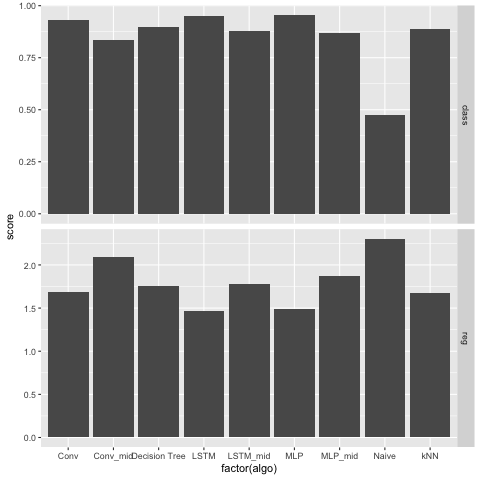

In [27]:
%%R -i RESULTS_FILE

library(tidyverse)

# Processing
csv <- read.csv(RESULTS_FILE)

indep_models <- csv %>% filter(type == 'per_output')

joint_models <- csv %>% filter(type == 'joint')
to_keep <- joint_models %>% 
                group_by(algo, type, param1,param2,regularization) %>%
                summarize(train_score = mean(train_score)) %>%
                group_by(algo) %>%
                filter(train_score == max(train_score)) %>% data.frame()
print(to_keep)

joint_models <- semi_join(joint_models, to_keep, by=c("algo","param1","param1","regularization")) %>%
                distinct()

all_models <- rbind(indep_models, joint_models)

# Plotting
to_plot <- all_models %>%
            select(algo, metric, test_score) %>%
            group_by(algo, metric) %>%
            summarize(score = mean(test_score)) %>%
            as.data.frame
print(to_plot)

to_plot$metric <- factor(to_plot$metric)

p <- ggplot(to_plot, aes(x=factor(algo), y=score)) +
    geom_bar(stat='identity') +
    facet_grid(metric~., scales='free')
p


In [37]:
%%R -i RESULTS_FILE

library(tidyverse)

# Processing
csv <- read.csv(RESULTS_FILE)

indep_models <- csv %>% filter(type == 'per_output')

joint_models <- csv %>% filter(type == 'joint')
to_keep <- joint_models %>% 
                group_by(algo, type, param1,param2,regularization) %>%
                summarize(train_score = mean(train_score)) %>%
                group_by(algo) %>%
                filter(train_score == max(train_score)) %>% data.frame()
print(to_keep)

joint_models <- semi_join(joint_models, to_keep, by=c("algo","param1","param1","regularization")) %>%
                distinct()

all_models <- rbind(indep_models, joint_models)


# Plotting
to_plot <- all_models %>%
            select(algo, metric, test_score) %>%
            group_by(algo, metric) %>%
            summarize(score = mean(test_score)) %>%
            as.data.frame
to_plot$family <- sapply(to_plot$algo,function(n){
    if (n%in%c('Conv', "LSTM", "MLP")){
        "joint model + MFCC"
    } else if (n%in%c('Conv_mid', "LSTM_mid", "MLP_mid")){
        "joint model + Mel Spectrum"
    } else{
        "Independent + MFCC"
    }
})

print(to_plot)

to_plot$metric <- factor(to_plot$metric)

p <- ggplot(to_plot, aes(x=factor(algo), y=score, color=family, fill=family)) +
    geom_bar(stat='identity') +
    facet_grid(metric~family, scales='free')
p

ggsave('results_guitar.pdf', p, width=10)

      algo  type param1 param2 regularization train_score
1     Conv joint     48      2            0.0   -5.116749
2 Conv_mid joint     64      2            0.0   -7.116237
3     LSTM joint    128      2            0.2   -4.067322
4 LSTM_mid joint     80      2            0.0   -5.639317
5      MLP joint    128      1            0.0   -4.445989
6  MLP_mid joint    128      2            0.0   -6.167280
            algo metric     score                     family
1           Conv  class 0.9288338         joint model + MFCC
2           Conv    reg 1.6865461         joint model + MFCC
3       Conv_mid  class 0.8330490 joint model + Mel Spectrum
4       Conv_mid    reg 2.0867859 joint model + Mel Spectrum
5  Decision Tree  class 0.8970990         Independent + MFCC
6  Decision Tree    reg 1.7559453         Independent + MFCC
7           LSTM  class 0.9514621         joint model + MFCC
8           LSTM    reg 1.4657023         joint model + MFCC
9       LSTM_mid  class 0.8783871 joint model